In [6]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy
import gc
import os
from tqdm import tqdm
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 20)

# 多行输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
!dir ../data

dir: 无法访问'../zp/jiaozibei/data': 没有那个文件或目录


In [3]:
!free -g

              总计         已用        空闲      共享    缓冲/缓存    可用
内存：         472          33         426           0          12         436
交换：           1           1           0


# 读文件

In [7]:
data_path = '../data/'
data_train = pd.read_csv(data_path+'sensor_train.csv')
data_test = pd.read_csv(data_path+'sensor_test.csv')
data_test['fragment_id'] += 10000
label = 'behavior_id'

data_train.head(5)
data_test.head(5)

,fragment_id,time_point,acc_x,acc_y,acc_z,acc_xg,acc_yg,acc_zg,behavior_id
0,0,27,0.3,-0.3,0.1,0.6,4.5,8.8,0
1,0,108,0.1,-0.0,-0.4,0.4,4.7,8.4,0
2,0,198,0.1,0.0,0.3,0.9,4.6,9.0,0
3,0,297,0.1,-0.1,-0.5,0.8,4.7,7.2,0
4,0,388,0.1,0.2,0.6,0.9,4.7,8.9,0


,fragment_id,time_point,acc_x,acc_y,acc_z,acc_xg,acc_yg,acc_zg
0,10000,71,0.2,1.0,0.6,0.2,5.3,9.2
1,10000,150,0.0,1.0,-0.7,0.2,6.0,8.2
2,10000,244,-0.2,0.8,-2.4,-0.4,5.3,7.6
3,10000,326,2.3,-0.4,-1.6,2.5,4.5,3.4
4,10000,409,-0.3,-1.4,3.3,0.2,3.5,12.4


In [8]:
data = pd.concat([data_train, data_test], sort=False)
data.head()
del data_test

,fragment_id,time_point,acc_x,acc_y,acc_z,acc_xg,acc_yg,acc_zg,behavior_id
0,0,27,0.3,-0.3,0.1,0.6,4.5,8.8,0.0
1,0,108,0.1,-0.0,-0.4,0.4,4.7,8.4,0.0
2,0,198,0.1,0.0,0.3,0.9,4.6,9.0,0.0
3,0,297,0.1,-0.1,-0.5,0.8,4.7,7.2,0.0
4,0,388,0.1,0.2,0.6,0.9,4.7,8.9,0.0


In [9]:
df = data.reset_index(drop=True)[['fragment_id', 'behavior_id']]
df.head()

,fragment_id,behavior_id
0,0,0.0
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0


# 特征构建

## 简单特征

In [10]:
# xyz都为0代表当前状态为静止状态
data['static'] = list(map(lambda x: 1 if x else 0,(data['acc_x'] ==0) & (data['acc_y'] ==0) & (data['acc_z'] ==0)))

# 时间差
time_diff = data.groupby(["fragment_id"])["time_point"].transform(lambda x:x.diff())
data["time_diff"] = time_diff.fillna(method='bfill')

data.head()

,fragment_id,time_point,acc_x,acc_y,acc_z,acc_xg,acc_yg,acc_zg,behavior_id
0,0,27,0.3,-0.3,0.1,0.6,4.5,8.8,0.0
1,0,108,0.1,-0.0,-0.4,0.4,4.7,8.4,0.0
2,0,198,0.1,0.0,0.3,0.9,4.6,9.0,0.0
3,0,297,0.1,-0.1,-0.5,0.8,4.7,7.2,0.0
4,0,388,0.1,0.2,0.6,0.9,4.7,8.9,0.0


In [19]:
# 各种计算函数
def q10(x):
    return x.quantile(0.1)


def q20(x):
    return x.quantile(0.2)


def q25(x):
    return x.quantile(0.25)


def q30(x):
    return x.quantile(0.3)


def q40(x):
    return x.quantile(0.4)


def q60(x):
    return x.quantile(0.6)


def q70(x):
    return x.quantile(0.7)


def q75(x):
    return x.quantile(0.75)


def q80(x):
    return x.quantile(0.8)


def q90(x):
    return x.quantile(0.9)
from scipy.stats import entropy    
def entropy_values(x):
    x = pd.Series(x)
    return entropy(x.value_counts() / x.shape[0])
    

def kurt(x):
    return pd.Series(x).kurt()


def mode(x):
    '''
    return the mode of x, if the mode is not unique, return the first one in the sequence.
    sample：
        a = [1,1,2,2,3]# 1
        b = [1,2,2,3]  # 2
        mode(a)
        mode(b)

    '''
    return pd.Series(x).mode()[0]


from scipy.stats import moment
def fourth_moment(x):
    '''sample:
        fourth_moment([1,2,3])#2.3907061857313376
    '''
    return moment(x,4)


def fifth_moment(x):
    '''sample:
        fifth_moment([1,2,3])#2.4703447490385586
    '''
    return moment(x,5)


def range_value(x):
    '''
    range(极差) of x,
    '''
    return x.max() - x.min()


def root_mean_square(x):
    '''
    root_mean_square
    sample:
        root_mean_square([1,2,3])#2.160246899469287
    '''
    return np.sqrt(np.mean(np.array(x) ** 2))


In [9]:
data['acc'] = (data['acc_x'] ** 2 + data['acc_y'] ** 2 + data['acc_z'] ** 2) ** 0.5
data['accg'] = (data['acc_xg'] ** 2 + data['acc_yg'] ** 2 + data['acc_zg'] ** 2) ** 0.5
data['xy'] = (data['acc_x'] ** 2 + data['acc_y'] ** 2) ** 0.5
data['xy_g'] = (data['acc_xg'] ** 2 + data['acc_yg'] ** 2) ** 0.5

epison = 0.001

data["x/xy"] = data["acc_x"] / (epison + data["xy"])
data["y/xy"] = data["acc_y"] / (epison + data["xy"])
threshold = 1
data["x/xy"] = np.where(data["xy"]<threshold,0,data["x/xy"])
data["y/xy"] = np.where(data["xy"]<threshold,0,data["y/xy"])

data["x/xy__g"] = data["acc_xg"] / (epison + data["xy_g"])
data["y/xy__g"] = data["acc_yg"] / (epison + data["xy_g"])
threshold = 1
data["x/xy__g"] = np.where(data["xy_g"]<threshold,0,data["x/xy__g"])
data["y/xy__g"] = np.where(data["xy_g"]<threshold,0,data["y/xy__g"])


data['g_x'] = data["acc_x"] - data["acc_xg"]
data['g_y'] = data["acc_y"] - data["acc_yg"]
data['g_z'] = data["acc_z"] - data["acc_zg"]
data['g'] = (data['g_x'] ** 2 + data['g_y'] ** 2 + data['g_z'] ** 2) ** 0.5


data['acc_xg/g'] = data['acc_xg'] / (epison + data['accg'])
data['acc_yg/g'] = data['acc_yg'] / (epison + data['accg'])
data['acc_zg/g'] = data['acc_zg'] / (epison + data['accg'])
data['acc_xyg/g'] = data['xy_g'] / (epison + data['accg'])

data['acc_x/acc'] = data['acc_x'] / (epison + data['acc'])
data['acc_y/acc'] = data['acc_y'] / (epison + data['acc'])
data['acc_z/acc'] = data['acc_z'] / (epison + data['acc'])
data['acc_xy/acc'] = data['xy'] / (epison + data['acc'])



In [15]:
# 去掉了 mad
# 运行过了 直接读文件  下面第二个cell
all_stat_funtion = ['min', 'max', 'mean', 'median',"skew",kurt, 'std','var',mode,\
                    q25, q75, \
                    entropy_values,fourth_moment,fifth_moment,range_value,root_mean_square]
all_stat_name = ['min', 'max', 'mean','median',"skew",'kurt', 'std','var','mode',\
                  'q25', 'q75',\
                 'entropy_values','fourth_moment','fifth_moment',"range_value","root_mean_square"]



stat_cols = [f for f in data.columns if f not in ['fragment_id','time_point','behavior_id']]   # 需要处理的特征
print(stat_cols)

for item in tqdm(stat_cols):
    for name,i in zip(all_stat_name,all_stat_funtion):
        print(name,i)
        df[item+"_"+name] = data.groupby('fragment_id')[item].rolling(20,min_periods=1).agg(i).values
        
df.head()

  0%|          | 0/28 [00:00<?, ?it/s]

['acc_x', 'acc_y', 'acc_z', 'acc_xg', 'acc_yg', 'acc_zg', 'static', 'time_diff', 'acc', 'accg', 'xy', 'xy_g', 'x/xy', 'y/xy', 'x/xy__g', 'y/xy__g', 'g_x', 'g_y', 'g_z', 'g', 'acc_xg/g', 'acc_yg/g', 'acc_zg/g', 'acc_xyg/g', 'acc_x/acc', 'acc_y/acc', 'acc_z/acc', 'acc_xy/acc']
min min
max max
mean mean
median median
skew skew
kurt <function kurt at 0x7f29b34018c0>
std std
var var
mode <function mode at 0x7f29b34019e0>
q25 <function q25 at 0x7f29b6d1bcb0>
q75 <function q75 at 0x7f29b3401440>
entropy_values <function entropy_values at 0x7f29b34017a0>
fourth_moment <function fourth_moment at 0x7f29b3401b00>
fifth_moment <function fifth_moment at 0x7f29b3401c20>
range_value <function range_value at 0x7f29b3401d40>
root_mean_square <function root_mean_square at 0x7f29b3401e60>


  4%|▎         | 1/28 [37:40<16:57:12, 2260.47s/it]

min min
max max
mean mean
median median
skew skew
kurt <function kurt at 0x7f29b34018c0>
std std
var var
mode <function mode at 0x7f29b34019e0>
q25 <function q25 at 0x7f29b6d1bcb0>
q75 <function q75 at 0x7f29b3401440>
entropy_values <function entropy_values at 0x7f29b34017a0>
fourth_moment <function fourth_moment at 0x7f29b3401b00>
fifth_moment <function fifth_moment at 0x7f29b3401c20>
range_value <function range_value at 0x7f29b3401d40>
root_mean_square <function root_mean_square at 0x7f29b3401e60>
std std
var var
mode <function mode at 0x7f29b34019e0>
q25 <function q25 at 0x7f29b6d1bcb0>
q75 <function q75 at 0x7f29b3401440>
entropy_values <function entropy_values at 0x7f29b34017a0>
fourth_moment <function fourth_moment at 0x7f29b3401b00>
fifth_moment <function fifth_moment at 0x7f29b3401c20>
range_value <function range_value at 0x7f29b3401d40>
root_mean_square <function root_mean_square at 0x7f29b3401e60>


 11%|█         | 3/28 [1:55:22<15:59:59, 2303.97s/it]

min min
max max
mean mean
median median
skew skew
kurt <function kurt at 0x7f29b34018c0>
std std
var var
mode <function mode at 0x7f29b34019e0>
q25 <function q25 at 0x7f29b6d1bcb0>
q75 <function q75 at 0x7f29b3401440>
entropy_values <function entropy_values at 0x7f29b34017a0>
fourth_moment <function fourth_moment at 0x7f29b3401b00>
fifth_moment <function fifth_moment at 0x7f29b3401c20>
range_value <function range_value at 0x7f29b3401d40>
root_mean_square <function root_mean_square at 0x7f29b3401e60>


 14%|█▍        | 4/28 [2:49:27<17:14:32, 2586.36s/it]

min min
max max
mean mean
median median
skew skew
kurt <function kurt at 0x7f29b34018c0>
std std
var var
mode <function mode at 0x7f29b34019e0>
q25 <function q25 at 0x7f29b6d1bcb0>
q75 <function q75 at 0x7f29b3401440>
entropy_values <function entropy_values at 0x7f29b34017a0>
fourth_moment <function fourth_moment at 0x7f29b3401b00>
fifth_moment <function fifth_moment at 0x7f29b3401c20>
range_value <function range_value at 0x7f29b3401d40>
root_mean_square <function root_mean_square at 0x7f29b3401e60>


 18%|█▊        | 5/28 [3:42:17<17:38:28, 2761.26s/it]

min min
max max
mean mean
median median
skew skew
kurt <function kurt at 0x7f29b34018c0>
std std
var var
mode <function mode at 0x7f29b34019e0>
q25 <function q25 at 0x7f29b6d1bcb0>
q75 <function q75 at 0x7f29b3401440>
entropy_values <function entropy_values at 0x7f29b34017a0>
fourth_moment <function fourth_moment at 0x7f29b3401b00>
fifth_moment <function fifth_moment at 0x7f29b3401c20>
range_value <function range_value at 0x7f29b3401d40>
root_mean_square <function root_mean_square at 0x7f29b3401e60>


 21%|██▏       | 6/28 [4:40:53<18:15:33, 2987.88s/it]

min min
max max
mean mean
median median
skew skew
kurt <function kurt at 0x7f29b34018c0>
std std
var var
mode <function mode at 0x7f29b34019e0>
q25 <function q25 at 0x7f29b6d1bcb0>
q75 <function q75 at 0x7f29b3401440>
entropy_values <function entropy_values at 0x7f29b34017a0>
fourth_moment <function fourth_moment at 0x7f29b3401b00>
fifth_moment <function fifth_moment at 0x7f29b3401c20>
range_value <function range_value at 0x7f29b3401d40>
root_mean_square <function root_mean_square at 0x7f29b3401e60>


 25%|██▌       | 7/28 [5:22:28<16:33:55, 2839.81s/it]

min min
max max
mean mean
median median
skew skew
kurt <function kurt at 0x7f29b34018c0>
std std
var var
mode <function mode at 0x7f29b34019e0>
q25 <function q25 at 0x7f29b6d1bcb0>
q75 <function q75 at 0x7f29b3401440>
entropy_values <function entropy_values at 0x7f29b34017a0>
fourth_moment <function fourth_moment at 0x7f29b3401b00>
fifth_moment <function fifth_moment at 0x7f29b3401c20>
range_value <function range_value at 0x7f29b3401d40>
root_mean_square <function root_mean_square at 0x7f29b3401e60>


 29%|██▊       | 8/28 [6:10:00<15:47:52, 2843.64s/it]

min min
max max
mean mean
median median
skew skew
kurt <function kurt at 0x7f29b34018c0>
std std
var var
mode <function mode at 0x7f29b34019e0>
q25 <function q25 at 0x7f29b6d1bcb0>
q75 <function q75 at 0x7f29b3401440>
entropy_values <function entropy_values at 0x7f29b34017a0>
fourth_moment <function fourth_moment at 0x7f29b3401b00>
fifth_moment <function fifth_moment at 0x7f29b3401c20>
range_value <function range_value at 0x7f29b3401d40>
root_mean_square <function root_mean_square at 0x7f29b3401e60>


 32%|███▏      | 9/28 [6:57:08<14:59:01, 2839.01s/it]

min min
max max
mean mean
median median
skew skew
kurt <function kurt at 0x7f29b34018c0>
std std
var var
mode <function mode at 0x7f29b34019e0>
q25 <function q25 at 0x7f29b6d1bcb0>
q75 <function q75 at 0x7f29b3401440>
entropy_values <function entropy_values at 0x7f29b34017a0>
fourth_moment <function fourth_moment at 0x7f29b3401b00>
fifth_moment <function fifth_moment at 0x7f29b3401c20>
range_value <function range_value at 0x7f29b3401d40>
root_mean_square <function root_mean_square at 0x7f29b3401e60>


 36%|███▌      | 10/28 [7:40:48<13:51:55, 2773.10s/it]

min min
max max
mean mean
median median
skew skew
kurt <function kurt at 0x7f29b34018c0>
std std
var var
mode <function mode at 0x7f29b34019e0>
q25 <function q25 at 0x7f29b6d1bcb0>
q75 <function q75 at 0x7f29b3401440>
entropy_values <function entropy_values at 0x7f29b34017a0>
fourth_moment <function fourth_moment at 0x7f29b3401b00>
fifth_moment <function fifth_moment at 0x7f29b3401c20>
range_value <function range_value at 0x7f29b3401d40>
root_mean_square <function root_mean_square at 0x7f29b3401e60>


 39%|███▉      | 11/28 [8:17:41<12:18:09, 2605.28s/it]

min min
max max
mean mean
median median
skew skew
kurt <function kurt at 0x7f29b34018c0>
std std
var var
mode <function mode at 0x7f29b34019e0>
q25 <function q25 at 0x7f29b6d1bcb0>
q75 <function q75 at 0x7f29b3401440>
entropy_values <function entropy_values at 0x7f29b34017a0>
fourth_moment <function fourth_moment at 0x7f29b3401b00>
fifth_moment <function fifth_moment at 0x7f29b3401c20>
range_value <function range_value at 0x7f29b3401d40>
root_mean_square <function root_mean_square at 0x7f29b3401e60>


 43%|████▎     | 12/28 [8:54:34<11:03:17, 2487.37s/it]

min min
max max
mean mean
median median
skew skew
kurt <function kurt at 0x7f29b34018c0>
std std
var var
mode <function mode at 0x7f29b34019e0>
q25 <function q25 at 0x7f29b6d1bcb0>
q75 <function q75 at 0x7f29b3401440>
entropy_values <function entropy_values at 0x7f29b34017a0>
fourth_moment <function fourth_moment at 0x7f29b3401b00>
fifth_moment <function fifth_moment at 0x7f29b3401c20>
range_value <function range_value at 0x7f29b3401d40>
root_mean_square <function root_mean_square at 0x7f29b3401e60>


 46%|████▋     | 13/28 [9:31:06<9:59:42, 2398.84s/it] 

min min
max max
mean mean
median median
skew skew
kurt <function kurt at 0x7f29b34018c0>
std std
var var
mode <function mode at 0x7f29b34019e0>
q25 <function q25 at 0x7f29b6d1bcb0>
q75 <function q75 at 0x7f29b3401440>
entropy_values <function entropy_values at 0x7f29b34017a0>
fourth_moment <function fourth_moment at 0x7f29b3401b00>
fifth_moment <function fifth_moment at 0x7f29b3401c20>
range_value <function range_value at 0x7f29b3401d40>
root_mean_square <function root_mean_square at 0x7f29b3401e60>


 50%|█████     | 14/28 [10:07:39<9:05:17, 2336.99s/it]

min min
max max
mean mean
median median
skew skew
kurt <function kurt at 0x7f29b34018c0>
std std
var var
mode <function mode at 0x7f29b34019e0>
q25 <function q25 at 0x7f29b6d1bcb0>
q75 <function q75 at 0x7f29b3401440>
entropy_values <function entropy_values at 0x7f29b34017a0>
fourth_moment <function fourth_moment at 0x7f29b3401b00>
fifth_moment <function fifth_moment at 0x7f29b3401c20>
range_value <function range_value at 0x7f29b3401d40>
root_mean_square <function root_mean_square at 0x7f29b3401e60>


 54%|█████▎    | 15/28 [10:44:29<8:18:07, 2299.06s/it]

min min
max max
mean mean
median median
skew skew
kurt <function kurt at 0x7f29b34018c0>
std std
var var
mode <function mode at 0x7f29b34019e0>
q25 <function q25 at 0x7f29b6d1bcb0>
q75 <function q75 at 0x7f29b3401440>
entropy_values <function entropy_values at 0x7f29b34017a0>
fourth_moment <function fourth_moment at 0x7f29b3401b00>
fifth_moment <function fifth_moment at 0x7f29b3401c20>
range_value <function range_value at 0x7f29b3401d40>
root_mean_square <function root_mean_square at 0x7f29b3401e60>


 57%|█████▋    | 16/28 [11:21:09<7:33:50, 2269.19s/it]

min min
max max
mean mean
median median
skew skew
kurt <function kurt at 0x7f29b34018c0>
std std
var var
mode <function mode at 0x7f29b34019e0>
q25 <function q25 at 0x7f29b6d1bcb0>
q75 <function q75 at 0x7f29b3401440>
entropy_values <function entropy_values at 0x7f29b34017a0>
fourth_moment <function fourth_moment at 0x7f29b3401b00>
fifth_moment <function fifth_moment at 0x7f29b3401c20>
range_value <function range_value at 0x7f29b3401d40>
root_mean_square <function root_mean_square at 0x7f29b3401e60>


 61%|██████    | 17/28 [11:57:45<6:51:59, 2247.26s/it]

min min
max max
mean mean
median median
skew skew
kurt <function kurt at 0x7f29b34018c0>
std std
var var
mode <function mode at 0x7f29b34019e0>
q25 <function q25 at 0x7f29b6d1bcb0>
q75 <function q75 at 0x7f29b3401440>
entropy_values <function entropy_values at 0x7f29b34017a0>
fourth_moment <function fourth_moment at 0x7f29b3401b00>
fifth_moment <function fifth_moment at 0x7f29b3401c20>
range_value <function range_value at 0x7f29b3401d40>
root_mean_square <function root_mean_square at 0x7f29b3401e60>


 64%|██████▍   | 18/28 [12:34:25<6:12:11, 2233.20s/it]

min min
max max
mean mean
median median
skew skew
kurt <function kurt at 0x7f29b34018c0>
std std
var var
mode <function mode at 0x7f29b34019e0>
q25 <function q25 at 0x7f29b6d1bcb0>
q75 <function q75 at 0x7f29b3401440>
entropy_values <function entropy_values at 0x7f29b34017a0>
fourth_moment <function fourth_moment at 0x7f29b3401b00>
fifth_moment <function fifth_moment at 0x7f29b3401c20>
range_value <function range_value at 0x7f29b3401d40>
root_mean_square <function root_mean_square at 0x7f29b3401e60>


 68%|██████▊   | 19/28 [13:11:16<5:33:59, 2226.61s/it]

min min
max max
mean mean
median median
skew skew
kurt <function kurt at 0x7f29b34018c0>
std std
var var
mode <function mode at 0x7f29b34019e0>
q25 <function q25 at 0x7f29b6d1bcb0>
q75 <function q75 at 0x7f29b3401440>
entropy_values <function entropy_values at 0x7f29b34017a0>
fourth_moment <function fourth_moment at 0x7f29b3401b00>
fifth_moment <function fifth_moment at 0x7f29b3401c20>
range_value <function range_value at 0x7f29b3401d40>
root_mean_square <function root_mean_square at 0x7f29b3401e60>


 71%|███████▏  | 20/28 [13:55:20<5:13:33, 2351.75s/it]

min min
max max
mean mean
median median
skew skew
kurt <function kurt at 0x7f29b34018c0>
std std
var var
mode <function mode at 0x7f29b34019e0>
q25 <function q25 at 0x7f29b6d1bcb0>
q75 <function q75 at 0x7f29b3401440>
entropy_values <function entropy_values at 0x7f29b34017a0>
fourth_moment <function fourth_moment at 0x7f29b3401b00>
fifth_moment <function fifth_moment at 0x7f29b3401c20>
range_value <function range_value at 0x7f29b3401d40>
root_mean_square <function root_mean_square at 0x7f29b3401e60>


 75%|███████▌  | 21/28 [14:42:06<4:50:16, 2488.00s/it]

min min
max max
mean mean
median median
skew skew
kurt <function kurt at 0x7f29b34018c0>
std std
var var
mode <function mode at 0x7f29b34019e0>
q25 <function q25 at 0x7f29b6d1bcb0>
q75 <function q75 at 0x7f29b3401440>
entropy_values <function entropy_values at 0x7f29b34017a0>
fourth_moment <function fourth_moment at 0x7f29b3401b00>
fifth_moment <function fifth_moment at 0x7f29b3401c20>
range_value <function range_value at 0x7f29b3401d40>
root_mean_square <function root_mean_square at 0x7f29b3401e60>


 79%|███████▊  | 22/28 [15:28:05<4:16:54, 2569.16s/it]

min min
max max
mean mean
median median
skew skew
kurt <function kurt at 0x7f29b34018c0>
std std
var var
mode <function mode at 0x7f29b34019e0>
q25 <function q25 at 0x7f29b6d1bcb0>
q75 <function q75 at 0x7f29b3401440>
entropy_values <function entropy_values at 0x7f29b34017a0>
fourth_moment <function fourth_moment at 0x7f29b3401b00>
fifth_moment <function fifth_moment at 0x7f29b3401c20>
range_value <function range_value at 0x7f29b3401d40>
root_mean_square <function root_mean_square at 0x7f29b3401e60>


 82%|████████▏ | 23/28 [16:14:38<3:39:41, 2636.31s/it]

min min
max max
mean mean
median median
skew skew
kurt <function kurt at 0x7f29b34018c0>
std std
var var
mode <function mode at 0x7f29b34019e0>
q25 <function q25 at 0x7f29b6d1bcb0>
q75 <function q75 at 0x7f29b3401440>
entropy_values <function entropy_values at 0x7f29b34017a0>
fourth_moment <function fourth_moment at 0x7f29b3401b00>
fifth_moment <function fifth_moment at 0x7f29b3401c20>
range_value <function range_value at 0x7f29b3401d40>
root_mean_square <function root_mean_square at 0x7f29b3401e60>


 86%|████████▌ | 24/28 [17:01:19<2:59:03, 2685.93s/it]

min min
max max
mean mean
median median
skew skew
kurt <function kurt at 0x7f29b34018c0>
std std
var var
mode <function mode at 0x7f29b34019e0>
q25 <function q25 at 0x7f29b6d1bcb0>
q75 <function q75 at 0x7f29b3401440>
entropy_values <function entropy_values at 0x7f29b34017a0>
fourth_moment <function fourth_moment at 0x7f29b3401b00>
fifth_moment <function fifth_moment at 0x7f29b3401c20>
range_value <function range_value at 0x7f29b3401d40>
root_mean_square <function root_mean_square at 0x7f29b3401e60>


 89%|████████▉ | 25/28 [17:43:53<2:12:18, 2646.20s/it]

min min
max max
mean mean
median median
skew skew
kurt <function kurt at 0x7f29b34018c0>
std std
var var
mode <function mode at 0x7f29b34019e0>
q25 <function q25 at 0x7f29b6d1bcb0>
q75 <function q75 at 0x7f29b3401440>
entropy_values <function entropy_values at 0x7f29b34017a0>
fourth_moment <function fourth_moment at 0x7f29b3401b00>
fifth_moment <function fifth_moment at 0x7f29b3401c20>
range_value <function range_value at 0x7f29b3401d40>
root_mean_square <function root_mean_square at 0x7f29b3401e60>


 93%|█████████▎| 26/28 [18:29:31<1:29:07, 2673.67s/it]

min min
max max
mean mean
median median
skew skew
kurt <function kurt at 0x7f29b34018c0>
std std
var var
mode <function mode at 0x7f29b34019e0>
q25 <function q25 at 0x7f29b6d1bcb0>
q75 <function q75 at 0x7f29b3401440>
entropy_values <function entropy_values at 0x7f29b34017a0>
fourth_moment <function fourth_moment at 0x7f29b3401b00>
fifth_moment <function fifth_moment at 0x7f29b3401c20>
range_value <function range_value at 0x7f29b3401d40>
root_mean_square <function root_mean_square at 0x7f29b3401e60>


 96%|█████████▋| 27/28 [19:14:11<44:35, 2675.71s/it]  

min min
max max
mean mean
median median
skew skew
kurt <function kurt at 0x7f29b34018c0>
std std
var var
mode <function mode at 0x7f29b34019e0>
q25 <function q25 at 0x7f29b6d1bcb0>
q75 <function q75 at 0x7f29b3401440>
entropy_values <function entropy_values at 0x7f29b34017a0>
fourth_moment <function fourth_moment at 0x7f29b3401b00>
fifth_moment <function fifth_moment at 0x7f29b3401c20>
range_value <function range_value at 0x7f29b3401d40>
root_mean_square <function root_mean_square at 0x7f29b3401e60>


100%|██████████| 28/28 [19:58:22<00:00, 2567.96s/it]


,fragment_id,behavior_id,acc_x_min,acc_x_max,acc_x_mean,acc_x_sum,acc_x_median,acc_x_skew,acc_x_kurt,acc_x_std,acc_x_var,acc_x_mode,acc_x_q25,acc_x_q75,acc_x_entropy_values,...,acc_xy/acc_max,acc_xy/acc_mean,acc_xy/acc_median,acc_xy/acc_skew,acc_xy/acc_kurt,acc_xy/acc_std,acc_xy/acc_var,acc_xy/acc_mode,acc_xy/acc_q25,acc_xy/acc_q75,acc_xy/acc_entropy_values,acc_xy/acc_fourth_moment,acc_xy/acc_fifth_moment,acc_xy/acc_range_value,acc_xy/acc_root_mean_square
0,0,0.0,0.3,0.3,0.300000,0.3,0.3,NaN,NaN,NaN,NaN,0.3,0.30,0.30,0.000000,...,0.971101,0.971101,0.971101,NaN,NaN,NaN,NaN,0.971101,0.971101,0.971101,0.000000,0.000000,0.000000e+00,0.000000,0.971101
1,0,0.0,0.1,0.3,0.200000,0.4,0.2,NaN,NaN,0.141421,0.020000,0.1,0.15,0.25,0.693147,...,0.971101,0.606525,0.606525,NaN,NaN,0.515588,0.265831,0.241949,0.424237,0.788813,0.693147,0.017667,1.734723e-18,0.729152,0.707664
2,0,0.0,0.1,0.3,0.166667,0.5,0.1,1.732051,NaN,0.115470,0.013333,0.1,0.10,0.20,0.636514,...,0.971101,0.509427,0.315231,1.667362,NaN,0.401497,0.161200,0.241949,0.278590,0.643166,1.098612,0.017324,6.442823e-03,0.729152,0.605790
3,0,0.0,0.1,0.3,0.150000,0.6,0.1,2.000000,4.0,0.100000,0.010000,0.1,0.10,0.15,0.562335,...,0.971101,0.449981,0.293437,1.955725,3.849088,0.348714,0.121602,0.241949,0.264219,0.479198,1.386294,0.019241,9.454282e-03,0.729152,0.541926
4,0,0.0,0.1,0.3,0.140000,0.7,0.1,2.236068,5.0,0.089443,0.008000,0.1,0.10,0.10,0.500402,...,0.971101,0.429719,0.315231,2.137254,4.647128,0.305375,0.093254,0.241949,0.271643,0.348671,1.609438,0.017597,9.230351e-03,0.729152,0.509177


In [19]:
# df.to_pickle("449features.pkl")

In [8]:
# df=pd.read_pickle("449features.pkl")
df.head(5)

,fragment_id,behavior_id,acc_x_min,acc_x_max,acc_x_mean,...,acc_xy/acc_entropy_values,acc_xy/acc_fourth_moment,acc_xy/acc_fifth_moment,acc_xy/acc_range_value,acc_xy/acc_root_mean_square
0,0,0.0,0.3,0.3,0.300000,...,0.000000,0.000000,0.000000e+00,0.000000,0.971101
1,0,0.0,0.1,0.3,0.200000,...,0.693147,0.017667,1.734723e-18,0.729152,0.707664
2,0,0.0,0.1,0.3,0.166667,...,1.098612,0.017324,6.442823e-03,0.729152,0.605790
3,0,0.0,0.1,0.3,0.150000,...,1.386294,0.019241,9.454282e-03,0.729152,0.541926
4,0,0.0,0.1,0.3,0.140000,...,1.609438,0.017597,9.230351e-03,0.729152,0.509177


## 新加入的特征

In [17]:
# 希望新加入的特征

def add_features(df):
    print(df.columns)
    df['thetax']=np.arctan(df.acc_xg/
                           np.sqrt(df.acc_yg*df.acc_yg+df.acc_zg*df.acc_zg))*180/np.pi
    df['thetay']=np.arctan(df.acc_yg/
                           np.sqrt(df.acc_xg*df.acc_xg+df.acc_zg*df.acc_zg))*180/np.pi
    df['thetaz']=np.arctan(df.acc_zg/
                           np.sqrt(df.acc_yg*df.acc_yg+df.acc_xg*df.acc_xg))*180/np.pi
    print(df.columns)
    return df

data=add_features(data)
data.head(5)

Index(['fragment_id', 'time_point', 'acc_x', 'acc_y', 'acc_z', 'acc_xg',
       'acc_yg', 'acc_zg', 'behavior_id'],
      dtype='object')
Index(['fragment_id', 'time_point', 'acc_x', 'acc_y', 'acc_z', 'acc_xg',
       'acc_yg', 'acc_zg', 'behavior_id', 'thetax', 'thetay', 'thetaz'],
      dtype='object')


,fragment_id,time_point,acc_x,acc_y,acc_z,...,acc_zg,behavior_id,thetax,thetay,thetaz
0,0,27,0.3,-0.3,0.1,...,8.8,0.0,3.473891,27.029727,62.711286
1,0,108,0.1,-0.0,-0.4,...,8.4,0.0,2.379634,29.200410,60.683764
2,0,198,0.1,0.0,0.3,...,9.0,0.0,5.088395,26.956731,62.489416
3,0,297,0.1,-0.1,-0.5,...,7.2,0.0,5.315618,32.974911,56.488807
4,0,388,0.1,0.2,0.6,...,8.9,0.0,5.109835,27.717899,61.733757


In [21]:
# 去掉了 mad
# 运行过了 直接读文件  下面第二个cell
all_stat_funtion = ['min', 'max', 'mean', 'median',"skew",kurt, 'std','var',mode,\
                    q25, q75, \
                    entropy_values,fourth_moment,fifth_moment,range_value,root_mean_square]
all_stat_name = ['min', 'max', 'mean','median',"skew",'kurt', 'std','var','mode',\
                  'q25', 'q75',\
                 'entropy_values','fourth_moment','fifth_moment',"range_value","root_mean_square"]



stat_cols = [f for f in data.columns if f not in ['fragment_id','time_point','behavior_id']]   # 需要处理的特征
stat_cols = ['thetax', 'thetay', 'thetaz']
print(stat_cols)

for item in tqdm(stat_cols):
    for name,i in zip(all_stat_name,all_stat_funtion):
        print(name,i)
        df[item+"_"+name] = data.groupby('fragment_id')[item].rolling(20,min_periods=1).agg(i).values
        
df.head()

  0%|          | 0/3 [00:00<?, ?it/s]

['thetax', 'thetay', 'thetaz']
min min
max max
mean mean
median median
skew skew
kurt <function kurt at 0x7f13d5ca99e0>
std std
var var
mode <function mode at 0x7f13d5ca9b00>
q25 <function q25 at 0x7f14086b0f80>
q75 <function q75 at 0x7f13d5ca9560>
entropy_values <function entropy_values at 0x7f13d5ca98c0>
fourth_moment <function fourth_moment at 0x7f13d5ca9c20>
fifth_moment <function fifth_moment at 0x7f13d5ca9d40>
range_value <function range_value at 0x7f13d5ca9e60>
root_mean_square <function root_mean_square at 0x7f13d5ca9f80>


 33%|███▎      | 1/3 [46:58<1:33:57, 2818.79s/it]

min min
max max
mean mean
median median
skew skew
kurt <function kurt at 0x7f13d5ca99e0>
std std
var var
mode <function mode at 0x7f13d5ca9b00>
q25 <function q25 at 0x7f14086b0f80>
q75 <function q75 at 0x7f13d5ca9560>
entropy_values <function entropy_values at 0x7f13d5ca98c0>
fourth_moment <function fourth_moment at 0x7f13d5ca9c20>
fifth_moment <function fifth_moment at 0x7f13d5ca9d40>
range_value <function range_value at 0x7f13d5ca9e60>
root_mean_square <function root_mean_square at 0x7f13d5ca9f80>


 67%|██████▋   | 2/3 [1:29:02<45:30, 2730.20s/it]

min min
max max
mean mean
median median
skew skew
kurt <function kurt at 0x7f13d5ca99e0>
std std
var var
mode <function mode at 0x7f13d5ca9b00>
q25 <function q25 at 0x7f14086b0f80>
q75 <function q75 at 0x7f13d5ca9560>
entropy_values <function entropy_values at 0x7f13d5ca98c0>
fourth_moment <function fourth_moment at 0x7f13d5ca9c20>
fifth_moment <function fifth_moment at 0x7f13d5ca9d40>
range_value <function range_value at 0x7f13d5ca9e60>
root_mean_square <function root_mean_square at 0x7f13d5ca9f80>


100%|██████████| 3/3 [2:11:16<00:00, 2625.38s/it]


,fragment_id,behavior_id,acc_x_min,acc_x_max,acc_x_mean,...,thetaz_entropy_values,thetaz_fourth_moment,thetaz_fifth_moment,thetaz_range_value,thetaz_root_mean_square
0,0,0.0,0.3,0.3,0.300000,...,0.000000,0.000000,0.000000,0.000000,62.711286
1,0,0.0,0.1,0.3,0.200000,...,0.693147,1.056190,0.000000,2.027522,61.705853
2,0,0.0,0.1,0.3,0.166667,...,1.098612,1.019687,-1.042517,2.027522,61.968142
3,0,0.0,0.1,0.3,0.150000,...,1.386294,79.217365,-274.455842,6.222478,60.644738
4,0,0.0,0.1,0.3,0.140000,...,1.609438,74.711347,-297.801497,6.222478,60.864101


In [38]:
df.columns

Index(['fragment_id', 'behavior_id', 'acc_x_min', 'acc_x_max', 'acc_x_mean',
       'acc_x_median', 'acc_x_skew', 'acc_x_kurt', 'acc_x_std', 'acc_x_var',
       'acc_x_mode', 'acc_x_q25', 'acc_x_q75', 'thetax_min', 'thetax_max',
       'thetax_mean', 'thetax_median', 'thetax_skew', 'thetax_kurt',
       'thetax_std', 'thetax_var', 'thetax_mode', 'thetax_q25', 'thetax_q75',
       'thetax_entropy_values', 'thetax_fourth_moment', 'thetax_fifth_moment',
       'thetax_range_value', 'thetax_root_mean_square', 'thetay_min',
       'thetay_max', 'thetay_mean', 'thetay_median', 'thetay_skew',
       'thetay_kurt', 'thetay_std', 'thetay_var', 'thetay_mode', 'thetay_q25',
       'thetay_q75', 'thetay_entropy_values', 'thetay_fourth_moment',
       'thetay_fifth_moment', 'thetay_range_value', 'thetay_root_mean_square',
       'thetaz_min', 'thetaz_max', 'thetaz_mean', 'thetaz_median',
       'thetaz_skew', 'thetaz_kurt', 'thetaz_std', 'thetaz_var', 'thetaz_mode',
       'thetaz_q25', 'thetaz_q75

In [39]:
df=df[['fragment_id', 'behavior_id', 'thetax_min', 'thetax_max',
       'thetax_mean', 'thetax_median', 'thetax_skew', 'thetax_kurt',
       'thetax_std', 'thetax_var', 'thetax_mode', 'thetax_q25', 'thetax_q75',
       'thetax_entropy_values', 'thetax_fourth_moment', 'thetax_fifth_moment',
       'thetax_range_value', 'thetax_root_mean_square', 'thetay_min',
       'thetay_max', 'thetay_mean', 'thetay_median', 'thetay_skew',
       'thetay_kurt', 'thetay_std', 'thetay_var', 'thetay_mode', 'thetay_q25',
       'thetay_q75', 'thetay_entropy_values', 'thetay_fourth_moment',
       'thetay_fifth_moment', 'thetay_range_value', 'thetay_root_mean_square',
       'thetaz_min', 'thetaz_max', 'thetaz_mean', 'thetaz_median',
       'thetaz_skew', 'thetaz_kurt', 'thetaz_std', 'thetaz_var', 'thetaz_mode',
       'thetaz_q25', 'thetaz_q75', 'thetaz_entropy_values',
       'thetaz_fourth_moment', 'thetaz_fifth_moment', 'thetaz_range_value',
       'thetaz_root_mean_square', 'istrain']]

In [40]:
df.to_pickle("features_thetaxyz.pkl")

# 特征筛选

In [41]:
drop_feat = ["istrain"] 
used_feat = [f for f in df.columns if f not in (['fragment_id', label] + drop_feat)]
print(len(used_feat),used_feat)
df["istrain"] = (df[label].isna()==False).astype(np.int8)
result_dict = get_feature_report_by_covariate_shift_test(df,
                                               features=used_feat,
                                               all_cate_feas=[],
                                               params=None,
                                               nfold=3,
                                               y2test='istrain',
                                               train_all_feas=False)

result_df = result_dict["df_fea_auc"]
drop_bylgb = list(result_df[result_df["val_auc"] > 0.55]["feat"])
result_df

48 ['thetax_min', 'thetax_max', 'thetax_mean', 'thetax_median', 'thetax_skew', 'thetax_kurt', 'thetax_std', 'thetax_var', 'thetax_mode', 'thetax_q25', 'thetax_q75', 'thetax_entropy_values', 'thetax_fourth_moment', 'thetax_fifth_moment', 'thetax_range_value', 'thetax_root_mean_square', 'thetay_min', 'thetay_max', 'thetay_mean', 'thetay_median', 'thetay_skew', 'thetay_kurt', 'thetay_std', 'thetay_var', 'thetay_mode', 'thetay_q25', 'thetay_q75', 'thetay_entropy_values', 'thetay_fourth_moment', 'thetay_fifth_moment', 'thetay_range_value', 'thetay_root_mean_square', 'thetaz_min', 'thetaz_max', 'thetaz_mean', 'thetaz_median', 'thetaz_skew', 'thetaz_kurt', 'thetaz_std', 'thetaz_var', 'thetaz_mode', 'thetaz_q25', 'thetaz_q75', 'thetaz_entropy_values', 'thetaz_fourth_moment', 'thetaz_fifth_moment', 'thetaz_range_value', 'thetaz_root_mean_square']


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
  0%|          | 0/48 [00:00<?, ?it/s]/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.551689	valid_1's auc: 0.552537
[40]	training's auc: 0.554549	valid_1's auc: 0.554191
[60]	training's auc: 0.55578	valid_1's auc: 0.554828
[80]	training's auc: 0.556365	valid_1's auc: 0.555034
[100]	training's auc: 0.556612	valid_1's auc: 0.555084
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.556612	valid_1's auc: 0.555084
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.552712	valid_1's auc: 0.550134
[40]	training's auc: 0.555394	valid_1's auc: 0.552492
[60]	training's auc: 0.556489	valid_1's auc: 0.553449
[80]	training's auc: 0.557056	valid_1's auc: 0.5539
[100]	training's auc: 0.557373	valid_1's auc: 0.554185
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.557373	valid_1's auc: 0.554185
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553678	valid_1's auc: 0.551283
[40]	training's au

  2%|▏         | 1/48 [00:11<09:02, 11.55s/it]

[100]	training's auc: 0.558719	valid_1's auc: 0.556035
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.558719	valid_1's auc: 0.556035


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553915	valid_1's auc: 0.553192
[40]	training's auc: 0.556759	valid_1's auc: 0.555478
[60]	training's auc: 0.557732	valid_1's auc: 0.556328
[80]	training's auc: 0.558217	valid_1's auc: 0.556838
[100]	training's auc: 0.558474	valid_1's auc: 0.557026
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.558474	valid_1's auc: 0.557026
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554634	valid_1's auc: 0.5508
[40]	training's auc: 0.557099	valid_1's auc: 0.553241
[60]	training's auc: 0.558203	valid_1's auc: 0.554041
[80]	training's auc: 0.558646	valid_1's auc: 0.55434
[100]	training's auc: 0.558918	valid_1's auc: 0.554544
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.558918	valid_1's auc: 0.554544
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.552942	valid_1's auc: 0.551788
[40]	training's au

  4%|▍         | 2/48 [00:22<08:47, 11.47s/it]

[100]	training's auc: 0.557293	valid_1's auc: 0.55489
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.557293	valid_1's auc: 0.55489


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.543594	valid_1's auc: 0.54256
[40]	training's auc: 0.544694	valid_1's auc: 0.543302
[60]	training's auc: 0.545048	valid_1's auc: 0.543498
[80]	training's auc: 0.54527	valid_1's auc: 0.543582
[100]	training's auc: 0.545383	valid_1's auc: 0.543592
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.545383	valid_1's auc: 0.543592
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.543951	valid_1's auc: 0.541739
[40]	training's auc: 0.545057	valid_1's auc: 0.542342
[60]	training's auc: 0.54541	valid_1's auc: 0.542531
[80]	training's auc: 0.545577	valid_1's auc: 0.542617
[100]	training's auc: 0.545671	valid_1's auc: 0.542591
Did not meet early stopping. Best iteration is:
[99]	training's auc: 0.545672	valid_1's auc: 0.542584
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.543488	valid_1's auc: 0.542221
[40]	training's auc

  6%|▋         | 3/48 [00:34<08:39, 11.55s/it]

Early stopping, best iteration is:
[68]	training's auc: 0.545167	valid_1's auc: 0.542795


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555935	valid_1's auc: 0.554074
[40]	training's auc: 0.558371	valid_1's auc: 0.555944
[60]	training's auc: 0.559278	valid_1's auc: 0.556576
[80]	training's auc: 0.559763	valid_1's auc: 0.556858
[100]	training's auc: 0.560038	valid_1's auc: 0.556914
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.560038	valid_1's auc: 0.556914
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555844	valid_1's auc: 0.553447
[40]	training's auc: 0.557984	valid_1's auc: 0.55545
[60]	training's auc: 0.558824	valid_1's auc: 0.556153
[80]	training's auc: 0.55931	valid_1's auc: 0.55665
[100]	training's auc: 0.559541	valid_1's auc: 0.556926
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.559541	valid_1's auc: 0.556926
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555208	valid_1's auc: 0.554905
[40]	training's au

  8%|▊         | 4/48 [00:46<08:35, 11.71s/it]

[100]	training's auc: 0.559345	valid_1's auc: 0.557975
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.559345	valid_1's auc: 0.557975


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.528697	valid_1's auc: 0.52532
[40]	training's auc: 0.529259	valid_1's auc: 0.525109
Early stopping, best iteration is:
[28]	training's auc: 0.528994	valid_1's auc: 0.525396
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.528314	valid_1's auc: 0.525494
Early stopping, best iteration is:
[4]	training's auc: 0.52694	valid_1's auc: 0.525719
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.528632	valid_1's auc: 0.524548


 10%|█         | 5/48 [00:52<07:08,  9.96s/it]

Early stopping, best iteration is:
[4]	training's auc: 0.5273	valid_1's auc: 0.524894


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.535256	valid_1's auc: 0.533687
[40]	training's auc: 0.535789	valid_1's auc: 0.533789
[60]	training's auc: 0.536114	valid_1's auc: 0.533587
Early stopping, best iteration is:
[39]	training's auc: 0.535777	valid_1's auc: 0.5338
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.535163	valid_1's auc: 0.534029
[40]	training's auc: 0.535763	valid_1's auc: 0.533795
Early stopping, best iteration is:
[15]	training's auc: 0.534905	valid_1's auc: 0.534074
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.536112	valid_1's auc: 0.531941


 12%|█▎        | 6/48 [00:59<06:21,  9.09s/it]

[40]	training's auc: 0.536677	valid_1's auc: 0.531684
Early stopping, best iteration is:
[15]	training's auc: 0.535863	valid_1's auc: 0.532121


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.577374	valid_1's auc: 0.576826
[40]	training's auc: 0.577878	valid_1's auc: 0.576473
Early stopping, best iteration is:
[20]	training's auc: 0.577374	valid_1's auc: 0.576826
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.578109	valid_1's auc: 0.575533
[40]	training's auc: 0.578387	valid_1's auc: 0.5755
Early stopping, best iteration is:
[17]	training's auc: 0.578018	valid_1's auc: 0.575608
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.577361	valid_1's auc: 0.57733


 15%|█▍        | 7/48 [01:05<05:30,  8.05s/it]

[40]	training's auc: 0.577801	valid_1's auc: 0.577234
Early stopping, best iteration is:
[16]	training's auc: 0.577264	valid_1's auc: 0.577419


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.577374	valid_1's auc: 0.576826
[40]	training's auc: 0.577878	valid_1's auc: 0.576473
Early stopping, best iteration is:
[20]	training's auc: 0.577374	valid_1's auc: 0.576826
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.578109	valid_1's auc: 0.575533
[40]	training's auc: 0.578387	valid_1's auc: 0.5755
Early stopping, best iteration is:
[17]	training's auc: 0.578018	valid_1's auc: 0.575608
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.577361	valid_1's auc: 0.57733


 17%|█▋        | 8/48 [01:10<04:54,  7.36s/it]

[40]	training's auc: 0.577801	valid_1's auc: 0.577234
Early stopping, best iteration is:
[16]	training's auc: 0.577264	valid_1's auc: 0.577419


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.564315	valid_1's auc: 0.563143
[40]	training's auc: 0.567456	valid_1's auc: 0.565645
[60]	training's auc: 0.568798	valid_1's auc: 0.566593
[80]	training's auc: 0.569283	valid_1's auc: 0.566905
[100]	training's auc: 0.569584	valid_1's auc: 0.567132
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.569584	valid_1's auc: 0.567132
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.564646	valid_1's auc: 0.562497
[40]	training's auc: 0.567784	valid_1's auc: 0.565283
[60]	training's auc: 0.568605	valid_1's auc: 0.565868
[80]	training's auc: 0.569194	valid_1's auc: 0.566434
[100]	training's auc: 0.569528	valid_1's auc: 0.566721
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.569528	valid_1's auc: 0.566721
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.56514	valid_1's auc: 0.563878
[40]	training's 

 19%|█▉        | 9/48 [01:24<05:56,  9.14s/it]

[100]	training's auc: 0.570053	valid_1's auc: 0.568648
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.570053	valid_1's auc: 0.568648


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55517	valid_1's auc: 0.553512
[40]	training's auc: 0.55737	valid_1's auc: 0.555101
[60]	training's auc: 0.558315	valid_1's auc: 0.555676
[80]	training's auc: 0.558773	valid_1's auc: 0.555953
[100]	training's auc: 0.559025	valid_1's auc: 0.556005
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.559025	valid_1's auc: 0.556005
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555767	valid_1's auc: 0.552673
[40]	training's auc: 0.558342	valid_1's auc: 0.554847
[60]	training's auc: 0.559296	valid_1's auc: 0.555602
[80]	training's auc: 0.559776	valid_1's auc: 0.555947
[100]	training's auc: 0.560048	valid_1's auc: 0.556113
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.560048	valid_1's auc: 0.556113
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555102	valid_1's auc: 0.555205
[40]	training's a

 21%|██        | 10/48 [01:37<06:29, 10.26s/it]

[100]	training's auc: 0.558725	valid_1's auc: 0.558195
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.558725	valid_1's auc: 0.558195


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555375	valid_1's auc: 0.554156
[40]	training's auc: 0.558079	valid_1's auc: 0.556873
[60]	training's auc: 0.559077	valid_1's auc: 0.55787
[80]	training's auc: 0.559631	valid_1's auc: 0.558304
[100]	training's auc: 0.559879	valid_1's auc: 0.558504
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.559879	valid_1's auc: 0.558504
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556264	valid_1's auc: 0.553507
[40]	training's auc: 0.55905	valid_1's auc: 0.556038
[60]	training's auc: 0.560177	valid_1's auc: 0.55702
[80]	training's auc: 0.560626	valid_1's auc: 0.557465
[100]	training's auc: 0.560914	valid_1's auc: 0.557696
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.560914	valid_1's auc: 0.557696
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55471	valid_1's auc: 0.554793
[40]	training's auc

 23%|██▎       | 11/48 [01:52<07:12, 11.68s/it]

[100]	training's auc: 0.559005	valid_1's auc: 0.557879
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.559005	valid_1's auc: 0.557879


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.570684	valid_1's auc: 0.570159
[40]	training's auc: 0.575302	valid_1's auc: 0.574232
[60]	training's auc: 0.576222	valid_1's auc: 0.575316
[80]	training's auc: 0.576598	valid_1's auc: 0.57513
Early stopping, best iteration is:
[61]	training's auc: 0.576232	valid_1's auc: 0.575328
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.572211	valid_1's auc: 0.571652
[40]	training's auc: 0.575549	valid_1's auc: 0.574726
[60]	training's auc: 0.577014	valid_1's auc: 0.576566
[80]	training's auc: 0.577509	valid_1's auc: 0.576856
[100]	training's auc: 0.577722	valid_1's auc: 0.576945
Did not meet early stopping. Best iteration is:
[99]	training's auc: 0.577723	valid_1's auc: 0.576953
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.572307	valid_1's auc: 0.57158
[40]	training's auc: 0.575989	valid_1's auc: 0.575035
[60]	training's auc: 0.577476	val

 25%|██▌       | 12/48 [02:03<07:01, 11.71s/it]

[100]	training's auc: 0.578232	valid_1's auc: 0.577194
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.578232	valid_1's auc: 0.577194


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.575478	valid_1's auc: 0.57344
Early stopping, best iteration is:
[12]	training's auc: 0.575106	valid_1's auc: 0.573594
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.575396	valid_1's auc: 0.573687
[40]	training's auc: 0.576075	valid_1's auc: 0.573739
[60]	training's auc: 0.576315	valid_1's auc: 0.573769
Early stopping, best iteration is:
[48]	training's auc: 0.576219	valid_1's auc: 0.573801
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.575087	valid_1's auc: 0.574441
[40]	training's auc: 0.575497	valid_1's auc: 0.574434


 27%|██▋       | 13/48 [02:11<06:08, 10.53s/it]

Early stopping, best iteration is:
[28]	training's auc: 0.575245	valid_1's auc: 0.574474


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.563363	valid_1's auc: 0.561729
Early stopping, best iteration is:
[4]	training's auc: 0.562396	valid_1's auc: 0.561771
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.563746	valid_1's auc: 0.561146
[40]	training's auc: 0.564128	valid_1's auc: 0.56112
Early stopping, best iteration is:
[15]	training's auc: 0.563574	valid_1's auc: 0.561185
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.562818	valid_1's auc: 0.563052
[40]	training's auc: 0.563325	valid_1's auc: 0.563081
[60]	training's auc: 0.563562	valid_1's auc: 0.562998


 29%|██▉       | 14/48 [02:18<05:24,  9.56s/it]

Early stopping, best iteration is:
[43]	training's auc: 0.563381	valid_1's auc: 0.563109


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.571341	valid_1's auc: 0.570432
[40]	training's auc: 0.572752	valid_1's auc: 0.571576
[60]	training's auc: 0.573352	valid_1's auc: 0.571918
[80]	training's auc: 0.573904	valid_1's auc: 0.572132
[100]	training's auc: 0.574138	valid_1's auc: 0.572229
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.574138	valid_1's auc: 0.572229
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.571543	valid_1's auc: 0.569389
[40]	training's auc: 0.573082	valid_1's auc: 0.570382
[60]	training's auc: 0.573787	valid_1's auc: 0.570752
[80]	training's auc: 0.574276	valid_1's auc: 0.570985
[100]	training's auc: 0.574522	valid_1's auc: 0.571061
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.574522	valid_1's auc: 0.571061
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.57162	valid_1's auc: 0.570137
[40]	training's 

 31%|███▏      | 15/48 [02:31<05:47, 10.53s/it]

[100]	training's auc: 0.574311	valid_1's auc: 0.57241
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.574311	valid_1's auc: 0.57241


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.535753	valid_1's auc: 0.53405
[40]	training's auc: 0.53671	valid_1's auc: 0.534439
[60]	training's auc: 0.537106	valid_1's auc: 0.534447
Early stopping, best iteration is:
[51]	training's auc: 0.536951	valid_1's auc: 0.534504
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.535901	valid_1's auc: 0.533455
[40]	training's auc: 0.536812	valid_1's auc: 0.53379
[20]	training's auc: 0.556665	valid_1's auc: 0.555436
[40]	training's auc: 0.559358	valid_1's auc: 0.557906
[60]	training's auc: 0.56068	valid_1's auc: 0.558951
[80]	training's auc: 0.56124	valid_1's auc: 0.559316


 35%|███▌      | 17/48 [02:54<05:44, 11.13s/it]

[100]	training's auc: 0.561525	valid_1's auc: 0.559525
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.561525	valid_1's auc: 0.559525


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553394	valid_1's auc: 0.552827
[40]	training's auc: 0.556491	valid_1's auc: 0.555542
[60]	training's auc: 0.557568	valid_1's auc: 0.556409
[80]	training's auc: 0.558135	valid_1's auc: 0.556892
[100]	training's auc: 0.558401	valid_1's auc: 0.557084
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.558401	valid_1's auc: 0.557084
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554881	valid_1's auc: 0.55071
[40]	training's auc: 0.558058	valid_1's auc: 0.553239
[60]	training's auc: 0.559352	valid_1's auc: 0.554448
[80]	training's auc: 0.560076	valid_1's auc: 0.555157
[100]	training's auc: 0.560415	valid_1's auc: 0.555475
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.560415	valid_1's auc: 0.555475
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553787	valid_1's auc: 0.553899
[40]	training's 

 38%|███▊      | 18/48 [03:07<05:50, 11.70s/it]

[100]	training's auc: 0.559375	valid_1's auc: 0.558251
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.559375	valid_1's auc: 0.558251


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.546077	valid_1's auc: 0.542856
[40]	training's auc: 0.547434	valid_1's auc: 0.543825
[60]	training's auc: 0.548046	valid_1's auc: 0.544181
[80]	training's auc: 0.548365	valid_1's auc: 0.544272
[100]	training's auc: 0.548503	valid_1's auc: 0.544278
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.548503	valid_1's auc: 0.544278
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.545628	valid_1's auc: 0.54367
[40]	training's auc: 0.547003	valid_1's auc: 0.544516
[60]	training's auc: 0.54771	valid_1's auc: 0.544939
[80]	training's auc: 0.548055	valid_1's auc: 0.545077
[100]	training's auc: 0.548173	valid_1's auc: 0.545084
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.548173	valid_1's auc: 0.545084
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.544898	valid_1's auc: 0.545473
[40]	training's a

 40%|███▉      | 19/48 [03:20<05:50, 12.10s/it]

[100]	training's auc: 0.547029	valid_1's auc: 0.546903
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.547029	valid_1's auc: 0.546903


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554876	valid_1's auc: 0.553285
[40]	training's auc: 0.556908	valid_1's auc: 0.555075
[60]	training's auc: 0.55791	valid_1's auc: 0.555842
[80]	training's auc: 0.558376	valid_1's auc: 0.556207
[100]	training's auc: 0.558605	valid_1's auc: 0.556273
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.558605	valid_1's auc: 0.556273
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554679	valid_1's auc: 0.551774
[40]	training's auc: 0.556579	valid_1's auc: 0.553461
[60]	training's auc: 0.557548	valid_1's auc: 0.554368
[80]	training's auc: 0.55808	valid_1's auc: 0.554844
[100]	training's auc: 0.558308	valid_1's auc: 0.555005
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.558308	valid_1's auc: 0.555005
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554535	valid_1's auc: 0.554832
[40]	training's a

 42%|████▏     | 20/48 [03:32<05:37, 12.07s/it]

[100]	training's auc: 0.558357	valid_1's auc: 0.5581
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.558357	valid_1's auc: 0.5581


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.529591	valid_1's auc: 0.52572
[40]	training's auc: 0.530416	valid_1's auc: 0.525792
[60]	training's auc: 0.530806	valid_1's auc: 0.525537
Early stopping, best iteration is:
[38]	training's auc: 0.530364	valid_1's auc: 0.525836
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.52943	valid_1's auc: 0.526384
[40]	training's auc: 0.530174	valid_1's auc: 0.52623
Early stopping, best iteration is:
[29]	training's auc: 0.529851	valid_1's auc: 0.526487
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.528981	valid_1's auc: 0.526613


 44%|████▍     | 21/48 [03:40<04:49, 10.72s/it]

Early stopping, best iteration is:
[12]	training's auc: 0.528432	valid_1's auc: 0.526819


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.537814	valid_1's auc: 0.535974
Early stopping, best iteration is:
[3]	training's auc: 0.536663	valid_1's auc: 0.536056
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.53909	valid_1's auc: 0.533779
[40]	training's auc: 0.539802	valid_1's auc: 0.533455
Early stopping, best iteration is:
[15]	training's auc: 0.538606	valid_1's auc: 0.533957
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.537373	valid_1's auc: 0.537236


 46%|████▌     | 22/48 [03:45<03:55,  9.06s/it]

Early stopping, best iteration is:
[7]	training's auc: 0.536448	valid_1's auc: 0.537414


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.583828	valid_1's auc: 0.582073
[40]	training's auc: 0.584312	valid_1's auc: 0.582106
[60]	training's auc: 0.584469	valid_1's auc: 0.582016
Early stopping, best iteration is:
[35]	training's auc: 0.584221	valid_1's auc: 0.58218
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.584162	valid_1's auc: 0.581821
Early stopping, best iteration is:
[14]	training's auc: 0.583969	valid_1's auc: 0.581905
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.583305	valid_1's auc: 0.583422
[40]	training's auc: 0.583792	valid_1's auc: 0.583501


 48%|████▊     | 23/48 [03:52<03:29,  8.36s/it]

Early stopping, best iteration is:
[24]	training's auc: 0.583499	valid_1's auc: 0.583529


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.583828	valid_1's auc: 0.582073
[40]	training's auc: 0.584312	valid_1's auc: 0.582106
[60]	training's auc: 0.584469	valid_1's auc: 0.582016
Early stopping, best iteration is:
[35]	training's auc: 0.584221	valid_1's auc: 0.58218
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.584162	valid_1's auc: 0.581821
Early stopping, best iteration is:
[14]	training's auc: 0.583969	valid_1's auc: 0.581905
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.583305	valid_1's auc: 0.583422
[40]	training's auc: 0.583792	valid_1's auc: 0.583501


 50%|█████     | 24/48 [03:59<03:07,  7.82s/it]

Early stopping, best iteration is:
[24]	training's auc: 0.583499	valid_1's auc: 0.583529


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.561418	valid_1's auc: 0.560365
[40]	training's auc: 0.564192	valid_1's auc: 0.562622
[60]	training's auc: 0.565327	valid_1's auc: 0.563166
[80]	training's auc: 0.56595	valid_1's auc: 0.563554
[100]	training's auc: 0.566235	valid_1's auc: 0.563711
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.566235	valid_1's auc: 0.563711
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.561739	valid_1's auc: 0.557456
[40]	training's auc: 0.564486	valid_1's auc: 0.560001
[60]	training's auc: 0.565573	valid_1's auc: 0.560896
[80]	training's auc: 0.566276	valid_1's auc: 0.561385
[100]	training's auc: 0.566556	valid_1's auc: 0.561559
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.566556	valid_1's auc: 0.561559
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.561979	valid_1's auc: 0.562488
[40]	training's 

 52%|█████▏    | 25/48 [04:12<03:39,  9.54s/it]

[100]	training's auc: 0.566435	valid_1's auc: 0.565762
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.566435	valid_1's auc: 0.565762


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555208	valid_1's auc: 0.552403
[40]	training's auc: 0.55732	valid_1's auc: 0.554222
[60]	training's auc: 0.558307	valid_1's auc: 0.554925
[80]	training's auc: 0.558831	valid_1's auc: 0.555372
[100]	training's auc: 0.559095	valid_1's auc: 0.555493
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.559095	valid_1's auc: 0.555493
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554341	valid_1's auc: 0.551809
[40]	training's auc: 0.556652	valid_1's auc: 0.553731
[60]	training's auc: 0.557799	valid_1's auc: 0.554619
[80]	training's auc: 0.558367	valid_1's auc: 0.554954
[100]	training's auc: 0.558613	valid_1's auc: 0.555178
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.558613	valid_1's auc: 0.555178
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55322	valid_1's auc: 0.553573
[40]	training's a

 54%|█████▍    | 26/48 [04:24<03:48, 10.38s/it]

[100]	training's auc: 0.557107	valid_1's auc: 0.557236
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.557107	valid_1's auc: 0.557236


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554284	valid_1's auc: 0.55216
[40]	training's auc: 0.555959	valid_1's auc: 0.5536
[60]	training's auc: 0.556932	valid_1's auc: 0.554257
[80]	training's auc: 0.557613	valid_1's auc: 0.554852
[100]	training's auc: 0.557928	valid_1's auc: 0.555101
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.557928	valid_1's auc: 0.555101
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554759	valid_1's auc: 0.550787
[40]	training's auc: 0.556633	valid_1's auc: 0.55221
[60]	training's auc: 0.5579	valid_1's auc: 0.553258
[80]	training's auc: 0.558385	valid_1's auc: 0.553715
[100]	training's auc: 0.558677	valid_1's auc: 0.553915
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.558677	valid_1's auc: 0.553915
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553334	valid_1's auc: 0.554622
[40]	training's auc: 

 56%|█████▋    | 27/48 [04:38<03:58, 11.36s/it]

[100]	training's auc: 0.55691	valid_1's auc: 0.557141
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.55691	valid_1's auc: 0.557141


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.571448	valid_1's auc: 0.569999
[40]	training's auc: 0.574495	valid_1's auc: 0.573047
[60]	training's auc: 0.576528	valid_1's auc: 0.574701
[80]	training's auc: 0.576864	valid_1's auc: 0.575482
[100]	training's auc: 0.577242	valid_1's auc: 0.575865
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.577242	valid_1's auc: 0.575865
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.57159	valid_1's auc: 0.572601
[40]	training's auc: 0.575049	valid_1's auc: 0.575968
[60]	training's auc: 0.576531	valid_1's auc: 0.577468
[80]	training's auc: 0.577707	valid_1's auc: 0.578736
[100]	training's auc: 0.57806	valid_1's auc: 0.578749
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.57806	valid_1's auc: 0.578749
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.572336	valid_1's auc: 0.57154
[40]	training's auc

 58%|█████▊    | 28/48 [04:52<03:59, 11.99s/it]

[100]	training's auc: 0.577975	valid_1's auc: 0.576141
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.577975	valid_1's auc: 0.576141


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.580152	valid_1's auc: 0.578155
[40]	training's auc: 0.58063	valid_1's auc: 0.578034
Early stopping, best iteration is:
[19]	training's auc: 0.580139	valid_1's auc: 0.578165
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.579712	valid_1's auc: 0.578787
[40]	training's auc: 0.580134	valid_1's auc: 0.578894
Early stopping, best iteration is:
[31]	training's auc: 0.579986	valid_1's auc: 0.57893
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.579666	valid_1's auc: 0.579013
[40]	training's auc: 0.580145	valid_1's auc: 0.578971


 60%|██████    | 29/48 [04:58<03:14, 10.24s/it]

Early stopping, best iteration is:
[20]	training's auc: 0.579666	valid_1's auc: 0.579013


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.568117	valid_1's auc: 0.567096
[40]	training's auc: 0.568818	valid_1's auc: 0.567115
Early stopping, best iteration is:
[32]	training's auc: 0.568649	valid_1's auc: 0.567163
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.568432	valid_1's auc: 0.566738
[40]	training's auc: 0.568888	valid_1's auc: 0.566595
Early stopping, best iteration is:
[17]	training's auc: 0.568254	valid_1's auc: 0.566746
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.56854	valid_1's auc: 0.566921


 62%|██████▎   | 30/48 [05:04<02:42,  9.05s/it]

[40]	training's auc: 0.569091	valid_1's auc: 0.566675
Early stopping, best iteration is:
[19]	training's auc: 0.568496	valid_1's auc: 0.566959


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.578195	valid_1's auc: 0.576934
[40]	training's auc: 0.579909	valid_1's auc: 0.578448
[60]	training's auc: 0.580434	valid_1's auc: 0.578807
[80]	training's auc: 0.580924	valid_1's auc: 0.579083
[100]	training's auc: 0.581179	valid_1's auc: 0.579209
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.581179	valid_1's auc: 0.579209
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.578595	valid_1's auc: 0.575804
[40]	training's auc: 0.580642	valid_1's auc: 0.577159
[60]	training's auc: 0.581219	valid_1's auc: 0.577315
[80]	training's auc: 0.581761	valid_1's auc: 0.577524
[100]	training's auc: 0.581993	valid_1's auc: 0.577569
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.581993	valid_1's auc: 0.577569
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.577844	valid_1's auc: 0.578977
[40]	training's

 65%|██████▍   | 31/48 [05:18<03:00, 10.59s/it]

[100]	training's auc: 0.580735	valid_1's auc: 0.581214
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.580735	valid_1's auc: 0.581214


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.544597	valid_1's auc: 0.54172
[40]	training's auc: 0.545764	valid_1's auc: 0.542477
[60]	training's auc: 0.54626	valid_1's auc: 0.542684
[80]	training's auc: 0.546492	valid_1's auc: 0.542728
Early stopping, best iteration is:
[68]	training's auc: 0.54636	valid_1's auc: 0.542732
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.544476	valid_1's auc: 0.542041
[40]	training's auc: 0.545569	valid_1's auc: 0.542916
[60]	training's auc: 0.545942	valid_1's auc: 0.543205
[80]	training's auc: 0.546159	valid_1's auc: 0.543332
[100]	training's auc: 0.546277	valid_1's auc: 0.543331
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.546277	valid_1's auc: 0.543331
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.543282	valid_1's auc: 0.543744
[40]	training's auc: 0.544411	valid_1's auc: 0.54415
[60]	training's auc: 0.544872	vali

 67%|██████▋   | 32/48 [05:30<02:55, 10.96s/it]

[80]	training's auc: 0.545069	valid_1's auc: 0.544149
Early stopping, best iteration is:
[58]	training's auc: 0.544834	valid_1's auc: 0.54429


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.545799	valid_1's auc: 0.546015
[40]	training's auc: 0.548583	valid_1's auc: 0.54845
[60]	training's auc: 0.549592	valid_1's auc: 0.549265
[80]	training's auc: 0.550192	valid_1's auc: 0.549747
[100]	training's auc: 0.550453	valid_1's auc: 0.549744
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.550453	valid_1's auc: 0.549744
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.546932	valid_1's auc: 0.541444
[40]	training's auc: 0.549701	valid_1's auc: 0.543454
[60]	training's auc: 0.551019	valid_1's auc: 0.54442
[80]	training's auc: 0.551617	valid_1's auc: 0.544836
[100]	training's auc: 0.551863	valid_1's auc: 0.54499
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.551863	valid_1's auc: 0.54499
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.544813	valid_1's auc: 0.544092
[40]	training's auc

 69%|██████▉   | 33/48 [05:42<02:48, 11.25s/it]

[100]	training's auc: 0.549461	valid_1's auc: 0.547225
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.549461	valid_1's auc: 0.547225


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.550046	valid_1's auc: 0.548601
[40]	training's auc: 0.552304	valid_1's auc: 0.550541
[60]	training's auc: 0.553313	valid_1's auc: 0.551451
[80]	training's auc: 0.553978	valid_1's auc: 0.551972
[100]	training's auc: 0.554314	valid_1's auc: 0.552167
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.554314	valid_1's auc: 0.552167
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.551203	valid_1's auc: 0.54757
[40]	training's auc: 0.553702	valid_1's auc: 0.549899
[60]	training's auc: 0.554875	valid_1's auc: 0.550922
[80]	training's auc: 0.555526	valid_1's auc: 0.55145
[100]	training's auc: 0.555825	valid_1's auc: 0.551613
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.555825	valid_1's auc: 0.551613
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.548789	valid_1's auc: 0.549139
[40]	training's a

 71%|███████   | 34/48 [05:55<02:44, 11.72s/it]

[100]	training's auc: 0.553559	valid_1's auc: 0.552508
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.553559	valid_1's auc: 0.552508


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.544294	valid_1's auc: 0.542613
[40]	training's auc: 0.545546	valid_1's auc: 0.54338
[60]	training's auc: 0.545966	valid_1's auc: 0.543484
[80]	training's auc: 0.54619	valid_1's auc: 0.543486
Early stopping, best iteration is:
[61]	training's auc: 0.545984	valid_1's auc: 0.543511
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.544887	valid_1's auc: 0.541451
[40]	training's auc: 0.545885	valid_1's auc: 0.541991
[60]	training's auc: 0.546328	valid_1's auc: 0.542215
[80]	training's auc: 0.546637	valid_1's auc: 0.542394
[100]	training's auc: 0.546784	valid_1's auc: 0.542357
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.546784	valid_1's auc: 0.542357
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.543418	valid_1's auc: 0.544277
[40]	training's auc: 0.544434	valid_1's auc: 0.545015
[60]	training's auc: 0.544909	va

 73%|███████▎  | 35/48 [06:08<02:37, 12.12s/it]

[100]	training's auc: 0.545255	valid_1's auc: 0.545482
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.545255	valid_1's auc: 0.545482


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.546347	valid_1's auc: 0.543865
[40]	training's auc: 0.547771	valid_1's auc: 0.544839
[60]	training's auc: 0.548509	valid_1's auc: 0.545231
[80]	training's auc: 0.54887	valid_1's auc: 0.545293
[100]	training's auc: 0.549072	valid_1's auc: 0.54536
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.549072	valid_1's auc: 0.54536
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.546089	valid_1's auc: 0.54307
[40]	training's auc: 0.547623	valid_1's auc: 0.54435
[60]	training's auc: 0.548292	valid_1's auc: 0.544808
[80]	training's auc: 0.54863	valid_1's auc: 0.54499
[100]	training's auc: 0.548799	valid_1's auc: 0.545074
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.548799	valid_1's auc: 0.545074
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.545333	valid_1's auc: 0.545209
[40]	training's auc: 0

 75%|███████▌  | 36/48 [06:21<02:29, 12.48s/it]

[100]	training's auc: 0.547749	valid_1's auc: 0.546281
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.547749	valid_1's auc: 0.546281


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.525815	valid_1's auc: 0.523913
Early stopping, best iteration is:
[13]	training's auc: 0.525445	valid_1's auc: 0.524056
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.527555	valid_1's auc: 0.521679
Early stopping, best iteration is:
[9]	training's auc: 0.526505	valid_1's auc: 0.522096
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.526654	valid_1's auc: 0.522719


 77%|███████▋  | 37/48 [06:27<01:53, 10.36s/it]

Early stopping, best iteration is:
[4]	training's auc: 0.525597	valid_1's auc: 0.523206


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.52927	valid_1's auc: 0.527904
Early stopping, best iteration is:
[4]	training's auc: 0.528402	valid_1's auc: 0.528059
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.530762	valid_1's auc: 0.525541
Early stopping, best iteration is:
[3]	training's auc: 0.529042	valid_1's auc: 0.525983
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.530646	valid_1's auc: 0.526058


 79%|███████▉  | 38/48 [06:31<01:27,  8.74s/it]

Early stopping, best iteration is:
[13]	training's auc: 0.530073	valid_1's auc: 0.526209


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.571107	valid_1's auc: 0.570584
[40]	training's auc: 0.571504	valid_1's auc: 0.570465
Early stopping, best iteration is:
[27]	training's auc: 0.571294	valid_1's auc: 0.570623
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.571879	valid_1's auc: 0.569053
Early stopping, best iteration is:
[9]	training's auc: 0.571595	valid_1's auc: 0.569206
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.571309	valid_1's auc: 0.570618


 81%|████████▏ | 39/48 [06:38<01:12,  8.03s/it]

Early stopping, best iteration is:
[13]	training's auc: 0.571117	valid_1's auc: 0.570704


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.571107	valid_1's auc: 0.570584
[40]	training's auc: 0.571504	valid_1's auc: 0.570465
Early stopping, best iteration is:
[27]	training's auc: 0.571294	valid_1's auc: 0.570623
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.571879	valid_1's auc: 0.569053
Early stopping, best iteration is:
[9]	training's auc: 0.571595	valid_1's auc: 0.569206
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.571309	valid_1's auc: 0.570618


 83%|████████▎ | 40/48 [06:44<01:00,  7.56s/it]

Early stopping, best iteration is:
[13]	training's auc: 0.571117	valid_1's auc: 0.570704


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.542999	valid_1's auc: 0.541725
[40]	training's auc: 0.545799	valid_1's auc: 0.544607
[60]	training's auc: 0.546932	valid_1's auc: 0.545866
[80]	training's auc: 0.547468	valid_1's auc: 0.546311
[100]	training's auc: 0.547754	valid_1's auc: 0.546467
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.547754	valid_1's auc: 0.546467
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.545864	valid_1's auc: 0.539916
[40]	training's auc: 0.548801	valid_1's auc: 0.542525
[60]	training's auc: 0.550043	valid_1's auc: 0.543529
[80]	training's auc: 0.550844	valid_1's auc: 0.544216
[100]	training's auc: 0.55118	valid_1's auc: 0.544469
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.55118	valid_1's auc: 0.544469
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.543799	valid_1's auc: 0.544553
[40]	training's a

 85%|████████▌ | 41/48 [06:57<01:03,  9.06s/it]

[100]	training's auc: 0.549166	valid_1's auc: 0.548801
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.549166	valid_1's auc: 0.548801


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.543267	valid_1's auc: 0.541316
[40]	training's auc: 0.545	valid_1's auc: 0.542189
[60]	training's auc: 0.545741	valid_1's auc: 0.54241
[80]	training's auc: 0.546173	valid_1's auc: 0.542568
[100]	training's auc: 0.546408	valid_1's auc: 0.542634
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.546408	valid_1's auc: 0.542634
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.543627	valid_1's auc: 0.540346
[40]	training's auc: 0.545204	valid_1's auc: 0.541701
[60]	training's auc: 0.545986	valid_1's auc: 0.542394
[80]	training's auc: 0.546412	valid_1's auc: 0.542617
[100]	training's auc: 0.546621	valid_1's auc: 0.542733
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.546621	valid_1's auc: 0.542733
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.543188	valid_1's auc: 0.542795
[40]	training's auc

 88%|████████▊ | 42/48 [07:10<01:01, 10.18s/it]

[100]	training's auc: 0.546163	valid_1's auc: 0.543658
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.546163	valid_1's auc: 0.543658


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.54472	valid_1's auc: 0.543523
[40]	training's auc: 0.546066	valid_1's auc: 0.544183
[60]	training's auc: 0.54658	valid_1's auc: 0.544438
[80]	training's auc: 0.546916	valid_1's auc: 0.54467
[100]	training's auc: 0.547084	valid_1's auc: 0.544673
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.547084	valid_1's auc: 0.544673
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.545647	valid_1's auc: 0.542358
[40]	training's auc: 0.546734	valid_1's auc: 0.543163
[60]	training's auc: 0.547217	valid_1's auc: 0.543546
[80]	training's auc: 0.5475	valid_1's auc: 0.543826
[100]	training's auc: 0.547639	valid_1's auc: 0.543893
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.547639	valid_1's auc: 0.543893
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.545033	valid_1's auc: 0.545142
[40]	training's auc:

 90%|████████▉ | 43/48 [07:24<00:57, 11.44s/it]

[100]	training's auc: 0.547423	valid_1's auc: 0.546776
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.547423	valid_1's auc: 0.546776


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.577121	valid_1's auc: 0.576782
[40]	training's auc: 0.580143	valid_1's auc: 0.579599
[60]	training's auc: 0.581706	valid_1's auc: 0.580481
[80]	training's auc: 0.582268	valid_1's auc: 0.5808
Early stopping, best iteration is:
[73]	training's auc: 0.582128	valid_1's auc: 0.581061
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.576457	valid_1's auc: 0.576997
[40]	training's auc: 0.57934	valid_1's auc: 0.579925
[60]	training's auc: 0.580782	valid_1's auc: 0.581774
[80]	training's auc: 0.581322	valid_1's auc: 0.582115
[100]	training's auc: 0.581431	valid_1's auc: 0.582141
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.581431	valid_1's auc: 0.582141
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.577949	valid_1's auc: 0.576939
[40]	training's auc: 0.580225	valid_1's auc: 0.578712
[60]	training's auc: 0.581834	val

 92%|█████████▏| 44/48 [07:36<00:46, 11.69s/it]

[100]	training's auc: 0.582255	valid_1's auc: 0.580399
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.582255	valid_1's auc: 0.580399


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.568729	valid_1's auc: 0.568455
[40]	training's auc: 0.56919	valid_1's auc: 0.5685
[60]	training's auc: 0.569358	valid_1's auc: 0.568378
Early stopping, best iteration is:
[39]	training's auc: 0.569177	valid_1's auc: 0.568501
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.569443	valid_1's auc: 0.56699
[40]	training's auc: 0.56989	valid_1's auc: 0.566991
Early stopping, best iteration is:
[27]	training's auc: 0.569662	valid_1's auc: 0.567028
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.569069	valid_1's auc: 0.567605
[40]	training's auc: 0.569722	valid_1's auc: 0.567539


 94%|█████████▍| 45/48 [07:45<00:32, 10.72s/it]

Early stopping, best iteration is:
[30]	training's auc: 0.569488	valid_1's auc: 0.567684


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557537	valid_1's auc: 0.55612
[40]	training's auc: 0.558185	valid_1's auc: 0.555884
Early stopping, best iteration is:
[24]	training's auc: 0.55769	valid_1's auc: 0.556159
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557585	valid_1's auc: 0.556037
[40]	training's auc: 0.558272	valid_1's auc: 0.55608
[60]	training's auc: 0.558622	valid_1's auc: 0.555767
Early stopping, best iteration is:
[40]	training's auc: 0.558272	valid_1's auc: 0.55608
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557612	valid_1's auc: 0.5562
[40]	training's auc: 0.558067	valid_1's auc: 0.556209


 96%|█████████▌| 46/48 [07:53<00:19,  9.85s/it]

Early stopping, best iteration is:
[28]	training's auc: 0.557881	valid_1's auc: 0.556223


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.567937	valid_1's auc: 0.566537
[40]	training's auc: 0.569268	valid_1's auc: 0.567376
[60]	training's auc: 0.570031	valid_1's auc: 0.567697
[80]	training's auc: 0.570643	valid_1's auc: 0.56786
[100]	training's auc: 0.570926	valid_1's auc: 0.567868
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.570926	valid_1's auc: 0.567868
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.567363	valid_1's auc: 0.565429
[40]	training's auc: 0.569042	valid_1's auc: 0.566866
[60]	training's auc: 0.569743	valid_1's auc: 0.567471
[80]	training's auc: 0.5701	valid_1's auc: 0.567819
[100]	training's auc: 0.570326	valid_1's auc: 0.567985
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.570326	valid_1's auc: 0.567985
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.567574	valid_1's auc: 0.566657
[40]	training's au

 98%|█████████▊| 47/48 [08:05<00:10, 10.70s/it]

[100]	training's auc: 0.570824	valid_1's auc: 0.56894
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.570824	valid_1's auc: 0.56894


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.543882	valid_1's auc: 0.542767
[40]	training's auc: 0.544926	valid_1's auc: 0.543312
[60]	training's auc: 0.545348	valid_1's auc: 0.543524
[80]	training's auc: 0.545617	valid_1's auc: 0.54355
Early stopping, best iteration is:
[64]	training's auc: 0.545417	valid_1's auc: 0.543554
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.544798	valid_1's auc: 0.540756
[40]	training's auc: 0.545772	valid_1's auc: 0.541445
[60]	training's auc: 0.546157	valid_1's auc: 0.541567
[80]	training's auc: 0.546405	valid_1's auc: 0.541682
[100]	training's auc: 0.54654	valid_1's auc: 0.541733
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.54654	valid_1's auc: 0.541733
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.543534	valid_1's auc: 0.54473
[40]	training's auc: 0.544488	valid_1's auc: 0.545459
[60]	training's auc: 0.544847	vali

100%|██████████| 48/48 [08:17<00:00, 10.36s/it]

[100]	training's auc: 0.545244	valid_1's auc: 0.545738
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.545244	valid_1's auc: 0.545738


,train_auc,val_auc,feat
23,0.583896,0.582538,thetay_var
22,0.583896,0.582538,thetay_std
43,0.581938,0.581200,thetaz_entropy_values
30,0.581302,0.579331,thetay_range_value
28,0.579930,0.578703,thetay_fourth_moment
27,0.577759,0.576918,thetay_entropy_values
6,0.577552,0.576618,thetax_std
7,0.577552,0.576618,thetax_var
11,0.577396,0.576491,thetax_entropy_values
12,0.575524,0.573956,thetax_fourth_moment


In [45]:
list(result_df[result_df["val_auc"] < 0.55]["feat"])

['thetaz_min',
 'thetaz_mode',
 'thetaz_median',
 'thetay_mean',
 'thetaz_q75',
 'thetaz_mean',
 'thetaz_root_mean_square',
 'thetay_root_mean_square',
 'thetaz_q25',
 'thetax_mean',
 'thetay_kurt',
 'thetax_root_mean_square',
 'thetax_kurt',
 'thetaz_kurt',
 'thetay_skew',
 'thetax_skew',
 'thetaz_skew']

# 分类

## 确定特征分布 train test

In [28]:
def feature_test_with_cv(X, y, params=None, cate_feas='auto', nfold=3):
    """
    [For LightGBM ONLY]
    Use cross validation to test if the feature distribution is the same in both train and test sets.
    y: 'istest' column with valus of 0-1
    Example:
        df_fea_auc = get_feature_report(df, features=gcn_feas, all_cate_feas=[], params=None,nfold=3)
    """
    if params is None:
        params = {
            'n_estimators': 100,
            'learning_rate': 0.1,
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'early_stopping_rounds': 25,
            'metric': 'auc',
            'n_jobs': -1,
            'num_leaves': 31,
            'seed': 2020
        }
    sfold = StratifiedKFold(n_splits=nfold, shuffle=True, random_state=2020)
    models = []
    val_auc = 0
    train_auc = 0
    oof = np.zeros(len(X))
    for _, (train_idx, val_idx) in enumerate(sfold.split(X, y)):
        train_set = lgb.Dataset(X.iloc[train_idx],
                                y.iloc[train_idx],
                                categorical_feature=cate_feas)
        val_set = lgb.Dataset(X.iloc[val_idx],
                              y.iloc[val_idx],
                              categorical_feature=cate_feas)
        model = lgb.train(params,
                          train_set,
                          valid_sets=[train_set, val_set],
                          verbose_eval=20)
        val_auc += model.best_score['valid_1']['auc'] / 3
        train_auc += model.best_score['training']['auc'] / 3
        oof[val_idx] = model.predict(X.iloc[val_idx])
        models.append(model)
    return train_auc, val_auc, models, oof

def get_feature_report_by_covariate_shift_test(df_raw,
                                               features=None,
                                               all_cate_feas=[],
                                               params=None,
                                               nfold=3,
                                               y2test='istrain',
                                               train_all_feas=False):
    """
    Use cross validation to test if the feature distribution is the same in both train and test sets.
    Args:
        y2test: target to test, 'istrain' or 'istest'
        train_all_feas: if True, the model will be trained with all features together
    Return:
        result_dict: dict
    """
    df = df_raw.copy()
    del df_raw
    gc.collect()
    if features is None:
#         logger.info(
#             "features is none, all cols will be used except 'istrain' or 'istest'!"
#         )
        features = [
            col for col in df.columns if col not in ['istrain', 'istest']
        ]
    if train_all_feas:
       
        train_auc, val_auc, models, oof = feature_test_with_cv(
            X=df[features],
            y=df[y2test],
            params=params,
            cate_feas=[col for col in all_cate_feas if col in features],
            nfold=nfold)
        
        df['pred'] = oof
        if y2test == 'istrain':
            weights = df[df['istrain'] == 1]['pred'].values
            weights = (1. / weights) - 1.
            weights /= np.mean(weights)
        elif y2test == 'istest':
            weights = df[df['istest'] == 0]['pred'].values
            weights = (1. / (1 - weights)) - 1.
            weights /= np.mean(weights)
        else:
            raise NotImplementedError(
                "y2test should be in ['istrain','istest'] !")
        
        result_dict = {
            'train_auc': train_auc,
            'val_auc': val_auc,
            'models': models,
            'weights': weights,
#             'df_fea_auc': df_fea_auc
        }
    else:
        score_lst = []
        fea_lst = []
        for fea in tqdm(features):
            if fea in all_cate_feas:
                cate_feas = [fea]
            else:
                cate_feas = 'auto'
#             logger.info("=" * 30)
#             logger.info(f"Testing: <{fea}> ...")
#             logger.info("=" * 30)
            train_auc, val_auc, _, _ = feature_test_with_cv(
                X=df[[fea]],
                y=df[y2test],
                params=params,
                cate_feas=cate_feas,
                nfold=nfold)
            fea_lst.append(fea)
            score_lst.append((train_auc, val_auc))
        df_fea_auc = pd.DataFrame(score_lst, columns=['train_auc', 'val_auc'])
        df_fea_auc['feat'] = fea_lst
        df_fea_auc = df_fea_auc.sort_values(by='val_auc', ascending=False)
        result_dict = {'df_fea_auc': df_fea_auc}
    return result_dict

In [14]:
df.sample(5)

,fragment_id,behavior_id,acc_x_min,acc_x_max,acc_x_mean,...,acc_xy/acc_entropy_values,acc_xy/acc_fourth_moment,acc_xy/acc_fifth_moment,acc_xy/acc_range_value,acc_xy/acc_root_mean_square
678284,14411,NaN,-1.1,0.9,-0.116667,...,2.484907,0.018776,-0.008461,0.998588,0.708757
780810,16197,NaN,-0.2,0.0,-0.015000,...,0.394398,0.063770,0.056881,0.995025,0.313877
504629,11383,NaN,-7.7,3.4,0.500000,...,2.944439,0.004995,-0.001647,0.747280,0.777126
464151,10677,NaN,-0.7,1.2,-0.010000,...,2.830940,0.011041,-0.006053,0.914672,0.768030
72469,1243,2.0,0.1,0.4,0.235000,...,2.622996,0.001456,-0.000400,0.509960,0.856984


In [33]:
drop_feat = ["istrain"] 
used_feat = [f for f in df.columns if f not in (['fragment_id', label] + drop_feat)]
print(len(used_feat),used_feat)
df["istrain"] = (df[label].isna()==False).astype(np.int8)
result_dict = get_feature_report_by_covariate_shift_test(df,
                                               features=used_feat,
                                               all_cate_feas=[],
                                               params=None,
                                               nfold=3,
                                               y2test='istrain',
                                               train_all_feas=False)

result_df = result_dict["df_fea_auc"]
drop_bylgb = list(result_df[result_df["val_auc"] > 0.55]["feat"])
result_df

449 ['acc_x_min', 'acc_x_max', 'acc_x_mean', 'acc_x_sum', 'acc_x_median', 'acc_x_skew', 'acc_x_kurt', 'acc_x_std', 'acc_x_var', 'acc_x_mode', 'acc_x_q25', 'acc_x_q75', 'acc_x_entropy_values', 'acc_x_fourth_moment', 'acc_x_fifth_moment', 'acc_x_range_value', 'acc_x_root_mean_square', 'acc_y_min', 'acc_y_max', 'acc_y_mean', 'acc_y_median', 'acc_y_skew', 'acc_y_kurt', 'acc_y_std', 'acc_y_var', 'acc_y_mode', 'acc_y_q25', 'acc_y_q75', 'acc_y_entropy_values', 'acc_y_fourth_moment', 'acc_y_fifth_moment', 'acc_y_range_value', 'acc_y_root_mean_square', 'acc_z_min', 'acc_z_max', 'acc_z_mean', 'acc_z_median', 'acc_z_skew', 'acc_z_kurt', 'acc_z_std', 'acc_z_var', 'acc_z_mode', 'acc_z_q25', 'acc_z_q75', 'acc_z_entropy_values', 'acc_z_fourth_moment', 'acc_z_fifth_moment', 'acc_z_range_value', 'acc_z_root_mean_square', 'acc_xg_min', 'acc_xg_max', 'acc_xg_mean', 'acc_xg_median', 'acc_xg_skew', 'acc_xg_kurt', 'acc_xg_std', 'acc_xg_var', 'acc_xg_mode', 'acc_xg_q25', 'acc_xg_q75', 'acc_xg_entropy_values'

  0%|          | 0/449 [00:00<?, ?it/s]/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.599828	valid_1's auc: 0.600308
[40]	training's auc: 0.600277	valid_1's auc: 0.600481
[60]	training's auc: 0.600394	valid_1's auc: 0.600577
[80]	training's auc: 0.600452	valid_1's auc: 0.600657
[100]	training's auc: 0.600474	valid_1's auc: 0.60067
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.600474	valid_1's auc: 0.60067
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.600458	valid_1's auc: 0.598799
[40]	training's auc: 0.600808	valid_1's auc: 0.599025
[60]	training's auc: 0.600943	valid_1's auc: 0.599098
[80]	training's auc: 0.601027	valid_1's auc: 0.599131
[100]	training's auc: 0.601071	valid_1's auc: 0.599222
Did not meet early stopping. Best iteration is:
[99]	training's auc: 0.601071	valid_1's auc: 0.599222
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.6	valid_1's auc: 0.600164
[40]	training's auc: 0.

  0%|          | 1/449 [00:19<2:29:06, 19.97s/it]/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.595632	valid_1's auc: 0.594358
[40]	training's auc: 0.595827	valid_1's auc: 0.59457
[60]	training's auc: 0.595911	valid_1's auc: 0.594705
[80]	training's auc: 0.595934	valid_1's auc: 0.594712
[100]	training's auc: 0.595944	valid_1's auc: 0.594739
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.595944	valid_1's auc: 0.594739
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.595186	valid_1's auc: 0.594636
[40]	training's auc: 0.595443	valid_1's auc: 0.59492
[60]	training's auc: 0.595597	valid_1's auc: 0.595014
[80]	training's auc: 0.595628	valid_1's auc: 0.595019
Early stopping, best iteration is:
[69]	training's auc: 0.59561	valid_1's auc: 0.595034
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.594823	valid_1's auc: 0.595706
[40]	training's auc: 0.595082	valid_1's auc: 0.595906
[60]	training's auc: 0.595155	val

  0%|          | 2/449 [00:40<2:30:07, 20.15s/it]

[100]	training's auc: 0.595241	valid_1's auc: 0.595986
Did not meet early stopping. Best iteration is:
[99]	training's auc: 0.595241	valid_1's auc: 0.595986


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.540145	valid_1's auc: 0.538328
[40]	training's auc: 0.541485	valid_1's auc: 0.538525
[60]	training's auc: 0.541937	valid_1's auc: 0.538416
Early stopping, best iteration is:
[36]	training's auc: 0.541362	valid_1's auc: 0.538609
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.539635	valid_1's auc: 0.537607
[40]	training's auc: 0.540437	valid_1's auc: 0.538023
[60]	training's auc: 0.540832	valid_1's auc: 0.538038
Early stopping, best iteration is:
[50]	training's auc: 0.54067	valid_1's auc: 0.538112
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.541664	valid_1's auc: 0.540127
[40]	training's auc: 0.542649	valid_1's auc: 0.540339
[60]	training's auc: 0.543207	valid_1's auc: 0.54019


  1%|          | 3/449 [00:55<2:17:40, 18.52s/it]

Early stopping, best iteration is:
[40]	training's auc: 0.542649	valid_1's auc: 0.540339


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.539521	valid_1's auc: 0.537223
[40]	training's auc: 0.540104	valid_1's auc: 0.537279
Early stopping, best iteration is:
[18]	training's auc: 0.539458	valid_1's auc: 0.53739
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.539206	valid_1's auc: 0.538276
[40]	training's auc: 0.54002	valid_1's auc: 0.538368
Early stopping, best iteration is:
[27]	training's auc: 0.53958	valid_1's auc: 0.538649
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.540883	valid_1's auc: 0.538298
[40]	training's auc: 0.541575	valid_1's auc: 0.538051


  1%|          | 4/449 [01:06<2:01:10, 16.34s/it]

Early stopping, best iteration is:
[26]	training's auc: 0.541085	valid_1's auc: 0.538314


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.570822	valid_1's auc: 0.572022
[40]	training's auc: 0.570878	valid_1's auc: 0.572028
Early stopping, best iteration is:
[29]	training's auc: 0.570854	valid_1's auc: 0.572071
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.571747	valid_1's auc: 0.570112
[40]	training's auc: 0.571823	valid_1's auc: 0.570091
[60]	training's auc: 0.571854	valid_1's auc: 0.570076
[80]	training's auc: 0.57187	valid_1's auc: 0.570083
Early stopping, best iteration is:
[56]	training's auc: 0.571844	valid_1's auc: 0.570142
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.571586	valid_1's auc: 0.570552
[40]	training's auc: 0.571662	valid_1's auc: 0.570555
[60]	training's auc: 0.571691	valid_1's auc: 0.570575


  1%|          | 5/449 [01:19<1:53:15, 15.30s/it]

Early stopping, best iteration is:
[50]	training's auc: 0.571683	valid_1's auc: 0.570592


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553375	valid_1's auc: 0.55291
[40]	training's auc: 0.555732	valid_1's auc: 0.554584
[60]	training's auc: 0.557026	valid_1's auc: 0.555232
[80]	training's auc: 0.557616	valid_1's auc: 0.555513
[100]	training's auc: 0.557914	valid_1's auc: 0.555718
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.557914	valid_1's auc: 0.555718
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553139	valid_1's auc: 0.55267
[40]	training's auc: 0.555951	valid_1's auc: 0.555203
[60]	training's auc: 0.557348	valid_1's auc: 0.556254
[80]	training's auc: 0.558076	valid_1's auc: 0.556807
[100]	training's auc: 0.558395	valid_1's auc: 0.557059
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.558395	valid_1's auc: 0.557059
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554503	valid_1's auc: 0.55151
[40]	training's au

  1%|▏         | 6/449 [01:42<2:10:33, 17.68s/it]

[100]	training's auc: 0.559204	valid_1's auc: 0.554775
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.559204	valid_1's auc: 0.554775


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.584847	valid_1's auc: 0.585259
[40]	training's auc: 0.587932	valid_1's auc: 0.587999
[60]	training's auc: 0.588903	valid_1's auc: 0.58874
[80]	training's auc: 0.589587	valid_1's auc: 0.589248
[100]	training's auc: 0.590071	valid_1's auc: 0.589673
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.590071	valid_1's auc: 0.589673
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.586633	valid_1's auc: 0.585291
[40]	training's auc: 0.589452	valid_1's auc: 0.587682
[60]	training's auc: 0.590718	valid_1's auc: 0.58902
[80]	training's auc: 0.591358	valid_1's auc: 0.589521
[100]	training's auc: 0.591704	valid_1's auc: 0.589782
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.591704	valid_1's auc: 0.589782
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.58625	valid_1's auc: 0.585176
[40]	training's au

  2%|▏         | 7/449 [02:05<2:20:47, 19.11s/it]

[100]	training's auc: 0.59116	valid_1's auc: 0.589467
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.59116	valid_1's auc: 0.589467


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.573785	valid_1's auc: 0.572717
[40]	training's auc: 0.574295	valid_1's auc: 0.572642
Early stopping, best iteration is:
[33]	training's auc: 0.574151	valid_1's auc: 0.572725
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.573416	valid_1's auc: 0.57295
[40]	training's auc: 0.573932	valid_1's auc: 0.572969
Early stopping, best iteration is:
[31]	training's auc: 0.573745	valid_1's auc: 0.573031
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.573689	valid_1's auc: 0.572636
[40]	training's auc: 0.574206	valid_1's auc: 0.572724
[60]	training's auc: 0.574454	valid_1's auc: 0.572721


  2%|▏         | 8/449 [02:18<2:07:04, 17.29s/it]

Early stopping, best iteration is:
[50]	training's auc: 0.574342	valid_1's auc: 0.572761


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.573895	valid_1's auc: 0.572808
[40]	training's auc: 0.57437	valid_1's auc: 0.572799
Early stopping, best iteration is:
[32]	training's auc: 0.574197	valid_1's auc: 0.572889
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.573575	valid_1's auc: 0.573157
[40]	training's auc: 0.573997	valid_1's auc: 0.573137
[60]	training's auc: 0.574225	valid_1's auc: 0.573102
Early stopping, best iteration is:
[35]	training's auc: 0.573934	valid_1's auc: 0.573173
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.573694	valid_1's auc: 0.57273
[40]	training's auc: 0.574094	valid_1's auc: 0.57286
[60]	training's auc: 0.574313	valid_1's auc: 0.572942
[80]	training's auc: 0.574424	valid_1's auc: 0.572957


  2%|▏         | 9/449 [02:31<1:58:38, 16.18s/it]

[100]	training's auc: 0.574512	valid_1's auc: 0.572883
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.574512	valid_1's auc: 0.572883


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.645263	valid_1's auc: 0.64568
[40]	training's auc: 0.645324	valid_1's auc: 0.64568
Early stopping, best iteration is:
[33]	training's auc: 0.645309	valid_1's auc: 0.645699
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.645918	valid_1's auc: 0.6441
[40]	training's auc: 0.646036	valid_1's auc: 0.644097
[60]	training's auc: 0.646061	valid_1's auc: 0.644174
[80]	training's auc: 0.646084	valid_1's auc: 0.644204
[100]	training's auc: 0.646099	valid_1's auc: 0.644207
Did not meet early stopping. Best iteration is:
[99]	training's auc: 0.646099	valid_1's auc: 0.644207
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.64525	valid_1's auc: 0.645487
[40]	training's auc: 0.6454	valid_1's auc: 0.645556
[60]	training's auc: 0.645441	valid_1's auc: 0.645573
[80]	training's auc: 0.645463	valid_1's auc: 0.645584


  2%|▏         | 10/449 [02:46<1:55:22, 15.77s/it]

Early stopping, best iteration is:
[72]	training's auc: 0.645461	valid_1's auc: 0.645589


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.6076	valid_1's auc: 0.608355
[40]	training's auc: 0.607977	valid_1's auc: 0.608429
Early stopping, best iteration is:
[30]	training's auc: 0.607807	valid_1's auc: 0.608443
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.608537	valid_1's auc: 0.606253
[40]	training's auc: 0.608849	valid_1's auc: 0.606364
[60]	training's auc: 0.60904	valid_1's auc: 0.606393
[80]	training's auc: 0.609131	valid_1's auc: 0.606436
[100]	training's auc: 0.609169	valid_1's auc: 0.606426
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.609169	valid_1's auc: 0.606426
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.608073	valid_1's auc: 0.607244
[40]	training's auc: 0.608251	valid_1's auc: 0.607392
[60]	training's auc: 0.60836	valid_1's auc: 0.607476
[80]	training's auc: 0.608401	valid_1's auc: 0.607512


  2%|▏         | 11/449 [03:02<1:55:16, 15.79s/it]

[100]	training's auc: 0.608431	valid_1's auc: 0.60751
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.608431	valid_1's auc: 0.60751


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.603609	valid_1's auc: 0.604734
[40]	training's auc: 0.603842	valid_1's auc: 0.604768
[60]	training's auc: 0.603959	valid_1's auc: 0.604687
Early stopping, best iteration is:
[40]	training's auc: 0.603842	valid_1's auc: 0.604768
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.604685	valid_1's auc: 0.602306
[40]	training's auc: 0.604913	valid_1's auc: 0.602435
[60]	training's auc: 0.605033	valid_1's auc: 0.602513
[80]	training's auc: 0.605093	valid_1's auc: 0.602551
[100]	training's auc: 0.605122	valid_1's auc: 0.60261
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.605122	valid_1's auc: 0.60261
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.604202	valid_1's auc: 0.603503
[40]	training's auc: 0.604364	valid_1's auc: 0.60348
Early stopping, best iteration is:
[19]	training's auc: 0.604173	valid_1's auc: 0.60352

  3%|▎         | 12/449 [03:15<1:49:30, 15.04s/it]/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.603768	valid_1's auc: 0.604222
[40]	training's auc: 0.609721	valid_1's auc: 0.610129
[60]	training's auc: 0.61249	valid_1's auc: 0.612417
[80]	training's auc: 0.613379	valid_1's auc: 0.61313
[100]	training's auc: 0.613857	valid_1's auc: 0.613462
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.613857	valid_1's auc: 0.613462
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.606802	valid_1's auc: 0.606239
[40]	training's auc: 0.611615	valid_1's auc: 0.610447
[60]	training's auc: 0.613478	valid_1's auc: 0.61208
[80]	training's auc: 0.614366	valid_1's auc: 0.612813
[100]	training's auc: 0.614822	valid_1's auc: 0.613219
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.614822	valid_1's auc: 0.613219
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.60011	valid_1's auc: 0.597605
[40]	training's auc

  3%|▎         | 13/449 [03:36<2:02:34, 16.87s/it]/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.612911	valid_1's auc: 0.611851
[40]	training's auc: 0.61376	valid_1's auc: 0.612521
[60]	training's auc: 0.614102	valid_1's auc: 0.612728
[80]	training's auc: 0.614415	valid_1's auc: 0.612716
Early stopping, best iteration is:
[72]	training's auc: 0.61434	valid_1's auc: 0.612744
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.613503	valid_1's auc: 0.613354
[40]	training's auc: 0.614272	valid_1's auc: 0.613615
[60]	training's auc: 0.614755	valid_1's auc: 0.613843
[80]	training's auc: 0.614907	valid_1's auc: 0.613851
Early stopping, best iteration is:
[64]	training's auc: 0.614795	valid_1's auc: 0.61386
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.612888	valid_1's auc: 0.612359
[40]	training's auc: 0.613836	valid_1's auc: 0.613015
[60]	training's auc: 0.614314	valid_1's auc: 0.613156
[80]	training's auc: 0.614544	valid_1's auc: 0.6

  3%|▎         | 14/449 [03:54<2:05:14, 17.27s/it]

[100]	training's auc: 0.614703	valid_1's auc: 0.613118
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.614703	valid_1's auc: 0.613118


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.602658	valid_1's auc: 0.601966
[40]	training's auc: 0.603617	valid_1's auc: 0.60274
[60]	training's auc: 0.604199	valid_1's auc: 0.602824
Early stopping, best iteration is:
[49]	training's auc: 0.603903	valid_1's auc: 0.602859
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.603308	valid_1's auc: 0.601809
[40]	training's auc: 0.604504	valid_1's auc: 0.602422
[60]	training's auc: 0.605088	valid_1's auc: 0.602618
[80]	training's auc: 0.605281	valid_1's auc: 0.602629
Early stopping, best iteration is:
[73]	training's auc: 0.605229	valid_1's auc: 0.602677
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.600822	valid_1's auc: 0.602099
[40]	training's auc: 0.601667	valid_1's auc: 0.602772
[60]	training's auc: 0.602182	valid_1's auc: 0.602801


  3%|▎         | 15/449 [04:10<2:01:15, 16.76s/it]

Early stopping, best iteration is:
[53]	training's auc: 0.602049	valid_1's auc: 0.602824


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.603216	valid_1's auc: 0.602346
[40]	training's auc: 0.603599	valid_1's auc: 0.602593
[60]	training's auc: 0.603878	valid_1's auc: 0.602772
[80]	training's auc: 0.604019	valid_1's auc: 0.602869
[100]	training's auc: 0.604071	valid_1's auc: 0.602887
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.604071	valid_1's auc: 0.602887
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.602921	valid_1's auc: 0.602499
[40]	training's auc: 0.603368	valid_1's auc: 0.602976
[60]	training's auc: 0.603612	valid_1's auc: 0.603187
[80]	training's auc: 0.603686	valid_1's auc: 0.603329
[100]	training's auc: 0.603743	valid_1's auc: 0.603381
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.603743	valid_1's auc: 0.603381
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.60303	valid_1's auc: 0.603014
[40]	training's 

  4%|▎         | 16/449 [04:31<2:08:57, 17.87s/it]

[100]	training's auc: 0.603788	valid_1's auc: 0.603514
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.603788	valid_1's auc: 0.603514


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.56792	valid_1's auc: 0.566501
[40]	training's auc: 0.568548	valid_1's auc: 0.566695
[60]	training's auc: 0.568758	valid_1's auc: 0.566676
Early stopping, best iteration is:
[53]	training's auc: 0.5687	valid_1's auc: 0.566729
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.56766	valid_1's auc: 0.566935
[40]	training's auc: 0.568225	valid_1's auc: 0.567123
Early stopping, best iteration is:
[33]	training's auc: 0.568102	valid_1's auc: 0.567172
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.56777	valid_1's auc: 0.56712
[40]	training's auc: 0.568282	valid_1's auc: 0.567242
[60]	training's auc: 0.568538	valid_1's auc: 0.567143


  4%|▍         | 17/449 [04:45<2:01:25, 16.86s/it]

Early stopping, best iteration is:
[39]	training's auc: 0.568255	valid_1's auc: 0.567282


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.632623	valid_1's auc: 0.632513
[40]	training's auc: 0.632856	valid_1's auc: 0.63273
[60]	training's auc: 0.632986	valid_1's auc: 0.632767
Early stopping, best iteration is:
[50]	training's auc: 0.632942	valid_1's auc: 0.63279
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.632953	valid_1's auc: 0.631985
[40]	training's auc: 0.63321	valid_1's auc: 0.632225
[60]	training's auc: 0.63331	valid_1's auc: 0.632259
[80]	training's auc: 0.633343	valid_1's auc: 0.632172
Early stopping, best iteration is:
[56]	training's auc: 0.633295	valid_1's auc: 0.632268
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.632689	valid_1's auc: 0.632652
[40]	training's auc: 0.632945	valid_1's auc: 0.632847
[60]	training's auc: 0.633038	valid_1's auc: 0.632858
[80]	training's auc: 0.633073	valid_1's auc: 0.632843


  4%|▍         | 18/449 [04:59<1:55:44, 16.11s/it]

Early stopping, best iteration is:
[62]	training's auc: 0.633044	valid_1's auc: 0.632869


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.619457	valid_1's auc: 0.619255
[40]	training's auc: 0.619569	valid_1's auc: 0.619416
[60]	training's auc: 0.619596	valid_1's auc: 0.619404
Early stopping, best iteration is:
[40]	training's auc: 0.619569	valid_1's auc: 0.619416
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.619757	valid_1's auc: 0.61879
[40]	training's auc: 0.619827	valid_1's auc: 0.618777
Early stopping, best iteration is:
[25]	training's auc: 0.619769	valid_1's auc: 0.618799
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.61932	valid_1's auc: 0.619501


  4%|▍         | 19/449 [05:08<1:40:00, 13.96s/it]

Early stopping, best iteration is:
[13]	training's auc: 0.619317	valid_1's auc: 0.619573


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554391	valid_1's auc: 0.552803
[40]	training's auc: 0.555453	valid_1's auc: 0.553422
[60]	training's auc: 0.555898	valid_1's auc: 0.553462
[80]	training's auc: 0.556091	valid_1's auc: 0.553574
[100]	training's auc: 0.556184	valid_1's auc: 0.553529
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.556184	valid_1's auc: 0.553529
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554066	valid_1's auc: 0.552638
[40]	training's auc: 0.555111	valid_1's auc: 0.553087
[60]	training's auc: 0.555485	valid_1's auc: 0.552995
Early stopping, best iteration is:
[37]	training's auc: 0.555038	valid_1's auc: 0.553122
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555068	valid_1's auc: 0.554424
[40]	training's auc: 0.556399	valid_1's auc: 0.554848


  4%|▍         | 20/449 [05:23<1:41:36, 14.21s/it]

Early stopping, best iteration is:
[34]	training's auc: 0.556038	valid_1's auc: 0.555


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.568766	valid_1's auc: 0.57167
Early stopping, best iteration is:
[13]	training's auc: 0.568693	valid_1's auc: 0.571739
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.570352	valid_1's auc: 0.568251
Early stopping, best iteration is:
[5]	training's auc: 0.570236	valid_1's auc: 0.568281
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.570373	valid_1's auc: 0.568248
[40]	training's auc: 0.570459	valid_1's auc: 0.568343


  5%|▍         | 21/449 [05:31<1:28:01, 12.34s/it]

Early stopping, best iteration is:
[34]	training's auc: 0.570452	valid_1's auc: 0.568352


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.589292	valid_1's auc: 0.588257
[40]	training's auc: 0.592775	valid_1's auc: 0.59134
[60]	training's auc: 0.594646	valid_1's auc: 0.592528
[80]	training's auc: 0.595428	valid_1's auc: 0.593054
[100]	training's auc: 0.595902	valid_1's auc: 0.593403
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.595902	valid_1's auc: 0.593403
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.590149	valid_1's auc: 0.589604
[40]	training's auc: 0.593683	valid_1's auc: 0.59224
[60]	training's auc: 0.595222	valid_1's auc: 0.593509
[80]	training's auc: 0.595979	valid_1's auc: 0.594074
[100]	training's auc: 0.596471	valid_1's auc: 0.594535
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.596471	valid_1's auc: 0.594535
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.589809	valid_1's auc: 0.589365
[40]	training's a

  5%|▍         | 22/449 [05:52<1:45:19, 14.80s/it]

[100]	training's auc: 0.596133	valid_1's auc: 0.595872
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.596133	valid_1's auc: 0.595872


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.62442	valid_1's auc: 0.62486
[40]	training's auc: 0.628309	valid_1's auc: 0.62847
[60]	training's auc: 0.630124	valid_1's auc: 0.629969
[80]	training's auc: 0.631073	valid_1's auc: 0.630749
[100]	training's auc: 0.631614	valid_1's auc: 0.631147
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.631614	valid_1's auc: 0.631147
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.626038	valid_1's auc: 0.625165
[40]	training's auc: 0.628967	valid_1's auc: 0.627964
[60]	training's auc: 0.631047	valid_1's auc: 0.629588
[80]	training's auc: 0.631722	valid_1's auc: 0.630121
[100]	training's auc: 0.632176	valid_1's auc: 0.630523
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.632176	valid_1's auc: 0.630523
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.625759	valid_1's auc: 0.624603
[40]	training's au

  5%|▌         | 23/449 [06:12<1:56:21, 16.39s/it]/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.601665	valid_1's auc: 0.599832
[40]	training's auc: 0.60215	valid_1's auc: 0.599952
[60]	training's auc: 0.602463	valid_1's auc: 0.60001
Early stopping, best iteration is:
[45]	training's auc: 0.602268	valid_1's auc: 0.600047
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.601185	valid_1's auc: 0.600671
[40]	training's auc: 0.601697	valid_1's auc: 0.600998
[60]	training's auc: 0.601912	valid_1's auc: 0.600952
Early stopping, best iteration is:
[44]	training's auc: 0.601774	valid_1's auc: 0.601005
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.600932	valid_1's auc: 0.60095
[40]	training's auc: 0.601558	valid_1's auc: 0.601273
[60]	training's auc: 0.601857	valid_1's auc: 0.601169


  5%|▌         | 24/449 [06:25<1:49:39, 15.48s/it]

Early stopping, best iteration is:
[40]	training's auc: 0.601558	valid_1's auc: 0.601273


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.601593	valid_1's auc: 0.599724
[40]	training's auc: 0.602164	valid_1's auc: 0.600095
[60]	training's auc: 0.602452	valid_1's auc: 0.600185
[80]	training's auc: 0.602547	valid_1's auc: 0.600149
Early stopping, best iteration is:
[61]	training's auc: 0.602463	valid_1's auc: 0.600189
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.601073	valid_1's auc: 0.600563
[40]	training's auc: 0.601627	valid_1's auc: 0.600794
[60]	training's auc: 0.601902	valid_1's auc: 0.600797
Early stopping, best iteration is:
[49]	training's auc: 0.601813	valid_1's auc: 0.600814
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.600826	valid_1's auc: 0.601043
[40]	training's auc: 0.601457	valid_1's auc: 0.601331
[60]	training's auc: 0.60171	valid_1's auc: 0.601337


  6%|▌         | 25/449 [06:42<1:52:16, 15.89s/it]

Early stopping, best iteration is:
[49]	training's auc: 0.601604	valid_1's auc: 0.601389


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.625439	valid_1's auc: 0.626368
[40]	training's auc: 0.625542	valid_1's auc: 0.626544
[60]	training's auc: 0.625571	valid_1's auc: 0.626587
[80]	training's auc: 0.625593	valid_1's auc: 0.626624
[100]	training's auc: 0.625598	valid_1's auc: 0.626636
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.625598	valid_1's auc: 0.626636
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.626216	valid_1's auc: 0.624925
[40]	training's auc: 0.626337	valid_1's auc: 0.625005
[60]	training's auc: 0.626364	valid_1's auc: 0.624963
Early stopping, best iteration is:
[37]	training's auc: 0.626333	valid_1's auc: 0.625019
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.626013	valid_1's auc: 0.625246
[40]	training's auc: 0.626106	valid_1's auc: 0.625348
[60]	training's auc: 0.626179	valid_1's auc: 0.625508
[80]	training's auc: 0.626184	

  6%|▌         | 26/449 [06:58<1:51:55, 15.88s/it]

[100]	training's auc: 0.626212	valid_1's auc: 0.625493
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.626212	valid_1's auc: 0.625493


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.589991	valid_1's auc: 0.590641
[40]	training's auc: 0.590342	valid_1's auc: 0.590923
[60]	training's auc: 0.59059	valid_1's auc: 0.590995
[80]	training's auc: 0.590677	valid_1's auc: 0.591005
[100]	training's auc: 0.590717	valid_1's auc: 0.591012
Did not meet early stopping. Best iteration is:
[99]	training's auc: 0.59072	valid_1's auc: 0.591017
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.591093	valid_1's auc: 0.588058
[40]	training's auc: 0.591445	valid_1's auc: 0.588364
[60]	training's auc: 0.591662	valid_1's auc: 0.588497
[80]	training's auc: 0.591744	valid_1's auc: 0.588518
[100]	training's auc: 0.591773	valid_1's auc: 0.58848
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.591773	valid_1's auc: 0.58848
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.590424	valid_1's auc: 0.590022
[40]	training's auc:

  6%|▌         | 27/449 [07:15<1:53:45, 16.17s/it]

Early stopping, best iteration is:
[25]	training's auc: 0.590555	valid_1's auc: 0.590215


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.595638	valid_1's auc: 0.5952
[40]	training's auc: 0.595827	valid_1's auc: 0.595369
[60]	training's auc: 0.595901	valid_1's auc: 0.595293
Early stopping, best iteration is:
[45]	training's auc: 0.59585	valid_1's auc: 0.595375
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.595665	valid_1's auc: 0.595447
[40]	training's auc: 0.59585	valid_1's auc: 0.595402
Early stopping, best iteration is:
[16]	training's auc: 0.595584	valid_1's auc: 0.595462
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.5958	valid_1's auc: 0.595009
[40]	training's auc: 0.596022	valid_1's auc: 0.59493


  6%|▌         | 28/449 [07:25<1:40:21, 14.30s/it]

Early stopping, best iteration is:
[27]	training's auc: 0.595873	valid_1's auc: 0.595033


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.636696	valid_1's auc: 0.636049
[40]	training's auc: 0.645659	valid_1's auc: 0.645365
[60]	training's auc: 0.648054	valid_1's auc: 0.647723
[80]	training's auc: 0.649249	valid_1's auc: 0.648753
[100]	training's auc: 0.650025	valid_1's auc: 0.649109
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.650025	valid_1's auc: 0.649109
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.638724	valid_1's auc: 0.638423
[40]	training's auc: 0.647256	valid_1's auc: 0.647056
[60]	training's auc: 0.649842	valid_1's auc: 0.649685
[80]	training's auc: 0.651179	valid_1's auc: 0.650976
[100]	training's auc: 0.651863	valid_1's auc: 0.651664
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.651863	valid_1's auc: 0.651664
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.641812	valid_1's auc: 0.640247
[40]	training's

  6%|▋         | 29/449 [07:46<1:55:11, 16.46s/it]/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.659396	valid_1's auc: 0.65985
[40]	training's auc: 0.660611	valid_1's auc: 0.660945
[60]	training's auc: 0.661009	valid_1's auc: 0.6611
[80]	training's auc: 0.661202	valid_1's auc: 0.661133
[100]	training's auc: 0.66132	valid_1's auc: 0.661147
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.66132	valid_1's auc: 0.661147
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.659838	valid_1's auc: 0.658126
[40]	training's auc: 0.660604	valid_1's auc: 0.658919
[60]	training's auc: 0.661122	valid_1's auc: 0.659246
[80]	training's auc: 0.661348	valid_1's auc: 0.659374
[100]	training's auc: 0.661533	valid_1's auc: 0.659378
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.661533	valid_1's auc: 0.659378
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.658618	valid_1's auc: 0.658704
[40]	training's auc:

  7%|▋         | 30/449 [08:06<2:02:51, 17.59s/it]

[100]	training's auc: 0.660381	valid_1's auc: 0.659372
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.660381	valid_1's auc: 0.659372


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.648166	valid_1's auc: 0.64747
[40]	training's auc: 0.649518	valid_1's auc: 0.648465
[60]	training's auc: 0.650041	valid_1's auc: 0.648741
[80]	training's auc: 0.650218	valid_1's auc: 0.64866
Early stopping, best iteration is:
[60]	training's auc: 0.650041	valid_1's auc: 0.648741
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.64736	valid_1's auc: 0.646399
[40]	training's auc: 0.648546	valid_1's auc: 0.647561
[60]	training's auc: 0.649073	valid_1's auc: 0.647832
[80]	training's auc: 0.649302	valid_1's auc: 0.647863
[100]	training's auc: 0.649382	valid_1's auc: 0.647875
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.649382	valid_1's auc: 0.647875
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.647849	valid_1's auc: 0.64845
[40]	training's auc: 0.649048	valid_1's auc: 0.649453
[60]	training's auc: 0.649464	vali

  7%|▋         | 31/449 [08:24<2:02:56, 17.65s/it]

[80]	training's auc: 0.649636	valid_1's auc: 0.649644
Early stopping, best iteration is:
[55]	training's auc: 0.649393	valid_1's auc: 0.649668


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.640062	valid_1's auc: 0.639129
[40]	training's auc: 0.640267	valid_1's auc: 0.63932
[60]	training's auc: 0.64035	valid_1's auc: 0.639331
Early stopping, best iteration is:
[35]	training's auc: 0.640247	valid_1's auc: 0.639335
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.639942	valid_1's auc: 0.639265
[40]	training's auc: 0.640162	valid_1's auc: 0.63944
[60]	training's auc: 0.640227	valid_1's auc: 0.639489
[80]	training's auc: 0.640254	valid_1's auc: 0.639493
[100]	training's auc: 0.640263	valid_1's auc: 0.639504
Did not meet early stopping. Best iteration is:
[99]	training's auc: 0.640263	valid_1's auc: 0.639502
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.639702	valid_1's auc: 0.639995
[40]	training's auc: 0.639909	valid_1's auc: 0.640027
[60]	training's auc: 0.639964	valid_1's auc: 0.639987


  7%|▋         | 32/449 [08:38<1:55:31, 16.62s/it]

Early stopping, best iteration is:
[46]	training's auc: 0.639935	valid_1's auc: 0.64003


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.59835	valid_1's auc: 0.595866
[40]	training's auc: 0.598937	valid_1's auc: 0.595841
Early stopping, best iteration is:
[29]	training's auc: 0.59868	valid_1's auc: 0.595976
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.597605	valid_1's auc: 0.597271
[40]	training's auc: 0.598124	valid_1's auc: 0.597356
[60]	training's auc: 0.598348	valid_1's auc: 0.59735
Early stopping, best iteration is:
[38]	training's auc: 0.598094	valid_1's auc: 0.59738
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.597107	valid_1's auc: 0.59784
[40]	training's auc: 0.597613	valid_1's auc: 0.597962
[60]	training's auc: 0.597807	valid_1's auc: 0.59806
[80]	training's auc: 0.597894	valid_1's auc: 0.598087


  7%|▋         | 33/449 [08:53<1:51:15, 16.05s/it]

[100]	training's auc: 0.597977	valid_1's auc: 0.598092
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.597977	valid_1's auc: 0.598092


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.56248	valid_1's auc: 0.563006
[40]	training's auc: 0.562729	valid_1's auc: 0.562908
Early stopping, best iteration is:
[26]	training's auc: 0.56253	valid_1's auc: 0.563074
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.563007	valid_1's auc: 0.56195
[40]	training's auc: 0.563225	valid_1's auc: 0.561921
Early stopping, best iteration is:
[27]	training's auc: 0.56308	valid_1's auc: 0.56198
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.563048	valid_1's auc: 0.561712
[40]	training's auc: 0.563278	valid_1's auc: 0.561771
[60]	training's auc: 0.563362	valid_1's auc: 0.561677


  8%|▊         | 34/449 [09:04<1:40:40, 14.55s/it]

Early stopping, best iteration is:
[45]	training's auc: 0.563312	valid_1's auc: 0.56182


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.563103	valid_1's auc: 0.563247
[40]	training's auc: 0.56391	valid_1's auc: 0.563903
[60]	training's auc: 0.564114	valid_1's auc: 0.564022
[80]	training's auc: 0.564206	valid_1's auc: 0.564007
Early stopping, best iteration is:
[71]	training's auc: 0.564188	valid_1's auc: 0.56405
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.563274	valid_1's auc: 0.562839
[40]	training's auc: 0.56383	valid_1's auc: 0.563409
[60]	training's auc: 0.56407	valid_1's auc: 0.563627
[80]	training's auc: 0.564115	valid_1's auc: 0.563734
[100]	training's auc: 0.56414	valid_1's auc: 0.563814
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.56414	valid_1's auc: 0.563814
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.563911	valid_1's auc: 0.561947
[40]	training's auc: 0.564336	valid_1's auc: 0.56255
[60]	training's auc: 0.564515	valid_1

  8%|▊         | 35/449 [09:24<1:50:43, 16.05s/it]

[100]	training's auc: 0.564649	valid_1's auc: 0.562782
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.564649	valid_1's auc: 0.562782


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.527519	valid_1's auc: 0.526133
[40]	training's auc: 0.528827	valid_1's auc: 0.526584
[60]	training's auc: 0.529281	valid_1's auc: 0.526558
Early stopping, best iteration is:
[54]	training's auc: 0.529164	valid_1's auc: 0.526609
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.52865	valid_1's auc: 0.524704
[40]	training's auc: 0.53016	valid_1's auc: 0.524939
Early stopping, best iteration is:
[30]	training's auc: 0.529551	valid_1's auc: 0.525031
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.527215	valid_1's auc: 0.525012
[40]	training's auc: 0.528472	valid_1's auc: 0.525537
[60]	training's auc: 0.529002	valid_1's auc: 0.52569
[80]	training's auc: 0.529275	valid_1's auc: 0.525693


  8%|▊         | 36/449 [09:43<1:56:26, 16.92s/it]

Early stopping, best iteration is:
[69]	training's auc: 0.529181	valid_1's auc: 0.525772


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.600984	valid_1's auc: 0.602696
[40]	training's auc: 0.601048	valid_1's auc: 0.602695
[60]	training's auc: 0.601062	valid_1's auc: 0.602713
[80]	training's auc: 0.601073	valid_1's auc: 0.60272
[100]	training's auc: 0.601079	valid_1's auc: 0.602723
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.601079	valid_1's auc: 0.602723
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.601786	valid_1's auc: 0.600979
[40]	training's auc: 0.601859	valid_1's auc: 0.600998
[60]	training's auc: 0.601877	valid_1's auc: 0.601001
Early stopping, best iteration is:
[39]	training's auc: 0.601842	valid_1's auc: 0.601028
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.602868	valid_1's auc: 0.601196
[40]	training's auc: 0.602901	valid_1's auc: 0.601222


  8%|▊         | 37/449 [09:56<1:48:05, 15.74s/it]

Early stopping, best iteration is:
[32]	training's auc: 0.602886	valid_1's auc: 0.60124


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.526871	valid_1's auc: 0.521029
[40]	training's auc: 0.528576	valid_1's auc: 0.52187
[60]	training's auc: 0.529466	valid_1's auc: 0.522198
[80]	training's auc: 0.529743	valid_1's auc: 0.5224
[100]	training's auc: 0.529913	valid_1's auc: 0.522489
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.529913	valid_1's auc: 0.522489
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.525848	valid_1's auc: 0.522853
[40]	training's auc: 0.527647	valid_1's auc: 0.523358
[60]	training's auc: 0.528434	valid_1's auc: 0.523462
[80]	training's auc: 0.528726	valid_1's auc: 0.523591
[100]	training's auc: 0.528888	valid_1's auc: 0.523642
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.528888	valid_1's auc: 0.523642
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.525883	valid_1's auc: 0.523995
[40]	training's au

  8%|▊         | 38/449 [10:18<2:01:03, 17.67s/it]

Early stopping, best iteration is:
[74]	training's auc: 0.528663	valid_1's auc: 0.524499


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.552072	valid_1's auc: 0.550113
[40]	training's auc: 0.553722	valid_1's auc: 0.551543
[60]	training's auc: 0.554448	valid_1's auc: 0.552198
[80]	training's auc: 0.554782	valid_1's auc: 0.552448
[100]	training's auc: 0.554952	valid_1's auc: 0.552617
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.554952	valid_1's auc: 0.552617
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.552006	valid_1's auc: 0.55096
[40]	training's auc: 0.553759	valid_1's auc: 0.552244
[60]	training's auc: 0.554515	valid_1's auc: 0.552802
[80]	training's auc: 0.554933	valid_1's auc: 0.553159
[100]	training's auc: 0.555195	valid_1's auc: 0.55326
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.555195	valid_1's auc: 0.55326
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.552603	valid_1's auc: 0.551609
[40]	training's au

  9%|▊         | 39/449 [10:41<2:11:23, 19.23s/it]

[100]	training's auc: 0.555447	valid_1's auc: 0.553879
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.555447	valid_1's auc: 0.553879


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.541699	valid_1's auc: 0.540658
[40]	training's auc: 0.542436	valid_1's auc: 0.540775
Early stopping, best iteration is:
[24]	training's auc: 0.541859	valid_1's auc: 0.540777
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.542123	valid_1's auc: 0.540388
[40]	training's auc: 0.54292	valid_1's auc: 0.540305
Early stopping, best iteration is:
[15]	training's auc: 0.541745	valid_1's auc: 0.540448
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.54238	valid_1's auc: 0.538516
[40]	training's auc: 0.543134	valid_1's auc: 0.538488


  9%|▉         | 40/449 [10:48<1:45:54, 15.54s/it]

Early stopping, best iteration is:
[24]	training's auc: 0.542576	valid_1's auc: 0.53861


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.541556	valid_1's auc: 0.540141
[40]	training's auc: 0.542197	valid_1's auc: 0.539965
Early stopping, best iteration is:
[17]	training's auc: 0.541362	valid_1's auc: 0.540158
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.541705	valid_1's auc: 0.5401
[40]	training's auc: 0.542563	valid_1's auc: 0.539938
Early stopping, best iteration is:
[15]	training's auc: 0.541352	valid_1's auc: 0.540135
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.542441	valid_1's auc: 0.538193


  9%|▉         | 41/449 [10:54<1:26:18, 12.69s/it]

Early stopping, best iteration is:
[8]	training's auc: 0.541472	valid_1's auc: 0.538407


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.685283	valid_1's auc: 0.686581
[40]	training's auc: 0.685348	valid_1's auc: 0.686675
[60]	training's auc: 0.685389	valid_1's auc: 0.686723
[80]	training's auc: 0.685398	valid_1's auc: 0.686715
Early stopping, best iteration is:
[57]	training's auc: 0.685389	valid_1's auc: 0.686723
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.685769	valid_1's auc: 0.685576
[40]	training's auc: 0.685874	valid_1's auc: 0.685718
[60]	training's auc: 0.685904	valid_1's auc: 0.685749
[80]	training's auc: 0.685913	valid_1's auc: 0.685751
[100]	training's auc: 0.685919	valid_1's auc: 0.685766
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.685919	valid_1's auc: 0.685766
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.686615	valid_1's auc: 0.683961
[40]	training's auc: 0.686722	valid_1's auc: 0.684018


  9%|▉         | 42/449 [11:09<1:31:42, 13.52s/it]

Early stopping, best iteration is:
[32]	training's auc: 0.686691	valid_1's auc: 0.684067


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.606276	valid_1's auc: 0.606733
[40]	training's auc: 0.606608	valid_1's auc: 0.606795
[60]	training's auc: 0.606728	valid_1's auc: 0.60688
[80]	training's auc: 0.606782	valid_1's auc: 0.606872
Early stopping, best iteration is:
[64]	training's auc: 0.606748	valid_1's auc: 0.606904
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.607401	valid_1's auc: 0.603994
[40]	training's auc: 0.60783	valid_1's auc: 0.603938
Early stopping, best iteration is:
[23]	training's auc: 0.607469	valid_1's auc: 0.604036
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.60609	valid_1's auc: 0.606857
[40]	training's auc: 0.606406	valid_1's auc: 0.607022
[60]	training's auc: 0.606531	valid_1's auc: 0.607063


 10%|▉         | 43/449 [11:27<1:40:30, 14.85s/it]

Early stopping, best iteration is:
[51]	training's auc: 0.606495	valid_1's auc: 0.607103


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.606521	valid_1's auc: 0.606653
[40]	training's auc: 0.606789	valid_1's auc: 0.606757
[60]	training's auc: 0.606923	valid_1's auc: 0.606908
[80]	training's auc: 0.607017	valid_1's auc: 0.606932
[100]	training's auc: 0.607094	valid_1's auc: 0.607004
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.607094	valid_1's auc: 0.607004
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.606855	valid_1's auc: 0.606429
[40]	training's auc: 0.607158	valid_1's auc: 0.60659
[60]	training's auc: 0.607307	valid_1's auc: 0.606577
Early stopping, best iteration is:
[47]	training's auc: 0.607231	valid_1's auc: 0.606623
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.607216	valid_1's auc: 0.605672
[40]	training's auc: 0.60747	valid_1's auc: 0.605791
[60]	training's auc: 0.607597	valid_1's auc: 0.605776


 10%|▉         | 44/449 [11:45<1:46:51, 15.83s/it]

Early stopping, best iteration is:
[42]	training's auc: 0.607496	valid_1's auc: 0.605804


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.577083	valid_1's auc: 0.575541
[40]	training's auc: 0.583625	valid_1's auc: 0.582015
[60]	training's auc: 0.585891	valid_1's auc: 0.584175
[80]	training's auc: 0.587098	valid_1's auc: 0.585234
[100]	training's auc: 0.587543	valid_1's auc: 0.585654
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.587543	valid_1's auc: 0.585654
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.571723	valid_1's auc: 0.570188
[40]	training's auc: 0.582052	valid_1's auc: 0.580579
[60]	training's auc: 0.585723	valid_1's auc: 0.58464
[80]	training's auc: 0.586957	valid_1's auc: 0.585999
[100]	training's auc: 0.58753	valid_1's auc: 0.5866
Did not meet early stopping. Best iteration is:
[99]	training's auc: 0.587539	valid_1's auc: 0.586618
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.571295	valid_1's auc: 0.570791
[40]	training's auc:

 10%|█         | 45/449 [12:11<2:06:41, 18.82s/it]/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.561792	valid_1's auc: 0.562283
[40]	training's auc: 0.562934	valid_1's auc: 0.562662
[60]	training's auc: 0.563452	valid_1's auc: 0.562783
Early stopping, best iteration is:
[53]	training's auc: 0.563325	valid_1's auc: 0.562814
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.562258	valid_1's auc: 0.561561
[40]	training's auc: 0.563235	valid_1's auc: 0.561871
[60]	training's auc: 0.563692	valid_1's auc: 0.561963
[80]	training's auc: 0.563962	valid_1's auc: 0.561912
Early stopping, best iteration is:
[63]	training's auc: 0.563729	valid_1's auc: 0.561987
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.562758	valid_1's auc: 0.560765
[40]	training's auc: 0.563712	valid_1's auc: 0.561256
[60]	training's auc: 0.564154	valid_1's auc: 0.561563
[80]	training's auc: 0.564472	valid_1's auc: 0.561591
[100]	training's auc: 0.564657	valid_1's auc:

 10%|█         | 46/449 [12:32<2:10:09, 19.38s/it]/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553455	valid_1's auc: 0.55337
[40]	training's auc: 0.554174	valid_1's auc: 0.55361
[60]	training's auc: 0.554542	valid_1's auc: 0.553656
[80]	training's auc: 0.554719	valid_1's auc: 0.553626
Early stopping, best iteration is:
[67]	training's auc: 0.554607	valid_1's auc: 0.553691
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55335	valid_1's auc: 0.553335
[40]	training's auc: 0.55406	valid_1's auc: 0.553543
[60]	training's auc: 0.554443	valid_1's auc: 0.5535
Early stopping, best iteration is:
[49]	training's auc: 0.554273	valid_1's auc: 0.553597
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554328	valid_1's auc: 0.55088
[40]	training's auc: 0.55518	valid_1's auc: 0.551001
[60]	training's auc: 0.555621	valid_1's auc: 0.550791


 10%|█         | 47/449 [12:48<2:03:37, 18.45s/it]

Early stopping, best iteration is:
[44]	training's auc: 0.555271	valid_1's auc: 0.551051


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.56072	valid_1's auc: 0.561335
[40]	training's auc: 0.561332	valid_1's auc: 0.561736
[60]	training's auc: 0.561681	valid_1's auc: 0.561902
[80]	training's auc: 0.561821	valid_1's auc: 0.561966
[100]	training's auc: 0.561919	valid_1's auc: 0.562068
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.561919	valid_1's auc: 0.562068
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556962	valid_1's auc: 0.556113
[40]	training's auc: 0.557611	valid_1's auc: 0.556799
[60]	training's auc: 0.557866	valid_1's auc: 0.55694
[80]	training's auc: 0.55796	valid_1's auc: 0.557022
[100]	training's auc: 0.558036	valid_1's auc: 0.557118
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.558036	valid_1's auc: 0.557118
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.561698	valid_1's auc: 0.558907
[40]	training's au

 11%|█         | 48/449 [13:06<2:02:52, 18.38s/it]

[100]	training's auc: 0.56257	valid_1's auc: 0.560077
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.56257	valid_1's auc: 0.560077


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.543535	valid_1's auc: 0.542132
[40]	training's auc: 0.544077	valid_1's auc: 0.542291
[60]	training's auc: 0.544296	valid_1's auc: 0.542362
[80]	training's auc: 0.544452	valid_1's auc: 0.54236
[100]	training's auc: 0.544557	valid_1's auc: 0.542398
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.544557	valid_1's auc: 0.542398
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.543406	valid_1's auc: 0.542506
[40]	training's auc: 0.543995	valid_1's auc: 0.542493
Early stopping, best iteration is:
[18]	training's auc: 0.543267	valid_1's auc: 0.542597
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.544576	valid_1's auc: 0.540272
[40]	training's auc: 0.545219	valid_1's auc: 0.540142


 11%|█         | 49/449 [13:20<1:52:55, 16.94s/it]

Early stopping, best iteration is:
[20]	training's auc: 0.544576	valid_1's auc: 0.540272


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.550297	valid_1's auc: 0.550799
[40]	training's auc: 0.551955	valid_1's auc: 0.552361
[60]	training's auc: 0.552694	valid_1's auc: 0.55294
[80]	training's auc: 0.553077	valid_1's auc: 0.553229
[100]	training's auc: 0.553259	valid_1's auc: 0.553398
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.553259	valid_1's auc: 0.553398
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.551193	valid_1's auc: 0.549424
[40]	training's auc: 0.552795	valid_1's auc: 0.550772
[60]	training's auc: 0.553579	valid_1's auc: 0.551477
[80]	training's auc: 0.55392	valid_1's auc: 0.55185
[100]	training's auc: 0.554214	valid_1's auc: 0.552016
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.554214	valid_1's auc: 0.552016
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.551363	valid_1's auc: 0.549151
[40]	training's au

 11%|█         | 50/449 [13:31<1:42:09, 15.36s/it]

[100]	training's auc: 0.554502	valid_1's auc: 0.551456
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.554502	valid_1's auc: 0.551456


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.549863	valid_1's auc: 0.550664
[40]	training's auc: 0.5522	valid_1's auc: 0.553137
[60]	training's auc: 0.55299	valid_1's auc: 0.553881
[80]	training's auc: 0.553286	valid_1's auc: 0.554063
[100]	training's auc: 0.553555	valid_1's auc: 0.554204
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.553555	valid_1's auc: 0.554204
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.551464	valid_1's auc: 0.548566
[40]	training's auc: 0.553583	valid_1's auc: 0.550481
[60]	training's auc: 0.554393	valid_1's auc: 0.551001
[80]	training's auc: 0.554723	valid_1's auc: 0.55119
[100]	training's auc: 0.555012	valid_1's auc: 0.551386
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.555012	valid_1's auc: 0.551386
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.5515	valid_1's auc: 0.550149
[40]	training's auc: 

 11%|█▏        | 51/449 [13:47<1:42:50, 15.50s/it]

[100]	training's auc: 0.554291	valid_1's auc: 0.552731
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.554291	valid_1's auc: 0.552731


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.542678	valid_1's auc: 0.542549
[40]	training's auc: 0.543686	valid_1's auc: 0.543262
[60]	training's auc: 0.54417	valid_1's auc: 0.543489
[80]	training's auc: 0.544426	valid_1's auc: 0.543578
[100]	training's auc: 0.544552	valid_1's auc: 0.543584
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.544552	valid_1's auc: 0.543584
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.543838	valid_1's auc: 0.540919
[40]	training's auc: 0.545155	valid_1's auc: 0.541781
[60]	training's auc: 0.54556	valid_1's auc: 0.541989
[80]	training's auc: 0.545777	valid_1's auc: 0.542039
[100]	training's auc: 0.545862	valid_1's auc: 0.542051
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.545862	valid_1's auc: 0.542051
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.543649	valid_1's auc: 0.542072
[40]	training's a

 12%|█▏        | 52/449 [14:07<1:50:12, 16.66s/it]

[100]	training's auc: 0.545572	valid_1's auc: 0.542857
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.545572	valid_1's auc: 0.542857


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.551667	valid_1's auc: 0.550082
[40]	training's auc: 0.553109	valid_1's auc: 0.551188
[60]	training's auc: 0.553717	valid_1's auc: 0.551523
[80]	training's auc: 0.553971	valid_1's auc: 0.551593
[100]	training's auc: 0.554136	valid_1's auc: 0.551632
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.554136	valid_1's auc: 0.551632
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55187	valid_1's auc: 0.549682
[40]	training's auc: 0.553074	valid_1's auc: 0.551004
[60]	training's auc: 0.553629	valid_1's auc: 0.551439
[80]	training's auc: 0.55391	valid_1's auc: 0.551713
[100]	training's auc: 0.554023	valid_1's auc: 0.55182
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.554023	valid_1's auc: 0.55182
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.550972	valid_1's auc: 0.551197
[40]	training's auc

 12%|█▏        | 53/449 [14:23<1:49:16, 16.56s/it]

[100]	training's auc: 0.553431	valid_1's auc: 0.552762
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.553431	valid_1's auc: 0.552762


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.543938	valid_1's auc: 0.541108
[40]	training's auc: 0.545622	valid_1's auc: 0.54263
[60]	training's auc: 0.546481	valid_1's auc: 0.543433
[80]	training's auc: 0.546864	valid_1's auc: 0.543457
Early stopping, best iteration is:
[74]	training's auc: 0.546779	valid_1's auc: 0.543509
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.544404	valid_1's auc: 0.54218
[40]	training's auc: 0.54596	valid_1's auc: 0.543466
[60]	training's auc: 0.546995	valid_1's auc: 0.544108
[80]	training's auc: 0.547406	valid_1's auc: 0.544322
[100]	training's auc: 0.547578	valid_1's auc: 0.544335
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.547578	valid_1's auc: 0.544335
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.544222	valid_1's auc: 0.542968
[40]	training's auc: 0.54614	valid_1's auc: 0.544344
[60]	training's auc: 0.546984	vali

 12%|█▏        | 54/449 [14:42<1:53:50, 17.29s/it]

[100]	training's auc: 0.547486	valid_1's auc: 0.544917
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.547486	valid_1's auc: 0.544917


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558799	valid_1's auc: 0.557086
[40]	training's auc: 0.560495	valid_1's auc: 0.55829
[60]	training's auc: 0.561331	valid_1's auc: 0.558406
[80]	training's auc: 0.561785	valid_1's auc: 0.558552
[100]	training's auc: 0.561994	valid_1's auc: 0.558521
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.561994	valid_1's auc: 0.558521
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558087	valid_1's auc: 0.557746
[40]	training's auc: 0.559806	valid_1's auc: 0.558881
[60]	training's auc: 0.560623	valid_1's auc: 0.559357
[80]	training's auc: 0.560972	valid_1's auc: 0.559641
[100]	training's auc: 0.561264	valid_1's auc: 0.559759
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.561264	valid_1's auc: 0.559759
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558233	valid_1's auc: 0.556804
[40]	training's 

 12%|█▏        | 55/449 [15:00<1:55:17, 17.56s/it]

[100]	training's auc: 0.561227	valid_1's auc: 0.558654
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.561227	valid_1's auc: 0.558654


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.588099	valid_1's auc: 0.586966
[40]	training's auc: 0.588545	valid_1's auc: 0.587113
[60]	training's auc: 0.588805	valid_1's auc: 0.587222
[80]	training's auc: 0.588917	valid_1's auc: 0.587154
Early stopping, best iteration is:
[56]	training's auc: 0.588781	valid_1's auc: 0.587235
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.588572	valid_1's auc: 0.58631
[40]	training's auc: 0.589049	valid_1's auc: 0.586259
Early stopping, best iteration is:
[15]	training's auc: 0.588381	valid_1's auc: 0.586383
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.587349	valid_1's auc: 0.588252


 12%|█▏        | 56/449 [15:09<1:38:11, 14.99s/it]

Early stopping, best iteration is:
[14]	training's auc: 0.587244	valid_1's auc: 0.588294


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.588049	valid_1's auc: 0.586961
[40]	training's auc: 0.588682	valid_1's auc: 0.587089
[60]	training's auc: 0.588965	valid_1's auc: 0.587094
Early stopping, best iteration is:
[45]	training's auc: 0.588794	valid_1's auc: 0.587134
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.588495	valid_1's auc: 0.58639
[40]	training's auc: 0.589022	valid_1's auc: 0.586343
Early stopping, best iteration is:
[23]	training's auc: 0.588537	valid_1's auc: 0.586432
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.587444	valid_1's auc: 0.588372
[40]	training's auc: 0.587813	valid_1's auc: 0.588472


 13%|█▎        | 57/449 [15:19<1:28:49, 13.60s/it]

[60]	training's auc: 0.588203	valid_1's auc: 0.588251
Early stopping, best iteration is:
[35]	training's auc: 0.587716	valid_1's auc: 0.588512


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.5684	valid_1's auc: 0.568279
[40]	training's auc: 0.570153	valid_1's auc: 0.570067
[60]	training's auc: 0.570711	valid_1's auc: 0.570593
[80]	training's auc: 0.570969	valid_1's auc: 0.570698
[100]	training's auc: 0.571089	valid_1's auc: 0.57076
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.571089	valid_1's auc: 0.57076
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.569762	valid_1's auc: 0.567345
[40]	training's auc: 0.570892	valid_1's auc: 0.568467
[60]	training's auc: 0.571358	valid_1's auc: 0.568994
[80]	training's auc: 0.571661	valid_1's auc: 0.569251
[100]	training's auc: 0.571785	valid_1's auc: 0.569364
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.571785	valid_1's auc: 0.569364
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.56919	valid_1's auc: 0.568671
[40]	training's auc:

 13%|█▎        | 58/449 [15:37<1:35:44, 14.69s/it]

[100]	training's auc: 0.571571	valid_1's auc: 0.570255
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.571571	valid_1's auc: 0.570255


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553639	valid_1's auc: 0.552929
[40]	training's auc: 0.555465	valid_1's auc: 0.554467
[60]	training's auc: 0.55624	valid_1's auc: 0.554877
[80]	training's auc: 0.556606	valid_1's auc: 0.555178
[100]	training's auc: 0.556774	valid_1's auc: 0.555287
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.556774	valid_1's auc: 0.555287
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554435	valid_1's auc: 0.551126
[40]	training's auc: 0.556142	valid_1's auc: 0.55252
[60]	training's auc: 0.557039	valid_1's auc: 0.553142
[80]	training's auc: 0.557388	valid_1's auc: 0.553395
[100]	training's auc: 0.557639	valid_1's auc: 0.553549
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.557639	valid_1's auc: 0.553549
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553344	valid_1's auc: 0.554043
[40]	training's a

 13%|█▎        | 59/449 [15:52<1:37:43, 15.03s/it]

[100]	training's auc: 0.556617	valid_1's auc: 0.556457
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.556617	valid_1's auc: 0.556457


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554771	valid_1's auc: 0.55199
[40]	training's auc: 0.557048	valid_1's auc: 0.553869
[60]	training's auc: 0.557969	valid_1's auc: 0.554687
[80]	training's auc: 0.55843	valid_1's auc: 0.555017
[100]	training's auc: 0.558665	valid_1's auc: 0.555195
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.558665	valid_1's auc: 0.555195
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554711	valid_1's auc: 0.552694
[40]	training's auc: 0.557066	valid_1's auc: 0.554816
[60]	training's auc: 0.557873	valid_1's auc: 0.555568
[80]	training's auc: 0.558328	valid_1's auc: 0.555823
[100]	training's auc: 0.558574	valid_1's auc: 0.55597
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.558574	valid_1's auc: 0.55597
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553924	valid_1's auc: 0.5547
[40]	training's auc: 

 13%|█▎        | 60/449 [16:09<1:40:57, 15.57s/it]

[100]	training's auc: 0.557894	valid_1's auc: 0.557863
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.557894	valid_1's auc: 0.557863


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.582306	valid_1's auc: 0.582179
[40]	training's auc: 0.583257	valid_1's auc: 0.582721
[60]	training's auc: 0.583765	valid_1's auc: 0.582947
[80]	training's auc: 0.584148	valid_1's auc: 0.583048
[100]	training's auc: 0.58431	valid_1's auc: 0.582941
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.58431	valid_1's auc: 0.582941
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.582579	valid_1's auc: 0.581679
[40]	training's auc: 0.583423	valid_1's auc: 0.582406
[60]	training's auc: 0.583797	valid_1's auc: 0.582532
[80]	training's auc: 0.584102	valid_1's auc: 0.582579
[100]	training's auc: 0.584251	valid_1's auc: 0.582646
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.584251	valid_1's auc: 0.582646
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.582911	valid_1's auc: 0.581739
[40]	training's a

 14%|█▎        | 61/449 [16:26<1:41:59, 15.77s/it]

Early stopping, best iteration is:
[44]	training's auc: 0.583936	valid_1's auc: 0.582058


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.584759	valid_1's auc: 0.583261
[40]	training's auc: 0.585317	valid_1's auc: 0.58328
Early stopping, best iteration is:
[18]	training's auc: 0.584743	valid_1's auc: 0.583308
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.584485	valid_1's auc: 0.583561
[40]	training's auc: 0.58489	valid_1's auc: 0.583726
[60]	training's auc: 0.585233	valid_1's auc: 0.583734
Early stopping, best iteration is:
[42]	training's auc: 0.584971	valid_1's auc: 0.583785
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.584222	valid_1's auc: 0.584173


 14%|█▍        | 62/449 [16:34<1:28:10, 13.67s/it]

[40]	training's auc: 0.584769	valid_1's auc: 0.584163
Early stopping, best iteration is:
[15]	training's auc: 0.584147	valid_1's auc: 0.584283


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.5701	valid_1's auc: 0.568799
[40]	training's auc: 0.570899	valid_1's auc: 0.569015
[60]	training's auc: 0.571275	valid_1's auc: 0.568866
Early stopping, best iteration is:
[39]	training's auc: 0.570868	valid_1's auc: 0.569028
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.570398	valid_1's auc: 0.569026
[40]	training's auc: 0.571027	valid_1's auc: 0.569104
Early stopping, best iteration is:
[32]	training's auc: 0.570843	valid_1's auc: 0.569191
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.569756	valid_1's auc: 0.568643
[40]	training's auc: 0.570302	valid_1's auc: 0.568668


 14%|█▍        | 63/449 [16:45<1:21:58, 12.74s/it]

Early stopping, best iteration is:
[27]	training's auc: 0.569968	valid_1's auc: 0.568782


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.577056	valid_1's auc: 0.576503
[40]	training's auc: 0.577895	valid_1's auc: 0.577358
[60]	training's auc: 0.578377	valid_1's auc: 0.577739
[80]	training's auc: 0.578538	valid_1's auc: 0.577904
[100]	training's auc: 0.578618	valid_1's auc: 0.577918
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.578618	valid_1's auc: 0.577918
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.577075	valid_1's auc: 0.576795
[40]	training's auc: 0.578065	valid_1's auc: 0.577422
[60]	training's auc: 0.57852	valid_1's auc: 0.577717
[80]	training's auc: 0.578658	valid_1's auc: 0.577847
[100]	training's auc: 0.578786	valid_1's auc: 0.577851
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.578786	valid_1's auc: 0.577851
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.577678	valid_1's auc: 0.575622
[40]	training's 

 14%|█▍        | 64/449 [17:03<1:31:50, 14.31s/it]/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.536035	valid_1's auc: 0.534135
[40]	training's auc: 0.536896	valid_1's auc: 0.534268
Early stopping, best iteration is:
[34]	training's auc: 0.53667	valid_1's auc: 0.534292
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.536268	valid_1's auc: 0.533233
[40]	training's auc: 0.537065	valid_1's auc: 0.533501
[60]	training's auc: 0.537596	valid_1's auc: 0.533615
[80]	training's auc: 0.537823	valid_1's auc: 0.533525
Early stopping, best iteration is:
[63]	training's auc: 0.537642	valid_1's auc: 0.533659
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.536068	valid_1's auc: 0.534363
[40]	training's auc: 0.536876	valid_1's auc: 0.534827
[60]	training's auc: 0.537342	valid_1's auc: 0.534947
[80]	training's auc: 0.537537	valid_1's auc: 0.534943


 14%|█▍        | 65/449 [17:17<1:30:55, 14.21s/it]

[100]	training's auc: 0.537631	valid_1's auc: 0.534823
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.537631	valid_1's auc: 0.534823


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.5523	valid_1's auc: 0.553103
[40]	training's auc: 0.55359	valid_1's auc: 0.554149
[60]	training's auc: 0.554089	valid_1's auc: 0.554685
[80]	training's auc: 0.55424	valid_1's auc: 0.554793
[100]	training's auc: 0.554312	valid_1's auc: 0.554954
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.554312	valid_1's auc: 0.554954
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553053	valid_1's auc: 0.550578
[40]	training's auc: 0.55487	valid_1's auc: 0.552282
[60]	training's auc: 0.555336	valid_1's auc: 0.552589
[80]	training's auc: 0.55551	valid_1's auc: 0.552666
[100]	training's auc: 0.555562	valid_1's auc: 0.552665
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.555562	valid_1's auc: 0.552665
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553387	valid_1's auc: 0.551769
[40]	training's auc: 

 15%|█▍        | 66/449 [17:36<1:40:12, 15.70s/it]

[100]	training's auc: 0.555571	valid_1's auc: 0.553032
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.555571	valid_1's auc: 0.553032


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.551784	valid_1's auc: 0.550895
[40]	training's auc: 0.552815	valid_1's auc: 0.55183
[60]	training's auc: 0.553155	valid_1's auc: 0.552115
[80]	training's auc: 0.553274	valid_1's auc: 0.552199
[100]	training's auc: 0.553343	valid_1's auc: 0.552225
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.553343	valid_1's auc: 0.552225
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.552822	valid_1's auc: 0.549336
[40]	training's auc: 0.554096	valid_1's auc: 0.550256
[60]	training's auc: 0.554441	valid_1's auc: 0.550395
[80]	training's auc: 0.554586	valid_1's auc: 0.55045
[100]	training's auc: 0.554635	valid_1's auc: 0.550462
Did not meet early stopping. Best iteration is:
[97]	training's auc: 0.554636	valid_1's auc: 0.550463
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55082	valid_1's auc: 0.553214
[40]	training's auc

 15%|█▍        | 67/449 [17:53<1:42:33, 16.11s/it]

[100]	training's auc: 0.552497	valid_1's auc: 0.554647
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.552497	valid_1's auc: 0.554647


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.544408	valid_1's auc: 0.542184
[40]	training's auc: 0.545692	valid_1's auc: 0.543074
[60]	training's auc: 0.546427	valid_1's auc: 0.543589
[80]	training's auc: 0.546809	valid_1's auc: 0.543904
[100]	training's auc: 0.546978	valid_1's auc: 0.543955
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.546978	valid_1's auc: 0.543955
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.544609	valid_1's auc: 0.541938
[40]	training's auc: 0.546088	valid_1's auc: 0.542535
[60]	training's auc: 0.546856	valid_1's auc: 0.542936
[80]	training's auc: 0.547213	valid_1's auc: 0.542916
Early stopping, best iteration is:
[65]	training's auc: 0.546959	valid_1's auc: 0.542977
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.543615	valid_1's auc: 0.54333
[40]	training's auc: 0.545044	valid_1's auc: 0.54419
[60]	training's auc: 0.545616	va

 15%|█▌        | 68/449 [18:13<1:49:32, 17.25s/it]

[100]	training's auc: 0.546149	valid_1's auc: 0.544618
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.546149	valid_1's auc: 0.544618


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.549401	valid_1's auc: 0.548147
[40]	training's auc: 0.550917	valid_1's auc: 0.549522
[60]	training's auc: 0.551488	valid_1's auc: 0.550054
[80]	training's auc: 0.551848	valid_1's auc: 0.550429
[100]	training's auc: 0.552052	valid_1's auc: 0.55053
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.552052	valid_1's auc: 0.55053
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.549753	valid_1's auc: 0.547672
[40]	training's auc: 0.551288	valid_1's auc: 0.548849
[60]	training's auc: 0.552012	valid_1's auc: 0.549274
[80]	training's auc: 0.552316	valid_1's auc: 0.549483
[100]	training's auc: 0.552442	valid_1's auc: 0.549548
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.552442	valid_1's auc: 0.549548
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.549417	valid_1's auc: 0.549154
[40]	training's a

 15%|█▌        | 69/449 [18:29<1:47:44, 17.01s/it]

[100]	training's auc: 0.552029	valid_1's auc: 0.550611
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.552029	valid_1's auc: 0.550611


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.561727	valid_1's auc: 0.561512
[40]	training's auc: 0.564827	valid_1's auc: 0.564079
[60]	training's auc: 0.565958	valid_1's auc: 0.564987
[80]	training's auc: 0.566455	valid_1's auc: 0.56544
[100]	training's auc: 0.566706	valid_1's auc: 0.565696
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.566706	valid_1's auc: 0.565696
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.560919	valid_1's auc: 0.559344
[40]	training's auc: 0.563675	valid_1's auc: 0.561842
[60]	training's auc: 0.564849	valid_1's auc: 0.562833
[80]	training's auc: 0.565298	valid_1's auc: 0.563193
[100]	training's auc: 0.565537	valid_1's auc: 0.563372
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.565537	valid_1's auc: 0.563372
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.561703	valid_1's auc: 0.559764
[40]	training's 

 16%|█▌        | 70/449 [18:50<1:54:24, 18.11s/it]

[100]	training's auc: 0.566041	valid_1's auc: 0.562405
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.566041	valid_1's auc: 0.562405


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.584945	valid_1's auc: 0.582756
[40]	training's auc: 0.587792	valid_1's auc: 0.585326
[60]	training's auc: 0.589214	valid_1's auc: 0.586513
[80]	training's auc: 0.590026	valid_1's auc: 0.587223
[100]	training's auc: 0.590478	valid_1's auc: 0.587624
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.590478	valid_1's auc: 0.587624
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.583264	valid_1's auc: 0.581463
[40]	training's auc: 0.586868	valid_1's auc: 0.584088
[60]	training's auc: 0.588355	valid_1's auc: 0.585215
[80]	training's auc: 0.589158	valid_1's auc: 0.58566
[100]	training's auc: 0.589436	valid_1's auc: 0.585841
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.589436	valid_1's auc: 0.585841
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.582035	valid_1's auc: 0.584054
[40]	training's 

 16%|█▌        | 71/449 [19:09<1:55:38, 18.35s/it]

[100]	training's auc: 0.587934	valid_1's auc: 0.588083
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.587934	valid_1's auc: 0.588083


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.627299	valid_1's auc: 0.627141
[40]	training's auc: 0.627739	valid_1's auc: 0.627134
Early stopping, best iteration is:
[31]	training's auc: 0.627494	valid_1's auc: 0.627198
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.627937	valid_1's auc: 0.625783
[40]	training's auc: 0.628337	valid_1's auc: 0.625923
[60]	training's auc: 0.628572	valid_1's auc: 0.625865
Early stopping, best iteration is:
[38]	training's auc: 0.62827	valid_1's auc: 0.625944
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.627113	valid_1's auc: 0.627653
[40]	training's auc: 0.627517	valid_1's auc: 0.627665
[60]	training's auc: 0.627748	valid_1's auc: 0.627619


 16%|█▌        | 72/449 [19:20<1:40:44, 16.03s/it]

Early stopping, best iteration is:
[39]	training's auc: 0.627501	valid_1's auc: 0.627669


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.627308	valid_1's auc: 0.627223
[40]	training's auc: 0.627703	valid_1's auc: 0.627258
[60]	training's auc: 0.627982	valid_1's auc: 0.627238
Early stopping, best iteration is:
[48]	training's auc: 0.62786	valid_1's auc: 0.627288
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.628037	valid_1's auc: 0.625887
[40]	training's auc: 0.628357	valid_1's auc: 0.625924
[60]	training's auc: 0.628602	valid_1's auc: 0.625911
Early stopping, best iteration is:
[35]	training's auc: 0.628296	valid_1's auc: 0.625983
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.627192	valid_1's auc: 0.627787
[40]	training's auc: 0.627647	valid_1's auc: 0.627791


 16%|█▋        | 73/449 [19:35<1:38:53, 15.78s/it]

Early stopping, best iteration is:
[23]	training's auc: 0.627237	valid_1's auc: 0.627841


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557118	valid_1's auc: 0.555726
[40]	training's auc: 0.558029	valid_1's auc: 0.556235
[60]	training's auc: 0.558362	valid_1's auc: 0.55635
[80]	training's auc: 0.558461	valid_1's auc: 0.556455
[100]	training's auc: 0.558508	valid_1's auc: 0.556425
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.558508	valid_1's auc: 0.556425
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557231	valid_1's auc: 0.555552
[40]	training's auc: 0.558171	valid_1's auc: 0.556371
[60]	training's auc: 0.558483	valid_1's auc: 0.556553
[80]	training's auc: 0.558577	valid_1's auc: 0.556574
[100]	training's auc: 0.558604	valid_1's auc: 0.5566
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.558604	valid_1's auc: 0.5566
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556293	valid_1's auc: 0.556525
[40]	training's auc:

 16%|█▋        | 74/449 [19:51<1:40:04, 16.01s/it]

Early stopping, best iteration is:
[73]	training's auc: 0.557587	valid_1's auc: 0.557569


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.552215	valid_1's auc: 0.550309
[40]	training's auc: 0.554617	valid_1's auc: 0.552379
[60]	training's auc: 0.555655	valid_1's auc: 0.55329
[80]	training's auc: 0.556237	valid_1's auc: 0.553779
[100]	training's auc: 0.556561	valid_1's auc: 0.553962
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.556561	valid_1's auc: 0.553962
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.552755	valid_1's auc: 0.550023
[40]	training's auc: 0.555141	valid_1's auc: 0.551865
[60]	training's auc: 0.556224	valid_1's auc: 0.55283
[80]	training's auc: 0.556806	valid_1's auc: 0.553393
[100]	training's auc: 0.557071	valid_1's auc: 0.553631
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.557071	valid_1's auc: 0.553631
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.551669	valid_1's auc: 0.552282
[40]	training's a

 17%|█▋        | 75/449 [20:13<1:50:06, 17.67s/it]

[100]	training's auc: 0.556226	valid_1's auc: 0.556151
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.556226	valid_1's auc: 0.556151


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.552689	valid_1's auc: 0.549965
[40]	training's auc: 0.554761	valid_1's auc: 0.551808
[60]	training's auc: 0.555525	valid_1's auc: 0.552472
[80]	training's auc: 0.556069	valid_1's auc: 0.552881
[100]	training's auc: 0.556356	valid_1's auc: 0.553126
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.556356	valid_1's auc: 0.553126
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.552495	valid_1's auc: 0.550347
[40]	training's auc: 0.554394	valid_1's auc: 0.55186
[60]	training's auc: 0.555368	valid_1's auc: 0.552712
[80]	training's auc: 0.555827	valid_1's auc: 0.553128
[100]	training's auc: 0.55609	valid_1's auc: 0.55338
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.55609	valid_1's auc: 0.55338
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.551701	valid_1's auc: 0.552426
[40]	training's auc:

 17%|█▋        | 76/449 [20:35<1:57:16, 18.86s/it]

[100]	training's auc: 0.555599	valid_1's auc: 0.555009
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.555599	valid_1's auc: 0.555009


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.620304	valid_1's auc: 0.619731
[40]	training's auc: 0.620923	valid_1's auc: 0.620234
[60]	training's auc: 0.621265	valid_1's auc: 0.620417
[80]	training's auc: 0.621558	valid_1's auc: 0.620579
[100]	training's auc: 0.621771	valid_1's auc: 0.620687
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.621771	valid_1's auc: 0.620687
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.620655	valid_1's auc: 0.618645
[40]	training's auc: 0.621395	valid_1's auc: 0.619193
[60]	training's auc: 0.621762	valid_1's auc: 0.619422
[80]	training's auc: 0.622144	valid_1's auc: 0.619549
[100]	training's auc: 0.622356	valid_1's auc: 0.619634
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.622356	valid_1's auc: 0.619634
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.619588	valid_1's auc: 0.620966
[40]	training's

 17%|█▋        | 77/449 [20:56<2:01:37, 19.62s/it]

[100]	training's auc: 0.621388	valid_1's auc: 0.621945
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.621388	valid_1's auc: 0.621945


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.621398	valid_1's auc: 0.621852
[40]	training's auc: 0.621955	valid_1's auc: 0.621919
[60]	training's auc: 0.622275	valid_1's auc: 0.622099
[80]	training's auc: 0.622456	valid_1's auc: 0.622032
Early stopping, best iteration is:
[60]	training's auc: 0.622275	valid_1's auc: 0.622099
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.622805	valid_1's auc: 0.620524
[40]	training's auc: 0.623525	valid_1's auc: 0.620722
[60]	training's auc: 0.623913	valid_1's auc: 0.62076
[80]	training's auc: 0.624112	valid_1's auc: 0.620747
Early stopping, best iteration is:
[64]	training's auc: 0.623973	valid_1's auc: 0.620785
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.621796	valid_1's auc: 0.621985
[40]	training's auc: 0.622506	valid_1's auc: 0.622476
[60]	training's auc: 0.622796	valid_1's auc: 0.622574


 17%|█▋        | 78/449 [21:14<1:57:31, 19.01s/it]

Early stopping, best iteration is:
[53]	training's auc: 0.622695	valid_1's auc: 0.622595


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.597064	valid_1's auc: 0.597501
[40]	training's auc: 0.597736	valid_1's auc: 0.597936
[60]	training's auc: 0.598175	valid_1's auc: 0.597977
Early stopping, best iteration is:
[50]	training's auc: 0.597989	valid_1's auc: 0.598023
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.597985	valid_1's auc: 0.596291
[40]	training's auc: 0.598695	valid_1's auc: 0.596613
[60]	training's auc: 0.59913	valid_1's auc: 0.596649
Early stopping, best iteration is:
[53]	training's auc: 0.598979	valid_1's auc: 0.596698
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.596989	valid_1's auc: 0.597108
[40]	training's auc: 0.597741	valid_1's auc: 0.597383
[60]	training's auc: 0.598151	valid_1's auc: 0.597449
[80]	training's auc: 0.598333	valid_1's auc: 0.597371
Early stopping, best iteration is:
[56]	training's auc: 0.598082	valid_1's auc: 0.597482


 18%|█▊        | 79/449 [21:31<1:55:09, 18.67s/it]/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.605533	valid_1's auc: 0.605928
[40]	training's auc: 0.606244	valid_1's auc: 0.606636
[60]	training's auc: 0.606612	valid_1's auc: 0.606975
[80]	training's auc: 0.606729	valid_1's auc: 0.607033
[100]	training's auc: 0.606837	valid_1's auc: 0.607116
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.606837	valid_1's auc: 0.607116
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.606513	valid_1's auc: 0.604258
[40]	training's auc: 0.607255	valid_1's auc: 0.604806
[60]	training's auc: 0.607566	valid_1's auc: 0.605044
[80]	training's auc: 0.607707	valid_1's auc: 0.605141
[100]	training's auc: 0.607763	valid_1's auc: 0.605168
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.607763	valid_1's auc: 0.605168
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.605476	valid_1's auc: 0.605677
[40]	training's

 18%|█▊        | 80/449 [21:51<1:56:33, 18.95s/it]

[100]	training's auc: 0.606849	valid_1's auc: 0.606937
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.606849	valid_1's auc: 0.606937


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.543916	valid_1's auc: 0.54136
[40]	training's auc: 0.545005	valid_1's auc: 0.542032
[60]	training's auc: 0.545533	valid_1's auc: 0.542369
[80]	training's auc: 0.545796	valid_1's auc: 0.542411
Early stopping, best iteration is:
[64]	training's auc: 0.545609	valid_1's auc: 0.542438
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.543862	valid_1's auc: 0.540894
[40]	training's auc: 0.544951	valid_1's auc: 0.541743
[60]	training's auc: 0.545389	valid_1's auc: 0.54205
[80]	training's auc: 0.545644	valid_1's auc: 0.542192
[100]	training's auc: 0.545773	valid_1's auc: 0.542204
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.545773	valid_1's auc: 0.542204
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.542754	valid_1's auc: 0.54338
[40]	training's auc: 0.543948	valid_1's auc: 0.544056
[60]	training's auc: 0.544509	val

 18%|█▊        | 81/449 [22:09<1:54:06, 18.60s/it]

Early stopping, best iteration is:
[51]	training's auc: 0.544314	valid_1's auc: 0.544293


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.531619	valid_1's auc: 0.53091
[40]	training's auc: 0.532323	valid_1's auc: 0.531143
[60]	training's auc: 0.532519	valid_1's auc: 0.531244
[80]	training's auc: 0.532605	valid_1's auc: 0.531165
Early stopping, best iteration is:
[67]	training's auc: 0.532559	valid_1's auc: 0.531256
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.532229	valid_1's auc: 0.529263
[40]	training's auc: 0.53273	valid_1's auc: 0.5297
[60]	training's auc: 0.532981	valid_1's auc: 0.529938
[80]	training's auc: 0.533068	valid_1's auc: 0.530056
[100]	training's auc: 0.533101	valid_1's auc: 0.53013
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.533101	valid_1's auc: 0.53013
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.531537	valid_1's auc: 0.530625
[40]	training's auc: 0.532247	valid_1's auc: 0.530994
[60]	training's auc: 0.532586	valid_

 18%|█▊        | 82/449 [22:29<1:57:02, 19.13s/it]/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.542046	valid_1's auc: 0.542454
[40]	training's auc: 0.543215	valid_1's auc: 0.543476
[60]	training's auc: 0.54386	valid_1's auc: 0.544046
[80]	training's auc: 0.544209	valid_1's auc: 0.544307
[100]	training's auc: 0.544368	valid_1's auc: 0.544394
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.544368	valid_1's auc: 0.544394
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.543376	valid_1's auc: 0.539076
[40]	training's auc: 0.544824	valid_1's auc: 0.540457
[60]	training's auc: 0.545335	valid_1's auc: 0.540972
[80]	training's auc: 0.545605	valid_1's auc: 0.54116
[100]	training's auc: 0.545725	valid_1's auc: 0.541223
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.545725	valid_1's auc: 0.541223
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.54165	valid_1's auc: 0.541988
[40]	training's au

 18%|█▊        | 83/449 [22:47<1:54:25, 18.76s/it]

[100]	training's auc: 0.544203	valid_1's auc: 0.54438
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.544203	valid_1's auc: 0.54438


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.543728	valid_1's auc: 0.541208
[40]	training's auc: 0.544646	valid_1's auc: 0.541555
[60]	training's auc: 0.545005	valid_1's auc: 0.541651
[80]	training's auc: 0.545179	valid_1's auc: 0.541625
Early stopping, best iteration is:
[60]	training's auc: 0.545005	valid_1's auc: 0.541651
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.543481	valid_1's auc: 0.541502
[40]	training's auc: 0.544274	valid_1's auc: 0.541788
[60]	training's auc: 0.544618	valid_1's auc: 0.541947
[80]	training's auc: 0.544813	valid_1's auc: 0.541889
Early stopping, best iteration is:
[60]	training's auc: 0.544618	valid_1's auc: 0.541947
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.542931	valid_1's auc: 0.542441
[40]	training's auc: 0.543626	valid_1's auc: 0.542809
[60]	training's auc: 0.54392	valid_1's auc: 0.542756


 19%|█▊        | 84/449 [23:02<1:46:42, 17.54s/it]

Early stopping, best iteration is:
[48]	training's auc: 0.54377	valid_1's auc: 0.542814


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.543534	valid_1's auc: 0.541482
[40]	training's auc: 0.544359	valid_1's auc: 0.54206
[60]	training's auc: 0.544578	valid_1's auc: 0.542205
[80]	training's auc: 0.544694	valid_1's auc: 0.542291
[100]	training's auc: 0.544769	valid_1's auc: 0.542278
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.544769	valid_1's auc: 0.542278
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.543357	valid_1's auc: 0.541435
[40]	training's auc: 0.544064	valid_1's auc: 0.542161
[60]	training's auc: 0.544347	valid_1's auc: 0.542541
[80]	training's auc: 0.544479	valid_1's auc: 0.542719
[100]	training's auc: 0.544533	valid_1's auc: 0.542703
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.544533	valid_1's auc: 0.542703
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.542832	valid_1's auc: 0.542238
[40]	training's 

 19%|█▉        | 85/449 [23:24<1:54:23, 18.86s/it]

[100]	training's auc: 0.543999	valid_1's auc: 0.543329
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.543999	valid_1's auc: 0.543329


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.525224	valid_1's auc: 0.523095
[40]	training's auc: 0.526473	valid_1's auc: 0.523263
[60]	training's auc: 0.527028	valid_1's auc: 0.52318
Early stopping, best iteration is:
[40]	training's auc: 0.526473	valid_1's auc: 0.523263
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.525028	valid_1's auc: 0.523164
[40]	training's auc: 0.526379	valid_1's auc: 0.522808
Early stopping, best iteration is:
[21]	training's auc: 0.525178	valid_1's auc: 0.523274
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.525597	valid_1's auc: 0.52041
[40]	training's auc: 0.527083	valid_1's auc: 0.520723
[60]	training's auc: 0.527723	valid_1's auc: 0.520886
[80]	training's auc: 0.528014	valid_1's auc: 0.520967
[100]	training's auc: 0.528143	valid_1's auc: 0.520893
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.528143	valid_1's auc: 0.5208

 19%|█▉        | 86/449 [23:40<1:49:49, 18.15s/it]/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.533449	valid_1's auc: 0.530841
[40]	training's auc: 0.534743	valid_1's auc: 0.53111
[60]	training's auc: 0.535159	valid_1's auc: 0.531231
[80]	training's auc: 0.535368	valid_1's auc: 0.531221
[100]	training's auc: 0.535495	valid_1's auc: 0.531258
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.535495	valid_1's auc: 0.531258
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.532826	valid_1's auc: 0.531342
[40]	training's auc: 0.533767	valid_1's auc: 0.531485
Early stopping, best iteration is:
[33]	training's auc: 0.533556	valid_1's auc: 0.531531
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.533517	valid_1's auc: 0.530349
[40]	training's auc: 0.534375	valid_1's auc: 0.530388


 19%|█▉        | 87/449 [23:56<1:46:07, 17.59s/it]

Early stopping, best iteration is:
[24]	training's auc: 0.533754	valid_1's auc: 0.530412


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.54822	valid_1's auc: 0.545648
Early stopping, best iteration is:
[14]	training's auc: 0.547925	valid_1's auc: 0.545693
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.548047	valid_1's auc: 0.54599
[40]	training's auc: 0.548589	valid_1's auc: 0.545852
Early stopping, best iteration is:
[21]	training's auc: 0.548091	valid_1's auc: 0.546073
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.547953	valid_1's auc: 0.546122
[40]	training's auc: 0.548435	valid_1's auc: 0.545982


 20%|█▉        | 88/449 [24:07<1:33:14, 15.50s/it]

Early stopping, best iteration is:
[24]	training's auc: 0.548076	valid_1's auc: 0.546157


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.54813	valid_1's auc: 0.545451
Early stopping, best iteration is:
[7]	training's auc: 0.547542	valid_1's auc: 0.54565
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.547903	valid_1's auc: 0.545988
[40]	training's auc: 0.548361	valid_1's auc: 0.545959
Early stopping, best iteration is:
[25]	training's auc: 0.548052	valid_1's auc: 0.546106
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.547956	valid_1's auc: 0.546041
[40]	training's auc: 0.548483	valid_1's auc: 0.546055


 20%|█▉        | 89/449 [24:17<1:22:41, 13.78s/it]

Early stopping, best iteration is:
[28]	training's auc: 0.548187	valid_1's auc: 0.546101


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.536079	valid_1's auc: 0.533256
[40]	training's auc: 0.536974	valid_1's auc: 0.533612
[60]	training's auc: 0.537198	valid_1's auc: 0.533846
[80]	training's auc: 0.537303	valid_1's auc: 0.533821
Early stopping, best iteration is:
[62]	training's auc: 0.53721	valid_1's auc: 0.533888
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.536163	valid_1's auc: 0.533377
[40]	training's auc: 0.536902	valid_1's auc: 0.533825
[60]	training's auc: 0.537123	valid_1's auc: 0.534075
[80]	training's auc: 0.53721	valid_1's auc: 0.534097
Early stopping, best iteration is:
[62]	training's auc: 0.537143	valid_1's auc: 0.534117
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.534776	valid_1's auc: 0.536119
[40]	training's auc: 0.535538	valid_1's auc: 0.536739
[60]	training's auc: 0.535798	valid_1's auc: 0.536989
[80]	training's auc: 0.535883	valid_1's auc: 0.

 20%|██        | 90/449 [24:34<1:29:06, 14.89s/it]

[100]	training's auc: 0.535916	valid_1's auc: 0.53704
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.535916	valid_1's auc: 0.53704


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.539688	valid_1's auc: 0.536117
[40]	training's auc: 0.541179	valid_1's auc: 0.536758
[60]	training's auc: 0.541826	valid_1's auc: 0.537146
[80]	training's auc: 0.542125	valid_1's auc: 0.537329
[100]	training's auc: 0.542277	valid_1's auc: 0.537457
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.542277	valid_1's auc: 0.537457
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.539246	valid_1's auc: 0.536145
[40]	training's auc: 0.540773	valid_1's auc: 0.537555
[60]	training's auc: 0.541359	valid_1's auc: 0.538014
[80]	training's auc: 0.541602	valid_1's auc: 0.538108
[100]	training's auc: 0.541723	valid_1's auc: 0.538261
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.541723	valid_1's auc: 0.538261
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.53822	valid_1's auc: 0.539337
[40]	training's 

 20%|██        | 91/449 [24:54<1:37:18, 16.31s/it]

[100]	training's auc: 0.540529	valid_1's auc: 0.540392
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.540529	valid_1's auc: 0.540392


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.541707	valid_1's auc: 0.540957
[40]	training's auc: 0.542974	valid_1's auc: 0.541574
[60]	training's auc: 0.543454	valid_1's auc: 0.541725
[80]	training's auc: 0.543725	valid_1's auc: 0.541794
[100]	training's auc: 0.54387	valid_1's auc: 0.541751
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.54387	valid_1's auc: 0.541751
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.542502	valid_1's auc: 0.53967
[40]	training's auc: 0.543677	valid_1's auc: 0.54043
[60]	training's auc: 0.544299	valid_1's auc: 0.540852
[80]	training's auc: 0.544517	valid_1's auc: 0.541053
[100]	training's auc: 0.544641	valid_1's auc: 0.541061
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.544641	valid_1's auc: 0.541061
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.541309	valid_1's auc: 0.540696
[40]	training's auc

 20%|██        | 92/449 [25:13<1:41:49, 17.11s/it]

[100]	training's auc: 0.543629	valid_1's auc: 0.542248
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.543629	valid_1's auc: 0.542248


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.540535	valid_1's auc: 0.540006
[40]	training's auc: 0.541685	valid_1's auc: 0.540188
[60]	training's auc: 0.542119	valid_1's auc: 0.540076
Early stopping, best iteration is:
[44]	training's auc: 0.541803	valid_1's auc: 0.540228
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.540882	valid_1's auc: 0.538636
[40]	training's auc: 0.542011	valid_1's auc: 0.539027
[60]	training's auc: 0.542456	valid_1's auc: 0.539142
[80]	training's auc: 0.542805	valid_1's auc: 0.539196
Early stopping, best iteration is:
[72]	training's auc: 0.542708	valid_1's auc: 0.539226
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.541161	valid_1's auc: 0.53898
[40]	training's auc: 0.54216	valid_1's auc: 0.539053
[60]	training's auc: 0.542659	valid_1's auc: 0.539161


 21%|██        | 93/449 [25:33<1:47:24, 18.10s/it]

[80]	training's auc: 0.542918	valid_1's auc: 0.539151
Early stopping, best iteration is:
[55]	training's auc: 0.54254	valid_1's auc: 0.539216


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.546385	valid_1's auc: 0.545052
[40]	training's auc: 0.547133	valid_1's auc: 0.545234
[60]	training's auc: 0.54751	valid_1's auc: 0.545213
Early stopping, best iteration is:
[38]	training's auc: 0.547046	valid_1's auc: 0.545318
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.546547	valid_1's auc: 0.545619
[40]	training's auc: 0.547328	valid_1's auc: 0.545362
Early stopping, best iteration is:
[18]	training's auc: 0.546386	valid_1's auc: 0.545638
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.546803	valid_1's auc: 0.544643
[40]	training's auc: 0.547615	valid_1's auc: 0.544801
[60]	training's auc: 0.547949	valid_1's auc: 0.544848


 21%|██        | 94/449 [25:46<1:38:02, 16.57s/it]

Early stopping, best iteration is:
[54]	training's auc: 0.547875	valid_1's auc: 0.544874


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.541078	valid_1's auc: 0.54053
[40]	training's auc: 0.541628	valid_1's auc: 0.54055
Early stopping, best iteration is:
[32]	training's auc: 0.541412	valid_1's auc: 0.540594
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.541149	valid_1's auc: 0.540209
[40]	training's auc: 0.54207	valid_1's auc: 0.540191
Early stopping, best iteration is:
[31]	training's auc: 0.541658	valid_1's auc: 0.540341
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.542392	valid_1's auc: 0.538311
[40]	training's auc: 0.543114	valid_1's auc: 0.538426
[60]	training's auc: 0.543517	valid_1's auc: 0.538496


 21%|██        | 95/449 [26:02<1:36:40, 16.39s/it]

Early stopping, best iteration is:
[53]	training's auc: 0.543419	valid_1's auc: 0.538519


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.547511	valid_1's auc: 0.546259
[40]	training's auc: 0.5491	valid_1's auc: 0.54772
[60]	training's auc: 0.549658	valid_1's auc: 0.548088
[80]	training's auc: 0.549906	valid_1's auc: 0.548195
[100]	training's auc: 0.550044	valid_1's auc: 0.548302
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.550044	valid_1's auc: 0.548302
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.548094	valid_1's auc: 0.546678
[40]	training's auc: 0.549135	valid_1's auc: 0.54749
[60]	training's auc: 0.549707	valid_1's auc: 0.547746
[80]	training's auc: 0.550034	valid_1's auc: 0.547831
[100]	training's auc: 0.550156	valid_1's auc: 0.547771
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.550156	valid_1's auc: 0.547771
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.54748	valid_1's auc: 0.546002
[40]	training's auc:

 21%|██▏       | 96/449 [26:24<1:45:19, 17.90s/it]

[100]	training's auc: 0.549899	valid_1's auc: 0.548329
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.549899	valid_1's auc: 0.548329


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.543114	valid_1's auc: 0.541395
[40]	training's auc: 0.544014	valid_1's auc: 0.541795
[60]	training's auc: 0.544428	valid_1's auc: 0.541855
[80]	training's auc: 0.544627	valid_1's auc: 0.541781
Early stopping, best iteration is:
[64]	training's auc: 0.544489	valid_1's auc: 0.541861
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.543201	valid_1's auc: 0.540722
[40]	training's auc: 0.543934	valid_1's auc: 0.541147
[60]	training's auc: 0.54428	valid_1's auc: 0.54111
Early stopping, best iteration is:
[44]	training's auc: 0.544017	valid_1's auc: 0.541176
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.542733	valid_1's auc: 0.542646
[40]	training's auc: 0.543476	valid_1's auc: 0.54271


 22%|██▏       | 97/449 [26:42<1:45:23, 17.97s/it]

Early stopping, best iteration is:
[29]	training's auc: 0.543076	valid_1's auc: 0.542752


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.500808	valid_1's auc: 0.500814
Early stopping, best iteration is:
[1]	training's auc: 0.500808	valid_1's auc: 0.500814
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.500795	valid_1's auc: 0.50084
Early stopping, best iteration is:
[1]	training's auc: 0.500795	valid_1's auc: 0.50084
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.500827	valid_1's auc: 0.500777


 22%|██▏       | 98/449 [26:46<1:20:43, 13.80s/it]

Early stopping, best iteration is:
[1]	training's auc: 0.500827	valid_1's auc: 0.500777


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.574869	valid_1's auc: 0.577233
Early stopping, best iteration is:
[1]	training's auc: 0.574869	valid_1's auc: 0.577233
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.576465	valid_1's auc: 0.57404
Early stopping, best iteration is:
[1]	training's auc: 0.576465	valid_1's auc: 0.57404
Training until validation scores don't improve for 25 rounds


 22%|██▏       | 99/449 [26:49<1:02:09, 10.66s/it]

[20]	training's auc: 0.575636	valid_1's auc: 0.575698
Early stopping, best iteration is:
[1]	training's auc: 0.575636	valid_1's auc: 0.575698


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.588917	valid_1's auc: 0.591192
Early stopping, best iteration is:
[13]	training's auc: 0.58891	valid_1's auc: 0.591232
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.590445	valid_1's auc: 0.588172
Early stopping, best iteration is:
[1]	training's auc: 0.590401	valid_1's auc: 0.588226
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.5899	valid_1's auc: 0.589294


 22%|██▏       | 100/449 [26:57<56:45,  9.76s/it] 

Early stopping, best iteration is:
[7]	training's auc: 0.589879	valid_1's auc: 0.589303


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.514231	valid_1's auc: 0.514393
Early stopping, best iteration is:
[1]	training's auc: 0.514231	valid_1's auc: 0.514393
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.514218	valid_1's auc: 0.51442
Early stopping, best iteration is:
[1]	training's auc: 0.514218	valid_1's auc: 0.51442
Training until validation scores don't improve for 25 rounds


 22%|██▏       | 101/449 [27:01<45:53,  7.91s/it]

[20]	training's auc: 0.514407	valid_1's auc: 0.514043
Early stopping, best iteration is:
[1]	training's auc: 0.514407	valid_1's auc: 0.514043


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.587185	valid_1's auc: 0.589565
Early stopping, best iteration is:
[8]	training's auc: 0.587146	valid_1's auc: 0.589584
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.588692	valid_1's auc: 0.586559
Early stopping, best iteration is:
[6]	training's auc: 0.588668	valid_1's auc: 0.586576
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.588238	valid_1's auc: 0.587438


 23%|██▎       | 102/449 [27:06<41:18,  7.14s/it]

Early stopping, best iteration is:
[1]	training's auc: 0.58818	valid_1's auc: 0.587467


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.5895	valid_1's auc: 0.591326
Early stopping, best iteration is:
[7]	training's auc: 0.589449	valid_1's auc: 0.591341
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.590795	valid_1's auc: 0.58865
[40]	training's auc: 0.590834	valid_1's auc: 0.588714
Early stopping, best iteration is:
[25]	training's auc: 0.590812	valid_1's auc: 0.588729
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.590295	valid_1's auc: 0.589796
[40]	training's auc: 0.59032	valid_1's auc: 0.589755
Early stopping, best iteration is:
[17]	training's auc: 0.590291	valid_1's auc: 0.589805


 23%|██▎       | 103/449 [27:14<42:01,  7.29s/it]/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.590264	valid_1's auc: 0.5921
[40]	training's auc: 0.590287	valid_1's auc: 0.592111
[60]	training's auc: 0.590294	valid_1's auc: 0.592126
[80]	training's auc: 0.590295	valid_1's auc: 0.592128
Early stopping, best iteration is:
[55]	training's auc: 0.590292	valid_1's auc: 0.592131
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.591715	valid_1's auc: 0.589319
Early stopping, best iteration is:
[4]	training's auc: 0.591654	valid_1's auc: 0.589353
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.590631	valid_1's auc: 0.590408
[40]	training's auc: 0.590665	valid_1's auc: 0.59045


 23%|██▎       | 104/449 [27:24<47:34,  8.27s/it]

[60]	training's auc: 0.590674	valid_1's auc: 0.590442
Early stopping, best iteration is:
[39]	training's auc: 0.590665	valid_1's auc: 0.59045


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.590212	valid_1's auc: 0.591978
Early stopping, best iteration is:
[10]	training's auc: 0.590186	valid_1's auc: 0.591996
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.591503	valid_1's auc: 0.589155
[40]	training's auc: 0.591546	valid_1's auc: 0.58915
Early stopping, best iteration is:
[25]	training's auc: 0.591525	valid_1's auc: 0.589161
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.591383	valid_1's auc: 0.59107
[40]	training's auc: 0.591424	valid_1's auc: 0.591054


 23%|██▎       | 105/449 [27:32<46:55,  8.18s/it]

Early stopping, best iteration is:
[24]	training's auc: 0.591394	valid_1's auc: 0.591083


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.510409	valid_1's auc: 0.510818
Early stopping, best iteration is:
[1]	training's auc: 0.510409	valid_1's auc: 0.510818
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.51051	valid_1's auc: 0.510615
Early stopping, best iteration is:
[1]	training's auc: 0.51051	valid_1's auc: 0.510615
Training until validation scores don't improve for 25 rounds


 24%|██▎       | 106/449 [27:35<37:35,  6.58s/it]

[20]	training's auc: 0.510717	valid_1's auc: 0.510202
Early stopping, best iteration is:
[1]	training's auc: 0.510717	valid_1's auc: 0.510202


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.505237	valid_1's auc: 0.505558
Early stopping, best iteration is:
[1]	training's auc: 0.505237	valid_1's auc: 0.505558
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.505283	valid_1's auc: 0.505467
Early stopping, best iteration is:
[1]	training's auc: 0.505283	valid_1's auc: 0.505467
Training until validation scores don't improve for 25 rounds


 24%|██▍       | 107/449 [27:38<30:52,  5.42s/it]

[20]	training's auc: 0.505513	valid_1's auc: 0.505004
Early stopping, best iteration is:
[1]	training's auc: 0.505513	valid_1's auc: 0.505004


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.550128	valid_1's auc: 0.550814
Early stopping, best iteration is:
[1]	training's auc: 0.550128	valid_1's auc: 0.550814
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.550298	valid_1's auc: 0.550475
Early stopping, best iteration is:
[1]	training's auc: 0.550298	valid_1's auc: 0.550475
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.550648	valid_1's auc: 0.549776


 24%|██▍       | 108/449 [27:40<26:26,  4.65s/it]

Early stopping, best iteration is:
[1]	training's auc: 0.550648	valid_1's auc: 0.549776


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.587251	valid_1's auc: 0.589481
[40]	training's auc: 0.587252	valid_1's auc: 0.589473
Early stopping, best iteration is:
[22]	training's auc: 0.587251	valid_1's auc: 0.589482
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.588785	valid_1's auc: 0.58641
Early stopping, best iteration is:
[1]	training's auc: 0.588774	valid_1's auc: 0.586438
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.588118	valid_1's auc: 0.587752


 24%|██▍       | 109/449 [27:45<25:55,  4.57s/it]

Early stopping, best iteration is:
[4]	training's auc: 0.588107	valid_1's auc: 0.587771


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.58725	valid_1's auc: 0.5895
Early stopping, best iteration is:
[14]	training's auc: 0.587246	valid_1's auc: 0.589507
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.58879	valid_1's auc: 0.586451
Early stopping, best iteration is:
[14]	training's auc: 0.588781	valid_1's auc: 0.586468
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.58812	valid_1's auc: 0.587767


 24%|██▍       | 110/449 [27:52<30:33,  5.41s/it]

Early stopping, best iteration is:
[6]	training's auc: 0.588099	valid_1's auc: 0.587788


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.58325	valid_1's auc: 0.585911
[40]	training's auc: 0.583276	valid_1's auc: 0.585916
[60]	training's auc: 0.583284	valid_1's auc: 0.585885
Early stopping, best iteration is:
[35]	training's auc: 0.58327	valid_1's auc: 0.585925
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.584938	valid_1's auc: 0.582521
[40]	training's auc: 0.584967	valid_1's auc: 0.582533
[60]	training's auc: 0.584972	valid_1's auc: 0.582526
Early stopping, best iteration is:
[36]	training's auc: 0.584965	valid_1's auc: 0.582539
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.58435	valid_1's auc: 0.583703
[40]	training's auc: 0.584381	valid_1's auc: 0.583695


 25%|██▍       | 111/449 [28:02<37:36,  6.67s/it]

Early stopping, best iteration is:
[26]	training's auc: 0.584361	valid_1's auc: 0.583719


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.574061	valid_1's auc: 0.576418
Early stopping, best iteration is:
[1]	training's auc: 0.574061	valid_1's auc: 0.576418
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.57567	valid_1's auc: 0.5732
Early stopping, best iteration is:
[1]	training's auc: 0.57567	valid_1's auc: 0.5732
Training until validation scores don't improve for 25 rounds


 25%|██▍       | 112/449 [28:06<33:01,  5.88s/it]

[20]	training's auc: 0.574809	valid_1's auc: 0.574922
Early stopping, best iteration is:
[1]	training's auc: 0.574809	valid_1's auc: 0.574922


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.588917	valid_1's auc: 0.591192
Early stopping, best iteration is:
[13]	training's auc: 0.58891	valid_1's auc: 0.591232
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.590445	valid_1's auc: 0.588172
Early stopping, best iteration is:
[1]	training's auc: 0.590401	valid_1's auc: 0.588226
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.5899	valid_1's auc: 0.589294


 25%|██▌       | 113/449 [28:12<34:00,  6.07s/it]

Early stopping, best iteration is:
[7]	training's auc: 0.589879	valid_1's auc: 0.589303


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.921714	valid_1's auc: 0.922074
[40]	training's auc: 0.921714	valid_1's auc: 0.922075
[60]	training's auc: 0.921715	valid_1's auc: 0.922076
[80]	training's auc: 0.921715	valid_1's auc: 0.922076
Early stopping, best iteration is:
[60]	training's auc: 0.921715	valid_1's auc: 0.922076
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.9221	valid_1's auc: 0.921297
Early stopping, best iteration is:
[14]	training's auc: 0.922099	valid_1's auc: 0.921298
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.921695	valid_1's auc: 0.922109
[40]	training's auc: 0.921697	valid_1's auc: 0.922105


 25%|██▌       | 114/449 [28:24<43:55,  7.87s/it]

Early stopping, best iteration is:
[26]	training's auc: 0.921696	valid_1's auc: 0.92211


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.715891	valid_1's auc: 0.71661
[40]	training's auc: 0.716381	valid_1's auc: 0.717006
[60]	training's auc: 0.716451	valid_1's auc: 0.717075
Early stopping, best iteration is:
[54]	training's auc: 0.716444	valid_1's auc: 0.717082
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.716703	valid_1's auc: 0.715655
[40]	training's auc: 0.71688	valid_1's auc: 0.715887
[60]	training's auc: 0.717048	valid_1's auc: 0.715959
[80]	training's auc: 0.717104	valid_1's auc: 0.716024
[100]	training's auc: 0.71713	valid_1's auc: 0.716047
Did not meet early stopping. Best iteration is:
[99]	training's auc: 0.717132	valid_1's auc: 0.716049
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.716318	valid_1's auc: 0.715716
[40]	training's auc: 0.716695	valid_1's auc: 0.716158
[60]	training's auc: 0.716776	valid_1's auc: 0.716225
[80]	training's auc: 0.716835	vali

 26%|██▌       | 115/449 [28:41<58:30, 10.51s/it]

Early stopping, best iteration is:
[74]	training's auc: 0.716812	valid_1's auc: 0.716262


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.683756	valid_1's auc: 0.683162
[40]	training's auc: 0.685094	valid_1's auc: 0.684354
[60]	training's auc: 0.686356	valid_1's auc: 0.685233
[80]	training's auc: 0.686662	valid_1's auc: 0.685317
[100]	training's auc: 0.686828	valid_1's auc: 0.6854
Did not meet early stopping. Best iteration is:
[99]	training's auc: 0.686828	valid_1's auc: 0.685401
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.683765	valid_1's auc: 0.683104
[40]	training's auc: 0.685108	valid_1's auc: 0.684207
[60]	training's auc: 0.686332	valid_1's auc: 0.685144
[80]	training's auc: 0.686668	valid_1's auc: 0.685274
[100]	training's auc: 0.686818	valid_1's auc: 0.685319
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.686818	valid_1's auc: 0.685319
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.684431	valid_1's auc: 0.684313
[40]	training's au

 26%|██▌       | 116/449 [29:02<1:15:34, 13.62s/it]

Early stopping, best iteration is:
[73]	training's auc: 0.687396	valid_1's auc: 0.686371


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.705081	valid_1's auc: 0.702494
Early stopping, best iteration is:
[1]	training's auc: 0.705005	valid_1's auc: 0.702525
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.704162	valid_1's auc: 0.704272
[40]	training's auc: 0.704175	valid_1's auc: 0.704248
Early stopping, best iteration is:
[19]	training's auc: 0.70414	valid_1's auc: 0.704302
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.703501	valid_1's auc: 0.705546
[40]	training's auc: 0.703538	valid_1's auc: 0.705593
[60]	training's auc: 0.70356	valid_1's auc: 0.705616


 26%|██▌       | 117/449 [29:12<1:08:42, 12.42s/it]

Early stopping, best iteration is:
[50]	training's auc: 0.703553	valid_1's auc: 0.705631


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.765932	valid_1's auc: 0.766582
[40]	training's auc: 0.768589	valid_1's auc: 0.769241
[60]	training's auc: 0.769876	valid_1's auc: 0.77046
[80]	training's auc: 0.770297	valid_1's auc: 0.770952
[100]	training's auc: 0.770497	valid_1's auc: 0.771171
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.770497	valid_1's auc: 0.771171
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.765114	valid_1's auc: 0.762851
[40]	training's auc: 0.768245	valid_1's auc: 0.76608
[60]	training's auc: 0.769465	valid_1's auc: 0.767225
[80]	training's auc: 0.769952	valid_1's auc: 0.767677
[100]	training's auc: 0.770149	valid_1's auc: 0.767846
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.770149	valid_1's auc: 0.767846
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.763566	valid_1's auc: 0.764646
[40]	training's a

 26%|██▋       | 118/449 [29:35<1:26:42, 15.72s/it]/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.738276	valid_1's auc: 0.740036
[40]	training's auc: 0.740444	valid_1's auc: 0.742108
[60]	training's auc: 0.741193	valid_1's auc: 0.742802
[80]	training's auc: 0.741496	valid_1's auc: 0.743044
[100]	training's auc: 0.741708	valid_1's auc: 0.743239
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.741708	valid_1's auc: 0.743239
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.737963	valid_1's auc: 0.736913
[40]	training's auc: 0.740194	valid_1's auc: 0.73894
[60]	training's auc: 0.740971	valid_1's auc: 0.739595
[80]	training's auc: 0.741354	valid_1's auc: 0.739967
[100]	training's auc: 0.741509	valid_1's auc: 0.740151
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.741509	valid_1's auc: 0.740151
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.738658	valid_1's auc: 0.737736
[40]	training's 

 27%|██▋       | 119/449 [29:57<1:37:07, 17.66s/it]

[100]	training's auc: 0.7421	valid_1's auc: 0.741092
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.7421	valid_1's auc: 0.741092


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.892603	valid_1's auc: 0.892602
[40]	training's auc: 0.892816	valid_1's auc: 0.892846
[60]	training's auc: 0.89289	valid_1's auc: 0.892853
[80]	training's auc: 0.893082	valid_1's auc: 0.892905
[100]	training's auc: 0.893137	valid_1's auc: 0.892877
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.893137	valid_1's auc: 0.892877
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.892576	valid_1's auc: 0.892742
[40]	training's auc: 0.892829	valid_1's auc: 0.892993
[60]	training's auc: 0.892953	valid_1's auc: 0.89305
[80]	training's auc: 0.89307	valid_1's auc: 0.893085
[100]	training's auc: 0.893127	valid_1's auc: 0.893025
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.893127	valid_1's auc: 0.893025
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.892939	valid_1's auc: 0.892286
[40]	training's au

 27%|██▋       | 120/449 [30:17<1:40:09, 18.26s/it]

Early stopping, best iteration is:
[62]	training's auc: 0.893347	valid_1's auc: 0.892602


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.892648	valid_1's auc: 0.892668
[40]	training's auc: 0.892833	valid_1's auc: 0.892847
[60]	training's auc: 0.892941	valid_1's auc: 0.892905
[80]	training's auc: 0.893112	valid_1's auc: 0.892934
Early stopping, best iteration is:
[66]	training's auc: 0.892965	valid_1's auc: 0.892937
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.892542	valid_1's auc: 0.892681
[40]	training's auc: 0.892779	valid_1's auc: 0.892936
[60]	training's auc: 0.892906	valid_1's auc: 0.892968
[80]	training's auc: 0.893048	valid_1's auc: 0.893012
[100]	training's auc: 0.893117	valid_1's auc: 0.892954
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.893117	valid_1's auc: 0.892954
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.892849	valid_1's auc: 0.892189
[40]	training's auc: 0.893069	valid_1's auc: 0.892407
[60]	training's auc: 0.893232	

 27%|██▋       | 121/449 [30:36<1:41:55, 18.64s/it]

Early stopping, best iteration is:
[74]	training's auc: 0.893343	valid_1's auc: 0.892457


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.780875	valid_1's auc: 0.782272
[40]	training's auc: 0.780888	valid_1's auc: 0.78227
Early stopping, best iteration is:
[21]	training's auc: 0.780876	valid_1's auc: 0.782274
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.780979	valid_1's auc: 0.781726
[40]	training's auc: 0.780981	valid_1's auc: 0.781731
[60]	training's auc: 0.780994	valid_1's auc: 0.781384
Early stopping, best iteration is:
[43]	training's auc: 0.780981	valid_1's auc: 0.781734
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.782197	valid_1's auc: 0.779599
[40]	training's auc: 0.782209	valid_1's auc: 0.779619
[60]	training's auc: 0.782211	valid_1's auc: 0.779625


 27%|██▋       | 122/449 [30:48<1:29:35, 16.44s/it]

Early stopping, best iteration is:
[50]	training's auc: 0.78221	valid_1's auc: 0.779626


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.850074	valid_1's auc: 0.849497
[40]	training's auc: 0.850131	valid_1's auc: 0.849546
[60]	training's auc: 0.850163	valid_1's auc: 0.849582
[80]	training's auc: 0.850173	valid_1's auc: 0.849589
[100]	training's auc: 0.850181	valid_1's auc: 0.849604
Did not meet early stopping. Best iteration is:
[99]	training's auc: 0.850181	valid_1's auc: 0.849605
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.849247	valid_1's auc: 0.85115
[40]	training's auc: 0.849286	valid_1's auc: 0.851189
[60]	training's auc: 0.849325	valid_1's auc: 0.851227
[80]	training's auc: 0.849338	valid_1's auc: 0.851228
[100]	training's auc: 0.849344	valid_1's auc: 0.851232
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.849344	valid_1's auc: 0.851232
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.850377	valid_1's auc: 0.848922
[40]	training's a

 27%|██▋       | 123/449 [31:06<1:32:30, 17.02s/it]

[100]	training's auc: 0.850475	valid_1's auc: 0.848986
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.850475	valid_1's auc: 0.848986


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.771324	valid_1's auc: 0.770045
[40]	training's auc: 0.771523	valid_1's auc: 0.770182
[60]	training's auc: 0.771651	valid_1's auc: 0.770236
[80]	training's auc: 0.77168	valid_1's auc: 0.770238
Early stopping, best iteration is:
[56]	training's auc: 0.771648	valid_1's auc: 0.770244
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.771262	valid_1's auc: 0.770292
[40]	training's auc: 0.771464	valid_1's auc: 0.770411
[60]	training's auc: 0.771587	valid_1's auc: 0.770377
Early stopping, best iteration is:
[46]	training's auc: 0.771498	valid_1's auc: 0.770439
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.770394	valid_1's auc: 0.772122
[40]	training's auc: 0.770571	valid_1's auc: 0.772215
[60]	training's auc: 0.770663	valid_1's auc: 0.772286
[80]	training's auc: 0.770697	valid_1's auc: 0.772314


 28%|██▊       | 124/449 [31:23<1:32:09, 17.01s/it]

[100]	training's auc: 0.770712	valid_1's auc: 0.77234
Did not meet early stopping. Best iteration is:
[97]	training's auc: 0.770712	valid_1's auc: 0.772338


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.929943	valid_1's auc: 0.929877
[40]	training's auc: 0.932975	valid_1's auc: 0.932923
[60]	training's auc: 0.934477	valid_1's auc: 0.934407
[80]	training's auc: 0.935086	valid_1's auc: 0.934995
[100]	training's auc: 0.935332	valid_1's auc: 0.935216
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.935332	valid_1's auc: 0.935216
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.93069	valid_1's auc: 0.930343
[40]	training's auc: 0.933599	valid_1's auc: 0.933161
[60]	training's auc: 0.935201	valid_1's auc: 0.934801
[80]	training's auc: 0.935765	valid_1's auc: 0.935293
[100]	training's auc: 0.936044	valid_1's auc: 0.93556
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.936044	valid_1's auc: 0.93556
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.929713	valid_1's auc: 0.929886
[40]	training's au

 28%|██▊       | 125/449 [31:46<1:41:57, 18.88s/it]

[100]	training's auc: 0.934662	valid_1's auc: 0.934598
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.934662	valid_1's auc: 0.934598


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.86307	valid_1's auc: 0.862954
[40]	training's auc: 0.863401	valid_1's auc: 0.863175
[60]	training's auc: 0.863605	valid_1's auc: 0.863273
[80]	training's auc: 0.863799	valid_1's auc: 0.863372
[100]	training's auc: 0.863862	valid_1's auc: 0.863387
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.863862	valid_1's auc: 0.863387
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.863041	valid_1's auc: 0.862456
[40]	training's auc: 0.863434	valid_1's auc: 0.862841
[60]	training's auc: 0.863609	valid_1's auc: 0.862977
[80]	training's auc: 0.863761	valid_1's auc: 0.86313
[100]	training's auc: 0.863837	valid_1's auc: 0.863194
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.863837	valid_1's auc: 0.863194
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.862791	valid_1's auc: 0.862915
[40]	training's a

 28%|██▊       | 126/449 [32:08<1:46:02, 19.70s/it]

[100]	training's auc: 0.863515	valid_1's auc: 0.863461
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.863515	valid_1's auc: 0.863461


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.836472	valid_1's auc: 0.836994
[40]	training's auc: 0.836777	valid_1's auc: 0.837284
[60]	training's auc: 0.83713	valid_1's auc: 0.837596
[80]	training's auc: 0.837253	valid_1's auc: 0.837716
[100]	training's auc: 0.83731	valid_1's auc: 0.837729
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.83731	valid_1's auc: 0.837729
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.836885	valid_1's auc: 0.835989
[40]	training's auc: 0.837124	valid_1's auc: 0.836189
[60]	training's auc: 0.837512	valid_1's auc: 0.836541
[80]	training's auc: 0.837619	valid_1's auc: 0.836605
[100]	training's auc: 0.837682	valid_1's auc: 0.836619
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.837682	valid_1's auc: 0.836619
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.836798	valid_1's auc: 0.836649
[40]	training's au

 28%|██▊       | 127/449 [32:27<1:43:59, 19.38s/it]

[100]	training's auc: 0.837625	valid_1's auc: 0.837225
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.837625	valid_1's auc: 0.837225


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.851677	valid_1's auc: 0.851916
[40]	training's auc: 0.851808	valid_1's auc: 0.851998
[60]	training's auc: 0.851913	valid_1's auc: 0.852098
[80]	training's auc: 0.851967	valid_1's auc: 0.852159
[100]	training's auc: 0.85199	valid_1's auc: 0.852167
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.85199	valid_1's auc: 0.852167
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.852043	valid_1's auc: 0.851122
[40]	training's auc: 0.852202	valid_1's auc: 0.851208
[60]	training's auc: 0.852312	valid_1's auc: 0.851306
[80]	training's auc: 0.852356	valid_1's auc: 0.851337
[100]	training's auc: 0.852387	valid_1's auc: 0.85135
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.852387	valid_1's auc: 0.85135
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.851603	valid_1's auc: 0.852127
[40]	training's auc

 29%|██▊       | 128/449 [32:44<1:41:10, 18.91s/it]

[100]	training's auc: 0.851883	valid_1's auc: 0.852379
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.851883	valid_1's auc: 0.852379


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.70223	valid_1's auc: 0.700686
[40]	training's auc: 0.704956	valid_1's auc: 0.703155
[60]	training's auc: 0.707877	valid_1's auc: 0.706042
[80]	training's auc: 0.709419	valid_1's auc: 0.707537
[100]	training's auc: 0.71033	valid_1's auc: 0.708355
Did not meet early stopping. Best iteration is:
[99]	training's auc: 0.710332	valid_1's auc: 0.708357
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.701284	valid_1's auc: 0.701048
[40]	training's auc: 0.703007	valid_1's auc: 0.70297
[60]	training's auc: 0.706949	valid_1's auc: 0.706186
[80]	training's auc: 0.70837	valid_1's auc: 0.707492
[100]	training's auc: 0.708829	valid_1's auc: 0.707889
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.708829	valid_1's auc: 0.707889
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.701223	valid_1's auc: 0.701879
[40]	training's auc:

 29%|██▊       | 129/449 [33:05<1:43:12, 19.35s/it]

[100]	training's auc: 0.708791	valid_1's auc: 0.709016
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.708791	valid_1's auc: 0.709016


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.628994	valid_1's auc: 0.630774
[40]	training's auc: 0.629542	valid_1's auc: 0.631167
[60]	training's auc: 0.63011	valid_1's auc: 0.631344
[80]	training's auc: 0.630388	valid_1's auc: 0.63138
[100]	training's auc: 0.630515	valid_1's auc: 0.631414
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.630515	valid_1's auc: 0.631414
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.629862	valid_1's auc: 0.628551
[40]	training's auc: 0.630489	valid_1's auc: 0.629028
[60]	training's auc: 0.63111	valid_1's auc: 0.629512
[80]	training's auc: 0.631307	valid_1's auc: 0.629527
[100]	training's auc: 0.631468	valid_1's auc: 0.629577
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.631468	valid_1's auc: 0.629577
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.630132	valid_1's auc: 0.629003
[40]	training's au

 29%|██▉       | 130/449 [33:24<1:42:08, 19.21s/it]

[100]	training's auc: 0.631522	valid_1's auc: 0.629587
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.631522	valid_1's auc: 0.629587


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.630838	valid_1's auc: 0.632038
[40]	training's auc: 0.635685	valid_1's auc: 0.636461
[60]	training's auc: 0.637734	valid_1's auc: 0.638175
[80]	training's auc: 0.638992	valid_1's auc: 0.639266
[100]	training's auc: 0.639538	valid_1's auc: 0.639583
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.639538	valid_1's auc: 0.639583
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.631546	valid_1's auc: 0.629338
[40]	training's auc: 0.635694	valid_1's auc: 0.633369
[60]	training's auc: 0.638546	valid_1's auc: 0.636212
[80]	training's auc: 0.639663	valid_1's auc: 0.637291
[100]	training's auc: 0.640282	valid_1's auc: 0.638007
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.640282	valid_1's auc: 0.638007
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.631609	valid_1's auc: 0.630766
[40]	training's

 29%|██▉       | 131/449 [33:45<1:45:15, 19.86s/it]

[100]	training's auc: 0.640382	valid_1's auc: 0.638429
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.640382	valid_1's auc: 0.638429


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.535334	valid_1's auc: 0.531655
Early stopping, best iteration is:
[13]	training's auc: 0.534892	valid_1's auc: 0.531722
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.534846	valid_1's auc: 0.532505
Early stopping, best iteration is:
[10]	training's auc: 0.534275	valid_1's auc: 0.532588
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.534439	valid_1's auc: 0.533523
[40]	training's auc: 0.534907	valid_1's auc: 0.533591


 29%|██▉       | 132/449 [33:54<1:27:49, 16.62s/it]

[60]	training's auc: 0.535139	valid_1's auc: 0.533447
Early stopping, best iteration is:
[35]	training's auc: 0.534817	valid_1's auc: 0.533621


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.677097	valid_1's auc: 0.675269
[40]	training's auc: 0.679079	valid_1's auc: 0.676587
[60]	training's auc: 0.680108	valid_1's auc: 0.677293
[80]	training's auc: 0.680579	valid_1's auc: 0.67759
[100]	training's auc: 0.680791	valid_1's auc: 0.6777
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.680791	valid_1's auc: 0.6777
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.676081	valid_1's auc: 0.675643
[40]	training's auc: 0.678401	valid_1's auc: 0.67727
[60]	training's auc: 0.679492	valid_1's auc: 0.67801
[80]	training's auc: 0.68011	valid_1's auc: 0.678476
[100]	training's auc: 0.680416	valid_1's auc: 0.678702
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.680416	valid_1's auc: 0.678702
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.675852	valid_1's auc: 0.676893
[40]	training's auc: 0.

 30%|██▉       | 133/449 [34:15<1:34:33, 17.95s/it]

[100]	training's auc: 0.679645	valid_1's auc: 0.680552
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.679645	valid_1's auc: 0.680552


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558338	valid_1's auc: 0.558261
[40]	training's auc: 0.559093	valid_1's auc: 0.558611
[60]	training's auc: 0.559362	valid_1's auc: 0.558609
Early stopping, best iteration is:
[43]	training's auc: 0.559152	valid_1's auc: 0.558629
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.559094	valid_1's auc: 0.557221
[40]	training's auc: 0.559722	valid_1's auc: 0.557431
[60]	training's auc: 0.560015	valid_1's auc: 0.557456
[80]	training's auc: 0.560138	valid_1's auc: 0.557379
Early stopping, best iteration is:
[62]	training's auc: 0.560042	valid_1's auc: 0.557477
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558914	valid_1's auc: 0.556816
[40]	training's auc: 0.559569	valid_1's auc: 0.557165
[60]	training's auc: 0.559882	valid_1's auc: 0.557249
[80]	training's auc: 0.560027	valid_1's auc: 0.55727


 30%|██▉       | 134/449 [34:34<1:35:21, 18.16s/it]

Early stopping, best iteration is:
[62]	training's auc: 0.559919	valid_1's auc: 0.557281


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.570075	valid_1's auc: 0.568774
[40]	training's auc: 0.570478	valid_1's auc: 0.568752
[60]	training's auc: 0.57067	valid_1's auc: 0.568739
Early stopping, best iteration is:
[47]	training's auc: 0.570555	valid_1's auc: 0.568809
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.569922	valid_1's auc: 0.569015
[40]	training's auc: 0.570321	valid_1's auc: 0.569053
[60]	training's auc: 0.570536	valid_1's auc: 0.569014
Early stopping, best iteration is:
[37]	training's auc: 0.570287	valid_1's auc: 0.569074
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.569499	valid_1's auc: 0.569159
[40]	training's auc: 0.569945	valid_1's auc: 0.569182


 30%|███       | 135/449 [34:47<1:27:38, 16.75s/it]

Early stopping, best iteration is:
[26]	training's auc: 0.569673	valid_1's auc: 0.569213


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.633987	valid_1's auc: 0.633913
[40]	training's auc: 0.634312	valid_1's auc: 0.633952
Early stopping, best iteration is:
[32]	training's auc: 0.634169	valid_1's auc: 0.634018
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.634272	valid_1's auc: 0.633628
[40]	training's auc: 0.634564	valid_1's auc: 0.63367
Early stopping, best iteration is:
[25]	training's auc: 0.634383	valid_1's auc: 0.633692
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.634224	valid_1's auc: 0.633504
[40]	training's auc: 0.634588	valid_1's auc: 0.633528


 30%|███       | 136/449 [34:58<1:17:28, 14.85s/it]

Early stopping, best iteration is:
[31]	training's auc: 0.634461	valid_1's auc: 0.633562


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.634002	valid_1's auc: 0.633912
[40]	training's auc: 0.634336	valid_1's auc: 0.633995
Early stopping, best iteration is:
[33]	training's auc: 0.634195	valid_1's auc: 0.634033
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.634324	valid_1's auc: 0.633699
[40]	training's auc: 0.634551	valid_1's auc: 0.633684
Early stopping, best iteration is:
[20]	training's auc: 0.634324	valid_1's auc: 0.633699
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.634173	valid_1's auc: 0.633461
[40]	training's auc: 0.634594	valid_1's auc: 0.633565


 31%|███       | 137/449 [35:10<1:13:14, 14.08s/it]

[60]	training's auc: 0.634741	valid_1's auc: 0.633539
Early stopping, best iteration is:
[37]	training's auc: 0.634552	valid_1's auc: 0.633583


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.74206	valid_1's auc: 0.742495
[40]	training's auc: 0.743432	valid_1's auc: 0.743742
[60]	training's auc: 0.744336	valid_1's auc: 0.744462
[80]	training's auc: 0.744796	valid_1's auc: 0.744912
[100]	training's auc: 0.744887	valid_1's auc: 0.744989
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.744887	valid_1's auc: 0.744989
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.742487	valid_1's auc: 0.741338
[40]	training's auc: 0.743731	valid_1's auc: 0.742452
[60]	training's auc: 0.744624	valid_1's auc: 0.743052
[80]	training's auc: 0.745237	valid_1's auc: 0.743591
[100]	training's auc: 0.74544	valid_1's auc: 0.743673
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.74544	valid_1's auc: 0.743673
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.742057	valid_1's auc: 0.742242
[40]	training's au

 31%|███       | 138/449 [35:30<1:21:51, 15.79s/it]/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.668098	valid_1's auc: 0.668222
[40]	training's auc: 0.670745	valid_1's auc: 0.670573
[60]	training's auc: 0.67254	valid_1's auc: 0.672023
[80]	training's auc: 0.673171	valid_1's auc: 0.672514
[100]	training's auc: 0.673448	valid_1's auc: 0.672773
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.673448	valid_1's auc: 0.672773
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.667947	valid_1's auc: 0.668143
[40]	training's auc: 0.670486	valid_1's auc: 0.670463
[60]	training's auc: 0.672345	valid_1's auc: 0.671963
[80]	training's auc: 0.672921	valid_1's auc: 0.67245
[100]	training's auc: 0.673185	valid_1's auc: 0.672631
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.673185	valid_1's auc: 0.672631
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.667588	valid_1's auc: 0.666626
[40]	training's a

 31%|███       | 139/449 [35:50<1:29:11, 17.26s/it]

[100]	training's auc: 0.672462	valid_1's auc: 0.67111
Did not meet early stopping. Best iteration is:
[99]	training's auc: 0.672481	valid_1's auc: 0.671142


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.659057	valid_1's auc: 0.659182
[40]	training's auc: 0.662873	valid_1's auc: 0.662411
[60]	training's auc: 0.664071	valid_1's auc: 0.663195
[80]	training's auc: 0.664857	valid_1's auc: 0.663717
[100]	training's auc: 0.665261	valid_1's auc: 0.663923
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.665261	valid_1's auc: 0.663923
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.65938	valid_1's auc: 0.657605
[40]	training's auc: 0.662561	valid_1's auc: 0.660849
[60]	training's auc: 0.66438	valid_1's auc: 0.66248
[80]	training's auc: 0.665025	valid_1's auc: 0.662977
[100]	training's auc: 0.665454	valid_1's auc: 0.663257
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.665454	valid_1's auc: 0.663257
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.659304	valid_1's auc: 0.660028
[40]	training's au

 31%|███       | 140/449 [36:11<1:33:41, 18.19s/it]/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.537993	valid_1's auc: 0.53649
[40]	training's auc: 0.539418	valid_1's auc: 0.537324
[60]	training's auc: 0.540037	valid_1's auc: 0.537563
[80]	training's auc: 0.540353	valid_1's auc: 0.537617
Early stopping, best iteration is:
[65]	training's auc: 0.540174	valid_1's auc: 0.537656
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.537703	valid_1's auc: 0.537184
[40]	training's auc: 0.538876	valid_1's auc: 0.537783
[60]	training's auc: 0.539424	valid_1's auc: 0.537896
[80]	training's auc: 0.539658	valid_1's auc: 0.538007
[100]	training's auc: 0.539813	valid_1's auc: 0.538039
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.539813	valid_1's auc: 0.538039
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.537381	valid_1's auc: 0.535694
[40]	training's auc: 0.539503	valid_1's auc: 0.536948
[60]	training's auc: 0.540256	v

 31%|███▏      | 141/449 [36:31<1:36:57, 18.89s/it]

[100]	training's auc: 0.540723	valid_1's auc: 0.537521
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.540723	valid_1's auc: 0.537521


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.619455	valid_1's auc: 0.61968
[40]	training's auc: 0.619733	valid_1's auc: 0.619616
Early stopping, best iteration is:
[21]	training's auc: 0.619459	valid_1's auc: 0.619691
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.619658	valid_1's auc: 0.619355
[40]	training's auc: 0.619982	valid_1's auc: 0.619397
[60]	training's auc: 0.620131	valid_1's auc: 0.619334
Early stopping, best iteration is:
[43]	training's auc: 0.620012	valid_1's auc: 0.61941
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.620191	valid_1's auc: 0.61801


 32%|███▏      | 142/449 [36:42<1:23:52, 16.39s/it]

[40]	training's auc: 0.620533	valid_1's auc: 0.617932
Early stopping, best iteration is:
[16]	training's auc: 0.620118	valid_1's auc: 0.618021


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.612023	valid_1's auc: 0.613887
[40]	training's auc: 0.612515	valid_1's auc: 0.613923
Early stopping, best iteration is:
[26]	training's auc: 0.612091	valid_1's auc: 0.614009
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.612834	valid_1's auc: 0.61229
[40]	training's auc: 0.613386	valid_1's auc: 0.612478
[60]	training's auc: 0.613609	valid_1's auc: 0.612543
[80]	training's auc: 0.613726	valid_1's auc: 0.612475
Early stopping, best iteration is:
[68]	training's auc: 0.613646	valid_1's auc: 0.612552
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.61399	valid_1's auc: 0.610293
[40]	training's auc: 0.614641	valid_1's auc: 0.610345


 32%|███▏      | 143/449 [36:57<1:21:35, 16.00s/it]

Early stopping, best iteration is:
[27]	training's auc: 0.614292	valid_1's auc: 0.610425


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.641641	valid_1's auc: 0.643242
[40]	training's auc: 0.646538	valid_1's auc: 0.647685
[60]	training's auc: 0.648728	valid_1's auc: 0.649817
[80]	training's auc: 0.650137	valid_1's auc: 0.651291
[100]	training's auc: 0.650524	valid_1's auc: 0.651674
Did not meet early stopping. Best iteration is:
[99]	training's auc: 0.650525	valid_1's auc: 0.651676
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.64545	valid_1's auc: 0.643279
[40]	training's auc: 0.650528	valid_1's auc: 0.64776
[60]	training's auc: 0.652674	valid_1's auc: 0.649479
[80]	training's auc: 0.654063	valid_1's auc: 0.650646
[100]	training's auc: 0.654512	valid_1's auc: 0.65103
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.654512	valid_1's auc: 0.65103
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.642497	valid_1's auc: 0.642482
[40]	training's auc:

 32%|███▏      | 144/449 [37:16<1:26:28, 17.01s/it]

[100]	training's auc: 0.65309	valid_1's auc: 0.651904
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.65309	valid_1's auc: 0.651904


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557143	valid_1's auc: 0.556092
Early stopping, best iteration is:
[13]	training's auc: 0.556834	valid_1's auc: 0.556122
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557309	valid_1's auc: 0.555527
[40]	training's auc: 0.557683	valid_1's auc: 0.555583
Early stopping, best iteration is:
[15]	training's auc: 0.557152	valid_1's auc: 0.555632
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55747	valid_1's auc: 0.555118
[40]	training's auc: 0.5578	valid_1's auc: 0.555251
[60]	training's auc: 0.55797	valid_1's auc: 0.555228


 32%|███▏      | 145/449 [37:27<1:17:16, 15.25s/it]

Early stopping, best iteration is:
[47]	training's auc: 0.557884	valid_1's auc: 0.55527


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556554	valid_1's auc: 0.555703
[40]	training's auc: 0.558278	valid_1's auc: 0.557335
[60]	training's auc: 0.559276	valid_1's auc: 0.558311
[80]	training's auc: 0.559708	valid_1's auc: 0.558674
[100]	training's auc: 0.559962	valid_1's auc: 0.558881
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.559962	valid_1's auc: 0.558881
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556431	valid_1's auc: 0.554724
[40]	training's auc: 0.558455	valid_1's auc: 0.556328
[60]	training's auc: 0.559468	valid_1's auc: 0.557259
[80]	training's auc: 0.559979	valid_1's auc: 0.557663
[100]	training's auc: 0.560256	valid_1's auc: 0.557837
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.560256	valid_1's auc: 0.557837
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557211	valid_1's auc: 0.555582
[40]	training's

 33%|███▎      | 146/449 [37:49<1:26:59, 17.23s/it]

[100]	training's auc: 0.560908	valid_1's auc: 0.558581
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.560908	valid_1's auc: 0.558581


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.546027	valid_1's auc: 0.543889
[40]	training's auc: 0.549069	valid_1's auc: 0.546298
[60]	training's auc: 0.5501	valid_1's auc: 0.54688
[80]	training's auc: 0.550622	valid_1's auc: 0.547209
[100]	training's auc: 0.550873	valid_1's auc: 0.547322
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.550873	valid_1's auc: 0.547322
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.545291	valid_1's auc: 0.542366
[40]	training's auc: 0.547935	valid_1's auc: 0.544906
[60]	training's auc: 0.548969	valid_1's auc: 0.546035
[80]	training's auc: 0.549533	valid_1's auc: 0.546447
[100]	training's auc: 0.549807	valid_1's auc: 0.546649
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.549807	valid_1's auc: 0.546649
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.54659	valid_1's auc: 0.543645
[40]	training's auc

 33%|███▎      | 147/449 [38:11<1:33:06, 18.50s/it]

[100]	training's auc: 0.551134	valid_1's auc: 0.547946
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.551134	valid_1's auc: 0.547946


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.53043	valid_1's auc: 0.526573
[40]	training's auc: 0.530992	valid_1's auc: 0.526446
Early stopping, best iteration is:
[15]	training's auc: 0.530294	valid_1's auc: 0.526653
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.529867	valid_1's auc: 0.527385
[40]	training's auc: 0.530453	valid_1's auc: 0.527114
Early stopping, best iteration is:
[20]	training's auc: 0.529867	valid_1's auc: 0.527385
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.529628	valid_1's auc: 0.528003


 33%|███▎      | 148/449 [38:20<1:18:35, 15.67s/it]

Early stopping, best iteration is:
[8]	training's auc: 0.52897	valid_1's auc: 0.528055


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.533497	valid_1's auc: 0.532385
[40]	training's auc: 0.535191	valid_1's auc: 0.533583
[60]	training's auc: 0.536142	valid_1's auc: 0.534147
[80]	training's auc: 0.536464	valid_1's auc: 0.534344
[100]	training's auc: 0.536633	valid_1's auc: 0.534436
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.536633	valid_1's auc: 0.534436
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.534634	valid_1's auc: 0.529794
[40]	training's auc: 0.536419	valid_1's auc: 0.530842
[60]	training's auc: 0.537232	valid_1's auc: 0.531132
[80]	training's auc: 0.537559	valid_1's auc: 0.531279
[100]	training's auc: 0.53775	valid_1's auc: 0.531365
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.53775	valid_1's auc: 0.531365
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.532987	valid_1's auc: 0.532314
[40]	training's a

 33%|███▎      | 149/449 [38:41<1:26:34, 17.31s/it]/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.524507	valid_1's auc: 0.521269
Early stopping, best iteration is:
[10]	training's auc: 0.523903	valid_1's auc: 0.521551
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.52431	valid_1's auc: 0.52182
Early stopping, best iteration is:
[13]	training's auc: 0.52396	valid_1's auc: 0.521851
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.525155	valid_1's auc: 0.52
[40]	training's auc: 0.525842	valid_1's auc: 0.519691


 33%|███▎      | 150/449 [38:52<1:16:21, 15.32s/it]

Early stopping, best iteration is:
[25]	training's auc: 0.525424	valid_1's auc: 0.520047


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.536665	valid_1's auc: 0.537277
[40]	training's auc: 0.537002	valid_1's auc: 0.537236
Early stopping, best iteration is:
[28]	training's auc: 0.536829	valid_1's auc: 0.537375
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.53789	valid_1's auc: 0.535119
[40]	training's auc: 0.538219	valid_1's auc: 0.535015
Early stopping, best iteration is:
[28]	training's auc: 0.538059	valid_1's auc: 0.535141
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.537989	valid_1's auc: 0.535051


 34%|███▎      | 151/449 [39:06<1:14:30, 15.00s/it]

Early stopping, best iteration is:
[8]	training's auc: 0.537525	valid_1's auc: 0.535169


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.567442	valid_1's auc: 0.566535
[40]	training's auc: 0.567975	valid_1's auc: 0.566414
Early stopping, best iteration is:
[25]	training's auc: 0.567627	valid_1's auc: 0.566564
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.56795	valid_1's auc: 0.565727
[40]	training's auc: 0.568448	valid_1's auc: 0.565625
Early stopping, best iteration is:
[24]	training's auc: 0.568074	valid_1's auc: 0.565788
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.567458	valid_1's auc: 0.566628


 34%|███▍      | 152/449 [39:16<1:07:09, 13.57s/it]

Early stopping, best iteration is:
[4]	training's auc: 0.566724	valid_1's auc: 0.566722


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.567442	valid_1's auc: 0.566535
[40]	training's auc: 0.567975	valid_1's auc: 0.566414
Early stopping, best iteration is:
[25]	training's auc: 0.567627	valid_1's auc: 0.566564
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.56795	valid_1's auc: 0.565727
[40]	training's auc: 0.568448	valid_1's auc: 0.565625
Early stopping, best iteration is:
[24]	training's auc: 0.568074	valid_1's auc: 0.565788
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.567458	valid_1's auc: 0.566628


 34%|███▍      | 153/449 [39:26<1:01:55, 12.55s/it]

Early stopping, best iteration is:
[4]	training's auc: 0.566724	valid_1's auc: 0.566722


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.56183	valid_1's auc: 0.559223
[40]	training's auc: 0.563358	valid_1's auc: 0.5606
[60]	training's auc: 0.564163	valid_1's auc: 0.561334
[80]	training's auc: 0.56461	valid_1's auc: 0.561633
[100]	training's auc: 0.564869	valid_1's auc: 0.56186
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.564869	valid_1's auc: 0.56186
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.560841	valid_1's auc: 0.560114
[40]	training's auc: 0.562873	valid_1's auc: 0.56175
[60]	training's auc: 0.56393	valid_1's auc: 0.56244
[80]	training's auc: 0.564464	valid_1's auc: 0.562699
[100]	training's auc: 0.564767	valid_1's auc: 0.562823
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.564767	valid_1's auc: 0.562823
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.560448	valid_1's auc: 0.55939
[40]	training's auc: 0.56

 34%|███▍      | 154/449 [39:48<1:14:25, 15.14s/it]/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.546198	valid_1's auc: 0.544729
[40]	training's auc: 0.547359	valid_1's auc: 0.545909
[60]	training's auc: 0.547981	valid_1's auc: 0.546375
[80]	training's auc: 0.54828	valid_1's auc: 0.546574
[100]	training's auc: 0.548502	valid_1's auc: 0.546764
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.548502	valid_1's auc: 0.546764
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.546366	valid_1's auc: 0.544509
[40]	training's auc: 0.547603	valid_1's auc: 0.54526
[60]	training's auc: 0.548238	valid_1's auc: 0.545639
[80]	training's auc: 0.548659	valid_1's auc: 0.545736
[100]	training's auc: 0.548843	valid_1's auc: 0.545729
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.548843	valid_1's auc: 0.545729
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.546452	valid_1's auc: 0.544794
[40]	training's a

 35%|███▍      | 155/449 [40:04<1:16:13, 15.56s/it]

[100]	training's auc: 0.54869	valid_1's auc: 0.546253
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.54869	valid_1's auc: 0.546253


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.530739	valid_1's auc: 0.529543
[40]	training's auc: 0.532944	valid_1's auc: 0.530943
[60]	training's auc: 0.533726	valid_1's auc: 0.531379
[80]	training's auc: 0.534084	valid_1's auc: 0.531507
Early stopping, best iteration is:
[72]	training's auc: 0.533975	valid_1's auc: 0.531539
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.530759	valid_1's auc: 0.528776
[40]	training's auc: 0.53269	valid_1's auc: 0.530242
[60]	training's auc: 0.533574	valid_1's auc: 0.531032
[80]	training's auc: 0.533942	valid_1's auc: 0.531419
[100]	training's auc: 0.534116	valid_1's auc: 0.531529
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.534116	valid_1's auc: 0.531529
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.53145	valid_1's auc: 0.528678
[40]	training's auc: 0.533547	valid_1's auc: 0.530135
[60]	training's auc: 0.534428	va

 35%|███▍      | 156/449 [40:29<1:29:46, 18.38s/it]

[100]	training's auc: 0.535111	valid_1's auc: 0.53119
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.535111	valid_1's auc: 0.53119


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.577043	valid_1's auc: 0.576782
[40]	training's auc: 0.579841	valid_1's auc: 0.579563
[60]	training's auc: 0.581616	valid_1's auc: 0.580591
[80]	training's auc: 0.58218	valid_1's auc: 0.580978
[100]	training's auc: 0.582336	valid_1's auc: 0.581078
Did not meet early stopping. Best iteration is:
[99]	training's auc: 0.582346	valid_1's auc: 0.58111
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.576788	valid_1's auc: 0.577182
[40]	training's auc: 0.579313	valid_1's auc: 0.579915
[60]	training's auc: 0.580433	valid_1's auc: 0.581104
[80]	training's auc: 0.581098	valid_1's auc: 0.581953
[100]	training's auc: 0.581295	valid_1's auc: 0.582018
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.581295	valid_1's auc: 0.582018
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.578413	valid_1's auc: 0.57701
[40]	training's auc

 35%|███▍      | 157/449 [40:49<1:32:02, 18.91s/it]/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.564244	valid_1's auc: 0.562813
[40]	training's auc: 0.565032	valid_1's auc: 0.563082
[60]	training's auc: 0.5653	valid_1's auc: 0.563075
Early stopping, best iteration is:
[45]	training's auc: 0.565113	valid_1's auc: 0.563084
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.564097	valid_1's auc: 0.563365
[40]	training's auc: 0.564594	valid_1's auc: 0.563542
[60]	training's auc: 0.564823	valid_1's auc: 0.563548
[80]	training's auc: 0.564974	valid_1's auc: 0.563604
[100]	training's auc: 0.565055	valid_1's auc: 0.563535
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.565055	valid_1's auc: 0.563535
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.564706	valid_1's auc: 0.562457
[40]	training's auc: 0.565178	valid_1's auc: 0.562391


 35%|███▌      | 158/449 [41:09<1:32:19, 19.04s/it]

Early stopping, best iteration is:
[21]	training's auc: 0.564748	valid_1's auc: 0.562466


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55737	valid_1's auc: 0.555353
[40]	training's auc: 0.557847	valid_1's auc: 0.555341
Early stopping, best iteration is:
[31]	training's auc: 0.557666	valid_1's auc: 0.555371
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557053	valid_1's auc: 0.556106
Early stopping, best iteration is:
[10]	training's auc: 0.55669	valid_1's auc: 0.556154
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557203	valid_1's auc: 0.556094


 35%|███▌      | 159/449 [41:18<1:18:42, 16.28s/it]

Early stopping, best iteration is:
[14]	training's auc: 0.556913	valid_1's auc: 0.556265


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.565569	valid_1's auc: 0.565302
[40]	training's auc: 0.566949	valid_1's auc: 0.566647
[60]	training's auc: 0.56779	valid_1's auc: 0.567252
[80]	training's auc: 0.568329	valid_1's auc: 0.567703
[100]	training's auc: 0.568588	valid_1's auc: 0.567843
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.568588	valid_1's auc: 0.567843
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.566547	valid_1's auc: 0.56448
[40]	training's auc: 0.568425	valid_1's auc: 0.565718
[60]	training's auc: 0.569031	valid_1's auc: 0.566008
[80]	training's auc: 0.569697	valid_1's auc: 0.566459
[100]	training's auc: 0.570025	valid_1's auc: 0.566681
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.570025	valid_1's auc: 0.566681
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.566946	valid_1's auc: 0.564959
[40]	training's a

 36%|███▌      | 160/449 [41:41<1:27:38, 18.20s/it]

[100]	training's auc: 0.57052	valid_1's auc: 0.568057
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.57052	valid_1's auc: 0.568057


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.529902	valid_1's auc: 0.526166
Early stopping, best iteration is:
[12]	training's auc: 0.529532	valid_1's auc: 0.526364
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.529566	valid_1's auc: 0.527049
Early stopping, best iteration is:
[4]	training's auc: 0.528909	valid_1's auc: 0.527218
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.529734	valid_1's auc: 0.527053


 36%|███▌      | 161/449 [41:51<1:15:36, 15.75s/it]

Early stopping, best iteration is:
[10]	training's auc: 0.529147	valid_1's auc: 0.527147


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.587535	valid_1's auc: 0.589054
[40]	training's auc: 0.587894	valid_1's auc: 0.589167
[60]	training's auc: 0.588121	valid_1's auc: 0.589206
[80]	training's auc: 0.588204	valid_1's auc: 0.589228
[100]	training's auc: 0.588223	valid_1's auc: 0.589219
Did not meet early stopping. Best iteration is:
[96]	training's auc: 0.588231	valid_1's auc: 0.589222
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.588606	valid_1's auc: 0.586823
[40]	training's auc: 0.589012	valid_1's auc: 0.58699
[60]	training's auc: 0.58912	valid_1's auc: 0.587007
[80]	training's auc: 0.58922	valid_1's auc: 0.587074
[100]	training's auc: 0.589262	valid_1's auc: 0.587148
Did not meet early stopping. Best iteration is:
[99]	training's auc: 0.589268	valid_1's auc: 0.587162
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.588331	valid_1's auc: 0.587522
[40]	training's auc:

 36%|███▌      | 162/449 [42:12<1:22:14, 17.19s/it]

[100]	training's auc: 0.588951	valid_1's auc: 0.587872
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.588951	valid_1's auc: 0.587872


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.661504	valid_1's auc: 0.660589
[40]	training's auc: 0.664376	valid_1's auc: 0.663222
[60]	training's auc: 0.665444	valid_1's auc: 0.664158
[80]	training's auc: 0.666302	valid_1's auc: 0.664788
[100]	training's auc: 0.666588	valid_1's auc: 0.665084
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.666588	valid_1's auc: 0.665084
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.661924	valid_1's auc: 0.659819
[40]	training's auc: 0.664874	valid_1's auc: 0.66266
[60]	training's auc: 0.666252	valid_1's auc: 0.663963
[80]	training's auc: 0.66694	valid_1's auc: 0.664461
[100]	training's auc: 0.667269	valid_1's auc: 0.664669
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.667269	valid_1's auc: 0.664669
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.660603	valid_1's auc: 0.661714
[40]	training's a

 36%|███▋      | 163/449 [42:34<1:28:58, 18.67s/it]

[100]	training's auc: 0.666117	valid_1's auc: 0.666925
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.666117	valid_1's auc: 0.666925


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.542068	valid_1's auc: 0.537928
[40]	training's auc: 0.543161	valid_1's auc: 0.538536
[60]	training's auc: 0.543681	valid_1's auc: 0.538866
[80]	training's auc: 0.543974	valid_1's auc: 0.538938
[100]	training's auc: 0.54414	valid_1's auc: 0.538903
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.54414	valid_1's auc: 0.538903
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.540957	valid_1's auc: 0.541735
[40]	training's auc: 0.542248	valid_1's auc: 0.542623
[60]	training's auc: 0.542746	valid_1's auc: 0.542722
[80]	training's auc: 0.542987	valid_1's auc: 0.542794
[100]	training's auc: 0.543146	valid_1's auc: 0.54267
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.543146	valid_1's auc: 0.54267
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.541957	valid_1's auc: 0.541288
[40]	training's auc

 37%|███▋      | 164/449 [42:51<1:26:39, 18.24s/it]

Early stopping, best iteration is:
[52]	training's auc: 0.543762	valid_1's auc: 0.542407


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.661305	valid_1's auc: 0.659922
[40]	training's auc: 0.663511	valid_1's auc: 0.661645
[60]	training's auc: 0.664584	valid_1's auc: 0.662537
[80]	training's auc: 0.664913	valid_1's auc: 0.662838
[100]	training's auc: 0.665094	valid_1's auc: 0.662959
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.665094	valid_1's auc: 0.662959
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.661425	valid_1's auc: 0.658747
[40]	training's auc: 0.663812	valid_1's auc: 0.661317
[60]	training's auc: 0.664675	valid_1's auc: 0.662149
[80]	training's auc: 0.66502	valid_1's auc: 0.662467
[100]	training's auc: 0.665207	valid_1's auc: 0.662535
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.665207	valid_1's auc: 0.662535
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.659366	valid_1's auc: 0.661702
[40]	training's 

 37%|███▋      | 165/449 [43:14<1:32:26, 19.53s/it]/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557305	valid_1's auc: 0.55727
[40]	training's auc: 0.56053	valid_1's auc: 0.559858
[60]	training's auc: 0.561918	valid_1's auc: 0.560661
[80]	training's auc: 0.562554	valid_1's auc: 0.560863
[100]	training's auc: 0.562954	valid_1's auc: 0.560951
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.562954	valid_1's auc: 0.560951
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558305	valid_1's auc: 0.554384
[40]	training's auc: 0.561146	valid_1's auc: 0.557311
[60]	training's auc: 0.562105	valid_1's auc: 0.558181
[80]	training's auc: 0.562863	valid_1's auc: 0.558947
[100]	training's auc: 0.563191	valid_1's auc: 0.559295
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.563191	valid_1's auc: 0.559295
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555435	valid_1's auc: 0.555751
[40]	training's a

 37%|███▋      | 166/449 [43:38<1:39:01, 21.00s/it]

[100]	training's auc: 0.561032	valid_1's auc: 0.560879
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.561032	valid_1's auc: 0.560879


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.574129	valid_1's auc: 0.573767
[40]	training's auc: 0.576199	valid_1's auc: 0.575764
[60]	training's auc: 0.577331	valid_1's auc: 0.576835
[80]	training's auc: 0.577762	valid_1's auc: 0.577181
[100]	training's auc: 0.578037	valid_1's auc: 0.577309
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.578037	valid_1's auc: 0.577309
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.576329	valid_1's auc: 0.575321
[40]	training's auc: 0.578799	valid_1's auc: 0.577512
[60]	training's auc: 0.579783	valid_1's auc: 0.578152
[80]	training's auc: 0.580235	valid_1's auc: 0.578521
[100]	training's auc: 0.580513	valid_1's auc: 0.578685
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.580513	valid_1's auc: 0.578685
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.577291	valid_1's auc: 0.576003
[40]	training's

 37%|███▋      | 167/449 [43:57<1:36:32, 20.54s/it]

[100]	training's auc: 0.580804	valid_1's auc: 0.577793
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.580804	valid_1's auc: 0.577793


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.665028	valid_1's auc: 0.66481
[40]	training's auc: 0.665504	valid_1's auc: 0.665174
[60]	training's auc: 0.665774	valid_1's auc: 0.665194
[80]	training's auc: 0.665919	valid_1's auc: 0.66518
Early stopping, best iteration is:
[57]	training's auc: 0.665736	valid_1's auc: 0.665205
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.665864	valid_1's auc: 0.664114
[40]	training's auc: 0.66635	valid_1's auc: 0.664365
[60]	training's auc: 0.666701	valid_1's auc: 0.664551
[80]	training's auc: 0.666808	valid_1's auc: 0.664561
Early stopping, best iteration is:
[66]	training's auc: 0.666746	valid_1's auc: 0.664598
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.664762	valid_1's auc: 0.665805
[40]	training's auc: 0.665191	valid_1's auc: 0.666148
[60]	training's auc: 0.665557	valid_1's auc: 0.666293
[80]	training's auc: 0.665789	valid_1's auc: 0.6

 37%|███▋      | 168/449 [44:11<1:26:30, 18.47s/it]

Early stopping, best iteration is:
[74]	training's auc: 0.665743	valid_1's auc: 0.666343


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.664986	valid_1's auc: 0.664791
[40]	training's auc: 0.665472	valid_1's auc: 0.665062
[60]	training's auc: 0.665758	valid_1's auc: 0.665146
[80]	training's auc: 0.665916	valid_1's auc: 0.665185
[100]	training's auc: 0.665972	valid_1's auc: 0.665186
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.665972	valid_1's auc: 0.665186
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.665524	valid_1's auc: 0.663888
[40]	training's auc: 0.666022	valid_1's auc: 0.66419
[60]	training's auc: 0.666319	valid_1's auc: 0.664322
[80]	training's auc: 0.666451	valid_1's auc: 0.664367
[100]	training's auc: 0.666542	valid_1's auc: 0.664361
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.666542	valid_1's auc: 0.664361
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.664623	valid_1's auc: 0.665479
[40]	training's 

 38%|███▊      | 169/449 [44:28<1:23:53, 17.98s/it]

Early stopping, best iteration is:
[49]	training's auc: 0.665303	valid_1's auc: 0.665963


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.722547	valid_1's auc: 0.722149
[40]	training's auc: 0.722967	valid_1's auc: 0.722455
[60]	training's auc: 0.723116	valid_1's auc: 0.722541
[80]	training's auc: 0.723287	valid_1's auc: 0.722654
[100]	training's auc: 0.72334	valid_1's auc: 0.722689
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.72334	valid_1's auc: 0.722689
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.722545	valid_1's auc: 0.721906
[40]	training's auc: 0.722829	valid_1's auc: 0.722195
[60]	training's auc: 0.723144	valid_1's auc: 0.722499
[80]	training's auc: 0.723291	valid_1's auc: 0.722633
[100]	training's auc: 0.723327	valid_1's auc: 0.72267
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.723327	valid_1's auc: 0.72267
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.722256	valid_1's auc: 0.722889
[40]	training's auc

 38%|███▊      | 170/449 [44:44<1:21:21, 17.50s/it]

[100]	training's auc: 0.722944	valid_1's auc: 0.723392
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.722944	valid_1's auc: 0.723392


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.641027	valid_1's auc: 0.642439
[40]	training's auc: 0.643274	valid_1's auc: 0.644243
[60]	training's auc: 0.64448	valid_1's auc: 0.645122
[80]	training's auc: 0.644807	valid_1's auc: 0.645382
[100]	training's auc: 0.644972	valid_1's auc: 0.645461
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.644972	valid_1's auc: 0.645461
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.642473	valid_1's auc: 0.640974
[40]	training's auc: 0.644731	valid_1's auc: 0.643163
[60]	training's auc: 0.645629	valid_1's auc: 0.644113
[80]	training's auc: 0.646002	valid_1's auc: 0.644411
[100]	training's auc: 0.646224	valid_1's auc: 0.644566
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.646224	valid_1's auc: 0.644566
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.642305	valid_1's auc: 0.641487
[40]	training's 

 38%|███▊      | 171/449 [45:02<1:21:03, 17.50s/it]

[100]	training's auc: 0.645616	valid_1's auc: 0.644163
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.645616	valid_1's auc: 0.644163


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.687759	valid_1's auc: 0.68778
[40]	training's auc: 0.690025	valid_1's auc: 0.689499
[60]	training's auc: 0.691645	valid_1's auc: 0.69054
[80]	training's auc: 0.692352	valid_1's auc: 0.690924
[100]	training's auc: 0.692632	valid_1's auc: 0.690995
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.692632	valid_1's auc: 0.690995
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.688213	valid_1's auc: 0.6872
[40]	training's auc: 0.690628	valid_1's auc: 0.68948
[60]	training's auc: 0.692091	valid_1's auc: 0.690632
[80]	training's auc: 0.692764	valid_1's auc: 0.691153
[100]	training's auc: 0.693134	valid_1's auc: 0.691408
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.693134	valid_1's auc: 0.691408
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.688266	valid_1's auc: 0.688256
[40]	training's auc:

 38%|███▊      | 172/449 [45:21<1:23:00, 17.98s/it]

[100]	training's auc: 0.693041	valid_1's auc: 0.692266
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.693041	valid_1's auc: 0.692266


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.564086	valid_1's auc: 0.562811
[40]	training's auc: 0.566963	valid_1's auc: 0.564813
[60]	training's auc: 0.567913	valid_1's auc: 0.565279
[80]	training's auc: 0.568368	valid_1's auc: 0.565482
[100]	training's auc: 0.568608	valid_1's auc: 0.565655
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.568608	valid_1's auc: 0.565655
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.563143	valid_1's auc: 0.563284
[40]	training's auc: 0.566119	valid_1's auc: 0.565716
[60]	training's auc: 0.567092	valid_1's auc: 0.566303
[80]	training's auc: 0.567613	valid_1's auc: 0.566529
[100]	training's auc: 0.567977	valid_1's auc: 0.56671
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.567977	valid_1's auc: 0.56671
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.564251	valid_1's auc: 0.563526
[40]	training's a

 39%|███▊      | 173/449 [45:41<1:25:37, 18.62s/it]/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.66816	valid_1's auc: 0.667086
[40]	training's auc: 0.668759	valid_1's auc: 0.667522
[60]	training's auc: 0.669093	valid_1's auc: 0.667694
[80]	training's auc: 0.669227	valid_1's auc: 0.667715
[100]	training's auc: 0.669342	valid_1's auc: 0.667684
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.669342	valid_1's auc: 0.667684
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.668429	valid_1's auc: 0.666777
[40]	training's auc: 0.66886	valid_1's auc: 0.666899
[60]	training's auc: 0.669099	valid_1's auc: 0.666922
[80]	training's auc: 0.669272	valid_1's auc: 0.666878
Early stopping, best iteration is:
[69]	training's auc: 0.669166	valid_1's auc: 0.666946
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.667297	valid_1's auc: 0.668552
[40]	training's auc: 0.667719	valid_1's auc: 0.668784
[60]	training's auc: 0.668013	va

 39%|███▉      | 174/449 [46:02<1:28:32, 19.32s/it]

[100]	training's auc: 0.668212	valid_1's auc: 0.668931
Did not meet early stopping. Best iteration is:
[99]	training's auc: 0.668212	valid_1's auc: 0.668931


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.669031	valid_1's auc: 0.66854
[40]	training's auc: 0.669409	valid_1's auc: 0.66882
[60]	training's auc: 0.66986	valid_1's auc: 0.668879
Early stopping, best iteration is:
[49]	training's auc: 0.669658	valid_1's auc: 0.668901
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.669762	valid_1's auc: 0.668331
[40]	training's auc: 0.670239	valid_1's auc: 0.668644
[60]	training's auc: 0.670655	valid_1's auc: 0.668708
Early stopping, best iteration is:
[47]	training's auc: 0.67042	valid_1's auc: 0.668739
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.668755	valid_1's auc: 0.669627
[40]	training's auc: 0.669454	valid_1's auc: 0.670128
[60]	training's auc: 0.669858	valid_1's auc: 0.669929


 39%|███▉      | 175/449 [46:18<1:23:05, 18.20s/it]

Early stopping, best iteration is:
[41]	training's auc: 0.669461	valid_1's auc: 0.670132


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.672258	valid_1's auc: 0.671882
[40]	training's auc: 0.678045	valid_1's auc: 0.676943
[60]	training's auc: 0.679633	valid_1's auc: 0.678229
[80]	training's auc: 0.680314	valid_1's auc: 0.678871
[100]	training's auc: 0.680675	valid_1's auc: 0.679181
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.680675	valid_1's auc: 0.679181
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.67331	valid_1's auc: 0.670617
[40]	training's auc: 0.678414	valid_1's auc: 0.67551
[60]	training's auc: 0.680188	valid_1's auc: 0.677061
[80]	training's auc: 0.68105	valid_1's auc: 0.677747
[100]	training's auc: 0.681407	valid_1's auc: 0.677977
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.681407	valid_1's auc: 0.677977
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.671484	valid_1's auc: 0.673168
[40]	training's au

 39%|███▉      | 176/449 [46:37<1:24:11, 18.51s/it]

[100]	training's auc: 0.678929	valid_1's auc: 0.680423
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.678929	valid_1's auc: 0.680423


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.579478	valid_1's auc: 0.577954
[40]	training's auc: 0.579876	valid_1's auc: 0.578047
[60]	training's auc: 0.58003	valid_1's auc: 0.578004
Early stopping, best iteration is:
[45]	training's auc: 0.579923	valid_1's auc: 0.578086
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.579488	valid_1's auc: 0.578182
[40]	training's auc: 0.579987	valid_1's auc: 0.57812
Early stopping, best iteration is:
[24]	training's auc: 0.57963	valid_1's auc: 0.578214
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.578771	valid_1's auc: 0.579159
[40]	training's auc: 0.579162	valid_1's auc: 0.579227


 39%|███▉      | 177/449 [46:50<1:16:18, 16.83s/it]

Early stopping, best iteration is:
[30]	training's auc: 0.579005	valid_1's auc: 0.579241


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.551948	valid_1's auc: 0.551847
[40]	training's auc: 0.55525	valid_1's auc: 0.555398
[60]	training's auc: 0.55682	valid_1's auc: 0.556613
[80]	training's auc: 0.557652	valid_1's auc: 0.557354
[100]	training's auc: 0.55808	valid_1's auc: 0.557873
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.55808	valid_1's auc: 0.557873
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553156	valid_1's auc: 0.550002
[40]	training's auc: 0.556467	valid_1's auc: 0.553185
[60]	training's auc: 0.558051	valid_1's auc: 0.554872
[80]	training's auc: 0.559138	valid_1's auc: 0.556165
[100]	training's auc: 0.559627	valid_1's auc: 0.556715
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.559627	valid_1's auc: 0.556715
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.552906	valid_1's auc: 0.550619
[40]	training's auc

 40%|███▉      | 178/449 [47:11<1:22:05, 18.18s/it]

[100]	training's auc: 0.559105	valid_1's auc: 0.555599
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.559105	valid_1's auc: 0.555599


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.547618	valid_1's auc: 0.546097
[40]	training's auc: 0.550689	valid_1's auc: 0.549119
[60]	training's auc: 0.551853	valid_1's auc: 0.550024
[80]	training's auc: 0.552537	valid_1's auc: 0.550666
[100]	training's auc: 0.552933	valid_1's auc: 0.550974
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.552933	valid_1's auc: 0.550974
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.548859	valid_1's auc: 0.543966
[40]	training's auc: 0.552398	valid_1's auc: 0.547282
[60]	training's auc: 0.553461	valid_1's auc: 0.548264
[80]	training's auc: 0.553978	valid_1's auc: 0.548765
[100]	training's auc: 0.554236	valid_1's auc: 0.549081
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.554236	valid_1's auc: 0.549081
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.548617	valid_1's auc: 0.548722
[40]	training's

 40%|███▉      | 179/449 [47:32<1:25:42, 19.05s/it]

[100]	training's auc: 0.553986	valid_1's auc: 0.552549
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.553986	valid_1's auc: 0.552549


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.543723	valid_1's auc: 0.543323
[40]	training's auc: 0.54481	valid_1's auc: 0.543917
[60]	training's auc: 0.545233	valid_1's auc: 0.544163
[80]	training's auc: 0.545531	valid_1's auc: 0.544103
Early stopping, best iteration is:
[62]	training's auc: 0.54529	valid_1's auc: 0.544186
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.544867	valid_1's auc: 0.54076
[40]	training's auc: 0.545705	valid_1's auc: 0.541513
[60]	training's auc: 0.546074	valid_1's auc: 0.541841
[80]	training's auc: 0.546351	valid_1's auc: 0.541928
[100]	training's auc: 0.546475	valid_1's auc: 0.542004
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.546475	valid_1's auc: 0.542004
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.543479	valid_1's auc: 0.544331
[40]	training's auc: 0.544681	valid_1's auc: 0.545004
[60]	training's auc: 0.545148	val

 40%|████      | 180/449 [47:51<1:25:26, 19.06s/it]

Early stopping, best iteration is:
[63]	training's auc: 0.545196	valid_1's auc: 0.545081


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.547032	valid_1's auc: 0.546486
[40]	training's auc: 0.548901	valid_1's auc: 0.548211
[60]	training's auc: 0.549774	valid_1's auc: 0.548935
[80]	training's auc: 0.550108	valid_1's auc: 0.549095
[100]	training's auc: 0.550324	valid_1's auc: 0.549307
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.550324	valid_1's auc: 0.549307
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.547043	valid_1's auc: 0.543322
[40]	training's auc: 0.548934	valid_1's auc: 0.54469
[60]	training's auc: 0.549813	valid_1's auc: 0.545135
[80]	training's auc: 0.550283	valid_1's auc: 0.54545
[100]	training's auc: 0.550519	valid_1's auc: 0.545599
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.550519	valid_1's auc: 0.545599
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.545877	valid_1's auc: 0.54591
[40]	training's au

 40%|████      | 181/449 [48:12<1:28:13, 19.75s/it]

[100]	training's auc: 0.549287	valid_1's auc: 0.548027
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.549287	valid_1's auc: 0.548027


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.547631	valid_1's auc: 0.546472
[40]	training's auc: 0.548297	valid_1's auc: 0.546543
[60]	training's auc: 0.548718	valid_1's auc: 0.546467
Early stopping, best iteration is:
[42]	training's auc: 0.548367	valid_1's auc: 0.546625
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.547628	valid_1's auc: 0.546477
[40]	training's auc: 0.548558	valid_1's auc: 0.546167
Early stopping, best iteration is:
[26]	training's auc: 0.54802	valid_1's auc: 0.546668
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.548392	valid_1's auc: 0.545085
[40]	training's auc: 0.549118	valid_1's auc: 0.54508


 41%|████      | 182/449 [48:26<1:19:22, 17.84s/it]

Early stopping, best iteration is:
[29]	training's auc: 0.548743	valid_1's auc: 0.545124


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.5601	valid_1's auc: 0.55951
[40]	training's auc: 0.5606	valid_1's auc: 0.559449
Early stopping, best iteration is:
[17]	training's auc: 0.559998	valid_1's auc: 0.559569
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.560107	valid_1's auc: 0.559144
Early stopping, best iteration is:
[14]	training's auc: 0.559788	valid_1's auc: 0.559274
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.560467	valid_1's auc: 0.558146
[40]	training's auc: 0.561019	valid_1's auc: 0.558322


 41%|████      | 183/449 [48:37<1:10:15, 15.85s/it]

Early stopping, best iteration is:
[34]	training's auc: 0.560923	valid_1's auc: 0.558397


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.623957	valid_1's auc: 0.623426
[40]	training's auc: 0.624303	valid_1's auc: 0.623562
[60]	training's auc: 0.624432	valid_1's auc: 0.623472
Early stopping, best iteration is:
[44]	training's auc: 0.624365	valid_1's auc: 0.623567
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.624443	valid_1's auc: 0.622814
Early stopping, best iteration is:
[12]	training's auc: 0.624237	valid_1's auc: 0.622825
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.623962	valid_1's auc: 0.623582
[40]	training's auc: 0.624203	valid_1's auc: 0.623674
[60]	training's auc: 0.624318	valid_1's auc: 0.623617
Early stopping, best iteration is:
[38]	training's auc: 0.624194	valid_1's auc: 0.623689


 41%|████      | 184/449 [48:49<1:05:25, 14.81s/it]/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.623992	valid_1's auc: 0.623436
[40]	training's auc: 0.624314	valid_1's auc: 0.623519
[60]	training's auc: 0.624449	valid_1's auc: 0.623439
Early stopping, best iteration is:
[41]	training's auc: 0.624325	valid_1's auc: 0.623536
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.624443	valid_1's auc: 0.622814
Early stopping, best iteration is:
[12]	training's auc: 0.624237	valid_1's auc: 0.622825
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.623962	valid_1's auc: 0.623582
[40]	training's auc: 0.624203	valid_1's auc: 0.623674
[60]	training's auc: 0.624318	valid_1's auc: 0.623617


 41%|████      | 185/449 [49:03<1:03:12, 14.37s/it]

Early stopping, best iteration is:
[38]	training's auc: 0.624194	valid_1's auc: 0.623689


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.54921	valid_1's auc: 0.549539
[40]	training's auc: 0.554026	valid_1's auc: 0.554105
[60]	training's auc: 0.555594	valid_1's auc: 0.555642
[80]	training's auc: 0.556567	valid_1's auc: 0.556507
[100]	training's auc: 0.557	valid_1's auc: 0.556948
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.557	valid_1's auc: 0.556948
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55049	valid_1's auc: 0.546379
[40]	training's auc: 0.554946	valid_1's auc: 0.550581
[60]	training's auc: 0.556516	valid_1's auc: 0.551902
[80]	training's auc: 0.557379	valid_1's auc: 0.552703
[100]	training's auc: 0.557939	valid_1's auc: 0.553143
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.557939	valid_1's auc: 0.553143
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.550274	valid_1's auc: 0.549765
[40]	training's auc: 0.

 41%|████▏     | 186/449 [49:23<1:10:14, 16.03s/it]

[100]	training's auc: 0.556079	valid_1's auc: 0.553996
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.556079	valid_1's auc: 0.553996


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.549252	valid_1's auc: 0.549179
[40]	training's auc: 0.551038	valid_1's auc: 0.55063
[60]	training's auc: 0.551805	valid_1's auc: 0.551174
[80]	training's auc: 0.55229	valid_1's auc: 0.551531
[100]	training's auc: 0.552567	valid_1's auc: 0.551754
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.552567	valid_1's auc: 0.551754
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.550635	valid_1's auc: 0.546959
[40]	training's auc: 0.55253	valid_1's auc: 0.548615
[60]	training's auc: 0.553373	valid_1's auc: 0.54927
[80]	training's auc: 0.553927	valid_1's auc: 0.549696
[100]	training's auc: 0.55422	valid_1's auc: 0.549871
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.55422	valid_1's auc: 0.549871
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.549696	valid_1's auc: 0.549075
[40]	training's auc: 

 42%|████▏     | 187/449 [49:42<1:14:54, 17.15s/it]

[100]	training's auc: 0.553473	valid_1's auc: 0.551928
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.553473	valid_1's auc: 0.551928


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.543531	valid_1's auc: 0.542625
[40]	training's auc: 0.545726	valid_1's auc: 0.544189
[60]	training's auc: 0.546742	valid_1's auc: 0.54495
[80]	training's auc: 0.547367	valid_1's auc: 0.545386
[100]	training's auc: 0.547688	valid_1's auc: 0.545641
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.547688	valid_1's auc: 0.545641
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.54388	valid_1's auc: 0.539997
[40]	training's auc: 0.546566	valid_1's auc: 0.542802
[60]	training's auc: 0.547538	valid_1's auc: 0.54363
[80]	training's auc: 0.548039	valid_1's auc: 0.544114
[100]	training's auc: 0.548278	valid_1's auc: 0.544352
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.548278	valid_1's auc: 0.544352
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.543103	valid_1's auc: 0.543635
[40]	training's au

 42%|████▏     | 188/449 [50:03<1:19:20, 18.24s/it]

[100]	training's auc: 0.547704	valid_1's auc: 0.545834
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.547704	valid_1's auc: 0.545834


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.603902	valid_1's auc: 0.60316
[40]	training's auc: 0.606475	valid_1's auc: 0.605528
[60]	training's auc: 0.607623	valid_1's auc: 0.606643
[80]	training's auc: 0.608378	valid_1's auc: 0.60717
[100]	training's auc: 0.608634	valid_1's auc: 0.607382
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.608634	valid_1's auc: 0.607382
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.604432	valid_1's auc: 0.60392
[40]	training's auc: 0.607044	valid_1's auc: 0.606192
[60]	training's auc: 0.608126	valid_1's auc: 0.607017
[80]	training's auc: 0.608964	valid_1's auc: 0.607655
[100]	training's auc: 0.609307	valid_1's auc: 0.607997
Did not meet early stopping. Best iteration is:
[98]	training's auc: 0.609319	valid_1's auc: 0.607963
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.603071	valid_1's auc: 0.603907
[40]	training's auc

 42%|████▏     | 189/449 [50:26<1:24:32, 19.51s/it]

[100]	training's auc: 0.607726	valid_1's auc: 0.60787
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.607726	valid_1's auc: 0.60787


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.614492	valid_1's auc: 0.614591
[40]	training's auc: 0.614914	valid_1's auc: 0.614436
Early stopping, best iteration is:
[15]	training's auc: 0.614355	valid_1's auc: 0.614594
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.615277	valid_1's auc: 0.612977
[40]	training's auc: 0.615686	valid_1's auc: 0.612998
Early stopping, best iteration is:
[34]	training's auc: 0.615565	valid_1's auc: 0.613047
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.614478	valid_1's auc: 0.614108
[40]	training's auc: 0.614935	valid_1's auc: 0.614197


 42%|████▏     | 190/449 [50:37<1:13:12, 16.96s/it]

[60]	training's auc: 0.615124	valid_1's auc: 0.614173
Early stopping, best iteration is:
[36]	training's auc: 0.614858	valid_1's auc: 0.614276


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.592168	valid_1's auc: 0.592181
[40]	training's auc: 0.59255	valid_1's auc: 0.592151
Early stopping, best iteration is:
[18]	training's auc: 0.592111	valid_1's auc: 0.592215
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.593165	valid_1's auc: 0.590545
[40]	training's auc: 0.593686	valid_1's auc: 0.590448
Early stopping, best iteration is:
[15]	training's auc: 0.59292	valid_1's auc: 0.590575
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.592345	valid_1's auc: 0.59173
[40]	training's auc: 0.592923	valid_1's auc: 0.591789


 43%|████▎     | 191/449 [50:47<1:04:08, 14.92s/it]

Early stopping, best iteration is:
[33]	training's auc: 0.592747	valid_1's auc: 0.59186


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.604662	valid_1's auc: 0.604282
[40]	training's auc: 0.605728	valid_1's auc: 0.605308
[60]	training's auc: 0.606312	valid_1's auc: 0.605718
[80]	training's auc: 0.606733	valid_1's auc: 0.606013
[100]	training's auc: 0.606941	valid_1's auc: 0.606126
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.606941	valid_1's auc: 0.606126
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.605444	valid_1's auc: 0.603741
[40]	training's auc: 0.60695	valid_1's auc: 0.604927
[60]	training's auc: 0.607506	valid_1's auc: 0.605325
[80]	training's auc: 0.607896	valid_1's auc: 0.605561
[100]	training's auc: 0.60809	valid_1's auc: 0.605686
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.60809	valid_1's auc: 0.605686
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.604861	valid_1's auc: 0.60478
[40]	training's auc

 43%|████▎     | 192/449 [51:08<1:11:19, 16.65s/it]

[100]	training's auc: 0.607111	valid_1's auc: 0.606406
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.607111	valid_1's auc: 0.606406


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.54357	valid_1's auc: 0.542265
[40]	training's auc: 0.544753	valid_1's auc: 0.542841
[60]	training's auc: 0.545201	valid_1's auc: 0.543065
[80]	training's auc: 0.545399	valid_1's auc: 0.543142
[100]	training's auc: 0.545525	valid_1's auc: 0.543122
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.545525	valid_1's auc: 0.543122
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.544148	valid_1's auc: 0.540227
[40]	training's auc: 0.545103	valid_1's auc: 0.540849
[60]	training's auc: 0.54554	valid_1's auc: 0.541005
[80]	training's auc: 0.545769	valid_1's auc: 0.541074
[100]	training's auc: 0.545882	valid_1's auc: 0.541106
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.545882	valid_1's auc: 0.541106
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.543285	valid_1's auc: 0.543469
[40]	training's a

 43%|████▎     | 193/449 [51:27<1:14:35, 17.48s/it]

Early stopping, best iteration is:
[64]	training's auc: 0.545048	valid_1's auc: 0.544188


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.530798	valid_1's auc: 0.526394
[40]	training's auc: 0.53177	valid_1's auc: 0.527367
[60]	training's auc: 0.532302	valid_1's auc: 0.52737
[80]	training's auc: 0.53262	valid_1's auc: 0.527463
Early stopping, best iteration is:
[59]	training's auc: 0.532402	valid_1's auc: 0.527479
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.52856	valid_1's auc: 0.527737
[40]	training's auc: 0.529959	valid_1's auc: 0.528955
[60]	training's auc: 0.5306	valid_1's auc: 0.529833
[80]	training's auc: 0.531126	valid_1's auc: 0.530385
[100]	training's auc: 0.53145	valid_1's auc: 0.53089
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.53145	valid_1's auc: 0.53089
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.529019	valid_1's auc: 0.527684
[40]	training's auc: 0.530813	valid_1's auc: 0.528661
[60]	training's auc: 0.531453	valid_1's 

 43%|████▎     | 194/449 [51:44<1:13:10, 17.22s/it]/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.531519	valid_1's auc: 0.530926
[40]	training's auc: 0.534979	valid_1's auc: 0.533618
[60]	training's auc: 0.536255	valid_1's auc: 0.534274
[80]	training's auc: 0.536717	valid_1's auc: 0.534572
[100]	training's auc: 0.537259	valid_1's auc: 0.535201
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.537259	valid_1's auc: 0.535201
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.532873	valid_1's auc: 0.532013
[40]	training's auc: 0.534345	valid_1's auc: 0.533135
[60]	training's auc: 0.535746	valid_1's auc: 0.534452
[80]	training's auc: 0.536297	valid_1's auc: 0.535048
[100]	training's auc: 0.536823	valid_1's auc: 0.535709
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.536823	valid_1's auc: 0.535709
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.532355	valid_1's auc: 0.531164
[40]	training's

 43%|████▎     | 195/449 [52:01<1:13:16, 17.31s/it]

[100]	training's auc: 0.537198	valid_1's auc: 0.534704
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.537198	valid_1's auc: 0.534704


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.515301	valid_1's auc: 0.511454
[40]	training's auc: 0.516716	valid_1's auc: 0.512266
[60]	training's auc: 0.5173	valid_1's auc: 0.512753
[80]	training's auc: 0.517557	valid_1's auc: 0.512496
Early stopping, best iteration is:
[72]	training's auc: 0.517481	valid_1's auc: 0.512792
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.515124	valid_1's auc: 0.513597
[40]	training's auc: 0.516199	valid_1's auc: 0.514093
[60]	training's auc: 0.516659	valid_1's auc: 0.51359
Early stopping, best iteration is:
[36]	training's auc: 0.516164	valid_1's auc: 0.514158
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.515091	valid_1's auc: 0.51263
[40]	training's auc: 0.51625	valid_1's auc: 0.512979


 44%|████▎     | 196/449 [52:14<1:07:26, 15.99s/it]

Early stopping, best iteration is:
[33]	training's auc: 0.51587	valid_1's auc: 0.513254


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.504723	valid_1's auc: 0.502725
[40]	training's auc: 0.50498	valid_1's auc: 0.50304
[60]	training's auc: 0.50508	valid_1's auc: 0.503198
[80]	training's auc: 0.505157	valid_1's auc: 0.503115
Early stopping, best iteration is:
[62]	training's auc: 0.505108	valid_1's auc: 0.503309
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.504661	valid_1's auc: 0.502813
[40]	training's auc: 0.504977	valid_1's auc: 0.502901
[60]	training's auc: 0.505073	valid_1's auc: 0.503184
Early stopping, best iteration is:
[52]	training's auc: 0.505051	valid_1's auc: 0.503193
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.504426	valid_1's auc: 0.502259
[40]	training's auc: 0.505022	valid_1's auc: 0.502534


 44%|████▍     | 197/449 [52:28<1:04:28, 15.35s/it]

[60]	training's auc: 0.505156	valid_1's auc: 0.502594
Early stopping, best iteration is:
[35]	training's auc: 0.505005	valid_1's auc: 0.502637


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.514116	valid_1's auc: 0.51175
[40]	training's auc: 0.514944	valid_1's auc: 0.511941
Early stopping, best iteration is:
[30]	training's auc: 0.514675	valid_1's auc: 0.51207
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.514948	valid_1's auc: 0.511151
[40]	training's auc: 0.515849	valid_1's auc: 0.510955
Early stopping, best iteration is:
[16]	training's auc: 0.514744	valid_1's auc: 0.511335
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.515074	valid_1's auc: 0.512191
[40]	training's auc: 0.515655	valid_1's auc: 0.512722
[60]	training's auc: 0.516011	valid_1's auc: 0.512104


 44%|████▍     | 198/449 [52:39<58:27, 13.97s/it]  

Early stopping, best iteration is:
[43]	training's auc: 0.515723	valid_1's auc: 0.512748


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.513455	valid_1's auc: 0.510646
[40]	training's auc: 0.514584	valid_1's auc: 0.511195
[60]	training's auc: 0.514955	valid_1's auc: 0.511186
[80]	training's auc: 0.515295	valid_1's auc: 0.511017
Early stopping, best iteration is:
[55]	training's auc: 0.514867	valid_1's auc: 0.511354
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.514479	valid_1's auc: 0.510726
[40]	training's auc: 0.515126	valid_1's auc: 0.511385
[60]	training's auc: 0.515387	valid_1's auc: 0.511343
[80]	training's auc: 0.515665	valid_1's auc: 0.511694
[100]	training's auc: 0.515697	valid_1's auc: 0.511695
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.515697	valid_1's auc: 0.511695
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.514518	valid_1's auc: 0.512001
[40]	training's auc: 0.515418	valid_1's auc: 0.512185
[60]	training's auc: 0.515754	

 44%|████▍     | 199/449 [52:56<1:02:21, 14.97s/it]

[100]	training's auc: 0.515973	valid_1's auc: 0.51233
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.515973	valid_1's auc: 0.51233


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.516176	valid_1's auc: 0.513038
[40]	training's auc: 0.517026	valid_1's auc: 0.51324
[60]	training's auc: 0.517372	valid_1's auc: 0.513086
Early stopping, best iteration is:
[39]	training's auc: 0.516956	valid_1's auc: 0.513317
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.516692	valid_1's auc: 0.513191
[40]	training's auc: 0.517963	valid_1's auc: 0.514076
[60]	training's auc: 0.518225	valid_1's auc: 0.514729
[80]	training's auc: 0.518383	valid_1's auc: 0.514567
Early stopping, best iteration is:
[65]	training's auc: 0.518249	valid_1's auc: 0.514762
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.516164	valid_1's auc: 0.513893
[40]	training's auc: 0.517255	valid_1's auc: 0.513264


 45%|████▍     | 200/449 [53:09<59:42, 14.39s/it]  

Early stopping, best iteration is:
[20]	training's auc: 0.516164	valid_1's auc: 0.513893


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.516178	valid_1's auc: 0.513037
[40]	training's auc: 0.516895	valid_1's auc: 0.513205
[60]	training's auc: 0.517476	valid_1's auc: 0.513716
[80]	training's auc: 0.517765	valid_1's auc: 0.51302
Early stopping, best iteration is:
[58]	training's auc: 0.517467	valid_1's auc: 0.51372
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.516573	valid_1's auc: 0.513749
[40]	training's auc: 0.51768	valid_1's auc: 0.51399
[60]	training's auc: 0.518162	valid_1's auc: 0.513834
Early stopping, best iteration is:
[38]	training's auc: 0.51759	valid_1's auc: 0.513996
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.51678	valid_1's auc: 0.513783
[40]	training's auc: 0.517656	valid_1's auc: 0.51411
[60]	training's auc: 0.51808	valid_1's auc: 0.513822


 45%|████▍     | 201/449 [53:23<58:58, 14.27s/it]

Early stopping, best iteration is:
[41]	training's auc: 0.517682	valid_1's auc: 0.514119


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.504058	valid_1's auc: 0.503114
[40]	training's auc: 0.504328	valid_1's auc: 0.503424
[60]	training's auc: 0.50441	valid_1's auc: 0.503481
[80]	training's auc: 0.50446	valid_1's auc: 0.503383
Early stopping, best iteration is:
[55]	training's auc: 0.504403	valid_1's auc: 0.503563
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.504291	valid_1's auc: 0.503196
[40]	training's auc: 0.504492	valid_1's auc: 0.5035
[60]	training's auc: 0.504624	valid_1's auc: 0.503583
[80]	training's auc: 0.504636	valid_1's auc: 0.503601
Early stopping, best iteration is:
[56]	training's auc: 0.504593	valid_1's auc: 0.50369
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.503881	valid_1's auc: 0.502976
[40]	training's auc: 0.504234	valid_1's auc: 0.50333
[60]	training's auc: 0.504333	valid_1's auc: 0.503338
[80]	training's auc: 0.504385	valid_1's auc: 0.5034

 45%|████▍     | 202/449 [53:38<59:58, 14.57s/it]

[100]	training's auc: 0.504404	valid_1's auc: 0.50345
Did not meet early stopping. Best iteration is:
[99]	training's auc: 0.504404	valid_1's auc: 0.50345


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.509205	valid_1's auc: 0.506698
[40]	training's auc: 0.510079	valid_1's auc: 0.507518
[60]	training's auc: 0.510309	valid_1's auc: 0.507521
Early stopping, best iteration is:
[37]	training's auc: 0.510012	valid_1's auc: 0.507818
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.508465	valid_1's auc: 0.505984
[40]	training's auc: 0.509549	valid_1's auc: 0.506244
[60]	training's auc: 0.509781	valid_1's auc: 0.506369
[80]	training's auc: 0.509931	valid_1's auc: 0.506618
[100]	training's auc: 0.509959	valid_1's auc: 0.506677
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.509959	valid_1's auc: 0.506677
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.508311	valid_1's auc: 0.506481
[40]	training's auc: 0.509533	valid_1's auc: 0.506851
[60]	training's auc: 0.510147	valid_1's auc: 0.507571


 45%|████▌     | 203/449 [53:55<1:02:11, 15.17s/it]

[80]	training's auc: 0.510302	valid_1's auc: 0.507719
Early stopping, best iteration is:
[56]	training's auc: 0.510078	valid_1's auc: 0.507824


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.508159	valid_1's auc: 0.506904
[40]	training's auc: 0.509115	valid_1's auc: 0.506874
Early stopping, best iteration is:
[32]	training's auc: 0.508793	valid_1's auc: 0.507357
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.508195	valid_1's auc: 0.507613
[40]	training's auc: 0.509033	valid_1's auc: 0.507448
Early stopping, best iteration is:
[26]	training's auc: 0.508587	valid_1's auc: 0.507761
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.508129	valid_1's auc: 0.505893
[40]	training's auc: 0.508928	valid_1's auc: 0.506189
[60]	training's auc: 0.509445	valid_1's auc: 0.506775


 45%|████▌     | 204/449 [54:07<58:21, 14.29s/it]  

[80]	training's auc: 0.509613	valid_1's auc: 0.506615
Early stopping, best iteration is:
[58]	training's auc: 0.509443	valid_1's auc: 0.506776


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.511772	valid_1's auc: 0.509622
Early stopping, best iteration is:
[12]	training's auc: 0.511142	valid_1's auc: 0.510299
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.512027	valid_1's auc: 0.508607
[40]	training's auc: 0.512379	valid_1's auc: 0.508667
Early stopping, best iteration is:
[27]	training's auc: 0.512259	valid_1's auc: 0.508807
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.511893	valid_1's auc: 0.509997


 46%|████▌     | 205/449 [54:16<51:14, 12.60s/it]

[40]	training's auc: 0.512138	valid_1's auc: 0.509681
Early stopping, best iteration is:
[17]	training's auc: 0.511841	valid_1's auc: 0.510014


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.516795	valid_1's auc: 0.513799
[40]	training's auc: 0.517749	valid_1's auc: 0.513351
Early stopping, best iteration is:
[30]	training's auc: 0.517319	valid_1's auc: 0.514007
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.516151	valid_1's auc: 0.512778
[40]	training's auc: 0.516975	valid_1's auc: 0.513133
[60]	training's auc: 0.517746	valid_1's auc: 0.514003
[80]	training's auc: 0.517943	valid_1's auc: 0.514044
Early stopping, best iteration is:
[55]	training's auc: 0.517647	valid_1's auc: 0.514137
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.515578	valid_1's auc: 0.512926
[40]	training's auc: 0.516942	valid_1's auc: 0.513249


 46%|████▌     | 206/449 [54:29<52:06, 12.87s/it]

[60]	training's auc: 0.517339	valid_1's auc: 0.513445
Early stopping, best iteration is:
[35]	training's auc: 0.516846	valid_1's auc: 0.513544


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.515989	valid_1's auc: 0.512373
Early stopping, best iteration is:
[14]	training's auc: 0.515879	valid_1's auc: 0.512638
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.51517	valid_1's auc: 0.511266
[40]	training's auc: 0.516717	valid_1's auc: 0.511974
[60]	training's auc: 0.517279	valid_1's auc: 0.512138
Early stopping, best iteration is:
[54]	training's auc: 0.517056	valid_1's auc: 0.512406
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.515479	valid_1's auc: 0.512612
[40]	training's auc: 0.516495	valid_1's auc: 0.513236
[60]	training's auc: 0.517066	valid_1's auc: 0.513455


 46%|████▌     | 207/449 [54:42<52:17, 12.96s/it]

Early stopping, best iteration is:
[50]	training's auc: 0.516969	valid_1's auc: 0.513643


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.527246	valid_1's auc: 0.524665
[40]	training's auc: 0.52944	valid_1's auc: 0.526452
[60]	training's auc: 0.530262	valid_1's auc: 0.527363
[80]	training's auc: 0.530835	valid_1's auc: 0.527809
[100]	training's auc: 0.530949	valid_1's auc: 0.52802
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.530949	valid_1's auc: 0.52802
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.526881	valid_1's auc: 0.526683
[40]	training's auc: 0.528171	valid_1's auc: 0.527642
[60]	training's auc: 0.528858	valid_1's auc: 0.528683
[80]	training's auc: 0.52929	valid_1's auc: 0.528779
[100]	training's auc: 0.529485	valid_1's auc: 0.528808
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.529485	valid_1's auc: 0.528808
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.528267	valid_1's auc: 0.52454
[40]	training's auc:

 46%|████▋     | 208/449 [55:00<57:57, 14.43s/it]

[100]	training's auc: 0.531142	valid_1's auc: 0.527262
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.531142	valid_1's auc: 0.527262


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.515466	valid_1's auc: 0.512518
[40]	training's auc: 0.516745	valid_1's auc: 0.512474
Early stopping, best iteration is:
[23]	training's auc: 0.515841	valid_1's auc: 0.512832
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.516555	valid_1's auc: 0.512826
[40]	training's auc: 0.517569	valid_1's auc: 0.512991
Early stopping, best iteration is:
[18]	training's auc: 0.51641	valid_1's auc: 0.513429
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.515776	valid_1's auc: 0.513104
[40]	training's auc: 0.517197	valid_1's auc: 0.513796
[60]	training's auc: 0.517588	valid_1's auc: 0.513993


 47%|████▋     | 209/449 [55:08<49:43, 12.43s/it]

Early stopping, best iteration is:
[53]	training's auc: 0.517506	valid_1's auc: 0.514016


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.532787	valid_1's auc: 0.531141
[40]	training's auc: 0.534499	valid_1's auc: 0.532741
[60]	training's auc: 0.535137	valid_1's auc: 0.533288
[80]	training's auc: 0.535398	valid_1's auc: 0.533792
[100]	training's auc: 0.535604	valid_1's auc: 0.533624
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.535604	valid_1's auc: 0.533624
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.532512	valid_1's auc: 0.531427
[40]	training's auc: 0.53334	valid_1's auc: 0.532399
[60]	training's auc: 0.533966	valid_1's auc: 0.533266
[80]	training's auc: 0.534453	valid_1's auc: 0.534099
[100]	training's auc: 0.534512	valid_1's auc: 0.53414
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.534512	valid_1's auc: 0.53414
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.532355	valid_1's auc: 0.530953
[40]	training's au

 47%|████▋     | 210/449 [55:28<59:08, 14.85s/it]

[100]	training's auc: 0.535126	valid_1's auc: 0.532956
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.535126	valid_1's auc: 0.532956


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.523934	valid_1's auc: 0.522872
[40]	training's auc: 0.52632	valid_1's auc: 0.525168
[60]	training's auc: 0.526982	valid_1's auc: 0.526146
[80]	training's auc: 0.527332	valid_1's auc: 0.526261
[100]	training's auc: 0.527624	valid_1's auc: 0.526711
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.527624	valid_1's auc: 0.526711
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.524354	valid_1's auc: 0.522106
[40]	training's auc: 0.52674	valid_1's auc: 0.524731
[60]	training's auc: 0.527854	valid_1's auc: 0.526302
[80]	training's auc: 0.52805	valid_1's auc: 0.526504
[100]	training's auc: 0.528211	valid_1's auc: 0.526774
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.528211	valid_1's auc: 0.526774
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.523928	valid_1's auc: 0.521892
[40]	training's au

 47%|████▋     | 211/449 [55:44<59:42, 15.05s/it]

[100]	training's auc: 0.528259	valid_1's auc: 0.525713
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.528259	valid_1's auc: 0.525713


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.514596	valid_1's auc: 0.511428
Early stopping, best iteration is:
[14]	training's auc: 0.514157	valid_1's auc: 0.511622
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.514578	valid_1's auc: 0.510534
[40]	training's auc: 0.515636	valid_1's auc: 0.510363
Early stopping, best iteration is:
[21]	training's auc: 0.514624	valid_1's auc: 0.510554
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.516253	valid_1's auc: 0.511093
[40]	training's auc: 0.517584	valid_1's auc: 0.51235
[60]	training's auc: 0.518119	valid_1's auc: 0.512935
[80]	training's auc: 0.518386	valid_1's auc: 0.512674


 47%|████▋     | 212/449 [55:56<55:32, 14.06s/it]

Early stopping, best iteration is:
[63]	training's auc: 0.518167	valid_1's auc: 0.51301


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.505247	valid_1's auc: 0.503621
[40]	training's auc: 0.505592	valid_1's auc: 0.503784
[60]	training's auc: 0.505715	valid_1's auc: 0.504195
[80]	training's auc: 0.505802	valid_1's auc: 0.504276
[100]	training's auc: 0.505853	valid_1's auc: 0.504227
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.505853	valid_1's auc: 0.504227
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.505375	valid_1's auc: 0.502717
[40]	training's auc: 0.505754	valid_1's auc: 0.503156
[60]	training's auc: 0.505839	valid_1's auc: 0.503234
[80]	training's auc: 0.505941	valid_1's auc: 0.503403
[100]	training's auc: 0.50596	valid_1's auc: 0.503391
Did not meet early stopping. Best iteration is:
[99]	training's auc: 0.50596	valid_1's auc: 0.503391
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.505212	valid_1's auc: 0.503244
[40]	training's au

 47%|████▋     | 213/449 [56:14<59:41, 15.17s/it]

Early stopping, best iteration is:
[34]	training's auc: 0.505692	valid_1's auc: 0.503648


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.512481	valid_1's auc: 0.510063
[40]	training's auc: 0.513689	valid_1's auc: 0.510106
Early stopping, best iteration is:
[24]	training's auc: 0.512583	valid_1's auc: 0.510343
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.513535	valid_1's auc: 0.509381
Early stopping, best iteration is:
[9]	training's auc: 0.512513	valid_1's auc: 0.509787
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.512143	valid_1's auc: 0.509119
[40]	training's auc: 0.5135	valid_1's auc: 0.509966
[60]	training's auc: 0.514033	valid_1's auc: 0.510033
[80]	training's auc: 0.514209	valid_1's auc: 0.509466


 48%|████▊     | 214/449 [56:25<55:03, 14.06s/it]

Early stopping, best iteration is:
[59]	training's auc: 0.513984	valid_1's auc: 0.510136


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.514727	valid_1's auc: 0.511324
[40]	training's auc: 0.51562	valid_1's auc: 0.511455
Early stopping, best iteration is:
[25]	training's auc: 0.51507	valid_1's auc: 0.511699
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.513361	valid_1's auc: 0.509258
[40]	training's auc: 0.514337	valid_1's auc: 0.510201
[60]	training's auc: 0.514827	valid_1's auc: 0.509822
Early stopping, best iteration is:
[41]	training's auc: 0.514337	valid_1's auc: 0.510205
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.513413	valid_1's auc: 0.510163
[40]	training's auc: 0.514277	valid_1's auc: 0.509098


 48%|████▊     | 215/449 [56:36<51:06, 13.11s/it]

Early stopping, best iteration is:
[25]	training's auc: 0.513626	valid_1's auc: 0.510231


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.515542	valid_1's auc: 0.512057
[40]	training's auc: 0.516428	valid_1's auc: 0.512137
[60]	training's auc: 0.516866	valid_1's auc: 0.512536
[80]	training's auc: 0.517164	valid_1's auc: 0.512311
Early stopping, best iteration is:
[67]	training's auc: 0.516967	valid_1's auc: 0.512655
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.514822	valid_1's auc: 0.512719
[40]	training's auc: 0.5158	valid_1's auc: 0.512942
[60]	training's auc: 0.516444	valid_1's auc: 0.51329
[80]	training's auc: 0.516596	valid_1's auc: 0.513577
[100]	training's auc: 0.516684	valid_1's auc: 0.513848
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.516684	valid_1's auc: 0.513848
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.515009	valid_1's auc: 0.511737
[40]	training's auc: 0.516285	valid_1's auc: 0.512179


 48%|████▊     | 216/449 [56:53<55:10, 14.21s/it]

[60]	training's auc: 0.516667	valid_1's auc: 0.511812
Early stopping, best iteration is:
[37]	training's auc: 0.516251	valid_1's auc: 0.512183


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.51531	valid_1's auc: 0.511695
[40]	training's auc: 0.516223	valid_1's auc: 0.511918
[60]	training's auc: 0.516605	valid_1's auc: 0.511888
Early stopping, best iteration is:
[52]	training's auc: 0.516486	valid_1's auc: 0.512193
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.515292	valid_1's auc: 0.513177
[40]	training's auc: 0.516647	valid_1's auc: 0.513882
[60]	training's auc: 0.516872	valid_1's auc: 0.514087
[80]	training's auc: 0.516963	valid_1's auc: 0.514439
Early stopping, best iteration is:
[64]	training's auc: 0.516919	valid_1's auc: 0.514564
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.51594	valid_1's auc: 0.512444
[40]	training's auc: 0.516934	valid_1's auc: 0.51204


 48%|████▊     | 217/449 [57:06<54:17, 14.04s/it]

Early stopping, best iteration is:
[19]	training's auc: 0.515862	valid_1's auc: 0.512667


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.504177	valid_1's auc: 0.503616
[40]	training's auc: 0.50458	valid_1's auc: 0.503715
[60]	training's auc: 0.504694	valid_1's auc: 0.503913
[80]	training's auc: 0.504734	valid_1's auc: 0.503908
Early stopping, best iteration is:
[72]	training's auc: 0.504697	valid_1's auc: 0.50402
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.504495	valid_1's auc: 0.503602
[40]	training's auc: 0.504941	valid_1's auc: 0.503538
Early stopping, best iteration is:
[20]	training's auc: 0.504495	valid_1's auc: 0.503602
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.504298	valid_1's auc: 0.503748
[40]	training's auc: 0.504774	valid_1's auc: 0.503818
[60]	training's auc: 0.5049	valid_1's auc: 0.503867
[80]	training's auc: 0.504985	valid_1's auc: 0.503855


 49%|████▊     | 218/449 [57:21<54:31, 14.16s/it]

Early stopping, best iteration is:
[71]	training's auc: 0.504955	valid_1's auc: 0.503925


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.510667	valid_1's auc: 0.507427
[40]	training's auc: 0.511518	valid_1's auc: 0.507855
Early stopping, best iteration is:
[32]	training's auc: 0.511264	valid_1's auc: 0.508188
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.509505	valid_1's auc: 0.507207
[40]	training's auc: 0.510509	valid_1's auc: 0.50741
[60]	training's auc: 0.510972	valid_1's auc: 0.50801
[80]	training's auc: 0.511209	valid_1's auc: 0.508788
[100]	training's auc: 0.511305	valid_1's auc: 0.508368
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.511305	valid_1's auc: 0.508368
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.50989	valid_1's auc: 0.507876
[40]	training's auc: 0.511203	valid_1's auc: 0.50918
[60]	training's auc: 0.5116	valid_1's auc: 0.509744
[80]	training's auc: 0.511845	valid_1's auc: 0.509893


 49%|████▉     | 219/449 [57:39<58:34, 15.28s/it]

[100]	training's auc: 0.511967	valid_1's auc: 0.510056
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.511967	valid_1's auc: 0.510056


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.507441	valid_1's auc: 0.506421
[40]	training's auc: 0.508058	valid_1's auc: 0.507329
[60]	training's auc: 0.50817	valid_1's auc: 0.507337
Early stopping, best iteration is:
[44]	training's auc: 0.508055	valid_1's auc: 0.507404
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.508202	valid_1's auc: 0.506606
[40]	training's auc: 0.508934	valid_1's auc: 0.506911
[60]	training's auc: 0.509081	valid_1's auc: 0.506788
[80]	training's auc: 0.509314	valid_1's auc: 0.506387
Early stopping, best iteration is:
[70]	training's auc: 0.509228	valid_1's auc: 0.506953
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.50785	valid_1's auc: 0.50627
[40]	training's auc: 0.508303	valid_1's auc: 0.506407
[60]	training's auc: 0.508582	valid_1's auc: 0.506756
[80]	training's auc: 0.508635	valid_1's auc: 0.506939


 49%|████▉     | 220/449 [57:51<54:31, 14.28s/it]

[100]	training's auc: 0.508775	valid_1's auc: 0.50689
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.508775	valid_1's auc: 0.50689


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.511352	valid_1's auc: 0.509836
Early stopping, best iteration is:
[12]	training's auc: 0.510842	valid_1's auc: 0.509985
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.511636	valid_1's auc: 0.508385
[40]	training's auc: 0.512217	valid_1's auc: 0.508563
Early stopping, best iteration is:
[31]	training's auc: 0.511994	valid_1's auc: 0.508843
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.511518	valid_1's auc: 0.50877
[40]	training's auc: 0.51209	valid_1's auc: 0.508778
[60]	training's auc: 0.512284	valid_1's auc: 0.508983


 49%|████▉     | 221/449 [58:02<51:21, 13.52s/it]

[80]	training's auc: 0.512308	valid_1's auc: 0.508945
Early stopping, best iteration is:
[56]	training's auc: 0.512256	valid_1's auc: 0.509119


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.514244	valid_1's auc: 0.510602
[40]	training's auc: 0.51555	valid_1's auc: 0.511252
Early stopping, best iteration is:
[34]	training's auc: 0.515315	valid_1's auc: 0.511777
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.515785	valid_1's auc: 0.511267
[40]	training's auc: 0.517154	valid_1's auc: 0.512168
[60]	training's auc: 0.517793	valid_1's auc: 0.512618
[80]	training's auc: 0.51786	valid_1's auc: 0.512576
[100]	training's auc: 0.517928	valid_1's auc: 0.512815
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.517928	valid_1's auc: 0.512815
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.514989	valid_1's auc: 0.511706
[40]	training's auc: 0.516603	valid_1's auc: 0.511914
[60]	training's auc: 0.517129	valid_1's auc: 0.512457


 49%|████▉     | 222/449 [58:17<52:29, 13.87s/it]

Early stopping, best iteration is:
[54]	training's auc: 0.517102	valid_1's auc: 0.512625


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.516093	valid_1's auc: 0.513158
[40]	training's auc: 0.517329	valid_1's auc: 0.513304
Early stopping, best iteration is:
[27]	training's auc: 0.516754	valid_1's auc: 0.513727
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.515972	valid_1's auc: 0.512229
[40]	training's auc: 0.517008	valid_1's auc: 0.512059
Early stopping, best iteration is:
[27]	training's auc: 0.516349	valid_1's auc: 0.512587
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.516386	valid_1's auc: 0.510586
[40]	training's auc: 0.51696	valid_1's auc: 0.510784
[60]	training's auc: 0.517362	valid_1's auc: 0.510859
[80]	training's auc: 0.517569	valid_1's auc: 0.511064
[100]	training's auc: 0.517659	valid_1's auc: 0.510853
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.517659	valid_1's auc: 0.510853


 50%|████▉     | 223/449 [58:30<50:44, 13.47s/it]/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.526751	valid_1's auc: 0.5237
[40]	training's auc: 0.528844	valid_1's auc: 0.525239
[60]	training's auc: 0.530061	valid_1's auc: 0.526371
[80]	training's auc: 0.530499	valid_1's auc: 0.526716
[100]	training's auc: 0.530704	valid_1's auc: 0.526832
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.530704	valid_1's auc: 0.526832
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.527222	valid_1's auc: 0.52509
[40]	training's auc: 0.528471	valid_1's auc: 0.526446
[60]	training's auc: 0.529403	valid_1's auc: 0.527122
[80]	training's auc: 0.529783	valid_1's auc: 0.527594
[100]	training's auc: 0.53008	valid_1's auc: 0.527759
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.53008	valid_1's auc: 0.527759
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.527562	valid_1's auc: 0.52558
[40]	training's auc: 

 50%|████▉     | 224/449 [58:47<55:06, 14.70s/it]

[100]	training's auc: 0.530446	valid_1's auc: 0.528435
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.530446	valid_1's auc: 0.528435


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.514508	valid_1's auc: 0.510771
[40]	training's auc: 0.515382	valid_1's auc: 0.511611
Early stopping, best iteration is:
[29]	training's auc: 0.515117	valid_1's auc: 0.511735
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.515152	valid_1's auc: 0.510871
[40]	training's auc: 0.516221	valid_1's auc: 0.511129
[60]	training's auc: 0.516568	valid_1's auc: 0.511559
[80]	training's auc: 0.516847	valid_1's auc: 0.511662
[100]	training's auc: 0.516951	valid_1's auc: 0.511842
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.516951	valid_1's auc: 0.511842
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.513902	valid_1's auc: 0.508726
[40]	training's auc: 0.515174	valid_1's auc: 0.508768


 50%|█████     | 225/449 [59:01<53:35, 14.36s/it]

Early stopping, best iteration is:
[33]	training's auc: 0.514734	valid_1's auc: 0.509149


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554164	valid_1's auc: 0.553003
[40]	training's auc: 0.557207	valid_1's auc: 0.55563
[60]	training's auc: 0.558353	valid_1's auc: 0.556632
[80]	training's auc: 0.558836	valid_1's auc: 0.557031
[100]	training's auc: 0.559042	valid_1's auc: 0.557185
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.559042	valid_1's auc: 0.557185
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553321	valid_1's auc: 0.551931
[40]	training's auc: 0.556597	valid_1's auc: 0.555186
[60]	training's auc: 0.557653	valid_1's auc: 0.556304
[80]	training's auc: 0.558347	valid_1's auc: 0.556968
[100]	training's auc: 0.558702	valid_1's auc: 0.557264
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.558702	valid_1's auc: 0.557264
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554533	valid_1's auc: 0.552855
[40]	training's 

 50%|█████     | 226/449 [59:21<59:29, 16.01s/it]

[100]	training's auc: 0.559475	valid_1's auc: 0.556982
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.559475	valid_1's auc: 0.556982


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555194	valid_1's auc: 0.554092
[40]	training's auc: 0.559108	valid_1's auc: 0.557499
[60]	training's auc: 0.56038	valid_1's auc: 0.558451
[80]	training's auc: 0.561121	valid_1's auc: 0.558861
[100]	training's auc: 0.561468	valid_1's auc: 0.558923
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.561468	valid_1's auc: 0.558923
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555486	valid_1's auc: 0.551984
[40]	training's auc: 0.558375	valid_1's auc: 0.554523
[60]	training's auc: 0.559448	valid_1's auc: 0.555508
[80]	training's auc: 0.559915	valid_1's auc: 0.555917
[100]	training's auc: 0.560214	valid_1's auc: 0.556195
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.560214	valid_1's auc: 0.556195
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554166	valid_1's auc: 0.554542
[40]	training's 

 51%|█████     | 227/449 [59:42<1:05:21, 17.67s/it]

[100]	training's auc: 0.559303	valid_1's auc: 0.559431
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.559303	valid_1's auc: 0.559431


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.539916	valid_1's auc: 0.538011
[40]	training's auc: 0.540919	valid_1's auc: 0.538613
[60]	training's auc: 0.54136	valid_1's auc: 0.53883
[80]	training's auc: 0.541521	valid_1's auc: 0.538809
Early stopping, best iteration is:
[69]	training's auc: 0.541449	valid_1's auc: 0.538846
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.539856	valid_1's auc: 0.537597
[40]	training's auc: 0.540805	valid_1's auc: 0.538083
[60]	training's auc: 0.541232	valid_1's auc: 0.538245
[80]	training's auc: 0.541413	valid_1's auc: 0.538199
Early stopping, best iteration is:
[65]	training's auc: 0.541289	valid_1's auc: 0.538278
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.539338	valid_1's auc: 0.537963
[40]	training's auc: 0.540374	valid_1's auc: 0.538437
[60]	training's auc: 0.540768	valid_1's auc: 0.538559
[80]	training's auc: 0.54096	valid_1's auc: 0.5

 51%|█████     | 228/449 [1:00:00<1:05:02, 17.66s/it]/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.547881	valid_1's auc: 0.5461
[40]	training's auc: 0.54996	valid_1's auc: 0.547483
[60]	training's auc: 0.550829	valid_1's auc: 0.547957
[80]	training's auc: 0.551259	valid_1's auc: 0.548136
[100]	training's auc: 0.551469	valid_1's auc: 0.548177
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.551469	valid_1's auc: 0.548177
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.546752	valid_1's auc: 0.544017
[40]	training's auc: 0.548441	valid_1's auc: 0.545346
[60]	training's auc: 0.549178	valid_1's auc: 0.545804
[80]	training's auc: 0.549468	valid_1's auc: 0.545974
[100]	training's auc: 0.549611	valid_1's auc: 0.546062
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.549611	valid_1's auc: 0.546062
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.54709	valid_1's auc: 0.546156
[40]	training's auc

 51%|█████     | 229/449 [1:00:21<1:08:18, 18.63s/it]

[100]	training's auc: 0.550374	valid_1's auc: 0.549314
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.550374	valid_1's auc: 0.549314


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.524891	valid_1's auc: 0.522406
[40]	training's auc: 0.525733	valid_1's auc: 0.522362
[60]	training's auc: 0.526222	valid_1's auc: 0.522117
Early stopping, best iteration is:
[36]	training's auc: 0.525612	valid_1's auc: 0.522467
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.525418	valid_1's auc: 0.522313
Early stopping, best iteration is:
[2]	training's auc: 0.522682	valid_1's auc: 0.522501
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.526182	valid_1's auc: 0.519545
[40]	training's auc: 0.526992	valid_1's auc: 0.51956


 51%|█████     | 230/449 [1:00:31<59:16, 16.24s/it]  

Early stopping, best iteration is:
[27]	training's auc: 0.526517	valid_1's auc: 0.519692


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.536329	valid_1's auc: 0.535404
[40]	training's auc: 0.536895	valid_1's auc: 0.535502
Early stopping, best iteration is:
[33]	training's auc: 0.536752	valid_1's auc: 0.535566
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.536965	valid_1's auc: 0.534898
Early stopping, best iteration is:
[14]	training's auc: 0.536427	valid_1's auc: 0.535114
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.537446	valid_1's auc: 0.53391
[40]	training's auc: 0.538002	valid_1's auc: 0.533975


 51%|█████▏    | 231/449 [1:00:42<52:40, 14.50s/it]

Early stopping, best iteration is:
[25]	training's auc: 0.537622	valid_1's auc: 0.534011


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.538818	valid_1's auc: 0.536572
[40]	training's auc: 0.539353	valid_1's auc: 0.536711
Early stopping, best iteration is:
[33]	training's auc: 0.539189	valid_1's auc: 0.536772
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.53905	valid_1's auc: 0.536702
[40]	training's auc: 0.539513	valid_1's auc: 0.536463
Early stopping, best iteration is:
[17]	training's auc: 0.538966	valid_1's auc: 0.536746
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.539018	valid_1's auc: 0.536894


 52%|█████▏    | 232/449 [1:00:51<47:15, 13.07s/it]

Early stopping, best iteration is:
[9]	training's auc: 0.538617	valid_1's auc: 0.537185


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.538818	valid_1's auc: 0.536572
[40]	training's auc: 0.539353	valid_1's auc: 0.536711
Early stopping, best iteration is:
[33]	training's auc: 0.539189	valid_1's auc: 0.536772
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.53905	valid_1's auc: 0.536702
[40]	training's auc: 0.539513	valid_1's auc: 0.536463
Early stopping, best iteration is:
[17]	training's auc: 0.538966	valid_1's auc: 0.536746
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.539018	valid_1's auc: 0.536894


 52%|█████▏    | 233/449 [1:01:00<42:32, 11.82s/it]

Early stopping, best iteration is:
[9]	training's auc: 0.538617	valid_1's auc: 0.537185


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.570178	valid_1's auc: 0.568832
[40]	training's auc: 0.573098	valid_1's auc: 0.571437
[60]	training's auc: 0.574006	valid_1's auc: 0.572044
[80]	training's auc: 0.574563	valid_1's auc: 0.572362
[100]	training's auc: 0.574767	valid_1's auc: 0.572485
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.574767	valid_1's auc: 0.572485
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.569017	valid_1's auc: 0.566747
[40]	training's auc: 0.572439	valid_1's auc: 0.569947
[60]	training's auc: 0.573369	valid_1's auc: 0.570783
[80]	training's auc: 0.573825	valid_1's auc: 0.571046
[100]	training's auc: 0.574026	valid_1's auc: 0.571228
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.574026	valid_1's auc: 0.571228
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.56947	valid_1's auc: 0.569009
[40]	training's 

 52%|█████▏    | 234/449 [1:01:20<51:00, 14.23s/it]

[100]	training's auc: 0.573565	valid_1's auc: 0.572915
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.573565	valid_1's auc: 0.572915


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.546909	valid_1's auc: 0.546662
[40]	training's auc: 0.548716	valid_1's auc: 0.547967
[60]	training's auc: 0.549375	valid_1's auc: 0.548471
[80]	training's auc: 0.549867	valid_1's auc: 0.548915
[100]	training's auc: 0.550094	valid_1's auc: 0.549074
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.550094	valid_1's auc: 0.549074
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.54835	valid_1's auc: 0.544583
[40]	training's auc: 0.550243	valid_1's auc: 0.546071
[60]	training's auc: 0.551137	valid_1's auc: 0.546623
[80]	training's auc: 0.551519	valid_1's auc: 0.546887
[100]	training's auc: 0.551752	valid_1's auc: 0.547039
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.551752	valid_1's auc: 0.547039
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.547502	valid_1's auc: 0.545987
[40]	training's 

 52%|█████▏    | 235/449 [1:01:42<58:55, 16.52s/it]

[100]	training's auc: 0.550825	valid_1's auc: 0.548063
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.550825	valid_1's auc: 0.548063


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.550833	valid_1's auc: 0.549661
[40]	training's auc: 0.55275	valid_1's auc: 0.551084
[60]	training's auc: 0.553636	valid_1's auc: 0.551592
[80]	training's auc: 0.554085	valid_1's auc: 0.551841
[100]	training's auc: 0.554303	valid_1's auc: 0.551816
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.554303	valid_1's auc: 0.551816
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.551089	valid_1's auc: 0.547448
[40]	training's auc: 0.553108	valid_1's auc: 0.549003
[60]	training's auc: 0.553886	valid_1's auc: 0.549476
[80]	training's auc: 0.554247	valid_1's auc: 0.549766
[100]	training's auc: 0.554392	valid_1's auc: 0.549844
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.554392	valid_1's auc: 0.549844
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.550376	valid_1's auc: 0.550177
[40]	training's 

 53%|█████▎    | 236/449 [1:02:01<1:00:48, 17.13s/it]

[100]	training's auc: 0.554208	valid_1's auc: 0.552873
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.554208	valid_1's auc: 0.552873


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.59287	valid_1's auc: 0.591384
[40]	training's auc: 0.595456	valid_1's auc: 0.59389
[60]	training's auc: 0.596754	valid_1's auc: 0.594975
[80]	training's auc: 0.597423	valid_1's auc: 0.595329
[100]	training's auc: 0.597694	valid_1's auc: 0.595537
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.597694	valid_1's auc: 0.595537
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.592557	valid_1's auc: 0.592226
[40]	training's auc: 0.595518	valid_1's auc: 0.595013
[60]	training's auc: 0.596875	valid_1's auc: 0.596195
[80]	training's auc: 0.59763	valid_1's auc: 0.596906
[100]	training's auc: 0.598005	valid_1's auc: 0.597169
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.598005	valid_1's auc: 0.597169
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.592207	valid_1's auc: 0.592781
[40]	training's au

 53%|█████▎    | 237/449 [1:02:22<1:04:34, 18.28s/it]

[100]	training's auc: 0.59731	valid_1's auc: 0.597025
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.59731	valid_1's auc: 0.597025


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.538942	valid_1's auc: 0.535259
[40]	training's auc: 0.539705	valid_1's auc: 0.535227
Early stopping, best iteration is:
[24]	training's auc: 0.539153	valid_1's auc: 0.535299
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.538549	valid_1's auc: 0.536325
Early stopping, best iteration is:
[14]	training's auc: 0.538179	valid_1's auc: 0.536509
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.538007	valid_1's auc: 0.536696
[40]	training's auc: 0.53868	valid_1's auc: 0.536537


 53%|█████▎    | 238/449 [1:02:33<56:37, 16.10s/it]  

Early stopping, best iteration is:
[25]	training's auc: 0.538182	valid_1's auc: 0.536721


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.536355	valid_1's auc: 0.533316
[40]	training's auc: 0.537243	valid_1's auc: 0.53335
Early stopping, best iteration is:
[34]	training's auc: 0.537032	valid_1's auc: 0.533429
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.535781	valid_1's auc: 0.534195
[40]	training's auc: 0.53677	valid_1's auc: 0.534109
Early stopping, best iteration is:
[23]	training's auc: 0.536061	valid_1's auc: 0.53425
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.535716	valid_1's auc: 0.53393
[40]	training's auc: 0.536594	valid_1's auc: 0.534007
[60]	training's auc: 0.536919	valid_1's auc: 0.534045


 53%|█████▎    | 239/449 [1:02:46<53:42, 15.35s/it]

Early stopping, best iteration is:
[49]	training's auc: 0.536777	valid_1's auc: 0.534108


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.546462	valid_1's auc: 0.54552
[40]	training's auc: 0.549357	valid_1's auc: 0.547545
[60]	training's auc: 0.550424	valid_1's auc: 0.548039
[80]	training's auc: 0.550955	valid_1's auc: 0.548337
[100]	training's auc: 0.551204	valid_1's auc: 0.548526
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.551204	valid_1's auc: 0.548526
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.546377	valid_1's auc: 0.54359
[40]	training's auc: 0.548525	valid_1's auc: 0.545065
[60]	training's auc: 0.549552	valid_1's auc: 0.545914
[80]	training's auc: 0.550069	valid_1's auc: 0.546238
[100]	training's auc: 0.55037	valid_1's auc: 0.546454
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.55037	valid_1's auc: 0.546454
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.546959	valid_1's auc: 0.544976
[40]	training's auc

 53%|█████▎    | 240/449 [1:03:07<59:05, 16.96s/it]/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.533023	valid_1's auc: 0.530775
[40]	training's auc: 0.53386	valid_1's auc: 0.531055
[60]	training's auc: 0.534281	valid_1's auc: 0.531124
[80]	training's auc: 0.534442	valid_1's auc: 0.531
Early stopping, best iteration is:
[57]	training's auc: 0.534231	valid_1's auc: 0.531212
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.533717	valid_1's auc: 0.530136
[40]	training's auc: 0.534586	valid_1's auc: 0.53013
Early stopping, best iteration is:
[29]	training's auc: 0.534206	valid_1's auc: 0.530237
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.533202	valid_1's auc: 0.531052


 54%|█████▎    | 241/449 [1:03:18<52:58, 15.28s/it]

Early stopping, best iteration is:
[14]	training's auc: 0.532798	valid_1's auc: 0.531221


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.552088	valid_1's auc: 0.550679
[40]	training's auc: 0.555388	valid_1's auc: 0.553243
[60]	training's auc: 0.556834	valid_1's auc: 0.55443
[80]	training's auc: 0.557557	valid_1's auc: 0.554938
[100]	training's auc: 0.55801	valid_1's auc: 0.555222
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.55801	valid_1's auc: 0.555222
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.551683	valid_1's auc: 0.548587
[40]	training's auc: 0.554926	valid_1's auc: 0.551535
[60]	training's auc: 0.556122	valid_1's auc: 0.552483
[80]	training's auc: 0.55676	valid_1's auc: 0.552994
[100]	training's auc: 0.557027	valid_1's auc: 0.553104
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.557027	valid_1's auc: 0.553104
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.552042	valid_1's auc: 0.550867
[40]	training's auc

 54%|█████▍    | 242/449 [1:03:40<59:00, 17.10s/it]

[100]	training's auc: 0.556753	valid_1's auc: 0.55517
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.556753	valid_1's auc: 0.55517


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.562247	valid_1's auc: 0.562043
[40]	training's auc: 0.565369	valid_1's auc: 0.564543
[60]	training's auc: 0.566798	valid_1's auc: 0.565704
[80]	training's auc: 0.567311	valid_1's auc: 0.566109
[100]	training's auc: 0.567634	valid_1's auc: 0.566328
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.567634	valid_1's auc: 0.566328
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.563321	valid_1's auc: 0.558887
[40]	training's auc: 0.566416	valid_1's auc: 0.562394
[60]	training's auc: 0.567785	valid_1's auc: 0.563726
[80]	training's auc: 0.568481	valid_1's auc: 0.564462
[100]	training's auc: 0.568886	valid_1's auc: 0.564912
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.568886	valid_1's auc: 0.564912
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.561524	valid_1's auc: 0.562432
[40]	training's

 54%|█████▍    | 243/449 [1:03:59<1:01:33, 17.93s/it]

[100]	training's auc: 0.566467	valid_1's auc: 0.566569
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.566467	valid_1's auc: 0.566569


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.53548	valid_1's auc: 0.533957
[40]	training's auc: 0.536706	valid_1's auc: 0.534344
[60]	training's auc: 0.537217	valid_1's auc: 0.534465
[80]	training's auc: 0.53747	valid_1's auc: 0.534457
Early stopping, best iteration is:
[69]	training's auc: 0.537362	valid_1's auc: 0.534517
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.536987	valid_1's auc: 0.531758
[40]	training's auc: 0.53813	valid_1's auc: 0.53213
[60]	training's auc: 0.538526	valid_1's auc: 0.532267
[80]	training's auc: 0.538732	valid_1's auc: 0.532263
[100]	training's auc: 0.538854	valid_1's auc: 0.532205
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.538854	valid_1's auc: 0.532205
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.535602	valid_1's auc: 0.535145
[40]	training's auc: 0.536685	valid_1's auc: 0.535784
[60]	training's auc: 0.537115	vali

 54%|█████▍    | 244/449 [1:04:21<1:04:46, 18.96s/it]

[100]	training's auc: 0.537442	valid_1's auc: 0.535971
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.537442	valid_1's auc: 0.535971


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.547168	valid_1's auc: 0.545951
[40]	training's auc: 0.549192	valid_1's auc: 0.547378
[60]	training's auc: 0.549956	valid_1's auc: 0.547865
[80]	training's auc: 0.550454	valid_1's auc: 0.548175
[100]	training's auc: 0.550655	valid_1's auc: 0.548251
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.550655	valid_1's auc: 0.548251
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.548026	valid_1's auc: 0.54407
[40]	training's auc: 0.55001	valid_1's auc: 0.545863
[60]	training's auc: 0.550931	valid_1's auc: 0.546367
[80]	training's auc: 0.551395	valid_1's auc: 0.546753
[100]	training's auc: 0.551669	valid_1's auc: 0.547025
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.551669	valid_1's auc: 0.547025
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.546903	valid_1's auc: 0.547053
[40]	training's a

 55%|█████▍    | 245/449 [1:04:45<1:09:26, 20.42s/it]

[100]	training's auc: 0.550911	valid_1's auc: 0.550247
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.550911	valid_1's auc: 0.550247


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.528763	valid_1's auc: 0.526688
[40]	training's auc: 0.529722	valid_1's auc: 0.526995
[60]	training's auc: 0.530116	valid_1's auc: 0.526642
Early stopping, best iteration is:
[39]	training's auc: 0.529715	valid_1's auc: 0.526996
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.529488	valid_1's auc: 0.525762
[40]	training's auc: 0.530232	valid_1's auc: 0.525697
Early stopping, best iteration is:
[24]	training's auc: 0.529673	valid_1's auc: 0.525781
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.528959	valid_1's auc: 0.52626
[40]	training's auc: 0.530112	valid_1's auc: 0.526107


 55%|█████▍    | 246/449 [1:04:58<1:01:27, 18.16s/it]

Early stopping, best iteration is:
[31]	training's auc: 0.529692	valid_1's auc: 0.526429


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.536567	valid_1's auc: 0.535142
[40]	training's auc: 0.537092	valid_1's auc: 0.535249
[60]	training's auc: 0.537342	valid_1's auc: 0.535125
Early stopping, best iteration is:
[39]	training's auc: 0.537058	valid_1's auc: 0.53527
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.536992	valid_1's auc: 0.534194
Early stopping, best iteration is:
[8]	training's auc: 0.536144	valid_1's auc: 0.534323
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.536424	valid_1's auc: 0.535837
[40]	training's auc: 0.537116	valid_1's auc: 0.535664


 55%|█████▌    | 247/449 [1:05:09<54:26, 16.17s/it]  

Early stopping, best iteration is:
[22]	training's auc: 0.536482	valid_1's auc: 0.535873


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.534333	valid_1's auc: 0.532926
[40]	training's auc: 0.534833	valid_1's auc: 0.533034
Early stopping, best iteration is:
[32]	training's auc: 0.534711	valid_1's auc: 0.533072
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.534335	valid_1's auc: 0.532734
[40]	training's auc: 0.5349	valid_1's auc: 0.532647
Early stopping, best iteration is:
[33]	training's auc: 0.534744	valid_1's auc: 0.532756
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.53463	valid_1's auc: 0.532236
[40]	training's auc: 0.53521	valid_1's auc: 0.532266
[60]	training's auc: 0.535467	valid_1's auc: 0.532195


 55%|█████▌    | 248/449 [1:05:22<51:18, 15.32s/it]

Early stopping, best iteration is:
[47]	training's auc: 0.535304	valid_1's auc: 0.532298


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.534333	valid_1's auc: 0.532926
[40]	training's auc: 0.534833	valid_1's auc: 0.533034
Early stopping, best iteration is:
[32]	training's auc: 0.534711	valid_1's auc: 0.533072
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.534335	valid_1's auc: 0.532734
[40]	training's auc: 0.5349	valid_1's auc: 0.532647
Early stopping, best iteration is:
[33]	training's auc: 0.534744	valid_1's auc: 0.532756
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.534545	valid_1's auc: 0.532187
[40]	training's auc: 0.535197	valid_1's auc: 0.532303


 55%|█████▌    | 249/449 [1:05:35<48:42, 14.61s/it]

[60]	training's auc: 0.535477	valid_1's auc: 0.532229
Early stopping, best iteration is:
[35]	training's auc: 0.535076	valid_1's auc: 0.532336


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.56413	valid_1's auc: 0.564077
[40]	training's auc: 0.56772	valid_1's auc: 0.567582
[60]	training's auc: 0.569003	valid_1's auc: 0.568598
[80]	training's auc: 0.569859	valid_1's auc: 0.569266
[100]	training's auc: 0.570147	valid_1's auc: 0.569459
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.570147	valid_1's auc: 0.569459
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.566198	valid_1's auc: 0.561445
[40]	training's auc: 0.569032	valid_1's auc: 0.564107
[60]	training's auc: 0.570472	valid_1's auc: 0.565466
[80]	training's auc: 0.571243	valid_1's auc: 0.566217
[100]	training's auc: 0.571541	valid_1's auc: 0.566476
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.571541	valid_1's auc: 0.566476
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.563246	valid_1's auc: 0.564971
[40]	training's a

 56%|█████▌    | 250/449 [1:05:58<55:55, 16.86s/it]

[100]	training's auc: 0.568438	valid_1's auc: 0.569028
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.568438	valid_1's auc: 0.569028


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.548172	valid_1's auc: 0.547691
[40]	training's auc: 0.549947	valid_1's auc: 0.548732
[60]	training's auc: 0.55073	valid_1's auc: 0.549241
[80]	training's auc: 0.551239	valid_1's auc: 0.549484
[100]	training's auc: 0.551449	valid_1's auc: 0.549505
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.551449	valid_1's auc: 0.549505
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.5495	valid_1's auc: 0.546411
[40]	training's auc: 0.551158	valid_1's auc: 0.547725
[60]	training's auc: 0.55193	valid_1's auc: 0.548188
[80]	training's auc: 0.552414	valid_1's auc: 0.548499
[100]	training's auc: 0.552651	valid_1's auc: 0.548669
Did not meet early stopping. Best iteration is:
[99]	training's auc: 0.552652	valid_1's auc: 0.548664
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.549346	valid_1's auc: 0.548828
[40]	training's auc:

 56%|█████▌    | 251/449 [1:06:19<1:00:36, 18.37s/it]

[100]	training's auc: 0.552186	valid_1's auc: 0.550896
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.552186	valid_1's auc: 0.550896


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.552284	valid_1's auc: 0.553038
[40]	training's auc: 0.554025	valid_1's auc: 0.554788
[60]	training's auc: 0.555564	valid_1's auc: 0.555729
[80]	training's auc: 0.556196	valid_1's auc: 0.556005
[100]	training's auc: 0.556464	valid_1's auc: 0.556051
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.556464	valid_1's auc: 0.556051
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553776	valid_1's auc: 0.548823
[40]	training's auc: 0.555546	valid_1's auc: 0.550257
[60]	training's auc: 0.556815	valid_1's auc: 0.551077
[80]	training's auc: 0.557232	valid_1's auc: 0.551379
[100]	training's auc: 0.557474	valid_1's auc: 0.551516
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.557474	valid_1's auc: 0.551516
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.551564	valid_1's auc: 0.551271
[40]	training's

 56%|█████▌    | 252/449 [1:06:42<1:04:10, 19.55s/it]

[100]	training's auc: 0.555502	valid_1's auc: 0.554428
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.555502	valid_1's auc: 0.554428


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.593973	valid_1's auc: 0.592589
[40]	training's auc: 0.596401	valid_1's auc: 0.594842
[60]	training's auc: 0.597474	valid_1's auc: 0.595869
[80]	training's auc: 0.598005	valid_1's auc: 0.596148
[100]	training's auc: 0.598392	valid_1's auc: 0.596543
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.598392	valid_1's auc: 0.596543
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.594374	valid_1's auc: 0.593945
[40]	training's auc: 0.597556	valid_1's auc: 0.596602
[60]	training's auc: 0.598717	valid_1's auc: 0.597452
[80]	training's auc: 0.599388	valid_1's auc: 0.597891
[100]	training's auc: 0.59969	valid_1's auc: 0.59801
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.59969	valid_1's auc: 0.59801
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.593678	valid_1's auc: 0.594226
[40]	training's auc

 56%|█████▋    | 253/449 [1:07:05<1:07:36, 20.70s/it]/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.536621	valid_1's auc: 0.534101
[40]	training's auc: 0.537351	valid_1's auc: 0.533959
Early stopping, best iteration is:
[22]	training's auc: 0.536744	valid_1's auc: 0.534121
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.536507	valid_1's auc: 0.533959
[40]	training's auc: 0.537335	valid_1's auc: 0.534076
Early stopping, best iteration is:
[34]	training's auc: 0.537126	valid_1's auc: 0.53414
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.535753	valid_1's auc: 0.534852
[40]	training's auc: 0.536423	valid_1's auc: 0.534988
[60]	training's auc: 0.536761	valid_1's auc: 0.534973


 57%|█████▋    | 254/449 [1:07:17<58:15, 17.93s/it]  

Early stopping, best iteration is:
[46]	training's auc: 0.536542	valid_1's auc: 0.535052


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.536712	valid_1's auc: 0.532408
[40]	training's auc: 0.537504	valid_1's auc: 0.532756
[60]	training's auc: 0.537833	valid_1's auc: 0.532821
[80]	training's auc: 0.537992	valid_1's auc: 0.532774
Early stopping, best iteration is:
[61]	training's auc: 0.537839	valid_1's auc: 0.532826
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.535522	valid_1's auc: 0.534838
[40]	training's auc: 0.536462	valid_1's auc: 0.535101
[60]	training's auc: 0.536764	valid_1's auc: 0.53506
Early stopping, best iteration is:
[45]	training's auc: 0.536565	valid_1's auc: 0.535156
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.535383	valid_1's auc: 0.534623
[40]	training's auc: 0.53634	valid_1's auc: 0.535277
[60]	training's auc: 0.53665	valid_1's auc: 0.535322
[80]	training's auc: 0.536819	valid_1's auc: 0.535362


 57%|█████▋    | 255/449 [1:07:32<55:30, 17.17s/it]

[100]	training's auc: 0.536913	valid_1's auc: 0.535297
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.536913	valid_1's auc: 0.535297


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.542514	valid_1's auc: 0.539447
[40]	training's auc: 0.544397	valid_1's auc: 0.540989
[60]	training's auc: 0.545344	valid_1's auc: 0.541718
[80]	training's auc: 0.545916	valid_1's auc: 0.542277
[100]	training's auc: 0.546193	valid_1's auc: 0.542578
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.546193	valid_1's auc: 0.542578
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.542472	valid_1's auc: 0.541261
[40]	training's auc: 0.545025	valid_1's auc: 0.543635
[60]	training's auc: 0.546014	valid_1's auc: 0.544347
[80]	training's auc: 0.546467	valid_1's auc: 0.544583
[100]	training's auc: 0.546715	valid_1's auc: 0.544578
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.546715	valid_1's auc: 0.544578
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.54286	valid_1's auc: 0.542227
[40]	training's 

 57%|█████▋    | 256/449 [1:07:52<58:07, 18.07s/it]

[100]	training's auc: 0.547446	valid_1's auc: 0.545379
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.547446	valid_1's auc: 0.545379


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.533532	valid_1's auc: 0.531569
[40]	training's auc: 0.534284	valid_1's auc: 0.531615
Early stopping, best iteration is:
[17]	training's auc: 0.533365	valid_1's auc: 0.531637
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.533904	valid_1's auc: 0.53025
[40]	training's auc: 0.534608	valid_1's auc: 0.530322
Early stopping, best iteration is:
[32]	training's auc: 0.534423	valid_1's auc: 0.530366
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.533465	valid_1's auc: 0.531372
[40]	training's auc: 0.534067	valid_1's auc: 0.531688


 57%|█████▋    | 257/449 [1:08:05<53:04, 16.58s/it]

Early stopping, best iteration is:
[34]	training's auc: 0.533918	valid_1's auc: 0.531698


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554659	valid_1's auc: 0.554182
[40]	training's auc: 0.556361	valid_1's auc: 0.555646
[60]	training's auc: 0.557009	valid_1's auc: 0.55611
[80]	training's auc: 0.557459	valid_1's auc: 0.556291
[100]	training's auc: 0.557716	valid_1's auc: 0.556581
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.557716	valid_1's auc: 0.556581
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55697	valid_1's auc: 0.552749
[40]	training's auc: 0.558959	valid_1's auc: 0.554695
[60]	training's auc: 0.559536	valid_1's auc: 0.555283
[80]	training's auc: 0.559849	valid_1's auc: 0.555636
[100]	training's auc: 0.559964	valid_1's auc: 0.555748
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.559964	valid_1's auc: 0.555748
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554279	valid_1's auc: 0.554935
[40]	training's a

 57%|█████▋    | 258/449 [1:08:25<56:11, 17.65s/it]

[100]	training's auc: 0.557463	valid_1's auc: 0.557222
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.557463	valid_1's auc: 0.557222


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.559545	valid_1's auc: 0.560247
[40]	training's auc: 0.561085	valid_1's auc: 0.561717
[60]	training's auc: 0.561557	valid_1's auc: 0.56204
[80]	training's auc: 0.561789	valid_1's auc: 0.562176
[100]	training's auc: 0.561907	valid_1's auc: 0.562262
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.561907	valid_1's auc: 0.562262
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.560192	valid_1's auc: 0.558117
[40]	training's auc: 0.561804	valid_1's auc: 0.559634
[60]	training's auc: 0.562191	valid_1's auc: 0.559992
[80]	training's auc: 0.562462	valid_1's auc: 0.560345
[100]	training's auc: 0.562607	valid_1's auc: 0.560562
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.562607	valid_1's auc: 0.560562
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.56033	valid_1's auc: 0.558653
[40]	training's a

 58%|█████▊    | 259/449 [1:08:46<58:29, 18.47s/it]

[100]	training's auc: 0.562999	valid_1's auc: 0.560536
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.562999	valid_1's auc: 0.560536


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.543119	valid_1's auc: 0.541767
[40]	training's auc: 0.544218	valid_1's auc: 0.542255
[60]	training's auc: 0.544661	valid_1's auc: 0.542242
[80]	training's auc: 0.544893	valid_1's auc: 0.542206
Early stopping, best iteration is:
[56]	training's auc: 0.544582	valid_1's auc: 0.542316
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.543489	valid_1's auc: 0.541184
[40]	training's auc: 0.544723	valid_1's auc: 0.54174
[60]	training's auc: 0.545158	valid_1's auc: 0.542023
[80]	training's auc: 0.545376	valid_1's auc: 0.542113
[100]	training's auc: 0.545522	valid_1's auc: 0.542081
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.545522	valid_1's auc: 0.542081
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.542587	valid_1's auc: 0.541844
[40]	training's auc: 0.543568	valid_1's auc: 0.5424
[60]	training's auc: 0.543916	val

 58%|█████▊    | 260/449 [1:09:05<59:11, 18.79s/it]

Early stopping, best iteration is:
[69]	training's auc: 0.544	valid_1's auc: 0.54274


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.549453	valid_1's auc: 0.548566
[40]	training's auc: 0.55106	valid_1's auc: 0.550036
[60]	training's auc: 0.551692	valid_1's auc: 0.550463
[80]	training's auc: 0.552095	valid_1's auc: 0.550685
[100]	training's auc: 0.552273	valid_1's auc: 0.550655
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.552273	valid_1's auc: 0.550655
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.549546	valid_1's auc: 0.546725
[40]	training's auc: 0.551396	valid_1's auc: 0.548746
[60]	training's auc: 0.552046	valid_1's auc: 0.549408
[80]	training's auc: 0.552375	valid_1's auc: 0.549674
[100]	training's auc: 0.552615	valid_1's auc: 0.549891
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.552615	valid_1's auc: 0.549891
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.54963	valid_1's auc: 0.548946
[40]	training's a

 58%|█████▊    | 261/449 [1:09:27<1:01:47, 19.72s/it]

[100]	training's auc: 0.552676	valid_1's auc: 0.551079
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.552676	valid_1's auc: 0.551079


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.598148	valid_1's auc: 0.596218
[40]	training's auc: 0.601375	valid_1's auc: 0.598996
[60]	training's auc: 0.603526	valid_1's auc: 0.601027
[80]	training's auc: 0.604337	valid_1's auc: 0.601742
[100]	training's auc: 0.604717	valid_1's auc: 0.602035
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.604717	valid_1's auc: 0.602035
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.596844	valid_1's auc: 0.595081
[40]	training's auc: 0.60181	valid_1's auc: 0.599856
[60]	training's auc: 0.603922	valid_1's auc: 0.601902
[80]	training's auc: 0.604682	valid_1's auc: 0.602669
[100]	training's auc: 0.605014	valid_1's auc: 0.602966
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.605014	valid_1's auc: 0.602966
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.596598	valid_1's auc: 0.59755
[40]	training's a

 58%|█████▊    | 262/449 [1:09:50<1:04:14, 20.61s/it]

[100]	training's auc: 0.603118	valid_1's auc: 0.603787
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.603118	valid_1's auc: 0.603787


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.626739	valid_1's auc: 0.62576
[40]	training's auc: 0.630518	valid_1's auc: 0.628981
[60]	training's auc: 0.632161	valid_1's auc: 0.630209
[80]	training's auc: 0.632864	valid_1's auc: 0.630777
[100]	training's auc: 0.633228	valid_1's auc: 0.631098
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.633228	valid_1's auc: 0.631098
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.627312	valid_1's auc: 0.625232
[40]	training's auc: 0.631776	valid_1's auc: 0.629725
[60]	training's auc: 0.633011	valid_1's auc: 0.630875
[80]	training's auc: 0.63382	valid_1's auc: 0.631763
[100]	training's auc: 0.63413	valid_1's auc: 0.632079
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.63413	valid_1's auc: 0.632079
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.626505	valid_1's auc: 0.626946
[40]	training's auc

 59%|█████▊    | 263/449 [1:10:10<1:03:26, 20.47s/it]

[100]	training's auc: 0.633038	valid_1's auc: 0.633015
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.633038	valid_1's auc: 0.633015


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.69255	valid_1's auc: 0.690355
[40]	training's auc: 0.692713	valid_1's auc: 0.690467
[60]	training's auc: 0.692861	valid_1's auc: 0.690526
[80]	training's auc: 0.692945	valid_1's auc: 0.690563
[100]	training's auc: 0.693091	valid_1's auc: 0.690559
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.693091	valid_1's auc: 0.690559
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.692123	valid_1's auc: 0.691363
[40]	training's auc: 0.692333	valid_1's auc: 0.691457
[60]	training's auc: 0.692533	valid_1's auc: 0.691409
Early stopping, best iteration is:
[40]	training's auc: 0.692333	valid_1's auc: 0.691457
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.691175	valid_1's auc: 0.693154
[40]	training's auc: 0.691324	valid_1's auc: 0.693182
[60]	training's auc: 0.691528	valid_1's auc: 0.693255
[80]	training's auc: 0.691658	v

 59%|█████▉    | 264/449 [1:10:23<56:27, 18.31s/it]  

Early stopping, best iteration is:
[63]	training's auc: 0.691558	valid_1's auc: 0.693266


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.692605	valid_1's auc: 0.690448
[40]	training's auc: 0.692711	valid_1's auc: 0.690488
[60]	training's auc: 0.69292	valid_1's auc: 0.6906
[80]	training's auc: 0.693035	valid_1's auc: 0.690674
[100]	training's auc: 0.693168	valid_1's auc: 0.69067
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.693168	valid_1's auc: 0.69067
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.692189	valid_1's auc: 0.691311
[40]	training's auc: 0.692346	valid_1's auc: 0.691338
[60]	training's auc: 0.692605	valid_1's auc: 0.691387
Early stopping, best iteration is:
[48]	training's auc: 0.692458	valid_1's auc: 0.691392
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.691166	valid_1's auc: 0.693322
[40]	training's auc: 0.691335	valid_1's auc: 0.693311


 59%|█████▉    | 265/449 [1:10:40<54:42, 17.84s/it]

Early stopping, best iteration is:
[17]	training's auc: 0.69115	valid_1's auc: 0.693335


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.562741	valid_1's auc: 0.561277
[40]	training's auc: 0.564604	valid_1's auc: 0.562742
[60]	training's auc: 0.565308	valid_1's auc: 0.56323
[80]	training's auc: 0.565648	valid_1's auc: 0.563502
[100]	training's auc: 0.565817	valid_1's auc: 0.563591
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.565817	valid_1's auc: 0.563591
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.562942	valid_1's auc: 0.561461
[40]	training's auc: 0.564427	valid_1's auc: 0.56285
[60]	training's auc: 0.565249	valid_1's auc: 0.563735
[80]	training's auc: 0.565515	valid_1's auc: 0.563963
[100]	training's auc: 0.565717	valid_1's auc: 0.564106
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.565717	valid_1's auc: 0.564106
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.562112	valid_1's auc: 0.56268
[40]	training's au

 59%|█████▉    | 266/449 [1:11:01<57:09, 18.74s/it]

[100]	training's auc: 0.56519	valid_1's auc: 0.565056
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.56519	valid_1's auc: 0.565056


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.552548	valid_1's auc: 0.551597
[40]	training's auc: 0.55515	valid_1's auc: 0.554161
[60]	training's auc: 0.55618	valid_1's auc: 0.555269
[80]	training's auc: 0.556803	valid_1's auc: 0.555986
[100]	training's auc: 0.557189	valid_1's auc: 0.556331
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.557189	valid_1's auc: 0.556331
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553242	valid_1's auc: 0.550494
[40]	training's auc: 0.55619	valid_1's auc: 0.553027
[60]	training's auc: 0.557229	valid_1's auc: 0.553746
[80]	training's auc: 0.557859	valid_1's auc: 0.554096
[100]	training's auc: 0.558145	valid_1's auc: 0.554356
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.558145	valid_1's auc: 0.554356
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.552577	valid_1's auc: 0.552763
[40]	training's au

 59%|█████▉    | 267/449 [1:11:22<59:15, 19.53s/it]

[100]	training's auc: 0.557297	valid_1's auc: 0.556601
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.557297	valid_1's auc: 0.556601


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.560104	valid_1's auc: 0.559216
[40]	training's auc: 0.562744	valid_1's auc: 0.561141
[60]	training's auc: 0.563655	valid_1's auc: 0.561576
[80]	training's auc: 0.564242	valid_1's auc: 0.561959
[100]	training's auc: 0.564535	valid_1's auc: 0.562192
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.564535	valid_1's auc: 0.562192
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.559425	valid_1's auc: 0.558181
[40]	training's auc: 0.561804	valid_1's auc: 0.560609
[60]	training's auc: 0.562791	valid_1's auc: 0.561602
[80]	training's auc: 0.563245	valid_1's auc: 0.56194
[100]	training's auc: 0.563504	valid_1's auc: 0.562127
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.563504	valid_1's auc: 0.562127
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555958	valid_1's auc: 0.55474
[40]	training's a

 60%|█████▉    | 268/449 [1:11:44<1:00:52, 20.18s/it]

[100]	training's auc: 0.560079	valid_1's auc: 0.558139
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.560079	valid_1's auc: 0.558139


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.624197	valid_1's auc: 0.62105
[40]	training's auc: 0.625259	valid_1's auc: 0.621819
[60]	training's auc: 0.626425	valid_1's auc: 0.622428
[80]	training's auc: 0.626942	valid_1's auc: 0.62262
[100]	training's auc: 0.627117	valid_1's auc: 0.622677
Did not meet early stopping. Best iteration is:
[99]	training's auc: 0.627117	valid_1's auc: 0.622677
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.622614	valid_1's auc: 0.620825
[40]	training's auc: 0.623412	valid_1's auc: 0.621507
[60]	training's auc: 0.624169	valid_1's auc: 0.621945
[80]	training's auc: 0.624827	valid_1's auc: 0.622492
[100]	training's auc: 0.625088	valid_1's auc: 0.6226
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.625088	valid_1's auc: 0.6226
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.62168	valid_1's auc: 0.624228
[40]	training's auc: 0.

 60%|█████▉    | 269/449 [1:12:06<1:01:50, 20.62s/it]

[100]	training's auc: 0.624791	valid_1's auc: 0.626323
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.624791	valid_1's auc: 0.626323


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.683662	valid_1's auc: 0.681499
[40]	training's auc: 0.684041	valid_1's auc: 0.681691
[60]	training's auc: 0.684348	valid_1's auc: 0.681741
[80]	training's auc: 0.684574	valid_1's auc: 0.681739
Early stopping, best iteration is:
[66]	training's auc: 0.684391	valid_1's auc: 0.681804
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.683225	valid_1's auc: 0.682708
[40]	training's auc: 0.683729	valid_1's auc: 0.682935
[60]	training's auc: 0.684016	valid_1's auc: 0.683054
[80]	training's auc: 0.684184	valid_1's auc: 0.682999
Early stopping, best iteration is:
[73]	training's auc: 0.68408	valid_1's auc: 0.683085
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.682634	valid_1's auc: 0.684029
[40]	training's auc: 0.683152	valid_1's auc: 0.684237
[60]	training's auc: 0.68342	valid_1's auc: 0.684297
[80]	training's auc: 0.683638	valid_1's auc: 0.

 60%|██████    | 270/449 [1:12:25<1:00:17, 20.21s/it]

Early stopping, best iteration is:
[65]	training's auc: 0.683443	valid_1's auc: 0.684311


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.657153	valid_1's auc: 0.655342
[40]	training's auc: 0.657658	valid_1's auc: 0.655571
[60]	training's auc: 0.657889	valid_1's auc: 0.655516
Early stopping, best iteration is:
[51]	training's auc: 0.657792	valid_1's auc: 0.655597
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.657126	valid_1's auc: 0.65618
[40]	training's auc: 0.657544	valid_1's auc: 0.656458
[60]	training's auc: 0.657852	valid_1's auc: 0.656429
Early stopping, best iteration is:
[50]	training's auc: 0.657713	valid_1's auc: 0.656478
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.656194	valid_1's auc: 0.657775
[40]	training's auc: 0.656632	valid_1's auc: 0.658171
[60]	training's auc: 0.656969	valid_1's auc: 0.658239


 60%|██████    | 271/449 [1:12:43<57:46, 19.48s/it]  

Early stopping, best iteration is:
[54]	training's auc: 0.656911	valid_1's auc: 0.658309


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.666025	valid_1's auc: 0.664926
[40]	training's auc: 0.666682	valid_1's auc: 0.665156
[60]	training's auc: 0.666901	valid_1's auc: 0.665273
[80]	training's auc: 0.667038	valid_1's auc: 0.665333
[100]	training's auc: 0.667111	valid_1's auc: 0.665435
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.667111	valid_1's auc: 0.665435
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.666162	valid_1's auc: 0.66519
[40]	training's auc: 0.666698	valid_1's auc: 0.665437
[60]	training's auc: 0.666947	valid_1's auc: 0.665565
[80]	training's auc: 0.667044	valid_1's auc: 0.665665
[100]	training's auc: 0.667109	valid_1's auc: 0.665744
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.667109	valid_1's auc: 0.665744
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.665496	valid_1's auc: 0.666902
[40]	training's 

 61%|██████    | 272/449 [1:12:57<52:54, 17.94s/it]

[100]	training's auc: 0.666374	valid_1's auc: 0.667526
Did not meet early stopping. Best iteration is:
[99]	training's auc: 0.666374	valid_1's auc: 0.667526


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.541357	valid_1's auc: 0.539885
[40]	training's auc: 0.54266	valid_1's auc: 0.54094
[60]	training's auc: 0.543323	valid_1's auc: 0.541479
[80]	training's auc: 0.543725	valid_1's auc: 0.541643
[100]	training's auc: 0.543881	valid_1's auc: 0.541703
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.543881	valid_1's auc: 0.541703
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.542044	valid_1's auc: 0.540368
[40]	training's auc: 0.543149	valid_1's auc: 0.540936
[60]	training's auc: 0.543768	valid_1's auc: 0.541247
[80]	training's auc: 0.544188	valid_1's auc: 0.541289
Early stopping, best iteration is:
[74]	training's auc: 0.544086	valid_1's auc: 0.541342
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.541461	valid_1's auc: 0.540236
[40]	training's auc: 0.54299	valid_1's auc: 0.54087
[60]	training's auc: 0.543567	vali

 61%|██████    | 273/449 [1:13:16<53:18, 18.17s/it]

[100]	training's auc: 0.544093	valid_1's auc: 0.540972
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.544093	valid_1's auc: 0.540972


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556417	valid_1's auc: 0.555222
[40]	training's auc: 0.557703	valid_1's auc: 0.556425
[60]	training's auc: 0.55836	valid_1's auc: 0.557134
[80]	training's auc: 0.558658	valid_1's auc: 0.557438
[100]	training's auc: 0.558798	valid_1's auc: 0.557659
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.558798	valid_1's auc: 0.557659
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557636	valid_1's auc: 0.55455
[40]	training's auc: 0.5591	valid_1's auc: 0.555762
[60]	training's auc: 0.559696	valid_1's auc: 0.556323
[80]	training's auc: 0.559958	valid_1's auc: 0.556622
[100]	training's auc: 0.560117	valid_1's auc: 0.556767
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.560117	valid_1's auc: 0.556767
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556907	valid_1's auc: 0.558033
[40]	training's auc

 61%|██████    | 274/449 [1:13:33<52:25, 17.98s/it]

[100]	training's auc: 0.55942	valid_1's auc: 0.559944
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.55942	valid_1's auc: 0.559944


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553483	valid_1's auc: 0.553316
[40]	training's auc: 0.555442	valid_1's auc: 0.554691
[60]	training's auc: 0.556075	valid_1's auc: 0.555214
[80]	training's auc: 0.556413	valid_1's auc: 0.555515
[100]	training's auc: 0.556569	valid_1's auc: 0.555439
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.556569	valid_1's auc: 0.555439
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553584	valid_1's auc: 0.551448
[40]	training's auc: 0.555932	valid_1's auc: 0.553623
[60]	training's auc: 0.556567	valid_1's auc: 0.554235
[80]	training's auc: 0.556838	valid_1's auc: 0.554538
[100]	training's auc: 0.556959	valid_1's auc: 0.554605
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.556959	valid_1's auc: 0.554605
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553905	valid_1's auc: 0.552573
[40]	training's

 61%|██████    | 275/449 [1:13:51<51:43, 17.84s/it]

[100]	training's auc: 0.55714	valid_1's auc: 0.555427
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.55714	valid_1's auc: 0.555427


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.546293	valid_1's auc: 0.543274
[40]	training's auc: 0.548196	valid_1's auc: 0.544736
[60]	training's auc: 0.549009	valid_1's auc: 0.545506
[80]	training's auc: 0.549415	valid_1's auc: 0.54573
[100]	training's auc: 0.549565	valid_1's auc: 0.545765
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.549565	valid_1's auc: 0.545765
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.546544	valid_1's auc: 0.543924
[40]	training's auc: 0.548395	valid_1's auc: 0.545156
[60]	training's auc: 0.549284	valid_1's auc: 0.545755
[80]	training's auc: 0.549769	valid_1's auc: 0.545907
[100]	training's auc: 0.549944	valid_1's auc: 0.545964
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.549944	valid_1's auc: 0.545964
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.545322	valid_1's auc: 0.545809
[40]	training's 

 61%|██████▏   | 276/449 [1:14:09<52:08, 18.09s/it]/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.549708	valid_1's auc: 0.546091
[40]	training's auc: 0.553033	valid_1's auc: 0.548877
[60]	training's auc: 0.554693	valid_1's auc: 0.550194
[80]	training's auc: 0.555599	valid_1's auc: 0.550889
[100]	training's auc: 0.556036	valid_1's auc: 0.551465
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.556036	valid_1's auc: 0.551465
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.549824	valid_1's auc: 0.54843
[40]	training's auc: 0.552926	valid_1's auc: 0.551083
[60]	training's auc: 0.553979	valid_1's auc: 0.552061
[80]	training's auc: 0.554942	valid_1's auc: 0.552873
[100]	training's auc: 0.555431	valid_1's auc: 0.553344
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.555431	valid_1's auc: 0.553344
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.54942	valid_1's auc: 0.549265
[40]	training's a

 62%|██████▏   | 277/449 [1:14:27<51:45, 18.06s/it]

[100]	training's auc: 0.554768	valid_1's auc: 0.554461
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.554768	valid_1's auc: 0.554461


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.60453	valid_1's auc: 0.603497
[40]	training's auc: 0.60859	valid_1's auc: 0.606755
[60]	training's auc: 0.61034	valid_1's auc: 0.608243
[80]	training's auc: 0.611154	valid_1's auc: 0.608919
[100]	training's auc: 0.611556	valid_1's auc: 0.609221
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.611556	valid_1's auc: 0.609221
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.605515	valid_1's auc: 0.605105
[40]	training's auc: 0.609601	valid_1's auc: 0.608715
[60]	training's auc: 0.611583	valid_1's auc: 0.61021
[80]	training's auc: 0.612527	valid_1's auc: 0.610936
[100]	training's auc: 0.61296	valid_1's auc: 0.611338
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.61296	valid_1's auc: 0.611338
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.602361	valid_1's auc: 0.602181
[40]	training's auc: 

 62%|██████▏   | 278/449 [1:14:49<54:46, 19.22s/it]/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.63809	valid_1's auc: 0.636541
[40]	training's auc: 0.641505	valid_1's auc: 0.639946
[60]	training's auc: 0.643689	valid_1's auc: 0.641913
[80]	training's auc: 0.644462	valid_1's auc: 0.642619
[100]	training's auc: 0.64484	valid_1's auc: 0.642961
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.64484	valid_1's auc: 0.642961
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.635637	valid_1's auc: 0.635222
[40]	training's auc: 0.639073	valid_1's auc: 0.638345
[60]	training's auc: 0.640833	valid_1's auc: 0.640146
[80]	training's auc: 0.6417	valid_1's auc: 0.640837
[100]	training's auc: 0.642139	valid_1's auc: 0.641265
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.642139	valid_1's auc: 0.641265
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.636363	valid_1's auc: 0.636588
[40]	training's auc:

 62%|██████▏   | 279/449 [1:15:11<56:46, 20.04s/it]

[100]	training's auc: 0.643349	valid_1's auc: 0.64312
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.643349	valid_1's auc: 0.64312


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.700791	valid_1's auc: 0.700263
[40]	training's auc: 0.701273	valid_1's auc: 0.700496
[60]	training's auc: 0.701458	valid_1's auc: 0.700491
Early stopping, best iteration is:
[46]	training's auc: 0.701344	valid_1's auc: 0.700515
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.701264	valid_1's auc: 0.699722
[40]	training's auc: 0.70153	valid_1's auc: 0.699844
[60]	training's auc: 0.7017	valid_1's auc: 0.699936
[80]	training's auc: 0.701859	valid_1's auc: 0.699961
[100]	training's auc: 0.70199	valid_1's auc: 0.699994
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.70199	valid_1's auc: 0.699994
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.700452	valid_1's auc: 0.701494
[40]	training's auc: 0.700667	valid_1's auc: 0.701676
[60]	training's auc: 0.700951	valid_1's auc: 0.701769
[80]	training's auc: 0.701104	valid

 62%|██████▏   | 280/449 [1:15:32<57:07, 20.28s/it]

[100]	training's auc: 0.701223	valid_1's auc: 0.701747
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.701223	valid_1's auc: 0.701747


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.700905	valid_1's auc: 0.700449
[40]	training's auc: 0.701277	valid_1's auc: 0.700518
Early stopping, best iteration is:
[22]	training's auc: 0.701126	valid_1's auc: 0.700585
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.701252	valid_1's auc: 0.699568
[40]	training's auc: 0.701522	valid_1's auc: 0.699726
[60]	training's auc: 0.70173	valid_1's auc: 0.699812
[80]	training's auc: 0.701892	valid_1's auc: 0.699862
[100]	training's auc: 0.702026	valid_1's auc: 0.699884
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.702026	valid_1's auc: 0.699884
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.700414	valid_1's auc: 0.701535
[40]	training's auc: 0.700762	valid_1's auc: 0.701682
[60]	training's auc: 0.700941	valid_1's auc: 0.701774
[80]	training's auc: 0.701084	valid_1's auc: 0.701734


 63%|██████▎   | 281/449 [1:15:50<55:01, 19.65s/it]

[100]	training's auc: 0.701179	valid_1's auc: 0.701745
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.701179	valid_1's auc: 0.701745


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555037	valid_1's auc: 0.553074
[40]	training's auc: 0.556844	valid_1's auc: 0.554547
[60]	training's auc: 0.557572	valid_1's auc: 0.554966
[80]	training's auc: 0.557889	valid_1's auc: 0.555268
[100]	training's auc: 0.558036	valid_1's auc: 0.555314
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.558036	valid_1's auc: 0.555314
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554883	valid_1's auc: 0.5527
[40]	training's auc: 0.556848	valid_1's auc: 0.554475
[60]	training's auc: 0.5575	valid_1's auc: 0.555105
[80]	training's auc: 0.557726	valid_1's auc: 0.555371
[100]	training's auc: 0.557838	valid_1's auc: 0.555548
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.557838	valid_1's auc: 0.555548
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554093	valid_1's auc: 0.555352
[40]	training's auc

 63%|██████▎   | 282/449 [1:16:12<56:09, 20.18s/it]

[100]	training's auc: 0.557026	valid_1's auc: 0.557533
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.557026	valid_1's auc: 0.557533


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556995	valid_1's auc: 0.552929
[40]	training's auc: 0.560708	valid_1's auc: 0.556625
[60]	training's auc: 0.562283	valid_1's auc: 0.558315
[80]	training's auc: 0.563229	valid_1's auc: 0.5594
[100]	training's auc: 0.563719	valid_1's auc: 0.559977
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.563719	valid_1's auc: 0.559977
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555655	valid_1's auc: 0.553624
[40]	training's auc: 0.559771	valid_1's auc: 0.557546
[60]	training's auc: 0.561617	valid_1's auc: 0.559469
[80]	training's auc: 0.562435	valid_1's auc: 0.56045
[100]	training's auc: 0.562899	valid_1's auc: 0.56092
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.562899	valid_1's auc: 0.56092
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555041	valid_1's auc: 0.556261
[40]	training's auc:

 63%|██████▎   | 283/449 [1:16:34<57:41, 20.85s/it]/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554721	valid_1's auc: 0.552679
[40]	training's auc: 0.559206	valid_1's auc: 0.556346
[60]	training's auc: 0.560982	valid_1's auc: 0.557787
[80]	training's auc: 0.561914	valid_1's auc: 0.558531
[100]	training's auc: 0.562297	valid_1's auc: 0.558842
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.562297	valid_1's auc: 0.558842
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554739	valid_1's auc: 0.55319
[40]	training's auc: 0.558326	valid_1's auc: 0.556266
[60]	training's auc: 0.560028	valid_1's auc: 0.55801
[80]	training's auc: 0.561073	valid_1's auc: 0.55912
[100]	training's auc: 0.561427	valid_1's auc: 0.559549
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.561427	valid_1's auc: 0.559549
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55388	valid_1's auc: 0.553458
[40]	training's auc

 63%|██████▎   | 284/449 [1:16:54<56:55, 20.70s/it]

[100]	training's auc: 0.561175	valid_1's auc: 0.560409
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.561175	valid_1's auc: 0.560409


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.635317	valid_1's auc: 0.634798
[40]	training's auc: 0.636175	valid_1's auc: 0.635779
[60]	training's auc: 0.637111	valid_1's auc: 0.636407
[80]	training's auc: 0.637642	valid_1's auc: 0.636663
[100]	training's auc: 0.637927	valid_1's auc: 0.636822
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.637927	valid_1's auc: 0.636822
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.635223	valid_1's auc: 0.633756
[40]	training's auc: 0.636458	valid_1's auc: 0.634817
[60]	training's auc: 0.637061	valid_1's auc: 0.635194
[80]	training's auc: 0.637659	valid_1's auc: 0.635487
[100]	training's auc: 0.637982	valid_1's auc: 0.635667
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.637982	valid_1's auc: 0.635667
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.634798	valid_1's auc: 0.635238
[40]	training's

 63%|██████▎   | 285/449 [1:17:15<56:22, 20.63s/it]

[100]	training's auc: 0.637727	valid_1's auc: 0.637127
Did not meet early stopping. Best iteration is:
[99]	training's auc: 0.637727	valid_1's auc: 0.637127


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.692197	valid_1's auc: 0.691305
[40]	training's auc: 0.692481	valid_1's auc: 0.691509
[60]	training's auc: 0.692751	valid_1's auc: 0.691552
[80]	training's auc: 0.692886	valid_1's auc: 0.691521
Early stopping, best iteration is:
[72]	training's auc: 0.69286	valid_1's auc: 0.691554
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.69242	valid_1's auc: 0.690812
[40]	training's auc: 0.692727	valid_1's auc: 0.691045
[60]	training's auc: 0.69289	valid_1's auc: 0.691126
[80]	training's auc: 0.693038	valid_1's auc: 0.691122
[100]	training's auc: 0.693101	valid_1's auc: 0.691114
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.693101	valid_1's auc: 0.691114
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.69111	valid_1's auc: 0.692559
[40]	training's auc: 0.691364	valid_1's auc: 0.692689
[60]	training's auc: 0.691593	vali

 64%|██████▎   | 286/449 [1:17:36<56:32, 20.81s/it]

[100]	training's auc: 0.6918	valid_1's auc: 0.692694
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.6918	valid_1's auc: 0.692694


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.669353	valid_1's auc: 0.667521
[40]	training's auc: 0.66964	valid_1's auc: 0.667738
[60]	training's auc: 0.669818	valid_1's auc: 0.667781
[80]	training's auc: 0.66995	valid_1's auc: 0.667758
Early stopping, best iteration is:
[61]	training's auc: 0.669834	valid_1's auc: 0.667791
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.669056	valid_1's auc: 0.668617
[40]	training's auc: 0.669381	valid_1's auc: 0.668718
[60]	training's auc: 0.669643	valid_1's auc: 0.668796
[80]	training's auc: 0.669772	valid_1's auc: 0.668707
Early stopping, best iteration is:
[56]	training's auc: 0.669569	valid_1's auc: 0.668837
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.668419	valid_1's auc: 0.669398
[40]	training's auc: 0.668759	valid_1's auc: 0.669691
[60]	training's auc: 0.669069	valid_1's auc: 0.669818
[80]	training's auc: 0.669189	valid_1's auc: 0.

 64%|██████▍   | 287/449 [1:17:57<56:25, 20.90s/it]

[100]	training's auc: 0.669235	valid_1's auc: 0.669818
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.669235	valid_1's auc: 0.669818


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.674491	valid_1's auc: 0.674224
[40]	training's auc: 0.674806	valid_1's auc: 0.674483
[60]	training's auc: 0.674948	valid_1's auc: 0.674616
[80]	training's auc: 0.67504	valid_1's auc: 0.67472
[100]	training's auc: 0.675083	valid_1's auc: 0.674757
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.675083	valid_1's auc: 0.674757
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.674822	valid_1's auc: 0.672982
[40]	training's auc: 0.67513	valid_1's auc: 0.673207
[60]	training's auc: 0.675302	valid_1's auc: 0.673324
[80]	training's auc: 0.675382	valid_1's auc: 0.673336
[100]	training's auc: 0.675436	valid_1's auc: 0.673379
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.675436	valid_1's auc: 0.673379
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.673813	valid_1's auc: 0.67491
[40]	training's auc

 64%|██████▍   | 288/449 [1:18:19<56:38, 21.11s/it]

[100]	training's auc: 0.67442	valid_1's auc: 0.675214
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.67442	valid_1's auc: 0.675214


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.547279	valid_1's auc: 0.544337
[40]	training's auc: 0.54889	valid_1's auc: 0.54574
[60]	training's auc: 0.549511	valid_1's auc: 0.546099
[80]	training's auc: 0.549823	valid_1's auc: 0.546308
[100]	training's auc: 0.549937	valid_1's auc: 0.546337
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.549937	valid_1's auc: 0.546337
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.547535	valid_1's auc: 0.544133
[40]	training's auc: 0.549001	valid_1's auc: 0.54535
[60]	training's auc: 0.5497	valid_1's auc: 0.546005
[80]	training's auc: 0.55005	valid_1's auc: 0.546118
[100]	training's auc: 0.550204	valid_1's auc: 0.54609
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.550204	valid_1's auc: 0.54609
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.545663	valid_1's auc: 0.547477
[40]	training's auc: 0.

 64%|██████▍   | 289/449 [1:18:38<54:23, 20.40s/it]

Early stopping, best iteration is:
[68]	training's auc: 0.548378	valid_1's auc: 0.549072


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.563066	valid_1's auc: 0.563131
[40]	training's auc: 0.564473	valid_1's auc: 0.564679
[60]	training's auc: 0.565044	valid_1's auc: 0.5652
[80]	training's auc: 0.565561	valid_1's auc: 0.565699
[100]	training's auc: 0.565777	valid_1's auc: 0.566006
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.565777	valid_1's auc: 0.566006
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.563956	valid_1's auc: 0.561356
[40]	training's auc: 0.565434	valid_1's auc: 0.562781
[60]	training's auc: 0.566145	valid_1's auc: 0.563504
[80]	training's auc: 0.566538	valid_1's auc: 0.563903
[100]	training's auc: 0.566683	valid_1's auc: 0.564071
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.566683	valid_1's auc: 0.564071
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.56337	valid_1's auc: 0.563079
[40]	training's au

 65%|██████▍   | 290/449 [1:18:57<52:54, 19.97s/it]

[100]	training's auc: 0.566287	valid_1's auc: 0.564963
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.566287	valid_1's auc: 0.564963


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.544831	valid_1's auc: 0.545448
[40]	training's auc: 0.546611	valid_1's auc: 0.546898
[60]	training's auc: 0.546913	valid_1's auc: 0.547157
[80]	training's auc: 0.547265	valid_1's auc: 0.547532
[100]	training's auc: 0.547376	valid_1's auc: 0.5476
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.547376	valid_1's auc: 0.5476
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.546057	valid_1's auc: 0.542651
[40]	training's auc: 0.547134	valid_1's auc: 0.543787
[60]	training's auc: 0.547593	valid_1's auc: 0.544446
[80]	training's auc: 0.547975	valid_1's auc: 0.54501
[100]	training's auc: 0.548166	valid_1's auc: 0.545247
Did not meet early stopping. Best iteration is:
[98]	training's auc: 0.548172	valid_1's auc: 0.545269
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.544789	valid_1's auc: 0.543758
[40]	training's auc: 

 65%|██████▍   | 291/449 [1:19:13<49:34, 18.82s/it]

[100]	training's auc: 0.547821	valid_1's auc: 0.546469
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.547821	valid_1's auc: 0.546469


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.542893	valid_1's auc: 0.540476
[40]	training's auc: 0.544041	valid_1's auc: 0.541108
[60]	training's auc: 0.544492	valid_1's auc: 0.541229
[80]	training's auc: 0.544741	valid_1's auc: 0.541152
Early stopping, best iteration is:
[63]	training's auc: 0.544548	valid_1's auc: 0.541263
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.543441	valid_1's auc: 0.540204
[40]	training's auc: 0.544754	valid_1's auc: 0.540806
[60]	training's auc: 0.545287	valid_1's auc: 0.540878
[80]	training's auc: 0.54556	valid_1's auc: 0.540896
Early stopping, best iteration is:
[67]	training's auc: 0.545383	valid_1's auc: 0.540901
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.541674	valid_1's auc: 0.542314
[40]	training's auc: 0.542746	valid_1's auc: 0.543094
[60]	training's auc: 0.543112	valid_1's auc: 0.543349
[80]	training's auc: 0.543333	valid_1's auc: 0

 65%|██████▌   | 292/449 [1:19:31<49:03, 18.75s/it]

[100]	training's auc: 0.54345	valid_1's auc: 0.543419
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.54345	valid_1's auc: 0.543419


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.550194	valid_1's auc: 0.547758
[40]	training's auc: 0.5522	valid_1's auc: 0.549567
[60]	training's auc: 0.55318	valid_1's auc: 0.550397
[80]	training's auc: 0.553563	valid_1's auc: 0.550791
[100]	training's auc: 0.553731	valid_1's auc: 0.550896
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.553731	valid_1's auc: 0.550896
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.549796	valid_1's auc: 0.548794
[40]	training's auc: 0.551702	valid_1's auc: 0.550547
[60]	training's auc: 0.552722	valid_1's auc: 0.551487
[80]	training's auc: 0.553265	valid_1's auc: 0.551906
[100]	training's auc: 0.553444	valid_1's auc: 0.552093
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.553444	valid_1's auc: 0.552093
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.549637	valid_1's auc: 0.549168
[40]	training's au

 65%|██████▌   | 293/449 [1:19:50<48:42, 18.73s/it]

[100]	training's auc: 0.552881	valid_1's auc: 0.551927
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.552881	valid_1's auc: 0.551927


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.609142	valid_1's auc: 0.608566
[40]	training's auc: 0.613385	valid_1's auc: 0.612346
[60]	training's auc: 0.615141	valid_1's auc: 0.613887
[80]	training's auc: 0.616223	valid_1's auc: 0.614853
[100]	training's auc: 0.616666	valid_1's auc: 0.615228
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.616666	valid_1's auc: 0.615228
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.609769	valid_1's auc: 0.608165
[40]	training's auc: 0.613644	valid_1's auc: 0.611503
[60]	training's auc: 0.615175	valid_1's auc: 0.612761
[80]	training's auc: 0.616134	valid_1's auc: 0.613649
[100]	training's auc: 0.616605	valid_1's auc: 0.614088
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.616605	valid_1's auc: 0.614088
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.609081	valid_1's auc: 0.609127
[40]	training's

 65%|██████▌   | 294/449 [1:20:13<52:05, 20.17s/it]/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.634625	valid_1's auc: 0.634113
[40]	training's auc: 0.639227	valid_1's auc: 0.638547
[60]	training's auc: 0.640468	valid_1's auc: 0.639616
[80]	training's auc: 0.641266	valid_1's auc: 0.640405
[100]	training's auc: 0.641714	valid_1's auc: 0.640669
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.641714	valid_1's auc: 0.640669
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.634756	valid_1's auc: 0.635309
[40]	training's auc: 0.639263	valid_1's auc: 0.639489
[60]	training's auc: 0.641109	valid_1's auc: 0.641353
[80]	training's auc: 0.641908	valid_1's auc: 0.642116
[100]	training's auc: 0.6424	valid_1's auc: 0.642495
Did not meet early stopping. Best iteration is:
[99]	training's auc: 0.642401	valid_1's auc: 0.642482
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.634579	valid_1's auc: 0.633348
[40]	training's au

 66%|██████▌   | 295/449 [1:20:35<52:50, 20.59s/it]

[100]	training's auc: 0.641253	valid_1's auc: 0.639596
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.641253	valid_1's auc: 0.639596


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.71319	valid_1's auc: 0.711401
[40]	training's auc: 0.713443	valid_1's auc: 0.711459
[60]	training's auc: 0.713625	valid_1's auc: 0.711595
[80]	training's auc: 0.713816	valid_1's auc: 0.711694
[100]	training's auc: 0.713895	valid_1's auc: 0.711722
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.713895	valid_1's auc: 0.711722
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.712458	valid_1's auc: 0.713611
[40]	training's auc: 0.712604	valid_1's auc: 0.713631
[60]	training's auc: 0.712891	valid_1's auc: 0.713691
[80]	training's auc: 0.713063	valid_1's auc: 0.713682
Early stopping, best iteration is:
[64]	training's auc: 0.71293	valid_1's auc: 0.713705
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.712895	valid_1's auc: 0.712293
[40]	training's auc: 0.713027	valid_1's auc: 0.712376
[60]	training's auc: 0.713279	va

 66%|██████▌   | 296/449 [1:20:54<51:01, 20.01s/it]

Early stopping, best iteration is:
[58]	training's auc: 0.713267	valid_1's auc: 0.712411


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.713359	valid_1's auc: 0.711466
[40]	training's auc: 0.713507	valid_1's auc: 0.711625
[60]	training's auc: 0.713672	valid_1's auc: 0.711681
[80]	training's auc: 0.713872	valid_1's auc: 0.711648
Early stopping, best iteration is:
[66]	training's auc: 0.713744	valid_1's auc: 0.711692
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.712479	valid_1's auc: 0.713773
[40]	training's auc: 0.712704	valid_1's auc: 0.71383
[60]	training's auc: 0.71299	valid_1's auc: 0.713862
[80]	training's auc: 0.713173	valid_1's auc: 0.713914
[100]	training's auc: 0.713296	valid_1's auc: 0.713902
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.713296	valid_1's auc: 0.713902
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.712864	valid_1's auc: 0.712259
[40]	training's auc: 0.713091	valid_1's auc: 0.712428
[60]	training's auc: 0.713259	va

 66%|██████▌   | 297/449 [1:21:11<48:29, 19.14s/it]

Early stopping, best iteration is:
[45]	training's auc: 0.713105	valid_1's auc: 0.712459


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.543981	valid_1's auc: 0.54277
[40]	training's auc: 0.544923	valid_1's auc: 0.543761
[60]	training's auc: 0.545415	valid_1's auc: 0.544324
[80]	training's auc: 0.545591	valid_1's auc: 0.544499
[100]	training's auc: 0.5457	valid_1's auc: 0.54456
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.5457	valid_1's auc: 0.54456
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.543978	valid_1's auc: 0.543127
[40]	training's auc: 0.545115	valid_1's auc: 0.543759
[60]	training's auc: 0.545491	valid_1's auc: 0.544082
[80]	training's auc: 0.545592	valid_1's auc: 0.544046
[100]	training's auc: 0.545772	valid_1's auc: 0.544224
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.545772	valid_1's auc: 0.544224
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.544059	valid_1's auc: 0.543331
[40]	training's auc: 0

 66%|██████▋   | 298/449 [1:21:29<47:17, 18.79s/it]

[100]	training's auc: 0.545717	valid_1's auc: 0.544695
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.545717	valid_1's auc: 0.544695


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.561571	valid_1's auc: 0.56046
[40]	training's auc: 0.563905	valid_1's auc: 0.562047
[60]	training's auc: 0.565226	valid_1's auc: 0.5631
[80]	training's auc: 0.56582	valid_1's auc: 0.56355
[100]	training's auc: 0.566089	valid_1's auc: 0.563627
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.566089	valid_1's auc: 0.563627
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.562274	valid_1's auc: 0.559473
[40]	training's auc: 0.564185	valid_1's auc: 0.561011
[60]	training's auc: 0.565365	valid_1's auc: 0.562098
[80]	training's auc: 0.565842	valid_1's auc: 0.562379
[100]	training's auc: 0.566071	valid_1's auc: 0.562614
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.566071	valid_1's auc: 0.562614
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.561276	valid_1's auc: 0.562162
[40]	training's auc:

 67%|██████▋   | 299/449 [1:21:48<47:14, 18.90s/it]

[100]	training's auc: 0.565116	valid_1's auc: 0.565136
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.565116	valid_1's auc: 0.565136


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554315	valid_1's auc: 0.554141
[40]	training's auc: 0.556251	valid_1's auc: 0.555626
[60]	training's auc: 0.557026	valid_1's auc: 0.556341
[80]	training's auc: 0.557364	valid_1's auc: 0.556656
[100]	training's auc: 0.557581	valid_1's auc: 0.556833
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.557581	valid_1's auc: 0.556833
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555022	valid_1's auc: 0.55292
[40]	training's auc: 0.556864	valid_1's auc: 0.554427
[60]	training's auc: 0.557804	valid_1's auc: 0.555215
[80]	training's auc: 0.55819	valid_1's auc: 0.555429
[100]	training's auc: 0.558381	valid_1's auc: 0.555564
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.558381	valid_1's auc: 0.555564
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.5543	valid_1's auc: 0.55256
[40]	training's auc:

 67%|██████▋   | 300/449 [1:22:07<47:04, 18.95s/it]

[100]	training's auc: 0.557962	valid_1's auc: 0.556008
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.557962	valid_1's auc: 0.556008


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.65817	valid_1's auc: 0.655303
[40]	training's auc: 0.659624	valid_1's auc: 0.656355
[60]	training's auc: 0.660412	valid_1's auc: 0.65682
[80]	training's auc: 0.66095	valid_1's auc: 0.657164
[100]	training's auc: 0.661251	valid_1's auc: 0.657227
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.661251	valid_1's auc: 0.657227
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.656689	valid_1's auc: 0.657739
[40]	training's auc: 0.657842	valid_1's auc: 0.658873
[60]	training's auc: 0.658719	valid_1's auc: 0.659591
[80]	training's auc: 0.65932	valid_1's auc: 0.659977
[100]	training's auc: 0.659549	valid_1's auc: 0.660151
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.659549	valid_1's auc: 0.660151
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.656729	valid_1's auc: 0.657781
[40]	training's auc

 67%|██████▋   | 301/449 [1:22:30<49:43, 20.16s/it]/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.702172	valid_1's auc: 0.700846
[40]	training's auc: 0.702684	valid_1's auc: 0.701127
[60]	training's auc: 0.70291	valid_1's auc: 0.701224
[80]	training's auc: 0.70306	valid_1's auc: 0.701229
Early stopping, best iteration is:
[64]	training's auc: 0.702945	valid_1's auc: 0.701255
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.70094	valid_1's auc: 0.702242
[40]	training's auc: 0.701396	valid_1's auc: 0.702598
[60]	training's auc: 0.701653	valid_1's auc: 0.702714
[80]	training's auc: 0.701831	valid_1's auc: 0.702779
[100]	training's auc: 0.701931	valid_1's auc: 0.702758
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.701931	valid_1's auc: 0.702758
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.701444	valid_1's auc: 0.700589
[40]	training's auc: 0.701921	valid_1's auc: 0.701068
[60]	training's auc: 0.702184	val

 67%|██████▋   | 302/449 [1:22:49<48:53, 19.96s/it]

[100]	training's auc: 0.702399	valid_1's auc: 0.701351
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.702399	valid_1's auc: 0.701351


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.671525	valid_1's auc: 0.669686
[40]	training's auc: 0.671891	valid_1's auc: 0.669989
[60]	training's auc: 0.672168	valid_1's auc: 0.670007
Early stopping, best iteration is:
[50]	training's auc: 0.672052	valid_1's auc: 0.670056
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.670372	valid_1's auc: 0.671444
[40]	training's auc: 0.67083	valid_1's auc: 0.671885
[60]	training's auc: 0.671148	valid_1's auc: 0.672094
[80]	training's auc: 0.671264	valid_1's auc: 0.672068
Early stopping, best iteration is:
[62]	training's auc: 0.671171	valid_1's auc: 0.672101
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.670751	valid_1's auc: 0.670151
[40]	training's auc: 0.671206	valid_1's auc: 0.670456
[60]	training's auc: 0.67151	valid_1's auc: 0.670466


 67%|██████▋   | 303/449 [1:23:07<46:59, 19.31s/it]

Early stopping, best iteration is:
[47]	training's auc: 0.671332	valid_1's auc: 0.670503


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.684708	valid_1's auc: 0.683395
[40]	training's auc: 0.68508	valid_1's auc: 0.68372
[60]	training's auc: 0.685357	valid_1's auc: 0.68387
[80]	training's auc: 0.685525	valid_1's auc: 0.683983
[100]	training's auc: 0.685602	valid_1's auc: 0.684022
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.685602	valid_1's auc: 0.684022
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.68399	valid_1's auc: 0.684701
[40]	training's auc: 0.684519	valid_1's auc: 0.685202
[60]	training's auc: 0.684867	valid_1's auc: 0.685491
[80]	training's auc: 0.684973	valid_1's auc: 0.685599
[100]	training's auc: 0.685047	valid_1's auc: 0.685648
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.685047	valid_1's auc: 0.685648
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.68435	valid_1's auc: 0.684028
[40]	training's auc:

 68%|██████▊   | 304/449 [1:23:29<48:38, 20.13s/it]

[100]	training's auc: 0.685358	valid_1's auc: 0.684847
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.685358	valid_1's auc: 0.684847


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.544256	valid_1's auc: 0.542317
[40]	training's auc: 0.545933	valid_1's auc: 0.543545
[60]	training's auc: 0.546741	valid_1's auc: 0.544229
[80]	training's auc: 0.547087	valid_1's auc: 0.544339
[100]	training's auc: 0.547284	valid_1's auc: 0.544351
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.547284	valid_1's auc: 0.544351
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.544862	valid_1's auc: 0.540998
[40]	training's auc: 0.547096	valid_1's auc: 0.542612
[60]	training's auc: 0.547888	valid_1's auc: 0.543228
[80]	training's auc: 0.548317	valid_1's auc: 0.543438
[100]	training's auc: 0.548571	valid_1's auc: 0.543548
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.548571	valid_1's auc: 0.543548
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.544107	valid_1's auc: 0.544741
[40]	training's

 68%|██████▊   | 305/449 [1:23:52<49:51, 20.77s/it]

[100]	training's auc: 0.547886	valid_1's auc: 0.547317
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.547886	valid_1's auc: 0.547317


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.672836	valid_1's auc: 0.672124
[40]	training's auc: 0.673783	valid_1's auc: 0.67296
[60]	training's auc: 0.674211	valid_1's auc: 0.67325
[80]	training's auc: 0.674453	valid_1's auc: 0.673392
[100]	training's auc: 0.674553	valid_1's auc: 0.673458
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.674553	valid_1's auc: 0.673458
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.672882	valid_1's auc: 0.671877
[40]	training's auc: 0.673697	valid_1's auc: 0.672598
[60]	training's auc: 0.674115	valid_1's auc: 0.672926
[80]	training's auc: 0.674292	valid_1's auc: 0.673063
[100]	training's auc: 0.674419	valid_1's auc: 0.673113
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.674419	valid_1's auc: 0.673113
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.672529	valid_1's auc: 0.672786
[40]	training's a

 68%|██████▊   | 306/449 [1:24:12<48:57, 20.54s/it]

[100]	training's auc: 0.674125	valid_1's auc: 0.674369
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.674125	valid_1's auc: 0.674369


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.636849	valid_1's auc: 0.635973
[40]	training's auc: 0.637747	valid_1's auc: 0.636784
[60]	training's auc: 0.638148	valid_1's auc: 0.63712
[80]	training's auc: 0.638357	valid_1's auc: 0.637347
[100]	training's auc: 0.638454	valid_1's auc: 0.637421
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.638454	valid_1's auc: 0.637421
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.636637	valid_1's auc: 0.636328
[40]	training's auc: 0.63757	valid_1's auc: 0.637135
[60]	training's auc: 0.637998	valid_1's auc: 0.637442
[80]	training's auc: 0.638219	valid_1's auc: 0.637607
[100]	training's auc: 0.638354	valid_1's auc: 0.63771
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.638354	valid_1's auc: 0.63771
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.636957	valid_1's auc: 0.636719
[40]	training's auc

 68%|██████▊   | 307/449 [1:24:33<49:20, 20.85s/it]

[100]	training's auc: 0.638545	valid_1's auc: 0.638075
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.638545	valid_1's auc: 0.638075


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.543592	valid_1's auc: 0.539834
[40]	training's auc: 0.544001	valid_1's auc: 0.539708
Early stopping, best iteration is:
[21]	training's auc: 0.543605	valid_1's auc: 0.539843
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.542589	valid_1's auc: 0.541575
[40]	training's auc: 0.542936	valid_1's auc: 0.54166
[60]	training's auc: 0.543131	valid_1's auc: 0.541618
Early stopping, best iteration is:
[35]	training's auc: 0.542859	valid_1's auc: 0.541683
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.542405	valid_1's auc: 0.542143


 69%|██████▊   | 308/449 [1:24:43<41:30, 17.67s/it]

Early stopping, best iteration is:
[12]	training's auc: 0.542127	valid_1's auc: 0.542252


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555949	valid_1's auc: 0.552396
[40]	training's auc: 0.558486	valid_1's auc: 0.554795
[60]	training's auc: 0.559643	valid_1's auc: 0.55594
[80]	training's auc: 0.5602	valid_1's auc: 0.556488
[100]	training's auc: 0.560499	valid_1's auc: 0.556779
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.560499	valid_1's auc: 0.556779
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555653	valid_1's auc: 0.554526
[40]	training's auc: 0.558517	valid_1's auc: 0.557307
[60]	training's auc: 0.559604	valid_1's auc: 0.558264
[80]	training's auc: 0.560204	valid_1's auc: 0.558883
[100]	training's auc: 0.560485	valid_1's auc: 0.559084
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.560485	valid_1's auc: 0.559084
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55511	valid_1's auc: 0.555918
[40]	training's auc

 69%|██████▉   | 309/449 [1:25:07<45:29, 19.50s/it]

[100]	training's auc: 0.559772	valid_1's auc: 0.558957
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.559772	valid_1's auc: 0.558957


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.578149	valid_1's auc: 0.578203
Early stopping, best iteration is:
[3]	training's auc: 0.577581	valid_1's auc: 0.578327
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.578859	valid_1's auc: 0.577158
Early stopping, best iteration is:
[8]	training's auc: 0.578442	valid_1's auc: 0.57726
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.579089	valid_1's auc: 0.576987


 69%|██████▉   | 310/449 [1:25:13<35:58, 15.53s/it]

Early stopping, best iteration is:
[10]	training's auc: 0.578647	valid_1's auc: 0.577044


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.604769	valid_1's auc: 0.60587
Early stopping, best iteration is:
[12]	training's auc: 0.604634	valid_1's auc: 0.605885
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.605371	valid_1's auc: 0.604643
[40]	training's auc: 0.605556	valid_1's auc: 0.604612
Early stopping, best iteration is:
[26]	training's auc: 0.605413	valid_1's auc: 0.604677
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.605942	valid_1's auc: 0.60357
[40]	training's auc: 0.606127	valid_1's auc: 0.603416


 69%|██████▉   | 311/449 [1:25:22<30:45, 13.37s/it]

Early stopping, best iteration is:
[21]	training's auc: 0.605941	valid_1's auc: 0.603572


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.783398	valid_1's auc: 0.781855
[40]	training's auc: 0.783593	valid_1's auc: 0.781989
[60]	training's auc: 0.78366	valid_1's auc: 0.781972
Early stopping, best iteration is:
[39]	training's auc: 0.783587	valid_1's auc: 0.78199
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.782837	valid_1's auc: 0.782949
[40]	training's auc: 0.782989	valid_1's auc: 0.782988
[60]	training's auc: 0.783058	valid_1's auc: 0.783007
Early stopping, best iteration is:
[45]	training's auc: 0.783017	valid_1's auc: 0.78302
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.78261	valid_1's auc: 0.783157
[40]	training's auc: 0.782873	valid_1's auc: 0.783297
[60]	training's auc: 0.782944	valid_1's auc: 0.783319
[80]	training's auc: 0.782965	valid_1's auc: 0.783295


 69%|██████▉   | 312/449 [1:25:39<32:55, 14.42s/it]

Early stopping, best iteration is:
[65]	training's auc: 0.782948	valid_1's auc: 0.783325


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.783398	valid_1's auc: 0.781855
[40]	training's auc: 0.783593	valid_1's auc: 0.781989
[60]	training's auc: 0.78366	valid_1's auc: 0.781972
Early stopping, best iteration is:
[39]	training's auc: 0.783587	valid_1's auc: 0.78199
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.782837	valid_1's auc: 0.782949
[40]	training's auc: 0.782989	valid_1's auc: 0.782988
[60]	training's auc: 0.783058	valid_1's auc: 0.783007
Early stopping, best iteration is:
[45]	training's auc: 0.783017	valid_1's auc: 0.78302
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.78261	valid_1's auc: 0.783157
[40]	training's auc: 0.782873	valid_1's auc: 0.783297
[60]	training's auc: 0.782944	valid_1's auc: 0.783319
[80]	training's auc: 0.782965	valid_1's auc: 0.783295


 70%|██████▉   | 313/449 [1:25:56<34:35, 15.26s/it]

Early stopping, best iteration is:
[65]	training's auc: 0.782948	valid_1's auc: 0.783325


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.649789	valid_1's auc: 0.648622
[40]	training's auc: 0.650756	valid_1's auc: 0.649556
[60]	training's auc: 0.651149	valid_1's auc: 0.649872
[80]	training's auc: 0.651373	valid_1's auc: 0.650075
[100]	training's auc: 0.651487	valid_1's auc: 0.650183
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.651487	valid_1's auc: 0.650183
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.648833	valid_1's auc: 0.6491
[40]	training's auc: 0.649613	valid_1's auc: 0.649794
[60]	training's auc: 0.649946	valid_1's auc: 0.650015
[80]	training's auc: 0.650124	valid_1's auc: 0.650086
[100]	training's auc: 0.650222	valid_1's auc: 0.650139
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.650222	valid_1's auc: 0.650139
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.64982	valid_1's auc: 0.649253
[40]	training's au

 70%|██████▉   | 314/449 [1:26:19<39:23, 17.51s/it]

[100]	training's auc: 0.651513	valid_1's auc: 0.650637
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.651513	valid_1's auc: 0.650637


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.613583	valid_1's auc: 0.610726
[40]	training's auc: 0.614576	valid_1's auc: 0.611612
[60]	training's auc: 0.61504	valid_1's auc: 0.612018
[80]	training's auc: 0.615246	valid_1's auc: 0.61217
[100]	training's auc: 0.615363	valid_1's auc: 0.612259
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.615363	valid_1's auc: 0.612259
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.612927	valid_1's auc: 0.612703
[40]	training's auc: 0.613816	valid_1's auc: 0.613454
[60]	training's auc: 0.614311	valid_1's auc: 0.613773
[80]	training's auc: 0.614553	valid_1's auc: 0.613877
[100]	training's auc: 0.614701	valid_1's auc: 0.613944
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.614701	valid_1's auc: 0.613944
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.612435	valid_1's auc: 0.613496
[40]	training's a

 70%|███████   | 315/449 [1:26:46<45:29, 20.37s/it]

[100]	training's auc: 0.61407	valid_1's auc: 0.614867
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.61407	valid_1's auc: 0.614867


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.579311	valid_1's auc: 0.578622
[40]	training's auc: 0.580409	valid_1's auc: 0.579445
[60]	training's auc: 0.580938	valid_1's auc: 0.579775
[80]	training's auc: 0.581312	valid_1's auc: 0.58
[100]	training's auc: 0.581476	valid_1's auc: 0.580046
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.581476	valid_1's auc: 0.580046
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.58075	valid_1's auc: 0.578132
[40]	training's auc: 0.581932	valid_1's auc: 0.579106
[60]	training's auc: 0.582565	valid_1's auc: 0.579686
[80]	training's auc: 0.582953	valid_1's auc: 0.579901
[100]	training's auc: 0.583086	valid_1's auc: 0.579956
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.583086	valid_1's auc: 0.579956
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.579232	valid_1's auc: 0.579989
[40]	training's auc:

 70%|███████   | 316/449 [1:27:11<48:21, 21.82s/it]

[100]	training's auc: 0.581176	valid_1's auc: 0.581378
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.581176	valid_1's auc: 0.581378


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.671912	valid_1's auc: 0.671304
[40]	training's auc: 0.674615	valid_1's auc: 0.67373
[60]	training's auc: 0.675312	valid_1's auc: 0.674366
[80]	training's auc: 0.676414	valid_1's auc: 0.674888
[100]	training's auc: 0.676988	valid_1's auc: 0.675173
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.676988	valid_1's auc: 0.675173
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.671811	valid_1's auc: 0.671334
[40]	training's auc: 0.674761	valid_1's auc: 0.674948
[60]	training's auc: 0.675458	valid_1's auc: 0.675625
[80]	training's auc: 0.676141	valid_1's auc: 0.676388
[100]	training's auc: 0.676611	valid_1's auc: 0.676969
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.676611	valid_1's auc: 0.676969
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.671435	valid_1's auc: 0.671884
[40]	training's 

 71%|███████   | 317/449 [1:27:33<48:06, 21.86s/it]

[100]	training's auc: 0.67649	valid_1's auc: 0.675605
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.67649	valid_1's auc: 0.675605


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.766409	valid_1's auc: 0.765063
[40]	training's auc: 0.766571	valid_1's auc: 0.765041
Early stopping, best iteration is:
[30]	training's auc: 0.766502	valid_1's auc: 0.765068
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.765797	valid_1's auc: 0.766309
[40]	training's auc: 0.765951	valid_1's auc: 0.76631
Early stopping, best iteration is:
[26]	training's auc: 0.765841	valid_1's auc: 0.766327
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.765935	valid_1's auc: 0.766028
[40]	training's auc: 0.766053	valid_1's auc: 0.766032


 71%|███████   | 318/449 [1:27:44<41:02, 18.80s/it]

Early stopping, best iteration is:
[27]	training's auc: 0.765974	valid_1's auc: 0.766051


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.725443	valid_1's auc: 0.724677
[40]	training's auc: 0.725638	valid_1's auc: 0.724724
[60]	training's auc: 0.725727	valid_1's auc: 0.72471
[80]	training's auc: 0.72576	valid_1's auc: 0.724655
Early stopping, best iteration is:
[56]	training's auc: 0.725716	valid_1's auc: 0.724725
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.725233	valid_1's auc: 0.724747
[40]	training's auc: 0.725425	valid_1's auc: 0.72485
[60]	training's auc: 0.725489	valid_1's auc: 0.724815
Early stopping, best iteration is:
[38]	training's auc: 0.725416	valid_1's auc: 0.724857
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.724992	valid_1's auc: 0.725203
[40]	training's auc: 0.725226	valid_1's auc: 0.725393
[60]	training's auc: 0.725321	valid_1's auc: 0.725387


 71%|███████   | 319/449 [1:27:57<36:55, 17.04s/it]

Early stopping, best iteration is:
[47]	training's auc: 0.725258	valid_1's auc: 0.725421


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.750752	valid_1's auc: 0.750281
[40]	training's auc: 0.751378	valid_1's auc: 0.750907
[60]	training's auc: 0.751596	valid_1's auc: 0.751044
[80]	training's auc: 0.75171	valid_1's auc: 0.751176
[100]	training's auc: 0.751782	valid_1's auc: 0.751249
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.751782	valid_1's auc: 0.751249
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.750538	valid_1's auc: 0.750545
[40]	training's auc: 0.751067	valid_1's auc: 0.750953
[60]	training's auc: 0.751319	valid_1's auc: 0.751123
[80]	training's auc: 0.75144	valid_1's auc: 0.751189
[100]	training's auc: 0.751527	valid_1's auc: 0.751219
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.751527	valid_1's auc: 0.751219
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.750771	valid_1's auc: 0.750155
[40]	training's a

 71%|███████▏  | 320/449 [1:28:16<37:38, 17.51s/it]

[100]	training's auc: 0.751709	valid_1's auc: 0.750741
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.751709	valid_1's auc: 0.750741


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.542891	valid_1's auc: 0.539457
Early stopping, best iteration is:
[9]	training's auc: 0.542375	valid_1's auc: 0.539574
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.542389	valid_1's auc: 0.540554
Early stopping, best iteration is:
[12]	training's auc: 0.542089	valid_1's auc: 0.540752
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.541794	valid_1's auc: 0.541818


 71%|███████▏  | 321/449 [1:28:25<31:46, 14.90s/it]

[40]	training's auc: 0.54226	valid_1's auc: 0.541575
Early stopping, best iteration is:
[16]	training's auc: 0.541676	valid_1's auc: 0.541901


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.551823	valid_1's auc: 0.552862
[40]	training's auc: 0.554877	valid_1's auc: 0.555025
[60]	training's auc: 0.556224	valid_1's auc: 0.55565
[80]	training's auc: 0.556745	valid_1's auc: 0.555895
[100]	training's auc: 0.557024	valid_1's auc: 0.555895
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.557024	valid_1's auc: 0.555895
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.552345	valid_1's auc: 0.549758
[40]	training's auc: 0.555149	valid_1's auc: 0.552304
[60]	training's auc: 0.556526	valid_1's auc: 0.553413
[80]	training's auc: 0.557101	valid_1's auc: 0.553941
[100]	training's auc: 0.557414	valid_1's auc: 0.554212
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.557414	valid_1's auc: 0.554212
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553492	valid_1's auc: 0.551083
[40]	training's 

 72%|███████▏  | 322/449 [1:28:43<33:50, 15.99s/it]

[100]	training's auc: 0.558682	valid_1's auc: 0.555819
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.558682	valid_1's auc: 0.555819


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554057	valid_1's auc: 0.553239
[40]	training's auc: 0.55671	valid_1's auc: 0.555589
[60]	training's auc: 0.557708	valid_1's auc: 0.556407
[80]	training's auc: 0.558211	valid_1's auc: 0.5569
[100]	training's auc: 0.5585	valid_1's auc: 0.557137
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.5585	valid_1's auc: 0.557137
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554969	valid_1's auc: 0.551083
[40]	training's auc: 0.557244	valid_1's auc: 0.553215
[60]	training's auc: 0.558307	valid_1's auc: 0.554021
[80]	training's auc: 0.558804	valid_1's auc: 0.554445
[100]	training's auc: 0.559045	valid_1's auc: 0.554633
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.559045	valid_1's auc: 0.554633
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.552523	valid_1's auc: 0.551538
[40]	training's auc: 0

 72%|███████▏  | 323/449 [1:29:05<37:27, 17.84s/it]

[100]	training's auc: 0.55688	valid_1's auc: 0.5549
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.55688	valid_1's auc: 0.5549


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.543534	valid_1's auc: 0.54295
[40]	training's auc: 0.544653	valid_1's auc: 0.543705
[60]	training's auc: 0.545075	valid_1's auc: 0.543962
[80]	training's auc: 0.545285	valid_1's auc: 0.54406
[100]	training's auc: 0.545438	valid_1's auc: 0.544121
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.545438	valid_1's auc: 0.544121
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.544261	valid_1's auc: 0.54153
[40]	training's auc: 0.545337	valid_1's auc: 0.541968
[60]	training's auc: 0.545666	valid_1's auc: 0.542195
[80]	training's auc: 0.545841	valid_1's auc: 0.542243
[100]	training's auc: 0.545936	valid_1's auc: 0.542231
Did not meet early stopping. Best iteration is:
[98]	training's auc: 0.545937	valid_1's auc: 0.542222
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.543803	valid_1's auc: 0.54266
[40]	training's auc:

 72%|███████▏  | 324/449 [1:29:27<39:12, 18.82s/it]

[80]	training's auc: 0.54568	valid_1's auc: 0.543328
Early stopping, best iteration is:
[57]	training's auc: 0.545397	valid_1's auc: 0.543413


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555865	valid_1's auc: 0.553903
[40]	training's auc: 0.558384	valid_1's auc: 0.555937
[60]	training's auc: 0.559219	valid_1's auc: 0.55645
[80]	training's auc: 0.559787	valid_1's auc: 0.556728
[100]	training's auc: 0.560056	valid_1's auc: 0.556791
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.560056	valid_1's auc: 0.556791
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55592	valid_1's auc: 0.553698
[40]	training's auc: 0.55784	valid_1's auc: 0.555373
[60]	training's auc: 0.558809	valid_1's auc: 0.556182
[80]	training's auc: 0.55927	valid_1's auc: 0.556632
[100]	training's auc: 0.559621	valid_1's auc: 0.556998
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.559621	valid_1's auc: 0.556998
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.5552	valid_1's auc: 0.554992
[40]	training's auc: 

 72%|███████▏  | 325/449 [1:29:47<40:02, 19.37s/it]

[100]	training's auc: 0.559299	valid_1's auc: 0.558057
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.559299	valid_1's auc: 0.558057


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.529386	valid_1's auc: 0.525851
Early stopping, best iteration is:
[7]	training's auc: 0.528416	valid_1's auc: 0.526288
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.52926	valid_1's auc: 0.526406
[40]	training's auc: 0.530007	valid_1's auc: 0.526353
Early stopping, best iteration is:
[17]	training's auc: 0.528955	valid_1's auc: 0.526491
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.529187	valid_1's auc: 0.525551
[40]	training's auc: 0.530067	valid_1's auc: 0.525487


 73%|███████▎  | 326/449 [1:29:59<35:03, 17.10s/it]

Early stopping, best iteration is:
[24]	training's auc: 0.529401	valid_1's auc: 0.525665


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.535607	valid_1's auc: 0.533245
Early stopping, best iteration is:
[5]	training's auc: 0.534883	valid_1's auc: 0.533424
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.535514	valid_1's auc: 0.534156
Early stopping, best iteration is:
[6]	training's auc: 0.534664	valid_1's auc: 0.534274
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.536079	valid_1's auc: 0.532319
[40]	training's auc: 0.53664	valid_1's auc: 0.532087


 73%|███████▎  | 327/449 [1:30:09<30:18, 14.90s/it]

Early stopping, best iteration is:
[24]	training's auc: 0.536219	valid_1's auc: 0.532357


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.575109	valid_1's auc: 0.574329
[40]	training's auc: 0.575474	valid_1's auc: 0.574346
Early stopping, best iteration is:
[32]	training's auc: 0.575368	valid_1's auc: 0.574417
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.575881	valid_1's auc: 0.573012
[40]	training's auc: 0.576353	valid_1's auc: 0.573064
[60]	training's auc: 0.576516	valid_1's auc: 0.573078
Early stopping, best iteration is:
[47]	training's auc: 0.576454	valid_1's auc: 0.573126
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.574962	valid_1's auc: 0.574651


 73%|███████▎  | 328/449 [1:30:25<30:46, 15.26s/it]

Early stopping, best iteration is:
[13]	training's auc: 0.574737	valid_1's auc: 0.574714


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.575109	valid_1's auc: 0.574329
[40]	training's auc: 0.575474	valid_1's auc: 0.574346
Early stopping, best iteration is:
[32]	training's auc: 0.575368	valid_1's auc: 0.574417
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.575881	valid_1's auc: 0.573012
[40]	training's auc: 0.576353	valid_1's auc: 0.573064
[60]	training's auc: 0.576516	valid_1's auc: 0.573078
Early stopping, best iteration is:
[47]	training's auc: 0.576454	valid_1's auc: 0.573126
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.574962	valid_1's auc: 0.574651


 73%|███████▎  | 329/449 [1:30:38<29:26, 14.72s/it]

Early stopping, best iteration is:
[13]	training's auc: 0.574737	valid_1's auc: 0.574714


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.564472	valid_1's auc: 0.562999
[40]	training's auc: 0.567406	valid_1's auc: 0.565522
[60]	training's auc: 0.568803	valid_1's auc: 0.566544
[80]	training's auc: 0.569435	valid_1's auc: 0.567004
[100]	training's auc: 0.569698	valid_1's auc: 0.567233
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.569698	valid_1's auc: 0.567233
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.564637	valid_1's auc: 0.562888
[40]	training's auc: 0.567561	valid_1's auc: 0.56535
[60]	training's auc: 0.568634	valid_1's auc: 0.566189
[80]	training's auc: 0.569334	valid_1's auc: 0.566729
[100]	training's auc: 0.569631	valid_1's auc: 0.566908
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.569631	valid_1's auc: 0.566908
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.564878	valid_1's auc: 0.563685
[40]	training's 

 73%|███████▎  | 330/449 [1:30:58<31:50, 16.05s/it]

[100]	training's auc: 0.569952	valid_1's auc: 0.568637
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.569952	valid_1's auc: 0.568637


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554827	valid_1's auc: 0.553059
[40]	training's auc: 0.557246	valid_1's auc: 0.555019
[60]	training's auc: 0.558321	valid_1's auc: 0.555669
[80]	training's auc: 0.558757	valid_1's auc: 0.55591
[100]	training's auc: 0.559002	valid_1's auc: 0.556011
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.559002	valid_1's auc: 0.556011
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555818	valid_1's auc: 0.552889
[40]	training's auc: 0.558332	valid_1's auc: 0.554775
[60]	training's auc: 0.559351	valid_1's auc: 0.555623
[80]	training's auc: 0.559752	valid_1's auc: 0.555928
[100]	training's auc: 0.560025	valid_1's auc: 0.556083
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.560025	valid_1's auc: 0.556083
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555011	valid_1's auc: 0.555201
[40]	training's 

 74%|███████▎  | 331/449 [1:31:18<34:08, 17.36s/it]/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555192	valid_1's auc: 0.553991
[40]	training's auc: 0.557862	valid_1's auc: 0.55659
[60]	training's auc: 0.559087	valid_1's auc: 0.557834
[80]	training's auc: 0.559537	valid_1's auc: 0.558248
[100]	training's auc: 0.559803	valid_1's auc: 0.558496
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.559803	valid_1's auc: 0.558496
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556361	valid_1's auc: 0.553623
[40]	training's auc: 0.559095	valid_1's auc: 0.556107
[60]	training's auc: 0.560155	valid_1's auc: 0.557116
[80]	training's auc: 0.560694	valid_1's auc: 0.557553
[100]	training's auc: 0.560983	valid_1's auc: 0.557776
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.560983	valid_1's auc: 0.557776
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554636	valid_1's auc: 0.554569
[40]	training's 

 74%|███████▍  | 332/449 [1:31:40<36:19, 18.63s/it]/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.570624	valid_1's auc: 0.569883
[40]	training's auc: 0.575065	valid_1's auc: 0.574023
[60]	training's auc: 0.576322	valid_1's auc: 0.575336
[80]	training's auc: 0.576635	valid_1's auc: 0.575152
[100]	training's auc: 0.57697	valid_1's auc: 0.575679
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.57697	valid_1's auc: 0.575679
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.572794	valid_1's auc: 0.572069
[40]	training's auc: 0.575356	valid_1's auc: 0.574609
[60]	training's auc: 0.577254	valid_1's auc: 0.576678
[80]	training's auc: 0.577518	valid_1's auc: 0.576843
[100]	training's auc: 0.577793	valid_1's auc: 0.576981
Did not meet early stopping. Best iteration is:
[99]	training's auc: 0.577793	valid_1's auc: 0.576979
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.572693	valid_1's auc: 0.572131
[40]	training's au

 74%|███████▍  | 333/449 [1:32:01<37:31, 19.41s/it]

[100]	training's auc: 0.578276	valid_1's auc: 0.577262
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.578276	valid_1's auc: 0.577262


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.572275	valid_1's auc: 0.57109
[40]	training's auc: 0.572855	valid_1's auc: 0.570995
Early stopping, best iteration is:
[21]	training's auc: 0.572278	valid_1's auc: 0.571107
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.572679	valid_1's auc: 0.570239
[40]	training's auc: 0.573278	valid_1's auc: 0.570048
Early stopping, best iteration is:
[17]	training's auc: 0.572562	valid_1's auc: 0.570259
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.572342	valid_1's auc: 0.571032
[40]	training's auc: 0.572856	valid_1's auc: 0.571158
[60]	training's auc: 0.573097	valid_1's auc: 0.571154


 74%|███████▍  | 334/449 [1:32:12<32:41, 17.06s/it]

Early stopping, best iteration is:
[49]	training's auc: 0.573	valid_1's auc: 0.571169


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.560879	valid_1's auc: 0.559617
[40]	training's auc: 0.561433	valid_1's auc: 0.55959
Early stopping, best iteration is:
[26]	training's auc: 0.56115	valid_1's auc: 0.559742
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.561226	valid_1's auc: 0.558871
[40]	training's auc: 0.561842	valid_1's auc: 0.558891
Early stopping, best iteration is:
[32]	training's auc: 0.561692	valid_1's auc: 0.558973
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.560852	valid_1's auc: 0.559705
[40]	training's auc: 0.561396	valid_1's auc: 0.559904
[60]	training's auc: 0.561702	valid_1's auc: 0.559901


 75%|███████▍  | 335/449 [1:32:25<29:50, 15.71s/it]

Early stopping, best iteration is:
[48]	training's auc: 0.561554	valid_1's auc: 0.559941


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.569468	valid_1's auc: 0.56929
[40]	training's auc: 0.570994	valid_1's auc: 0.570671
[60]	training's auc: 0.571618	valid_1's auc: 0.570967
[80]	training's auc: 0.57215	valid_1's auc: 0.571318
[100]	training's auc: 0.572426	valid_1's auc: 0.571455
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.572426	valid_1's auc: 0.571455
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.57028	valid_1's auc: 0.56819
[40]	training's auc: 0.571351	valid_1's auc: 0.568836
[60]	training's auc: 0.571904	valid_1's auc: 0.569058
[80]	training's auc: 0.572272	valid_1's auc: 0.569232
[100]	training's auc: 0.572547	valid_1's auc: 0.569267
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.572547	valid_1's auc: 0.569267
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.570207	valid_1's auc: 0.567523
[40]	training's auc

 75%|███████▍  | 336/449 [1:32:46<32:27, 17.24s/it]

[100]	training's auc: 0.572271	valid_1's auc: 0.569396
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.572271	valid_1's auc: 0.569396


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.535869	valid_1's auc: 0.533865
[40]	training's auc: 0.536734	valid_1's auc: 0.534151
[60]	training's auc: 0.537236	valid_1's auc: 0.533976
Early stopping, best iteration is:
[44]	training's auc: 0.536906	valid_1's auc: 0.534183
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.535952	valid_1's auc: 0.53319
[40]	training's auc: 0.536848	valid_1's auc: 0.533603
[60]	training's auc: 0.537274	valid_1's auc: 0.533482
Early stopping, best iteration is:
[44]	training's auc: 0.536964	valid_1's auc: 0.533616
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.535742	valid_1's auc: 0.533755
[40]	training's auc: 0.536482	valid_1's auc: 0.534082
[60]	training's auc: 0.536866	valid_1's auc: 0.53425
[80]	training's auc: 0.537122	valid_1's auc: 0.534126


 75%|███████▌  | 337/449 [1:33:02<31:32, 16.90s/it]

Early stopping, best iteration is:
[61]	training's auc: 0.536875	valid_1's auc: 0.534255


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556148	valid_1's auc: 0.555878
[40]	training's auc: 0.559092	valid_1's auc: 0.558244
[60]	training's auc: 0.56008	valid_1's auc: 0.558873
[80]	training's auc: 0.560721	valid_1's auc: 0.559316
[100]	training's auc: 0.56098	valid_1's auc: 0.559396
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.56098	valid_1's auc: 0.559396
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.557996	valid_1's auc: 0.554179
[40]	training's auc: 0.560375	valid_1's auc: 0.556427
[60]	training's auc: 0.56157	valid_1's auc: 0.557495
[80]	training's auc: 0.562253	valid_1's auc: 0.558
[100]	training's auc: 0.562548	valid_1's auc: 0.558256
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.562548	valid_1's auc: 0.558256
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.556737	valid_1's auc: 0.555359
[40]	training's auc: 0

 75%|███████▌  | 338/449 [1:33:20<32:10, 17.40s/it]

[100]	training's auc: 0.561537	valid_1's auc: 0.559386
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.561537	valid_1's auc: 0.559386


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553318	valid_1's auc: 0.552936
[40]	training's auc: 0.55625	valid_1's auc: 0.555411
[60]	training's auc: 0.557432	valid_1's auc: 0.556404
[80]	training's auc: 0.558102	valid_1's auc: 0.556906
[100]	training's auc: 0.558369	valid_1's auc: 0.557077
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.558369	valid_1's auc: 0.557077
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554826	valid_1's auc: 0.550736
[40]	training's auc: 0.558186	valid_1's auc: 0.553586
[60]	training's auc: 0.559453	valid_1's auc: 0.554857
[80]	training's auc: 0.560116	valid_1's auc: 0.55555
[100]	training's auc: 0.56048	valid_1's auc: 0.555898
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.56048	valid_1's auc: 0.555898
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55358	valid_1's auc: 0.553708
[40]	training's auc:

 76%|███████▌  | 339/449 [1:33:41<33:31, 18.29s/it]

[100]	training's auc: 0.559228	valid_1's auc: 0.558218
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.559228	valid_1's auc: 0.558218


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.546551	valid_1's auc: 0.542756
[40]	training's auc: 0.547755	valid_1's auc: 0.543337
[60]	training's auc: 0.548316	valid_1's auc: 0.543698
[80]	training's auc: 0.5486	valid_1's auc: 0.54378
[100]	training's auc: 0.548746	valid_1's auc: 0.543785
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.548746	valid_1's auc: 0.543785
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.545528	valid_1's auc: 0.54394
[40]	training's auc: 0.547162	valid_1's auc: 0.544785
[60]	training's auc: 0.547853	valid_1's auc: 0.545025
[80]	training's auc: 0.548162	valid_1's auc: 0.545209
[100]	training's auc: 0.548293	valid_1's auc: 0.545289
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.548293	valid_1's auc: 0.545289
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.545151	valid_1's auc: 0.545747
[40]	training's auc

 76%|███████▌  | 340/449 [1:34:03<35:09, 19.35s/it]/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554808	valid_1's auc: 0.553398
[40]	training's auc: 0.557187	valid_1's auc: 0.555487
[60]	training's auc: 0.558046	valid_1's auc: 0.556058
[80]	training's auc: 0.558487	valid_1's auc: 0.556405
[100]	training's auc: 0.558718	valid_1's auc: 0.556514
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.558718	valid_1's auc: 0.556514
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.5546	valid_1's auc: 0.551596
[40]	training's auc: 0.556706	valid_1's auc: 0.553546
[60]	training's auc: 0.557586	valid_1's auc: 0.554407
[80]	training's auc: 0.558039	valid_1's auc: 0.554857
[100]	training's auc: 0.558258	valid_1's auc: 0.555037
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.558258	valid_1's auc: 0.555037
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554651	valid_1's auc: 0.555079
[40]	training's a

 76%|███████▌  | 341/449 [1:34:25<36:15, 20.15s/it]

[100]	training's auc: 0.558264	valid_1's auc: 0.558088
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.558264	valid_1's auc: 0.558088


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.530608	valid_1's auc: 0.526531
[40]	training's auc: 0.531333	valid_1's auc: 0.526519
Early stopping, best iteration is:
[29]	training's auc: 0.530969	valid_1's auc: 0.526619
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.530119	valid_1's auc: 0.527302
[40]	training's auc: 0.53096	valid_1's auc: 0.527203
Early stopping, best iteration is:
[24]	training's auc: 0.530293	valid_1's auc: 0.527416
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.529959	valid_1's auc: 0.527788
[40]	training's auc: 0.530628	valid_1's auc: 0.527558


 76%|███████▌  | 342/449 [1:34:36<31:08, 17.46s/it]

Early stopping, best iteration is:
[20]	training's auc: 0.529959	valid_1's auc: 0.527788


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.538066	valid_1's auc: 0.536306
[40]	training's auc: 0.538731	valid_1's auc: 0.535991
Early stopping, best iteration is:
[19]	training's auc: 0.538034	valid_1's auc: 0.536312
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.538914	valid_1's auc: 0.534578
Early stopping, best iteration is:
[9]	training's auc: 0.538526	valid_1's auc: 0.534654
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.537444	valid_1's auc: 0.53745


 76%|███████▋  | 343/449 [1:34:44<26:08, 14.80s/it]

Early stopping, best iteration is:
[7]	training's auc: 0.536584	valid_1's auc: 0.53766


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.581589	valid_1's auc: 0.581714
Early stopping, best iteration is:
[11]	training's auc: 0.581184	valid_1's auc: 0.581828
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.582947	valid_1's auc: 0.579552
[40]	training's auc: 0.58336	valid_1's auc: 0.579613
Early stopping, best iteration is:
[31]	training's auc: 0.583215	valid_1's auc: 0.579646
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.581695	valid_1's auc: 0.581782
[40]	training's auc: 0.582143	valid_1's auc: 0.581975


 77%|███████▋  | 344/449 [1:34:56<24:13, 13.84s/it]

[60]	training's auc: 0.582307	valid_1's auc: 0.581949
Early stopping, best iteration is:
[37]	training's auc: 0.582112	valid_1's auc: 0.582


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.581589	valid_1's auc: 0.581714
Early stopping, best iteration is:
[11]	training's auc: 0.581184	valid_1's auc: 0.581828
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.582947	valid_1's auc: 0.579552
[40]	training's auc: 0.58336	valid_1's auc: 0.579613
Early stopping, best iteration is:
[31]	training's auc: 0.583215	valid_1's auc: 0.579646
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.581695	valid_1's auc: 0.581782
[40]	training's auc: 0.582143	valid_1's auc: 0.581975


 77%|███████▋  | 345/449 [1:35:07<22:44, 13.12s/it]

[60]	training's auc: 0.582307	valid_1's auc: 0.581949
Early stopping, best iteration is:
[37]	training's auc: 0.582112	valid_1's auc: 0.582


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.561338	valid_1's auc: 0.560124
[40]	training's auc: 0.56395	valid_1's auc: 0.562189
[60]	training's auc: 0.565221	valid_1's auc: 0.56296
[80]	training's auc: 0.565766	valid_1's auc: 0.563196
[100]	training's auc: 0.566055	valid_1's auc: 0.563326
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.566055	valid_1's auc: 0.563326
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.561832	valid_1's auc: 0.557498
[40]	training's auc: 0.56445	valid_1's auc: 0.559593
[60]	training's auc: 0.565522	valid_1's auc: 0.560459
[80]	training's auc: 0.566066	valid_1's auc: 0.560978
[100]	training's auc: 0.566428	valid_1's auc: 0.561305
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.566428	valid_1's auc: 0.561305
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.561935	valid_1's auc: 0.562612
[40]	training's au

 77%|███████▋  | 346/449 [1:35:26<25:23, 14.79s/it]

[100]	training's auc: 0.566299	valid_1's auc: 0.565575
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.566299	valid_1's auc: 0.565575


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.555024	valid_1's auc: 0.552135
[40]	training's auc: 0.557201	valid_1's auc: 0.554063
[60]	training's auc: 0.558254	valid_1's auc: 0.554914
[80]	training's auc: 0.55894	valid_1's auc: 0.55542
[100]	training's auc: 0.559186	valid_1's auc: 0.555541
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.559186	valid_1's auc: 0.555541
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554218	valid_1's auc: 0.551335
[40]	training's auc: 0.556696	valid_1's auc: 0.553759
[60]	training's auc: 0.557865	valid_1's auc: 0.554778
[80]	training's auc: 0.55843	valid_1's auc: 0.555226
[100]	training's auc: 0.558692	valid_1's auc: 0.555454
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.558692	valid_1's auc: 0.555454
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.5535	valid_1's auc: 0.553659
[40]	training's auc:

 77%|███████▋  | 347/449 [1:35:45<27:16, 16.05s/it]

[100]	training's auc: 0.557086	valid_1's auc: 0.557049
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.557086	valid_1's auc: 0.557049


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554078	valid_1's auc: 0.552099
[40]	training's auc: 0.555818	valid_1's auc: 0.553617
[60]	training's auc: 0.556978	valid_1's auc: 0.554482
[80]	training's auc: 0.557546	valid_1's auc: 0.55491
[100]	training's auc: 0.557806	valid_1's auc: 0.555081
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.557806	valid_1's auc: 0.555081
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554751	valid_1's auc: 0.55078
[40]	training's auc: 0.556776	valid_1's auc: 0.552163
[60]	training's auc: 0.557983	valid_1's auc: 0.55316
[80]	training's auc: 0.558476	valid_1's auc: 0.553603
[100]	training's auc: 0.558749	valid_1's auc: 0.553764
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.558749	valid_1's auc: 0.553764
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553264	valid_1's auc: 0.554528
[40]	training's au

 78%|███████▊  | 348/449 [1:36:05<29:00, 17.23s/it]

[100]	training's auc: 0.556981	valid_1's auc: 0.557197
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.556981	valid_1's auc: 0.557197


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.571356	valid_1's auc: 0.569953
[40]	training's auc: 0.574805	valid_1's auc: 0.573602
[60]	training's auc: 0.576771	valid_1's auc: 0.574861
[80]	training's auc: 0.577083	valid_1's auc: 0.575145
[100]	training's auc: 0.577451	valid_1's auc: 0.575804
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.577451	valid_1's auc: 0.575804
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.570961	valid_1's auc: 0.571722
[40]	training's auc: 0.574233	valid_1's auc: 0.574893
[60]	training's auc: 0.576268	valid_1's auc: 0.577322
[80]	training's auc: 0.577106	valid_1's auc: 0.578092
[100]	training's auc: 0.577569	valid_1's auc: 0.578095
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.577569	valid_1's auc: 0.578095
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.572313	valid_1's auc: 0.571402
[40]	training's

 78%|███████▊  | 349/449 [1:36:22<28:46, 17.27s/it]

[100]	training's auc: 0.57802	valid_1's auc: 0.576326
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.57802	valid_1's auc: 0.576326


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.577082	valid_1's auc: 0.576322
[40]	training's auc: 0.577734	valid_1's auc: 0.576245
Early stopping, best iteration is:
[22]	training's auc: 0.577161	valid_1's auc: 0.576485
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.577752	valid_1's auc: 0.574751
[40]	training's auc: 0.578366	valid_1's auc: 0.575043
[60]	training's auc: 0.578532	valid_1's auc: 0.575006
Early stopping, best iteration is:
[40]	training's auc: 0.578366	valid_1's auc: 0.575043
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.577035	valid_1's auc: 0.576332
[40]	training's auc: 0.577635	valid_1's auc: 0.576387


 78%|███████▊  | 350/449 [1:36:35<26:02, 15.78s/it]

[60]	training's auc: 0.577863	valid_1's auc: 0.576245
Early stopping, best iteration is:
[39]	training's auc: 0.57761	valid_1's auc: 0.576402


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.564859	valid_1's auc: 0.564512
[40]	training's auc: 0.565429	valid_1's auc: 0.564566
[60]	training's auc: 0.565649	valid_1's auc: 0.564456
Early stopping, best iteration is:
[38]	training's auc: 0.565386	valid_1's auc: 0.564616
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.565765	valid_1's auc: 0.562467
[40]	training's auc: 0.56645	valid_1's auc: 0.562516
Early stopping, best iteration is:
[26]	training's auc: 0.566093	valid_1's auc: 0.56257
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.564744	valid_1's auc: 0.565041
[40]	training's auc: 0.565301	valid_1's auc: 0.564892


 78%|███████▊  | 351/449 [1:36:47<24:02, 14.72s/it]

Early stopping, best iteration is:
[21]	training's auc: 0.564785	valid_1's auc: 0.565052


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.573761	valid_1's auc: 0.572599
[40]	training's auc: 0.575537	valid_1's auc: 0.573728
[60]	training's auc: 0.576246	valid_1's auc: 0.57422
[80]	training's auc: 0.576704	valid_1's auc: 0.574443
[100]	training's auc: 0.576954	valid_1's auc: 0.574544
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.576954	valid_1's auc: 0.574544
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.574439	valid_1's auc: 0.571213
[40]	training's auc: 0.575638	valid_1's auc: 0.572201
[60]	training's auc: 0.576171	valid_1's auc: 0.572519
[80]	training's auc: 0.576621	valid_1's auc: 0.572839
[100]	training's auc: 0.576859	valid_1's auc: 0.572956
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.576859	valid_1's auc: 0.572956
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.572921	valid_1's auc: 0.574672
[40]	training's 

 78%|███████▊  | 352/449 [1:37:09<27:15, 16.86s/it]/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.54505	valid_1's auc: 0.542519
[40]	training's auc: 0.546118	valid_1's auc: 0.542976
[60]	training's auc: 0.546599	valid_1's auc: 0.543319
[80]	training's auc: 0.546864	valid_1's auc: 0.543277
Early stopping, best iteration is:
[59]	training's auc: 0.546594	valid_1's auc: 0.54332
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.54469	valid_1's auc: 0.542624
[40]	training's auc: 0.545782	valid_1's auc: 0.543662
[60]	training's auc: 0.546165	valid_1's auc: 0.543965
[80]	training's auc: 0.546431	valid_1's auc: 0.544073
[100]	training's auc: 0.546549	valid_1's auc: 0.544106
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.546549	valid_1's auc: 0.544106
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.54374	valid_1's auc: 0.544694
[40]	training's auc: 0.544729	valid_1's auc: 0.545224
[60]	training's auc: 0.545212	vali

 79%|███████▊  | 353/449 [1:37:29<28:22, 17.73s/it]

Early stopping, best iteration is:
[60]	training's auc: 0.545212	valid_1's auc: 0.545337


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.545764	valid_1's auc: 0.54605
[40]	training's auc: 0.548185	valid_1's auc: 0.548345
[60]	training's auc: 0.549114	valid_1's auc: 0.549047
[80]	training's auc: 0.549556	valid_1's auc: 0.549348
[100]	training's auc: 0.549805	valid_1's auc: 0.549569
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.549805	valid_1's auc: 0.549569
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.546958	valid_1's auc: 0.541553
[40]	training's auc: 0.549875	valid_1's auc: 0.543759
[60]	training's auc: 0.551145	valid_1's auc: 0.544694
[80]	training's auc: 0.55173	valid_1's auc: 0.545142
[100]	training's auc: 0.552	valid_1's auc: 0.545317
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.552	valid_1's auc: 0.545317
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.544673	valid_1's auc: 0.54416
[40]	training's auc: 0.5

 79%|███████▉  | 354/449 [1:37:48<28:55, 18.27s/it]

[100]	training's auc: 0.549025	valid_1's auc: 0.547317
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.549025	valid_1's auc: 0.547317


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.550111	valid_1's auc: 0.548895
[40]	training's auc: 0.552323	valid_1's auc: 0.55119
[60]	training's auc: 0.553278	valid_1's auc: 0.552085
[80]	training's auc: 0.553785	valid_1's auc: 0.552518
[100]	training's auc: 0.554013	valid_1's auc: 0.55269
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.554013	valid_1's auc: 0.55269
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.550872	valid_1's auc: 0.546637
[40]	training's auc: 0.553251	valid_1's auc: 0.548814
[60]	training's auc: 0.554343	valid_1's auc: 0.54948
[80]	training's auc: 0.554891	valid_1's auc: 0.549852
[100]	training's auc: 0.555129	valid_1's auc: 0.550009
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.555129	valid_1's auc: 0.550009
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.550814	valid_1's auc: 0.550835
[40]	training's auc

 79%|███████▉  | 355/449 [1:38:08<29:19, 18.72s/it]

[100]	training's auc: 0.555946	valid_1's auc: 0.55479
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.555946	valid_1's auc: 0.55479


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.543375	valid_1's auc: 0.540945
[40]	training's auc: 0.544608	valid_1's auc: 0.54178
[60]	training's auc: 0.545102	valid_1's auc: 0.541824
Early stopping, best iteration is:
[51]	training's auc: 0.544936	valid_1's auc: 0.541884
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.543469	valid_1's auc: 0.54035
[40]	training's auc: 0.544729	valid_1's auc: 0.541241
[60]	training's auc: 0.545152	valid_1's auc: 0.541441
[80]	training's auc: 0.545379	valid_1's auc: 0.541665
[100]	training's auc: 0.545492	valid_1's auc: 0.541665
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.545492	valid_1's auc: 0.541665
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.543067	valid_1's auc: 0.542894
[40]	training's auc: 0.54403	valid_1's auc: 0.543473
[60]	training's auc: 0.5444	valid_1's auc: 0.54371
[80]	training's auc: 0.544643	valid_

 79%|███████▉  | 356/449 [1:38:27<29:02, 18.74s/it]

Early stopping, best iteration is:
[68]	training's auc: 0.544522	valid_1's auc: 0.543761


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.546397	valid_1's auc: 0.543767
[40]	training's auc: 0.547905	valid_1's auc: 0.544868
[60]	training's auc: 0.548575	valid_1's auc: 0.545288
[80]	training's auc: 0.548977	valid_1's auc: 0.545337
[100]	training's auc: 0.549182	valid_1's auc: 0.545385
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.549182	valid_1's auc: 0.545385
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.546203	valid_1's auc: 0.543422
[40]	training's auc: 0.547661	valid_1's auc: 0.544446
[60]	training's auc: 0.548299	valid_1's auc: 0.544927
[80]	training's auc: 0.548679	valid_1's auc: 0.545243
[100]	training's auc: 0.548877	valid_1's auc: 0.545476
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.548877	valid_1's auc: 0.545476
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.545107	valid_1's auc: 0.54504
[40]	training's 

 80%|███████▉  | 357/449 [1:38:47<29:39, 19.34s/it]

Early stopping, best iteration is:
[71]	training's auc: 0.547228	valid_1's auc: 0.546279


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.525347	valid_1's auc: 0.521928
[40]	training's auc: 0.525808	valid_1's auc: 0.521893
Early stopping, best iteration is:
[18]	training's auc: 0.525286	valid_1's auc: 0.522011
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.5255	valid_1's auc: 0.521972
[40]	training's auc: 0.526059	valid_1's auc: 0.521755
Early stopping, best iteration is:
[17]	training's auc: 0.525356	valid_1's auc: 0.521992
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.525875	valid_1's auc: 0.52077
[40]	training's auc: 0.526372	valid_1's auc: 0.520579


 80%|███████▉  | 358/449 [1:38:57<24:47, 16.34s/it]

Early stopping, best iteration is:
[19]	training's auc: 0.525775	valid_1's auc: 0.520987


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.528002	valid_1's auc: 0.526758
Early stopping, best iteration is:
[14]	training's auc: 0.527828	valid_1's auc: 0.526844
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.52859	valid_1's auc: 0.526075
Early stopping, best iteration is:
[3]	training's auc: 0.527568	valid_1's auc: 0.526285
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.529115	valid_1's auc: 0.524598


 80%|███████▉  | 359/449 [1:39:05<20:45, 13.84s/it]

Early stopping, best iteration is:
[6]	training's auc: 0.528399	valid_1's auc: 0.524811


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.542575	valid_1's auc: 0.538682
[40]	training's auc: 0.542904	valid_1's auc: 0.538678
Early stopping, best iteration is:
[21]	training's auc: 0.5426	valid_1's auc: 0.538707
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.54149	valid_1's auc: 0.540755
Early stopping, best iteration is:
[10]	training's auc: 0.541092	valid_1's auc: 0.54094
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.541391	valid_1's auc: 0.540359


 80%|████████  | 360/449 [1:39:14<18:40, 12.59s/it]

Early stopping, best iteration is:
[9]	training's auc: 0.541034	valid_1's auc: 0.540442


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.542575	valid_1's auc: 0.538682
[40]	training's auc: 0.542904	valid_1's auc: 0.538678
Early stopping, best iteration is:
[21]	training's auc: 0.5426	valid_1's auc: 0.538707
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.54149	valid_1's auc: 0.540755
Early stopping, best iteration is:
[10]	training's auc: 0.541092	valid_1's auc: 0.54094
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.541391	valid_1's auc: 0.540359


 80%|████████  | 361/449 [1:39:24<16:57, 11.57s/it]

Early stopping, best iteration is:
[9]	training's auc: 0.541034	valid_1's auc: 0.540442


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.542732	valid_1's auc: 0.541787
[40]	training's auc: 0.545022	valid_1's auc: 0.544361
[60]	training's auc: 0.545939	valid_1's auc: 0.545485
[80]	training's auc: 0.54645	valid_1's auc: 0.545795
[100]	training's auc: 0.546712	valid_1's auc: 0.545946
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.546712	valid_1's auc: 0.545946
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.54544	valid_1's auc: 0.539601
[40]	training's auc: 0.548314	valid_1's auc: 0.542102
[60]	training's auc: 0.549766	valid_1's auc: 0.543177
[80]	training's auc: 0.550447	valid_1's auc: 0.543739
[100]	training's auc: 0.55079	valid_1's auc: 0.543945
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.55079	valid_1's auc: 0.543945
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.543568	valid_1's auc: 0.544598
[40]	training's auc

 81%|████████  | 362/449 [1:39:45<21:03, 14.52s/it]

[100]	training's auc: 0.548077	valid_1's auc: 0.548508
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.548077	valid_1's auc: 0.548508


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.54312	valid_1's auc: 0.541614
[40]	training's auc: 0.544791	valid_1's auc: 0.5427
[60]	training's auc: 0.545648	valid_1's auc: 0.54298
[80]	training's auc: 0.546094	valid_1's auc: 0.543145
[100]	training's auc: 0.546281	valid_1's auc: 0.543111
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.546281	valid_1's auc: 0.543111
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.543526	valid_1's auc: 0.540341
[40]	training's auc: 0.545281	valid_1's auc: 0.541978
[60]	training's auc: 0.545967	valid_1's auc: 0.542622
[80]	training's auc: 0.546416	valid_1's auc: 0.543058
[100]	training's auc: 0.546603	valid_1's auc: 0.543192
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.546603	valid_1's auc: 0.543192
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.543158	valid_1's auc: 0.542581
[40]	training's auc

 81%|████████  | 363/449 [1:40:06<23:39, 16.51s/it]

Early stopping, best iteration is:
[70]	training's auc: 0.545797	valid_1's auc: 0.543408


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.544565	valid_1's auc: 0.543592
[40]	training's auc: 0.545897	valid_1's auc: 0.544288
[60]	training's auc: 0.546453	valid_1's auc: 0.54459
[80]	training's auc: 0.546747	valid_1's auc: 0.544726
[100]	training's auc: 0.54692	valid_1's auc: 0.544818
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.54692	valid_1's auc: 0.544818
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.545674	valid_1's auc: 0.542153
[40]	training's auc: 0.546925	valid_1's auc: 0.543179
[60]	training's auc: 0.547522	valid_1's auc: 0.543676
[80]	training's auc: 0.547809	valid_1's auc: 0.543869
[100]	training's auc: 0.547955	valid_1's auc: 0.543921
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.547955	valid_1's auc: 0.543921
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.545072	valid_1's auc: 0.544829
[40]	training's au

 81%|████████  | 364/449 [1:40:23<23:28, 16.58s/it]

[100]	training's auc: 0.547404	valid_1's auc: 0.546718
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.547404	valid_1's auc: 0.546718


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.578042	valid_1's auc: 0.577693
[40]	training's auc: 0.579922	valid_1's auc: 0.579625
[60]	training's auc: 0.582087	valid_1's auc: 0.580849
[80]	training's auc: 0.582637	valid_1's auc: 0.581176
Early stopping, best iteration is:
[68]	training's auc: 0.582481	valid_1's auc: 0.581433
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.577333	valid_1's auc: 0.577705
[40]	training's auc: 0.579479	valid_1's auc: 0.579995
[60]	training's auc: 0.580816	valid_1's auc: 0.581421
[80]	training's auc: 0.581454	valid_1's auc: 0.582357
[100]	training's auc: 0.581622	valid_1's auc: 0.582351
Did not meet early stopping. Best iteration is:
[99]	training's auc: 0.581624	valid_1's auc: 0.58234
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.578172	valid_1's auc: 0.57725
[40]	training's auc: 0.580942	valid_1's auc: 0.579458
[60]	training's auc: 0.582681	val

 81%|████████▏ | 365/449 [1:40:42<24:09, 17.25s/it]

[100]	training's auc: 0.582989	valid_1's auc: 0.581005
Did not meet early stopping. Best iteration is:
[99]	training's auc: 0.582989	valid_1's auc: 0.581005


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.540929	valid_1's auc: 0.535981
Early stopping, best iteration is:
[10]	training's auc: 0.540458	valid_1's auc: 0.536013
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.539192	valid_1's auc: 0.539546
[40]	training's auc: 0.539648	valid_1's auc: 0.539467
Early stopping, best iteration is:
[24]	training's auc: 0.539328	valid_1's auc: 0.539637
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.539467	valid_1's auc: 0.538129
[40]	training's auc: 0.539992	valid_1's auc: 0.538087


 82%|████████▏ | 366/449 [1:40:51<20:41, 14.96s/it]

Early stopping, best iteration is:
[24]	training's auc: 0.539609	valid_1's auc: 0.538167


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.537134	valid_1's auc: 0.53297
[40]	training's auc: 0.537652	valid_1's auc: 0.533268
[60]	training's auc: 0.537974	valid_1's auc: 0.533268
Early stopping, best iteration is:
[53]	training's auc: 0.537865	valid_1's auc: 0.533307
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.536045	valid_1's auc: 0.53601
[40]	training's auc: 0.53661	valid_1's auc: 0.535831
Early stopping, best iteration is:
[21]	training's auc: 0.536089	valid_1's auc: 0.536026
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.536385	valid_1's auc: 0.534996
[40]	training's auc: 0.537062	valid_1's auc: 0.534822


 82%|████████▏ | 367/449 [1:41:06<20:21, 14.90s/it]

Early stopping, best iteration is:
[27]	training's auc: 0.536685	valid_1's auc: 0.535038


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.543409	valid_1's auc: 0.539511
[40]	training's auc: 0.544731	valid_1's auc: 0.540414
[60]	training's auc: 0.545638	valid_1's auc: 0.541029
[80]	training's auc: 0.54602	valid_1's auc: 0.54127
[100]	training's auc: 0.546231	valid_1's auc: 0.541438
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.546231	valid_1's auc: 0.541438
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.54163	valid_1's auc: 0.541851
[40]	training's auc: 0.543194	valid_1's auc: 0.542916
[60]	training's auc: 0.543819	valid_1's auc: 0.543256
[80]	training's auc: 0.544235	valid_1's auc: 0.543667
[100]	training's auc: 0.544457	valid_1's auc: 0.543873
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.544457	valid_1's auc: 0.543873
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.543195	valid_1's auc: 0.541041
[40]	training's au

 82%|████████▏ | 368/449 [1:41:32<24:42, 18.30s/it]/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.543243	valid_1's auc: 0.541597
[40]	training's auc: 0.544324	valid_1's auc: 0.542265
[60]	training's auc: 0.544803	valid_1's auc: 0.542362
[80]	training's auc: 0.545046	valid_1's auc: 0.542445
[100]	training's auc: 0.545162	valid_1's auc: 0.542399
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.545162	valid_1's auc: 0.542399
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.544045	valid_1's auc: 0.540263
[40]	training's auc: 0.54512	valid_1's auc: 0.540766
[60]	training's auc: 0.545691	valid_1's auc: 0.540971
[80]	training's auc: 0.545917	valid_1's auc: 0.541008
[100]	training's auc: 0.546075	valid_1's auc: 0.54104
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.546075	valid_1's auc: 0.54104
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.542318	valid_1's auc: 0.542804
[40]	training's au

 82%|████████▏ | 369/449 [1:41:57<27:00, 20.26s/it]

Early stopping, best iteration is:
[67]	training's auc: 0.543978	valid_1's auc: 0.543743


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.550104	valid_1's auc: 0.549368
[40]	training's auc: 0.55246	valid_1's auc: 0.551373
[60]	training's auc: 0.55355	valid_1's auc: 0.552277
[80]	training's auc: 0.554105	valid_1's auc: 0.552749
[100]	training's auc: 0.55437	valid_1's auc: 0.552994
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.55437	valid_1's auc: 0.552994
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55194	valid_1's auc: 0.547284
[40]	training's auc: 0.554437	valid_1's auc: 0.549697
[60]	training's auc: 0.555645	valid_1's auc: 0.550705
[80]	training's auc: 0.556275	valid_1's auc: 0.551203
[100]	training's auc: 0.556598	valid_1's auc: 0.551466
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.556598	valid_1's auc: 0.551466
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.550373	valid_1's auc: 0.550146
[40]	training's auc:

 82%|████████▏ | 370/449 [1:42:20<27:31, 20.90s/it]

[100]	training's auc: 0.555067	valid_1's auc: 0.553565
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.555067	valid_1's auc: 0.553565


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.543636	valid_1's auc: 0.544154
[40]	training's auc: 0.546482	valid_1's auc: 0.546811
[60]	training's auc: 0.547712	valid_1's auc: 0.548041
[80]	training's auc: 0.548271	valid_1's auc: 0.548483
[100]	training's auc: 0.548657	valid_1's auc: 0.548744
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.548657	valid_1's auc: 0.548744
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.545656	valid_1's auc: 0.540575
[40]	training's auc: 0.547905	valid_1's auc: 0.54242
[60]	training's auc: 0.548865	valid_1's auc: 0.543119
[80]	training's auc: 0.549346	valid_1's auc: 0.543578
[100]	training's auc: 0.549646	valid_1's auc: 0.543865
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.549646	valid_1's auc: 0.543865
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.544372	valid_1's auc: 0.544487
[40]	training's 

 83%|████████▎ | 371/449 [1:42:38<26:22, 20.28s/it]

[100]	training's auc: 0.548602	valid_1's auc: 0.547956
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.548602	valid_1's auc: 0.547956


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.544141	valid_1's auc: 0.542808
[40]	training's auc: 0.545237	valid_1's auc: 0.543398
[60]	training's auc: 0.545655	valid_1's auc: 0.543543
[80]	training's auc: 0.545944	valid_1's auc: 0.543461
Early stopping, best iteration is:
[67]	training's auc: 0.545737	valid_1's auc: 0.543581
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.544856	valid_1's auc: 0.541056
[40]	training's auc: 0.545849	valid_1's auc: 0.541595
[60]	training's auc: 0.546246	valid_1's auc: 0.541892
[80]	training's auc: 0.546464	valid_1's auc: 0.542031
[100]	training's auc: 0.546587	valid_1's auc: 0.542101
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.546587	valid_1's auc: 0.542101
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.543141	valid_1's auc: 0.544801
[40]	training's auc: 0.544084	valid_1's auc: 0.545439
[60]	training's auc: 0.544485	

 83%|████████▎ | 372/449 [1:43:00<26:36, 20.74s/it]

[100]	training's auc: 0.544865	valid_1's auc: 0.545943
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.544865	valid_1's auc: 0.545943


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.544662	valid_1's auc: 0.543293
[40]	training's auc: 0.545929	valid_1's auc: 0.544236
[60]	training's auc: 0.546517	valid_1's auc: 0.54465
[80]	training's auc: 0.546852	valid_1's auc: 0.544749
[100]	training's auc: 0.546998	valid_1's auc: 0.544767
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.546998	valid_1's auc: 0.544767
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.545011	valid_1's auc: 0.541347
[40]	training's auc: 0.54626	valid_1's auc: 0.542282
[60]	training's auc: 0.546803	valid_1's auc: 0.542521
[80]	training's auc: 0.547147	valid_1's auc: 0.542639
[100]	training's auc: 0.547368	valid_1's auc: 0.542743
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.547368	valid_1's auc: 0.542743
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.544155	valid_1's auc: 0.54484
[40]	training's au

 83%|████████▎ | 373/449 [1:43:17<24:48, 19.59s/it]

[100]	training's auc: 0.5467	valid_1's auc: 0.546039
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.5467	valid_1's auc: 0.546039


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.529158	valid_1's auc: 0.52631
Early stopping, best iteration is:
[10]	training's auc: 0.528775	valid_1's auc: 0.526477
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.529217	valid_1's auc: 0.526187
Early stopping, best iteration is:
[3]	training's auc: 0.528081	valid_1's auc: 0.526433
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.52918	valid_1's auc: 0.525808


 83%|████████▎ | 374/449 [1:43:26<20:21, 16.29s/it]

Early stopping, best iteration is:
[12]	training's auc: 0.528819	valid_1's auc: 0.525955


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.530311	valid_1's auc: 0.529855
Early stopping, best iteration is:
[13]	training's auc: 0.53008	valid_1's auc: 0.529921
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.531567	valid_1's auc: 0.528173
Early stopping, best iteration is:
[7]	training's auc: 0.53097	valid_1's auc: 0.528385
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.531597	valid_1's auc: 0.526942


 84%|████████▎ | 375/449 [1:43:35<17:21, 14.07s/it]

Early stopping, best iteration is:
[2]	training's auc: 0.530447	valid_1's auc: 0.527392


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.563729	valid_1's auc: 0.564567
Early stopping, best iteration is:
[9]	training's auc: 0.563324	valid_1's auc: 0.564727
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.565908	valid_1's auc: 0.560482
[40]	training's auc: 0.566375	valid_1's auc: 0.560331
Early stopping, best iteration is:
[27]	training's auc: 0.566143	valid_1's auc: 0.560552
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.564479	valid_1's auc: 0.563382


 84%|████████▎ | 376/449 [1:43:44<15:22, 12.63s/it]

Early stopping, best iteration is:
[13]	training's auc: 0.564194	valid_1's auc: 0.563572


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.563729	valid_1's auc: 0.564567
Early stopping, best iteration is:
[9]	training's auc: 0.563324	valid_1's auc: 0.564727
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.565908	valid_1's auc: 0.560482
[40]	training's auc: 0.566375	valid_1's auc: 0.560331
Early stopping, best iteration is:
[27]	training's auc: 0.566143	valid_1's auc: 0.560552
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.564479	valid_1's auc: 0.563382


 84%|████████▍ | 377/449 [1:43:53<14:01, 11.68s/it]

Early stopping, best iteration is:
[13]	training's auc: 0.564194	valid_1's auc: 0.563572


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.548382	valid_1's auc: 0.546373
[40]	training's auc: 0.551077	valid_1's auc: 0.548897
[60]	training's auc: 0.552133	valid_1's auc: 0.549879
[80]	training's auc: 0.552739	valid_1's auc: 0.550386
[100]	training's auc: 0.553022	valid_1's auc: 0.550603
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.553022	valid_1's auc: 0.550603
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.550954	valid_1's auc: 0.546031
[40]	training's auc: 0.553481	valid_1's auc: 0.547997
[60]	training's auc: 0.55453	valid_1's auc: 0.548767
[80]	training's auc: 0.555066	valid_1's auc: 0.549118
[100]	training's auc: 0.55532	valid_1's auc: 0.549234
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.55532	valid_1's auc: 0.549234
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.546908	valid_1's auc: 0.548168
[40]	training's au

 84%|████████▍ | 378/449 [1:44:15<17:15, 14.58s/it]

[100]	training's auc: 0.550852	valid_1's auc: 0.551167
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.550852	valid_1's auc: 0.551167


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.544684	valid_1's auc: 0.543594
[40]	training's auc: 0.546247	valid_1's auc: 0.544438
[60]	training's auc: 0.546846	valid_1's auc: 0.544645
[80]	training's auc: 0.547201	valid_1's auc: 0.544754
[100]	training's auc: 0.547396	valid_1's auc: 0.544733
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.547396	valid_1's auc: 0.544733
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.545833	valid_1's auc: 0.541423
[40]	training's auc: 0.54699	valid_1's auc: 0.542129
[60]	training's auc: 0.547529	valid_1's auc: 0.542592
[80]	training's auc: 0.547839	valid_1's auc: 0.542713
[100]	training's auc: 0.54798	valid_1's auc: 0.542732
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.54798	valid_1's auc: 0.542732
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.544041	valid_1's auc: 0.544096
[40]	training's au

 84%|████████▍ | 379/449 [1:44:38<20:03, 17.20s/it]

[100]	training's auc: 0.546653	valid_1's auc: 0.545711
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.546653	valid_1's auc: 0.545711


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.541072	valid_1's auc: 0.539626
[40]	training's auc: 0.542675	valid_1's auc: 0.540578
[60]	training's auc: 0.54333	valid_1's auc: 0.540877
[80]	training's auc: 0.543717	valid_1's auc: 0.540977
[100]	training's auc: 0.543876	valid_1's auc: 0.54106
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.543876	valid_1's auc: 0.54106
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.541687	valid_1's auc: 0.53778
[40]	training's auc: 0.543131	valid_1's auc: 0.539049
[60]	training's auc: 0.543787	valid_1's auc: 0.539701
[80]	training's auc: 0.544126	valid_1's auc: 0.540047
[100]	training's auc: 0.54429	valid_1's auc: 0.540189
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.54429	valid_1's auc: 0.540189
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.540633	valid_1's auc: 0.54024
[40]	training's auc: 0

 85%|████████▍ | 380/449 [1:44:58<20:47, 18.08s/it]

[100]	training's auc: 0.543422	valid_1's auc: 0.541594
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.543422	valid_1's auc: 0.541594


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.577644	valid_1's auc: 0.577265
[40]	training's auc: 0.580411	valid_1's auc: 0.580005
[60]	training's auc: 0.582287	valid_1's auc: 0.581053
[80]	training's auc: 0.582834	valid_1's auc: 0.581391
[100]	training's auc: 0.582922	valid_1's auc: 0.581438
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.582922	valid_1's auc: 0.581438
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.578067	valid_1's auc: 0.578263
[40]	training's auc: 0.580126	valid_1's auc: 0.580297
[60]	training's auc: 0.581293	valid_1's auc: 0.581668
[80]	training's auc: 0.58186	valid_1's auc: 0.582511
[100]	training's auc: 0.582053	valid_1's auc: 0.582517
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.582053	valid_1's auc: 0.582517
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.578638	valid_1's auc: 0.577511
[40]	training's 

 85%|████████▍ | 381/449 [1:45:18<20:58, 18.51s/it]/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.561034	valid_1's auc: 0.5623
[40]	training's auc: 0.561604	valid_1's auc: 0.562341
Early stopping, best iteration is:
[30]	training's auc: 0.561353	valid_1's auc: 0.562394
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.562811	valid_1's auc: 0.558597
[40]	training's auc: 0.563289	valid_1's auc: 0.558657
Early stopping, best iteration is:
[30]	training's auc: 0.563066	valid_1's auc: 0.558696
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.562155	valid_1's auc: 0.560346
[40]	training's auc: 0.562599	valid_1's auc: 0.560375


 85%|████████▌ | 382/449 [1:45:29<18:08, 16.25s/it]

Early stopping, best iteration is:
[27]	training's auc: 0.562328	valid_1's auc: 0.560462


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.549248	valid_1's auc: 0.548953
Early stopping, best iteration is:
[14]	training's auc: 0.549067	valid_1's auc: 0.549052
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.550341	valid_1's auc: 0.547107
[40]	training's auc: 0.550968	valid_1's auc: 0.546974
Early stopping, best iteration is:
[24]	training's auc: 0.550525	valid_1's auc: 0.547141
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.54996	valid_1's auc: 0.547681
[40]	training's auc: 0.550741	valid_1's auc: 0.547615


 85%|████████▌ | 383/449 [1:45:40<16:23, 14.90s/it]

Early stopping, best iteration is:
[26]	training's auc: 0.550267	valid_1's auc: 0.547793


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.558229	valid_1's auc: 0.558971
[40]	training's auc: 0.559784	valid_1's auc: 0.559794
[60]	training's auc: 0.560639	valid_1's auc: 0.560159
[80]	training's auc: 0.561085	valid_1's auc: 0.560413
[100]	training's auc: 0.561351	valid_1's auc: 0.560455
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.561351	valid_1's auc: 0.560455
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.559325	valid_1's auc: 0.556656
[40]	training's auc: 0.56072	valid_1's auc: 0.557669
[60]	training's auc: 0.561407	valid_1's auc: 0.558196
[80]	training's auc: 0.561838	valid_1's auc: 0.558513
[100]	training's auc: 0.562068	valid_1's auc: 0.558625
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.562068	valid_1's auc: 0.558625
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.559704	valid_1's auc: 0.558539
[40]	training's 

 86%|████████▌ | 384/449 [1:46:00<17:42, 16.34s/it]

[100]	training's auc: 0.562723	valid_1's auc: 0.56074
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.562723	valid_1's auc: 0.56074


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.543065	valid_1's auc: 0.541311
[40]	training's auc: 0.544137	valid_1's auc: 0.542047
[60]	training's auc: 0.544606	valid_1's auc: 0.542131
[80]	training's auc: 0.544892	valid_1's auc: 0.542252
[100]	training's auc: 0.545018	valid_1's auc: 0.542201
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.545018	valid_1's auc: 0.542201
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.54399	valid_1's auc: 0.54069
[40]	training's auc: 0.545048	valid_1's auc: 0.541286
[60]	training's auc: 0.545544	valid_1's auc: 0.541552
[80]	training's auc: 0.545841	valid_1's auc: 0.541635
[100]	training's auc: 0.545982	valid_1's auc: 0.54157
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.545982	valid_1's auc: 0.54157
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.542482	valid_1's auc: 0.542713
[40]	training's auc

 86%|████████▌ | 385/449 [1:46:20<18:41, 17.53s/it]

[100]	training's auc: 0.544342	valid_1's auc: 0.543227
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.544342	valid_1's auc: 0.543227


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.679688	valid_1's auc: 0.680549
[40]	training's auc: 0.68315	valid_1's auc: 0.68369
[60]	training's auc: 0.684187	valid_1's auc: 0.684439
[80]	training's auc: 0.684948	valid_1's auc: 0.685066
[100]	training's auc: 0.68521	valid_1's auc: 0.685234
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.68521	valid_1's auc: 0.685234
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.680071	valid_1's auc: 0.678438
[40]	training's auc: 0.683185	valid_1's auc: 0.681723
[60]	training's auc: 0.684665	valid_1's auc: 0.683319
[80]	training's auc: 0.685251	valid_1's auc: 0.683903
[100]	training's auc: 0.685482	valid_1's auc: 0.684198
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.685482	valid_1's auc: 0.684198
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.680358	valid_1's auc: 0.679254
[40]	training's auc

 86%|████████▌ | 386/449 [1:46:39<18:53, 18.00s/it]

[100]	training's auc: 0.685436	valid_1's auc: 0.6837
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.685436	valid_1's auc: 0.6837


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.683444	valid_1's auc: 0.681498
[40]	training's auc: 0.686142	valid_1's auc: 0.684211
[60]	training's auc: 0.687281	valid_1's auc: 0.685305
[80]	training's auc: 0.687976	valid_1's auc: 0.686018
[100]	training's auc: 0.688361	valid_1's auc: 0.686382
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.688361	valid_1's auc: 0.686382
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.68264	valid_1's auc: 0.682795
[40]	training's auc: 0.685184	valid_1's auc: 0.684983
[60]	training's auc: 0.686382	valid_1's auc: 0.686104
[80]	training's auc: 0.686921	valid_1's auc: 0.686621
[100]	training's auc: 0.687326	valid_1's auc: 0.686954
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.687326	valid_1's auc: 0.686954
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.682273	valid_1's auc: 0.683032
[40]	training's 

 86%|████████▌ | 387/449 [1:46:59<19:06, 18.49s/it]

[100]	training's auc: 0.687478	valid_1's auc: 0.687884
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.687478	valid_1's auc: 0.687884


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.528839	valid_1's auc: 0.525854
[40]	training's auc: 0.530213	valid_1's auc: 0.525955
[60]	training's auc: 0.53089	valid_1's auc: 0.526039
[80]	training's auc: 0.53119	valid_1's auc: 0.526108
[100]	training's auc: 0.531353	valid_1's auc: 0.526217
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.531353	valid_1's auc: 0.526217
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.528247	valid_1's auc: 0.523239
[40]	training's auc: 0.530158	valid_1's auc: 0.523806
[60]	training's auc: 0.53087	valid_1's auc: 0.524372
[80]	training's auc: 0.531126	valid_1's auc: 0.52453
[100]	training's auc: 0.531271	valid_1's auc: 0.524608
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.531271	valid_1's auc: 0.524608
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.528748	valid_1's auc: 0.525691
[40]	training's auc

 86%|████████▋ | 388/449 [1:47:23<20:17, 19.95s/it]

[100]	training's auc: 0.531664	valid_1's auc: 0.526807
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.531664	valid_1's auc: 0.526807


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.574942	valid_1's auc: 0.575065
[40]	training's auc: 0.576026	valid_1's auc: 0.575759
[60]	training's auc: 0.576423	valid_1's auc: 0.575902
[80]	training's auc: 0.576584	valid_1's auc: 0.576019
[100]	training's auc: 0.576675	valid_1's auc: 0.576095
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.576675	valid_1's auc: 0.576095
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.575293	valid_1's auc: 0.573725
[40]	training's auc: 0.576204	valid_1's auc: 0.574381
[60]	training's auc: 0.576718	valid_1's auc: 0.574789
[80]	training's auc: 0.576927	valid_1's auc: 0.574887
[100]	training's auc: 0.576994	valid_1's auc: 0.574953
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.576994	valid_1's auc: 0.574953
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.574842	valid_1's auc: 0.573628
[40]	training's

 87%|████████▋ | 389/449 [1:47:42<19:50, 19.84s/it]

[100]	training's auc: 0.576853	valid_1's auc: 0.575561
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.576853	valid_1's auc: 0.575561


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.529382	valid_1's auc: 0.524033
Early stopping, best iteration is:
[11]	training's auc: 0.528783	valid_1's auc: 0.524366
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.528253	valid_1's auc: 0.526315
[40]	training's auc: 0.529217	valid_1's auc: 0.526388
Early stopping, best iteration is:
[18]	training's auc: 0.528052	valid_1's auc: 0.52645
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.529377	valid_1's auc: 0.523729
[40]	training's auc: 0.530426	valid_1's auc: 0.523741


 87%|████████▋ | 390/449 [1:47:52<16:42, 16.98s/it]

Early stopping, best iteration is:
[33]	training's auc: 0.530154	valid_1's auc: 0.523854


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.574325	valid_1's auc: 0.573208
Early stopping, best iteration is:
[12]	training's auc: 0.57412	valid_1's auc: 0.573282
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.574697	valid_1's auc: 0.572832
[40]	training's auc: 0.574913	valid_1's auc: 0.572849
[60]	training's auc: 0.575041	valid_1's auc: 0.572765
Early stopping, best iteration is:
[41]	training's auc: 0.574923	valid_1's auc: 0.572849
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.573978	valid_1's auc: 0.574035
[40]	training's auc: 0.5743	valid_1's auc: 0.574005


 87%|████████▋ | 391/449 [1:48:04<14:48, 15.32s/it]

Early stopping, best iteration is:
[26]	training's auc: 0.574105	valid_1's auc: 0.574058


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.527877	valid_1's auc: 0.524019
[40]	training's auc: 0.528934	valid_1's auc: 0.524407
[60]	training's auc: 0.529328	valid_1's auc: 0.524437
Early stopping, best iteration is:
[47]	training's auc: 0.529112	valid_1's auc: 0.524493
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.526273	valid_1's auc: 0.523391
[40]	training's auc: 0.527188	valid_1's auc: 0.523467
Early stopping, best iteration is:
[25]	training's auc: 0.52652	valid_1's auc: 0.523553
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.525815	valid_1's auc: 0.524854
[40]	training's auc: 0.526853	valid_1's auc: 0.524704


 87%|████████▋ | 392/449 [1:48:16<13:38, 14.35s/it]

Early stopping, best iteration is:
[31]	training's auc: 0.526523	valid_1's auc: 0.524916


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.526859	valid_1's auc: 0.523754
[40]	training's auc: 0.528117	valid_1's auc: 0.52419
[60]	training's auc: 0.528458	valid_1's auc: 0.524134
Early stopping, best iteration is:
[37]	training's auc: 0.528007	valid_1's auc: 0.524201
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.526206	valid_1's auc: 0.523576
[40]	training's auc: 0.527261	valid_1's auc: 0.52358
Early stopping, best iteration is:
[34]	training's auc: 0.526994	valid_1's auc: 0.523626
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.526215	valid_1's auc: 0.525027
[40]	training's auc: 0.527221	valid_1's auc: 0.525105


 88%|████████▊ | 393/449 [1:48:29<12:56, 13.87s/it]

Early stopping, best iteration is:
[27]	training's auc: 0.52669	valid_1's auc: 0.525236


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.591389	valid_1's auc: 0.593188
[40]	training's auc: 0.59222	valid_1's auc: 0.593987
[60]	training's auc: 0.592648	valid_1's auc: 0.594417
[80]	training's auc: 0.593007	valid_1's auc: 0.59462
[100]	training's auc: 0.593056	valid_1's auc: 0.594643
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.593056	valid_1's auc: 0.594643
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.592334	valid_1's auc: 0.590693
[40]	training's auc: 0.593159	valid_1's auc: 0.591378
[60]	training's auc: 0.593598	valid_1's auc: 0.591746
[80]	training's auc: 0.59385	valid_1's auc: 0.591804
[100]	training's auc: 0.594036	valid_1's auc: 0.591889
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.594036	valid_1's auc: 0.591889
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.592014	valid_1's auc: 0.591024
[40]	training's au

 88%|████████▊ | 394/449 [1:48:47<14:02, 15.31s/it]

[100]	training's auc: 0.593907	valid_1's auc: 0.592666
Did not meet early stopping. Best iteration is:
[99]	training's auc: 0.593908	valid_1's auc: 0.592666


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.609176	valid_1's auc: 0.610827
[40]	training's auc: 0.613754	valid_1's auc: 0.615102
[60]	training's auc: 0.615075	valid_1's auc: 0.616336
[80]	training's auc: 0.615602	valid_1's auc: 0.616789
[100]	training's auc: 0.61601	valid_1's auc: 0.617088
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.61601	valid_1's auc: 0.617088
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.611923	valid_1's auc: 0.608267
[40]	training's auc: 0.615303	valid_1's auc: 0.611664
[60]	training's auc: 0.616999	valid_1's auc: 0.613508
[80]	training's auc: 0.617574	valid_1's auc: 0.614119
[100]	training's auc: 0.617985	valid_1's auc: 0.614635
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.617985	valid_1's auc: 0.614635
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.611134	valid_1's auc: 0.610697
[40]	training's a

 88%|████████▊ | 395/449 [1:49:06<14:48, 16.45s/it]

[100]	training's auc: 0.617998	valid_1's auc: 0.616733
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.617998	valid_1's auc: 0.616733


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.608213	valid_1's auc: 0.607725
[40]	training's auc: 0.611991	valid_1's auc: 0.611046
[60]	training's auc: 0.613248	valid_1's auc: 0.612367
[80]	training's auc: 0.613865	valid_1's auc: 0.612798
[100]	training's auc: 0.614267	valid_1's auc: 0.613185
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.614267	valid_1's auc: 0.613185
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.608664	valid_1's auc: 0.606113
[40]	training's auc: 0.612882	valid_1's auc: 0.609899
[60]	training's auc: 0.614586	valid_1's auc: 0.611503
[80]	training's auc: 0.61532	valid_1's auc: 0.612177
[100]	training's auc: 0.615664	valid_1's auc: 0.612486
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.615664	valid_1's auc: 0.612486
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.607692	valid_1's auc: 0.607805
[40]	training's 

 88%|████████▊ | 396/449 [1:49:25<15:10, 17.18s/it]

[100]	training's auc: 0.614165	valid_1's auc: 0.61365
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.614165	valid_1's auc: 0.61365


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.657594	valid_1's auc: 0.65803
[40]	training's auc: 0.665683	valid_1's auc: 0.666225
[60]	training's auc: 0.668563	valid_1's auc: 0.669038
[80]	training's auc: 0.669912	valid_1's auc: 0.670489
[100]	training's auc: 0.670598	valid_1's auc: 0.671192
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.670598	valid_1's auc: 0.671192
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.658995	valid_1's auc: 0.655438
[40]	training's auc: 0.666112	valid_1's auc: 0.662447
[60]	training's auc: 0.669271	valid_1's auc: 0.665546
[80]	training's auc: 0.670614	valid_1's auc: 0.666913
[100]	training's auc: 0.671352	valid_1's auc: 0.667752
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.671352	valid_1's auc: 0.667752
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.657704	valid_1's auc: 0.658825
[40]	training's 

 88%|████████▊ | 397/449 [1:49:46<15:42, 18.12s/it]

[100]	training's auc: 0.67035	valid_1's auc: 0.671361
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.67035	valid_1's auc: 0.671361


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.53313	valid_1's auc: 0.532443
[40]	training's auc: 0.53435	valid_1's auc: 0.53261
[60]	training's auc: 0.534793	valid_1's auc: 0.532444
Early stopping, best iteration is:
[36]	training's auc: 0.53421	valid_1's auc: 0.532721
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.533267	valid_1's auc: 0.53131
[40]	training's auc: 0.534133	valid_1's auc: 0.531195
Early stopping, best iteration is:
[31]	training's auc: 0.533701	valid_1's auc: 0.53145
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.534117	valid_1's auc: 0.530784
[40]	training's auc: 0.535112	valid_1's auc: 0.531069
[60]	training's auc: 0.535517	valid_1's auc: 0.531161
[80]	training's auc: 0.535696	valid_1's auc: 0.531166


 89%|████████▊ | 398/449 [1:50:01<14:44, 17.35s/it]

Early stopping, best iteration is:
[64]	training's auc: 0.535565	valid_1's auc: 0.531194


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.53165	valid_1's auc: 0.530943
[40]	training's auc: 0.532475	valid_1's auc: 0.53143
[60]	training's auc: 0.53284	valid_1's auc: 0.531491
[80]	training's auc: 0.533005	valid_1's auc: 0.531465
Early stopping, best iteration is:
[61]	training's auc: 0.532864	valid_1's auc: 0.531506
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.532228	valid_1's auc: 0.529986
[40]	training's auc: 0.533224	valid_1's auc: 0.530678
[60]	training's auc: 0.533632	valid_1's auc: 0.530661
Early stopping, best iteration is:
[46]	training's auc: 0.533364	valid_1's auc: 0.5307
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.532741	valid_1's auc: 0.529728
[40]	training's auc: 0.533711	valid_1's auc: 0.529907
[60]	training's auc: 0.534187	valid_1's auc: 0.529822


 89%|████████▉ | 399/449 [1:50:18<14:16, 17.13s/it]

Early stopping, best iteration is:
[39]	training's auc: 0.533672	valid_1's auc: 0.52994


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.68871	valid_1's auc: 0.689851
[40]	training's auc: 0.696134	valid_1's auc: 0.696343
[60]	training's auc: 0.699403	valid_1's auc: 0.698983
[80]	training's auc: 0.700597	valid_1's auc: 0.699988
[100]	training's auc: 0.701191	valid_1's auc: 0.700371
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.701191	valid_1's auc: 0.700371
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.690634	valid_1's auc: 0.688602
[40]	training's auc: 0.697445	valid_1's auc: 0.695264
[60]	training's auc: 0.700089	valid_1's auc: 0.698011
[80]	training's auc: 0.701183	valid_1's auc: 0.69923
[100]	training's auc: 0.701643	valid_1's auc: 0.699675
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.701643	valid_1's auc: 0.699675
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.689091	valid_1's auc: 0.689247
[40]	training's a

 89%|████████▉ | 400/449 [1:50:40<15:15, 18.68s/it]

[100]	training's auc: 0.701059	valid_1's auc: 0.701004
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.701059	valid_1's auc: 0.701004


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.538021	valid_1's auc: 0.536249
[40]	training's auc: 0.539807	valid_1's auc: 0.537522
[60]	training's auc: 0.540475	valid_1's auc: 0.537732
[80]	training's auc: 0.540807	valid_1's auc: 0.537738
[100]	training's auc: 0.540998	valid_1's auc: 0.537757
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.540998	valid_1's auc: 0.537757
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.538245	valid_1's auc: 0.535387
[40]	training's auc: 0.540023	valid_1's auc: 0.536161
[60]	training's auc: 0.540657	valid_1's auc: 0.536406
[80]	training's auc: 0.540983	valid_1's auc: 0.536497
[100]	training's auc: 0.541181	valid_1's auc: 0.536531
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.541181	valid_1's auc: 0.536531
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.538774	valid_1's auc: 0.537345
[40]	training's

 89%|████████▉ | 401/449 [1:51:01<15:30, 19.38s/it]/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.693068	valid_1's auc: 0.692142
[40]	training's auc: 0.69596	valid_1's auc: 0.694768
[60]	training's auc: 0.697206	valid_1's auc: 0.695917
[80]	training's auc: 0.698026	valid_1's auc: 0.696714
[100]	training's auc: 0.698206	valid_1's auc: 0.696922
Did not meet early stopping. Best iteration is:
[98]	training's auc: 0.698207	valid_1's auc: 0.696887
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.693415	valid_1's auc: 0.692455
[40]	training's auc: 0.696073	valid_1's auc: 0.694703
[60]	training's auc: 0.697539	valid_1's auc: 0.69595
[80]	training's auc: 0.698164	valid_1's auc: 0.696539
[100]	training's auc: 0.698537	valid_1's auc: 0.697072
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.698537	valid_1's auc: 0.697072
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.692968	valid_1's auc: 0.693244
[40]	training's au

 90%|████████▉ | 402/449 [1:51:20<15:05, 19.27s/it]

[100]	training's auc: 0.698067	valid_1's auc: 0.698074
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.698067	valid_1's auc: 0.698074


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.684978	valid_1's auc: 0.684424
[40]	training's auc: 0.688095	valid_1's auc: 0.687164
[60]	training's auc: 0.68968	valid_1's auc: 0.688695
[80]	training's auc: 0.690308	valid_1's auc: 0.689304
[100]	training's auc: 0.690629	valid_1's auc: 0.689624
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.690629	valid_1's auc: 0.689624
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.685427	valid_1's auc: 0.684588
[40]	training's auc: 0.688239	valid_1's auc: 0.686999
[60]	training's auc: 0.689808	valid_1's auc: 0.688494
[80]	training's auc: 0.690544	valid_1's auc: 0.689183
[100]	training's auc: 0.6908	valid_1's auc: 0.68946
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.6908	valid_1's auc: 0.68946
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.685065	valid_1's auc: 0.685263
[40]	training's auc: 0

 90%|████████▉ | 403/449 [1:51:38<14:27, 18.87s/it]

[100]	training's auc: 0.690405	valid_1's auc: 0.690067
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.690405	valid_1's auc: 0.690067


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.529393	valid_1's auc: 0.529295
[40]	training's auc: 0.531082	valid_1's auc: 0.530399
[60]	training's auc: 0.531678	valid_1's auc: 0.530692
[80]	training's auc: 0.531955	valid_1's auc: 0.530863
[100]	training's auc: 0.53211	valid_1's auc: 0.53094
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.53211	valid_1's auc: 0.53094
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.531881	valid_1's auc: 0.527509
[40]	training's auc: 0.533636	valid_1's auc: 0.52839
[60]	training's auc: 0.534422	valid_1's auc: 0.528529
[80]	training's auc: 0.534697	valid_1's auc: 0.528473
Early stopping, best iteration is:
[55]	training's auc: 0.534317	valid_1's auc: 0.528586
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.531938	valid_1's auc: 0.52683
[40]	training's auc: 0.533508	valid_1's auc: 0.527889
[60]	training's auc: 0.534114	valid_

 90%|████████▉ | 404/449 [1:52:01<15:05, 20.12s/it]

[100]	training's auc: 0.534542	valid_1's auc: 0.528517
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.534542	valid_1's auc: 0.528517


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.568258	valid_1's auc: 0.570788
[40]	training's auc: 0.568969	valid_1's auc: 0.571268
[60]	training's auc: 0.569191	valid_1's auc: 0.571364
[80]	training's auc: 0.569322	valid_1's auc: 0.571414
[100]	training's auc: 0.56943	valid_1's auc: 0.571311
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.56943	valid_1's auc: 0.571311
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.569796	valid_1's auc: 0.567609
[40]	training's auc: 0.5705	valid_1's auc: 0.568184
[60]	training's auc: 0.570714	valid_1's auc: 0.568329
[80]	training's auc: 0.570829	valid_1's auc: 0.568361
[100]	training's auc: 0.570882	valid_1's auc: 0.568377
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.570882	valid_1's auc: 0.568377
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.569804	valid_1's auc: 0.567756
[40]	training's auc

 90%|█████████ | 405/449 [1:52:22<15:01, 20.49s/it]

[100]	training's auc: 0.570949	valid_1's auc: 0.568548
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.570949	valid_1's auc: 0.568548


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.540853	valid_1's auc: 0.537773
[40]	training's auc: 0.542016	valid_1's auc: 0.537855
[60]	training's auc: 0.542771	valid_1's auc: 0.537718
Early stopping, best iteration is:
[41]	training's auc: 0.542037	valid_1's auc: 0.537874
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.540524	valid_1's auc: 0.53692
[40]	training's auc: 0.5416	valid_1's auc: 0.537204
[60]	training's auc: 0.541998	valid_1's auc: 0.537377
[80]	training's auc: 0.542232	valid_1's auc: 0.537427
[100]	training's auc: 0.542346	valid_1's auc: 0.537422
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.542346	valid_1's auc: 0.537422
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.540617	valid_1's auc: 0.537098
[40]	training's auc: 0.541919	valid_1's auc: 0.53768
[60]	training's auc: 0.542414	valid_1's auc: 0.537678


 90%|█████████ | 406/449 [1:52:42<14:27, 20.19s/it]

Early stopping, best iteration is:
[49]	training's auc: 0.542121	valid_1's auc: 0.537806


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.570235	valid_1's auc: 0.570396
[40]	training's auc: 0.570769	valid_1's auc: 0.57057
[60]	training's auc: 0.57106	valid_1's auc: 0.570372
Early stopping, best iteration is:
[40]	training's auc: 0.570769	valid_1's auc: 0.57057
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.570936	valid_1's auc: 0.570431
[40]	training's auc: 0.571526	valid_1's auc: 0.570068
Early stopping, best iteration is:
[20]	training's auc: 0.570936	valid_1's auc: 0.570431
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.571331	valid_1's auc: 0.56825
[40]	training's auc: 0.571921	valid_1's auc: 0.568274


 91%|█████████ | 407/449 [1:52:56<12:47, 18.29s/it]

Early stopping, best iteration is:
[23]	training's auc: 0.571434	valid_1's auc: 0.568322


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.532171	valid_1's auc: 0.530773
[40]	training's auc: 0.533578	valid_1's auc: 0.531226
[60]	training's auc: 0.534144	valid_1's auc: 0.531383
[80]	training's auc: 0.534369	valid_1's auc: 0.531169
Early stopping, best iteration is:
[57]	training's auc: 0.534101	valid_1's auc: 0.531394
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.532732	valid_1's auc: 0.52863
[40]	training's auc: 0.533904	valid_1's auc: 0.529303
[60]	training's auc: 0.534349	valid_1's auc: 0.529361
[80]	training's auc: 0.534635	valid_1's auc: 0.529507
[100]	training's auc: 0.534814	valid_1's auc: 0.529587
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.534814	valid_1's auc: 0.529587
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.533418	valid_1's auc: 0.529844
[40]	training's auc: 0.534803	valid_1's auc: 0.530078
[60]	training's auc: 0.53524	va

 91%|█████████ | 408/449 [1:53:19<13:31, 19.79s/it]

[100]	training's auc: 0.535698	valid_1's auc: 0.530404
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.535698	valid_1's auc: 0.530404


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.532409	valid_1's auc: 0.530902
[40]	training's auc: 0.533472	valid_1's auc: 0.531185
[60]	training's auc: 0.534083	valid_1's auc: 0.531164
Early stopping, best iteration is:
[46]	training's auc: 0.533757	valid_1's auc: 0.531207
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.532824	valid_1's auc: 0.528641
[40]	training's auc: 0.533963	valid_1's auc: 0.529306
[60]	training's auc: 0.534459	valid_1's auc: 0.529382
[80]	training's auc: 0.534703	valid_1's auc: 0.529489
[100]	training's auc: 0.534847	valid_1's auc: 0.529523
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.534847	valid_1's auc: 0.529523
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.533276	valid_1's auc: 0.529368
[40]	training's auc: 0.534702	valid_1's auc: 0.530261
[60]	training's auc: 0.535298	valid_1's auc: 0.530331
[80]	training's auc: 0.535557	

 91%|█████████ | 409/449 [1:53:41<13:32, 20.31s/it]

[100]	training's auc: 0.535722	valid_1's auc: 0.530367
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.535722	valid_1's auc: 0.530367


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.569663	valid_1's auc: 0.569318
[40]	training's auc: 0.570318	valid_1's auc: 0.569774
[60]	training's auc: 0.570524	valid_1's auc: 0.569935
[80]	training's auc: 0.570707	valid_1's auc: 0.569899
Early stopping, best iteration is:
[70]	training's auc: 0.570556	valid_1's auc: 0.569954
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.569583	valid_1's auc: 0.569113
[40]	training's auc: 0.570154	valid_1's auc: 0.569695
[60]	training's auc: 0.570568	valid_1's auc: 0.569904
Early stopping, best iteration is:
[53]	training's auc: 0.570442	valid_1's auc: 0.570026
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.569473	valid_1's auc: 0.56948
[40]	training's auc: 0.569884	valid_1's auc: 0.569832
[60]	training's auc: 0.570226	valid_1's auc: 0.570119
[80]	training's auc: 0.570301	valid_1's auc: 0.570195


 91%|█████████▏| 410/449 [1:53:56<12:13, 18.82s/it]

[100]	training's auc: 0.570425	valid_1's auc: 0.570378
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.570425	valid_1's auc: 0.570378


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.591624	valid_1's auc: 0.59262
[40]	training's auc: 0.594129	valid_1's auc: 0.594915
[60]	training's auc: 0.595134	valid_1's auc: 0.595955
[80]	training's auc: 0.595841	valid_1's auc: 0.596743
[100]	training's auc: 0.596218	valid_1's auc: 0.597072
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.596218	valid_1's auc: 0.597072
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.592272	valid_1's auc: 0.590584
[40]	training's auc: 0.595142	valid_1's auc: 0.593474
[60]	training's auc: 0.596173	valid_1's auc: 0.594355
[80]	training's auc: 0.596826	valid_1's auc: 0.5947
[100]	training's auc: 0.597092	valid_1's auc: 0.594847
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.597092	valid_1's auc: 0.594847
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.591893	valid_1's auc: 0.590784
[40]	training's au

 92%|█████████▏| 411/449 [1:54:13<11:36, 18.33s/it]

[100]	training's auc: 0.596848	valid_1's auc: 0.595102
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.596848	valid_1's auc: 0.595102


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.589392	valid_1's auc: 0.589425
[40]	training's auc: 0.591774	valid_1's auc: 0.591992
[60]	training's auc: 0.592493	valid_1's auc: 0.592781
[80]	training's auc: 0.592844	valid_1's auc: 0.593133
[100]	training's auc: 0.593031	valid_1's auc: 0.593365
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.593031	valid_1's auc: 0.593365
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.591077	valid_1's auc: 0.590096
[40]	training's auc: 0.5931	valid_1's auc: 0.59168
[60]	training's auc: 0.59414	valid_1's auc: 0.592374
[80]	training's auc: 0.594508	valid_1's auc: 0.592647
[100]	training's auc: 0.594698	valid_1's auc: 0.592759
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.594698	valid_1's auc: 0.592759
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.590733	valid_1's auc: 0.589602
[40]	training's auc

 92%|█████████▏| 412/449 [1:54:31<11:14, 18.22s/it]

[100]	training's auc: 0.594358	valid_1's auc: 0.592378
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.594358	valid_1's auc: 0.592378


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.653562	valid_1's auc: 0.653646
[40]	training's auc: 0.66184	valid_1's auc: 0.662039
[60]	training's auc: 0.663737	valid_1's auc: 0.66399
[80]	training's auc: 0.664979	valid_1's auc: 0.665363
[100]	training's auc: 0.665462	valid_1's auc: 0.665853
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.665462	valid_1's auc: 0.665853
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.655515	valid_1's auc: 0.653045
[40]	training's auc: 0.662803	valid_1's auc: 0.65983
[60]	training's auc: 0.664867	valid_1's auc: 0.661712
[80]	training's auc: 0.665911	valid_1's auc: 0.662634
[100]	training's auc: 0.666598	valid_1's auc: 0.663281
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.666598	valid_1's auc: 0.663281
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.654769	valid_1's auc: 0.655887
[40]	training's au

 92%|█████████▏| 413/449 [1:54:49<10:55, 18.20s/it]

[100]	training's auc: 0.665281	valid_1's auc: 0.666592
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.665281	valid_1's auc: 0.666592


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.559462	valid_1's auc: 0.561215
[40]	training's auc: 0.56034	valid_1's auc: 0.561513
[60]	training's auc: 0.560768	valid_1's auc: 0.561513
Early stopping, best iteration is:
[48]	training's auc: 0.560538	valid_1's auc: 0.56155
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.561117	valid_1's auc: 0.557832
[40]	training's auc: 0.561868	valid_1's auc: 0.558366
[60]	training's auc: 0.562237	valid_1's auc: 0.558365
Early stopping, best iteration is:
[51]	training's auc: 0.562067	valid_1's auc: 0.558444
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.560782	valid_1's auc: 0.55886
[40]	training's auc: 0.561584	valid_1's auc: 0.559195
[60]	training's auc: 0.561925	valid_1's auc: 0.559289


 92%|█████████▏| 414/449 [1:55:04<09:56, 17.05s/it]

Early stopping, best iteration is:
[52]	training's auc: 0.561833	valid_1's auc: 0.559314


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.56479	valid_1's auc: 0.565416
[40]	training's auc: 0.565444	valid_1's auc: 0.565606
Early stopping, best iteration is:
[31]	training's auc: 0.565136	valid_1's auc: 0.565664
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.56572	valid_1's auc: 0.564441
[40]	training's auc: 0.566335	valid_1's auc: 0.56465
[60]	training's auc: 0.566715	valid_1's auc: 0.564583
Early stopping, best iteration is:
[41]	training's auc: 0.566349	valid_1's auc: 0.564662
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.56641	valid_1's auc: 0.563062
[40]	training's auc: 0.567063	valid_1's auc: 0.563415
[60]	training's auc: 0.567291	valid_1's auc: 0.563472


 92%|█████████▏| 415/449 [1:55:18<09:07, 16.11s/it]

Early stopping, best iteration is:
[54]	training's auc: 0.567253	valid_1's auc: 0.563484


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.693838	valid_1's auc: 0.69472
[40]	training's auc: 0.702641	valid_1's auc: 0.702712
[60]	training's auc: 0.705333	valid_1's auc: 0.705379
[80]	training's auc: 0.706636	valid_1's auc: 0.70654
[100]	training's auc: 0.707203	valid_1's auc: 0.707082
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.707203	valid_1's auc: 0.707082
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.693323	valid_1's auc: 0.69264
[40]	training's auc: 0.701802	valid_1's auc: 0.700945
[60]	training's auc: 0.705382	valid_1's auc: 0.70414
[80]	training's auc: 0.706858	valid_1's auc: 0.705407
[100]	training's auc: 0.707513	valid_1's auc: 0.706058
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.707513	valid_1's auc: 0.706058
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.693707	valid_1's auc: 0.691921
[40]	training's auc

 93%|█████████▎| 416/449 [1:55:34<08:50, 16.09s/it]

[100]	training's auc: 0.706832	valid_1's auc: 0.705692
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.706832	valid_1's auc: 0.705692


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.532172	valid_1's auc: 0.531924
[40]	training's auc: 0.535211	valid_1's auc: 0.533571
[60]	training's auc: 0.536179	valid_1's auc: 0.534153
[80]	training's auc: 0.536653	valid_1's auc: 0.534324
[100]	training's auc: 0.536838	valid_1's auc: 0.534456
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.536838	valid_1's auc: 0.534456
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.535216	valid_1's auc: 0.531947
[40]	training's auc: 0.537776	valid_1's auc: 0.533618
[60]	training's auc: 0.538588	valid_1's auc: 0.533879
[80]	training's auc: 0.53903	valid_1's auc: 0.534275
[100]	training's auc: 0.539241	valid_1's auc: 0.534347
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.539241	valid_1's auc: 0.534347
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.53532	valid_1's auc: 0.531943
[40]	training's a

 93%|█████████▎| 417/449 [1:55:58<09:54, 18.57s/it]

[100]	training's auc: 0.539861	valid_1's auc: 0.535355
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.539861	valid_1's auc: 0.535355


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.661927	valid_1's auc: 0.660725
[40]	training's auc: 0.665213	valid_1's auc: 0.663935
[60]	training's auc: 0.666311	valid_1's auc: 0.665045
[80]	training's auc: 0.666861	valid_1's auc: 0.665495
[100]	training's auc: 0.667201	valid_1's auc: 0.665925
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.667201	valid_1's auc: 0.665925
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.661891	valid_1's auc: 0.660736
[40]	training's auc: 0.665202	valid_1's auc: 0.663663
[60]	training's auc: 0.666289	valid_1's auc: 0.664606
[80]	training's auc: 0.666849	valid_1's auc: 0.665103
[100]	training's auc: 0.667334	valid_1's auc: 0.665523
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.667334	valid_1's auc: 0.665523
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.660955	valid_1's auc: 0.66195
[40]	training's 

 93%|█████████▎| 418/449 [1:56:22<10:22, 20.07s/it]

[100]	training's auc: 0.666165	valid_1's auc: 0.667279
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.666165	valid_1's auc: 0.667279


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.659625	valid_1's auc: 0.659095
[40]	training's auc: 0.662582	valid_1's auc: 0.661887
[60]	training's auc: 0.663899	valid_1's auc: 0.663115
[80]	training's auc: 0.664629	valid_1's auc: 0.663835
[100]	training's auc: 0.664955	valid_1's auc: 0.664081
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.664955	valid_1's auc: 0.664081
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.660097	valid_1's auc: 0.657777
[40]	training's auc: 0.663441	valid_1's auc: 0.660865
[60]	training's auc: 0.6644	valid_1's auc: 0.661721
[80]	training's auc: 0.665018	valid_1's auc: 0.66239
[100]	training's auc: 0.665356	valid_1's auc: 0.662643
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.665356	valid_1's auc: 0.662643
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.658686	valid_1's auc: 0.660131
[40]	training's au

 93%|█████████▎| 419/449 [1:56:43<10:16, 20.55s/it]

[100]	training's auc: 0.663707	valid_1's auc: 0.664777
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.663707	valid_1's auc: 0.664777


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.524135	valid_1's auc: 0.520549
[40]	training's auc: 0.525455	valid_1's auc: 0.520604
Early stopping, best iteration is:
[21]	training's auc: 0.524298	valid_1's auc: 0.520634
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.52375	valid_1's auc: 0.519641
[40]	training's auc: 0.524847	valid_1's auc: 0.520558
[60]	training's auc: 0.525276	valid_1's auc: 0.520639
[80]	training's auc: 0.525501	valid_1's auc: 0.520753
[100]	training's auc: 0.525596	valid_1's auc: 0.520853
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.525596	valid_1's auc: 0.520853
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.525412	valid_1's auc: 0.519931
[40]	training's auc: 0.5265	valid_1's auc: 0.519997


 94%|█████████▎| 420/449 [1:57:01<09:32, 19.75s/it]

Early stopping, best iteration is:
[31]	training's auc: 0.526058	valid_1's auc: 0.520073


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.608949	valid_1's auc: 0.610274
[40]	training's auc: 0.611135	valid_1's auc: 0.612336
[60]	training's auc: 0.611899	valid_1's auc: 0.613099
[80]	training's auc: 0.612167	valid_1's auc: 0.61328
[100]	training's auc: 0.612281	valid_1's auc: 0.613373
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.612281	valid_1's auc: 0.613373
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.610136	valid_1's auc: 0.608171
[40]	training's auc: 0.612249	valid_1's auc: 0.609961
[60]	training's auc: 0.613094	valid_1's auc: 0.610903
[80]	training's auc: 0.613364	valid_1's auc: 0.611066
[100]	training's auc: 0.613595	valid_1's auc: 0.61125
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.613595	valid_1's auc: 0.61125
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.610129	valid_1's auc: 0.608619
[40]	training's au

 94%|█████████▍| 421/449 [1:57:23<09:34, 20.53s/it]

[100]	training's auc: 0.613472	valid_1's auc: 0.611332
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.613472	valid_1's auc: 0.611332


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.532245	valid_1's auc: 0.530199
[40]	training's auc: 0.53275	valid_1's auc: 0.530264
[60]	training's auc: 0.533031	valid_1's auc: 0.530309
[80]	training's auc: 0.533192	valid_1's auc: 0.530247
Early stopping, best iteration is:
[62]	training's auc: 0.533047	valid_1's auc: 0.530313
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.532031	valid_1's auc: 0.530022
[40]	training's auc: 0.532655	valid_1's auc: 0.530009
Early stopping, best iteration is:
[18]	training's auc: 0.531932	valid_1's auc: 0.530041
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.532161	valid_1's auc: 0.529654
[40]	training's auc: 0.532691	valid_1's auc: 0.529785


 94%|█████████▍| 422/449 [1:57:36<08:13, 18.28s/it]

Early stopping, best iteration is:
[30]	training's auc: 0.532447	valid_1's auc: 0.52979


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.604057	valid_1's auc: 0.604631
Early stopping, best iteration is:
[9]	training's auc: 0.603908	valid_1's auc: 0.604697
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.604753	valid_1's auc: 0.603502
[40]	training's auc: 0.6049	valid_1's auc: 0.603447
Early stopping, best iteration is:
[15]	training's auc: 0.604676	valid_1's auc: 0.603522
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.604702	valid_1's auc: 0.603268
[40]	training's auc: 0.604891	valid_1's auc: 0.60317


 94%|█████████▍| 423/449 [1:57:45<06:42, 15.47s/it]

Early stopping, best iteration is:
[23]	training's auc: 0.604724	valid_1's auc: 0.603278


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.570467	valid_1's auc: 0.570493
[40]	training's auc: 0.570879	valid_1's auc: 0.570559
[60]	training's auc: 0.571063	valid_1's auc: 0.570532
Early stopping, best iteration is:
[35]	training's auc: 0.570811	valid_1's auc: 0.570597
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.571031	valid_1's auc: 0.569932
[40]	training's auc: 0.571388	valid_1's auc: 0.570033
Early stopping, best iteration is:
[31]	training's auc: 0.571278	valid_1's auc: 0.570047
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.571021	valid_1's auc: 0.568972
[40]	training's auc: 0.571371	valid_1's auc: 0.569024
[60]	training's auc: 0.57151	valid_1's auc: 0.569032


 94%|█████████▍| 424/449 [1:58:00<06:23, 15.32s/it]

[80]	training's auc: 0.571591	valid_1's auc: 0.568988
Early stopping, best iteration is:
[55]	training's auc: 0.571486	valid_1's auc: 0.569038


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.570472	valid_1's auc: 0.570497
[40]	training's auc: 0.570876	valid_1's auc: 0.57059
Early stopping, best iteration is:
[31]	training's auc: 0.570762	valid_1's auc: 0.570606
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.571031	valid_1's auc: 0.569936
[40]	training's auc: 0.571393	valid_1's auc: 0.570011
[60]	training's auc: 0.571524	valid_1's auc: 0.569995
[80]	training's auc: 0.571625	valid_1's auc: 0.570021
[100]	training's auc: 0.57168	valid_1's auc: 0.570037
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.57168	valid_1's auc: 0.570037
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.57103	valid_1's auc: 0.568968
[40]	training's auc: 0.571363	valid_1's auc: 0.569022
[60]	training's auc: 0.571511	valid_1's auc: 0.569003
Early stopping, best iteration is:
[40]	training's auc: 0.571363	valid_1's auc: 0.569022

 95%|█████████▍| 425/449 [1:58:13<05:50, 14.58s/it]/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.624197	valid_1's auc: 0.625858
[40]	training's auc: 0.625296	valid_1's auc: 0.626892
[60]	training's auc: 0.626229	valid_1's auc: 0.627574
[80]	training's auc: 0.626411	valid_1's auc: 0.627728
[100]	training's auc: 0.626535	valid_1's auc: 0.627833
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.626535	valid_1's auc: 0.627833
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.625276	valid_1's auc: 0.623016
[40]	training's auc: 0.626813	valid_1's auc: 0.62445
[60]	training's auc: 0.627441	valid_1's auc: 0.625035
[80]	training's auc: 0.627806	valid_1's auc: 0.625574
[100]	training's auc: 0.62801	valid_1's auc: 0.625684
Did not meet early stopping. Best iteration is:
[99]	training's auc: 0.62801	valid_1's auc: 0.625682
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.624635	valid_1's auc: 0.624446
[40]	training's auc

 95%|█████████▍| 426/449 [1:58:27<05:31, 14.42s/it]

[100]	training's auc: 0.627082	valid_1's auc: 0.626841
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.627082	valid_1's auc: 0.626841


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.644184	valid_1's auc: 0.644223
[40]	training's auc: 0.650518	valid_1's auc: 0.650524
[60]	training's auc: 0.652573	valid_1's auc: 0.652658
[80]	training's auc: 0.653681	valid_1's auc: 0.653815
[100]	training's auc: 0.654357	valid_1's auc: 0.654538
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.654357	valid_1's auc: 0.654538
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.644831	valid_1's auc: 0.64272
[40]	training's auc: 0.650457	valid_1's auc: 0.648218
[60]	training's auc: 0.653102	valid_1's auc: 0.65065
[80]	training's auc: 0.654021	valid_1's auc: 0.651258
[100]	training's auc: 0.654573	valid_1's auc: 0.651775
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.654573	valid_1's auc: 0.651775
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.642529	valid_1's auc: 0.642499
[40]	training's a

 95%|█████████▌| 427/449 [1:58:46<05:48, 15.83s/it]

[100]	training's auc: 0.6522	valid_1's auc: 0.651811
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.6522	valid_1's auc: 0.651811


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.644178	valid_1's auc: 0.644498
[40]	training's auc: 0.650568	valid_1's auc: 0.650257
[60]	training's auc: 0.653213	valid_1's auc: 0.652483
[80]	training's auc: 0.654212	valid_1's auc: 0.65331
[100]	training's auc: 0.654728	valid_1's auc: 0.653658
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.654728	valid_1's auc: 0.653658
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.646589	valid_1's auc: 0.644223
[40]	training's auc: 0.652591	valid_1's auc: 0.649848
[60]	training's auc: 0.655044	valid_1's auc: 0.652408
[80]	training's auc: 0.656272	valid_1's auc: 0.653535
[100]	training's auc: 0.657013	valid_1's auc: 0.654261
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.657013	valid_1's auc: 0.654261
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.643186	valid_1's auc: 0.643137
[40]	training's 

 95%|█████████▌| 428/449 [1:59:05<05:50, 16.71s/it]

[100]	training's auc: 0.654749	valid_1's auc: 0.655215
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.654749	valid_1's auc: 0.655215


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.663384	valid_1's auc: 0.66437
[40]	training's auc: 0.670614	valid_1's auc: 0.671364
[60]	training's auc: 0.674322	valid_1's auc: 0.675175
[80]	training's auc: 0.676023	valid_1's auc: 0.676907
[100]	training's auc: 0.67681	valid_1's auc: 0.677766
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.67681	valid_1's auc: 0.677766
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.663026	valid_1's auc: 0.66248
[40]	training's auc: 0.671051	valid_1's auc: 0.67027
[60]	training's auc: 0.674169	valid_1's auc: 0.673548
[80]	training's auc: 0.676057	valid_1's auc: 0.675533
[100]	training's auc: 0.676922	valid_1's auc: 0.676368
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.676922	valid_1's auc: 0.676368
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.664132	valid_1's auc: 0.662916
[40]	training's auc:

 96%|█████████▌| 429/449 [1:59:22<05:34, 16.74s/it]

[100]	training's auc: 0.6779	valid_1's auc: 0.675807
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.6779	valid_1's auc: 0.675807


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.544543	valid_1's auc: 0.543274
[40]	training's auc: 0.545159	valid_1's auc: 0.543362
Early stopping, best iteration is:
[25]	training's auc: 0.544761	valid_1's auc: 0.54339
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.544596	valid_1's auc: 0.544065
[40]	training's auc: 0.545244	valid_1's auc: 0.54435
[60]	training's auc: 0.545616	valid_1's auc: 0.544333
Early stopping, best iteration is:
[49]	training's auc: 0.545449	valid_1's auc: 0.544421
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.545251	valid_1's auc: 0.542058
[40]	training's auc: 0.545898	valid_1's auc: 0.542187


 96%|█████████▌| 430/449 [1:59:32<04:40, 14.77s/it]

Early stopping, best iteration is:
[27]	training's auc: 0.545549	valid_1's auc: 0.542192


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.549263	valid_1's auc: 0.545665
[40]	training's auc: 0.549776	valid_1's auc: 0.545833
[60]	training's auc: 0.550005	valid_1's auc: 0.545922
Early stopping, best iteration is:
[54]	training's auc: 0.549949	valid_1's auc: 0.545935
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.548594	valid_1's auc: 0.548507
[40]	training's auc: 0.549125	valid_1's auc: 0.548517
Early stopping, best iteration is:
[28]	training's auc: 0.548879	valid_1's auc: 0.548533
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.549299	valid_1's auc: 0.54688
[40]	training's auc: 0.549844	valid_1's auc: 0.546771


 96%|█████████▌| 431/449 [1:59:42<04:00, 13.38s/it]

Early stopping, best iteration is:
[21]	training's auc: 0.549347	valid_1's auc: 0.546924


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.667706	valid_1's auc: 0.666623
[40]	training's auc: 0.67035	valid_1's auc: 0.668985
[60]	training's auc: 0.671429	valid_1's auc: 0.67007
[80]	training's auc: 0.672096	valid_1's auc: 0.670692
[100]	training's auc: 0.672485	valid_1's auc: 0.671075
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.672485	valid_1's auc: 0.671075
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.66715	valid_1's auc: 0.66517
[40]	training's auc: 0.670472	valid_1's auc: 0.668225
[60]	training's auc: 0.671676	valid_1's auc: 0.669244
[80]	training's auc: 0.672284	valid_1's auc: 0.6697
[100]	training's auc: 0.672594	valid_1's auc: 0.669981
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.672594	valid_1's auc: 0.669981
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.665471	valid_1's auc: 0.665994
[40]	training's auc: 

 96%|█████████▌| 432/449 [1:59:58<03:58, 14.02s/it]

[100]	training's auc: 0.670924	valid_1's auc: 0.671515
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.670924	valid_1's auc: 0.671515


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.582414	valid_1's auc: 0.583051
[40]	training's auc: 0.5834	valid_1's auc: 0.583937
[60]	training's auc: 0.583904	valid_1's auc: 0.584254
[80]	training's auc: 0.584123	valid_1's auc: 0.584313
[100]	training's auc: 0.584243	valid_1's auc: 0.584344
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.584243	valid_1's auc: 0.584344
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.582606	valid_1's auc: 0.582313
[40]	training's auc: 0.583629	valid_1's auc: 0.58318
[60]	training's auc: 0.584076	valid_1's auc: 0.583416
[80]	training's auc: 0.584308	valid_1's auc: 0.583526
[100]	training's auc: 0.58442	valid_1's auc: 0.583605
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.58442	valid_1's auc: 0.583605
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.583074	valid_1's auc: 0.581018
[40]	training's auc:

 96%|█████████▋| 433/449 [2:00:15<03:57, 14.87s/it]

[100]	training's auc: 0.58467	valid_1's auc: 0.582195
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.58467	valid_1's auc: 0.582195


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.580027	valid_1's auc: 0.58223
[40]	training's auc: 0.581843	valid_1's auc: 0.584118
[60]	training's auc: 0.582735	valid_1's auc: 0.584962
[80]	training's auc: 0.58415	valid_1's auc: 0.586165
[100]	training's auc: 0.584255	valid_1's auc: 0.586357
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.584255	valid_1's auc: 0.586357
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.582008	valid_1's auc: 0.578772
[40]	training's auc: 0.583682	valid_1's auc: 0.58024
[60]	training's auc: 0.585057	valid_1's auc: 0.581719
[80]	training's auc: 0.586669	valid_1's auc: 0.582599
[100]	training's auc: 0.586928	valid_1's auc: 0.582939
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.586928	valid_1's auc: 0.582939
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.580341	valid_1's auc: 0.579955
[40]	training's au

 97%|█████████▋| 434/449 [2:00:29<03:38, 14.60s/it]

[100]	training's auc: 0.584164	valid_1's auc: 0.583278
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.584164	valid_1's auc: 0.583278


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.719954	valid_1's auc: 0.720651
[40]	training's auc: 0.721507	valid_1's auc: 0.722157
[60]	training's auc: 0.723237	valid_1's auc: 0.723714
[80]	training's auc: 0.723956	valid_1's auc: 0.724324
[100]	training's auc: 0.724216	valid_1's auc: 0.724492
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.724216	valid_1's auc: 0.724492
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.720709	valid_1's auc: 0.718527
[40]	training's auc: 0.722524	valid_1's auc: 0.720371
[60]	training's auc: 0.724183	valid_1's auc: 0.722046
[80]	training's auc: 0.724866	valid_1's auc: 0.72262
[100]	training's auc: 0.725148	valid_1's auc: 0.722856
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.725148	valid_1's auc: 0.722856
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.720038	valid_1's auc: 0.720643
[40]	training's 

 97%|█████████▋| 435/449 [2:00:45<03:30, 15.02s/it]

[100]	training's auc: 0.724349	valid_1's auc: 0.724695
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.724349	valid_1's auc: 0.724695


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553109	valid_1's auc: 0.552753
[40]	training's auc: 0.553711	valid_1's auc: 0.552885
Early stopping, best iteration is:
[29]	training's auc: 0.553374	valid_1's auc: 0.552976
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553719	valid_1's auc: 0.550409
[40]	training's auc: 0.554622	valid_1's auc: 0.550443
Early stopping, best iteration is:
[29]	training's auc: 0.554247	valid_1's auc: 0.550538
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.55338	valid_1's auc: 0.550644
[40]	training's auc: 0.554048	valid_1's auc: 0.550597


 97%|█████████▋| 436/449 [2:00:55<02:56, 13.58s/it]

Early stopping, best iteration is:
[31]	training's auc: 0.55378	valid_1's auc: 0.550692


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.644576	valid_1's auc: 0.645387
[40]	training's auc: 0.64949	valid_1's auc: 0.64967
[60]	training's auc: 0.651756	valid_1's auc: 0.651623
[80]	training's auc: 0.65296	valid_1's auc: 0.652513
[100]	training's auc: 0.653472	valid_1's auc: 0.652781
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.653472	valid_1's auc: 0.652781
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.646232	valid_1's auc: 0.643847
[40]	training's auc: 0.650524	valid_1's auc: 0.647559
[60]	training's auc: 0.652556	valid_1's auc: 0.649309
[80]	training's auc: 0.653832	valid_1's auc: 0.650492
[100]	training's auc: 0.654356	valid_1's auc: 0.650927
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.654356	valid_1's auc: 0.650927
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.645731	valid_1's auc: 0.644959
[40]	training's au

 97%|█████████▋| 437/449 [2:01:12<02:56, 14.67s/it]

[100]	training's auc: 0.654068	valid_1's auc: 0.653762
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.654068	valid_1's auc: 0.653762


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553454	valid_1's auc: 0.553293
Early stopping, best iteration is:
[14]	training's auc: 0.553148	valid_1's auc: 0.553489
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.554639	valid_1's auc: 0.551554
[40]	training's auc: 0.555285	valid_1's auc: 0.551607
Early stopping, best iteration is:
[32]	training's auc: 0.555093	valid_1's auc: 0.551658
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.553536	valid_1's auc: 0.552896
[40]	training's auc: 0.554162	valid_1's auc: 0.553016


 98%|█████████▊| 438/449 [2:01:22<02:27, 13.37s/it]

Early stopping, best iteration is:
[32]	training's auc: 0.553917	valid_1's auc: 0.553116


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.57128	valid_1's auc: 0.571408
[40]	training's auc: 0.572162	valid_1's auc: 0.571745
[60]	training's auc: 0.572646	valid_1's auc: 0.571866
[80]	training's auc: 0.572852	valid_1's auc: 0.571779
Early stopping, best iteration is:
[55]	training's auc: 0.572552	valid_1's auc: 0.571868
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.572475	valid_1's auc: 0.568679
[40]	training's auc: 0.5732	valid_1's auc: 0.56883
[60]	training's auc: 0.573629	valid_1's auc: 0.569064
[80]	training's auc: 0.573821	valid_1's auc: 0.56902
Early stopping, best iteration is:
[68]	training's auc: 0.573738	valid_1's auc: 0.569068
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.571696	valid_1's auc: 0.571902
[40]	training's auc: 0.572287	valid_1's auc: 0.572075
[60]	training's auc: 0.572655	valid_1's auc: 0.572135
[80]	training's auc: 0.572831	valid_1's auc: 0.572

 98%|█████████▊| 439/449 [2:01:39<02:23, 14.31s/it]

Early stopping, best iteration is:
[70]	training's auc: 0.572747	valid_1's auc: 0.572182


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.611727	valid_1's auc: 0.613362
[40]	training's auc: 0.612614	valid_1's auc: 0.614023
[60]	training's auc: 0.612989	valid_1's auc: 0.614142
[80]	training's auc: 0.613297	valid_1's auc: 0.61412
Early stopping, best iteration is:
[66]	training's auc: 0.613128	valid_1's auc: 0.614177
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.613622	valid_1's auc: 0.610435
[40]	training's auc: 0.614523	valid_1's auc: 0.61106
[60]	training's auc: 0.614899	valid_1's auc: 0.611191
[80]	training's auc: 0.615119	valid_1's auc: 0.611343
[100]	training's auc: 0.615198	valid_1's auc: 0.611385
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.615198	valid_1's auc: 0.611385
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.612675	valid_1's auc: 0.611407
[40]	training's auc: 0.613339	valid_1's auc: 0.611658
[60]	training's auc: 0.613693	va

 98%|█████████▊| 440/449 [2:01:53<02:09, 14.37s/it]

Early stopping, best iteration is:
[43]	training's auc: 0.613365	valid_1's auc: 0.611678


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.611636	valid_1's auc: 0.613478
[40]	training's auc: 0.612447	valid_1's auc: 0.614002
[60]	training's auc: 0.612927	valid_1's auc: 0.614151
[80]	training's auc: 0.613161	valid_1's auc: 0.614197
Early stopping, best iteration is:
[68]	training's auc: 0.613028	valid_1's auc: 0.614232
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.613714	valid_1's auc: 0.610182
[40]	training's auc: 0.614523	valid_1's auc: 0.610734
[60]	training's auc: 0.615008	valid_1's auc: 0.61084
[80]	training's auc: 0.615265	valid_1's auc: 0.610874
Early stopping, best iteration is:
[69]	training's auc: 0.615159	valid_1's auc: 0.610914
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.613185	valid_1's auc: 0.61197
[40]	training's auc: 0.613804	valid_1's auc: 0.612205
[60]	training's auc: 0.614195	valid_1's auc: 0.612227
[80]	training's auc: 0.614484	valid_1's auc: 0.

 98%|█████████▊| 441/449 [2:02:10<01:59, 14.90s/it]

[100]	training's auc: 0.614593	valid_1's auc: 0.612226
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.614593	valid_1's auc: 0.612226


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.667531	valid_1's auc: 0.670045
[40]	training's auc: 0.670055	valid_1's auc: 0.672326
[60]	training's auc: 0.671253	valid_1's auc: 0.673477
[80]	training's auc: 0.671735	valid_1's auc: 0.673961
[100]	training's auc: 0.671975	valid_1's auc: 0.674071
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.671975	valid_1's auc: 0.674071
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.67029	valid_1's auc: 0.665686
[40]	training's auc: 0.672548	valid_1's auc: 0.667852
[60]	training's auc: 0.673972	valid_1's auc: 0.669146
[80]	training's auc: 0.67427	valid_1's auc: 0.66943
[100]	training's auc: 0.674546	valid_1's auc: 0.669675
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.674546	valid_1's auc: 0.669675
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.667592	valid_1's auc: 0.668794
[40]	training's au

 98%|█████████▊| 442/449 [2:02:25<01:45, 15.05s/it]

[100]	training's auc: 0.672417	valid_1's auc: 0.673764
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.672417	valid_1's auc: 0.673764


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.609864	valid_1's auc: 0.610421
[40]	training's auc: 0.613134	valid_1's auc: 0.613492
[60]	training's auc: 0.614476	valid_1's auc: 0.614383
[80]	training's auc: 0.615066	valid_1's auc: 0.614827
[100]	training's auc: 0.6153	valid_1's auc: 0.615012
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.6153	valid_1's auc: 0.615012
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.611288	valid_1's auc: 0.607762
[40]	training's auc: 0.613944	valid_1's auc: 0.610304
[60]	training's auc: 0.615179	valid_1's auc: 0.611435
[80]	training's auc: 0.615576	valid_1's auc: 0.611756
[100]	training's auc: 0.61583	valid_1's auc: 0.612041
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.61583	valid_1's auc: 0.612041
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.610913	valid_1's auc: 0.610724
[40]	training's auc: 

 99%|█████████▊| 443/449 [2:02:41<01:32, 15.48s/it]

[100]	training's auc: 0.615702	valid_1's auc: 0.61473
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.615702	valid_1's auc: 0.61473


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.654359	valid_1's auc: 0.652381
[40]	training's auc: 0.660293	valid_1's auc: 0.658044
[60]	training's auc: 0.662728	valid_1's auc: 0.660194
[80]	training's auc: 0.663941	valid_1's auc: 0.661316
[100]	training's auc: 0.664432	valid_1's auc: 0.661873
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.664432	valid_1's auc: 0.661873
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.655205	valid_1's auc: 0.655175
[40]	training's auc: 0.661115	valid_1's auc: 0.660066
[60]	training's auc: 0.664109	valid_1's auc: 0.662387
[80]	training's auc: 0.665026	valid_1's auc: 0.663027
[100]	training's auc: 0.665819	valid_1's auc: 0.663732
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.665819	valid_1's auc: 0.663732
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.654202	valid_1's auc: 0.654533
[40]	training's

 99%|█████████▉| 444/449 [2:02:58<01:19, 15.92s/it]

[100]	training's auc: 0.664584	valid_1's auc: 0.664944
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.664584	valid_1's auc: 0.664944


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.60073	valid_1's auc: 0.598094
[40]	training's auc: 0.608511	valid_1's auc: 0.605372
[60]	training's auc: 0.609843	valid_1's auc: 0.606201
[80]	training's auc: 0.610444	valid_1's auc: 0.606573
[100]	training's auc: 0.610871	valid_1's auc: 0.60702
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.610871	valid_1's auc: 0.60702
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.598977	valid_1's auc: 0.6003
[40]	training's auc: 0.604071	valid_1's auc: 0.604416
[60]	training's auc: 0.606105	valid_1's auc: 0.606463
[80]	training's auc: 0.607356	valid_1's auc: 0.6079
[100]	training's auc: 0.607615	valid_1's auc: 0.608055
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.607615	valid_1's auc: 0.608055
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.601485	valid_1's auc: 0.60079
[40]	training's auc: 0.

 99%|█████████▉| 445/449 [2:03:17<01:07, 16.86s/it]

[100]	training's auc: 0.608555	valid_1's auc: 0.608397
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.608555	valid_1's auc: 0.608397


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.632048	valid_1's auc: 0.63277
[40]	training's auc: 0.632441	valid_1's auc: 0.632917
[60]	training's auc: 0.632606	valid_1's auc: 0.632924
[80]	training's auc: 0.632692	valid_1's auc: 0.632915
Early stopping, best iteration is:
[66]	training's auc: 0.632634	valid_1's auc: 0.632948
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.633105	valid_1's auc: 0.630102
[40]	training's auc: 0.633613	valid_1's auc: 0.63028
[60]	training's auc: 0.633742	valid_1's auc: 0.630292
[80]	training's auc: 0.633839	valid_1's auc: 0.630317
Early stopping, best iteration is:
[74]	training's auc: 0.633824	valid_1's auc: 0.630328
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.632003	valid_1's auc: 0.632748
[40]	training's auc: 0.632344	valid_1's auc: 0.632883
[60]	training's auc: 0.632561	valid_1's auc: 0.632938


 99%|█████████▉| 446/449 [2:03:35<00:51, 17.07s/it]

Early stopping, best iteration is:
[45]	training's auc: 0.632439	valid_1's auc: 0.632955


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.598925	valid_1's auc: 0.599592
[40]	training's auc: 0.599609	valid_1's auc: 0.599762
[60]	training's auc: 0.599894	valid_1's auc: 0.599694
Early stopping, best iteration is:
[40]	training's auc: 0.599609	valid_1's auc: 0.599762
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.600187	valid_1's auc: 0.596674
[40]	training's auc: 0.600883	valid_1's auc: 0.59675
Early stopping, best iteration is:
[25]	training's auc: 0.600494	valid_1's auc: 0.59678
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.599096	valid_1's auc: 0.599788
[40]	training's auc: 0.599619	valid_1's auc: 0.599885


100%|█████████▉| 447/449 [2:03:46<00:30, 15.12s/it]

Early stopping, best iteration is:
[33]	training's auc: 0.599495	valid_1's auc: 0.599911


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.741407	valid_1's auc: 0.743137
[40]	training's auc: 0.743536	valid_1's auc: 0.745068
[60]	training's auc: 0.744067	valid_1's auc: 0.745532
[80]	training's auc: 0.744439	valid_1's auc: 0.745841
[100]	training's auc: 0.744591	valid_1's auc: 0.746008
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.744591	valid_1's auc: 0.746008
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.743364	valid_1's auc: 0.740367
[40]	training's auc: 0.745134	valid_1's auc: 0.742327
[60]	training's auc: 0.745924	valid_1's auc: 0.743144
[80]	training's auc: 0.746277	valid_1's auc: 0.74345
[100]	training's auc: 0.74645	valid_1's auc: 0.743646
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.74645	valid_1's auc: 0.743646
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.741953	valid_1's auc: 0.742282
[40]	training's au

100%|█████████▉| 448/449 [2:04:00<00:14, 14.91s/it]

[100]	training's auc: 0.745451	valid_1's auc: 0.74564
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.745451	valid_1's auc: 0.74564


/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.530145	valid_1's auc: 0.52832
[40]	training's auc: 0.531868	valid_1's auc: 0.528966
[60]	training's auc: 0.532737	valid_1's auc: 0.529234
[80]	training's auc: 0.533164	valid_1's auc: 0.529139
Early stopping, best iteration is:
[59]	training's auc: 0.532709	valid_1's auc: 0.529253
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.529438	valid_1's auc: 0.525683
[40]	training's auc: 0.530954	valid_1's auc: 0.526102
[60]	training's auc: 0.531933	valid_1's auc: 0.526221
[80]	training's auc: 0.532341	valid_1's auc: 0.526116
Early stopping, best iteration is:
[55]	training's auc: 0.531688	valid_1's auc: 0.52628
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.530619	valid_1's auc: 0.528024
[40]	training's auc: 0.532353	valid_1's auc: 0.5289
[60]	training's auc: 0.533018	valid_1's auc: 0.529108
[80]	training's auc: 0.53338	valid_1's auc: 0.529

100%|██████████| 449/449 [2:04:14<00:00, 16.60s/it]

Early stopping, best iteration is:
[72]	training's auc: 0.533276	valid_1's auc: 0.529212


,train_auc,val_auc,feat
124,0.935346,0.935124,time_diff_entropy_values
113,0.921837,0.921828,time_diff_min
119,0.893204,0.892835,time_diff_std
120,0.893142,0.892783,time_diff_var
125,0.863738,0.863348,time_diff_fourth_moment
...,...,...,...
217,0.504716,0.503849,y/xy_mode
212,0.505835,0.503755,y/xy_median
201,0.504466,0.503568,x/xy_mode
196,0.505055,0.503046,x/xy_median


In [36]:
result_df

,train_auc,val_auc,feat
124,0.935346,0.935124,time_diff_entropy_values
113,0.921837,0.921828,time_diff_min
119,0.893204,0.892835,time_diff_std
120,0.893142,0.892783,time_diff_var
125,0.863738,0.863348,time_diff_fourth_moment
...,...,...,...
217,0.504716,0.503849,y/xy_mode
212,0.505835,0.503755,y/xy_median
201,0.504466,0.503568,x/xy_mode
196,0.505055,0.503046,x/xy_median


In [38]:
result_df.to_csv('0709select.csv')

In [10]:
result_df=pd.read_csv('0709select.csv',index_col=0)
result_df

,train_auc,val_auc,feat
124,0.935346,0.935124,time_diff_entropy_values
113,0.921837,0.921828,time_diff_min
119,0.893204,0.892835,time_diff_std
120,0.893142,0.892783,time_diff_var
125,0.863738,0.863348,time_diff_fourth_moment
...,...,...,...
217,0.504716,0.503849,y/xy_mode
212,0.505835,0.503755,y/xy_median
201,0.504466,0.503568,x/xy_mode
196,0.505055,0.503046,x/xy_median


In [11]:
drop_bylgb = list(result_df[result_df["val_auc"] >= 0.55]["feat"])
len(drop_bylgb)

289

In [28]:
# 重新测试

drop_feat = ["istrain"] 
used_feat = [f for f in df.columns if f not in (['fragment_id', 'istrain', label] + drop_bylgb) and 'id'not in f]
print(len(used_feat),used_feat)
df["istrain"] = (df[label].isna()==False).astype(np.int8)
result_dict = get_feature_report_by_covariate_shift_test(df,
                                               features=used_feat,
                                               all_cate_feas=[],
                                               params=None,
                                               nfold=5,
                                               y2test='istrain',
                                               train_all_feas=True)

160 ['acc_x_mean', 'acc_x_sum', 'acc_z_mean', 'acc_z_skew', 'acc_z_std', 'acc_z_var', 'acc_z_root_mean_square', 'acc_xg_mean', 'acc_xg_skew', 'acc_xg_root_mean_square', 'acc_yg_mean', 'acc_yg_root_mean_square', 'acc_zg_min', 'acc_zg_max', 'acc_zg_mean', 'acc_zg_median', 'acc_zg_skew', 'acc_zg_kurt', 'acc_zg_std', 'acc_zg_var', 'acc_zg_mode', 'acc_zg_q25', 'acc_zg_q75', 'acc_zg_entropy_values', 'acc_zg_fourth_moment', 'acc_zg_fifth_moment', 'acc_zg_range_value', 'acc_zg_root_mean_square', 'static_min', 'static_median', 'static_mode', 'static_q25', 'acc_mean', 'acc_entropy_values', 'accg_max', 'accg_mean', 'accg_median', 'accg_skew', 'accg_kurt', 'accg_q25', 'accg_q75', 'accg_root_mean_square', 'xy_mean', 'xy_g_mean', 'xy_g_median', 'xy_g_skew', 'xy_g_q75', 'xy_g_root_mean_square', 'x/xy_min', 'x/xy_max', 'x/xy_mean', 'x/xy_median', 'x/xy_skew', 'x/xy_kurt', 'x/xy_std', 'x/xy_var', 'x/xy_mode', 'x/xy_q25', 'x/xy_q75', 'x/xy_entropy_values', 'x/xy_fourth_moment', 'x/xy_fifth_moment', 'x/x

/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/zhangqibot/miniconda3/envs/torch/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.778408	valid_1's auc: 0.774961
[40]	training's auc: 0.805886	valid_1's auc: 0.801496
[60]	training's auc: 0.828174	valid_1's auc: 0.823363
[80]	training's auc: 0.841816	valid_1's auc: 0.836993
[100]	training's auc: 0.852673	valid_1's auc: 0.847529
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.852673	valid_1's auc: 0.847529
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.77878	valid_1's auc: 0.776299
[40]	training's auc: 0.809567	valid_1's auc: 0.806862
[60]	training's auc: 0.828465	valid_1's auc: 0.825025
[80]	training's auc: 0.84194	valid_1's auc: 0.837944
[100]	training's auc: 0.853039	valid_1's auc: 0.848821
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.853039	valid_1's auc: 0.848821
Training until validation scores don't improve for 25 rounds
[20]	training's auc: 0.781362	valid_1's auc: 0.778939
[40]	training's a

KeyError: 'df_fea_auc'

In [29]:
result_dict

{'train_auc': 1.420970517623926,
 'val_auc': 1.4135773416252457,
 'models': [<lightgbm.basic.Booster at 0x7f25fe008690>,
 'weights': array([1.20458659, 2.01408877, 1.80381397, ..., 0.86606069, 1.00174678,
        0.90914896])}

In [51]:

for i in range(5):
    
    if i==0:
        res=pd.DataFrame({'feature_name':result_dict['models'][i].feature_name(),   \
                      'importance':result_dict['models'][i].feature_importance()} )
    else:
        tmp=pd.DataFrame({'feature_name':result_dict['models'][i].feature_name(),   \
                      'importance':result_dict['models'][i].feature_importance()} )
        res=pd.merge(res,tmp,on='feature_name',how='outer')
res['mean_importance']=res[[x for x in res.columns if 'feature_name' not in x]].apply(lambda x:np.mean(x),axis=1)
res=res.sort_values(by='mean_importance', ascending=False)
res

,feature_name,importance_x,importance_y,importance_x,importance_y,importance,mean_importance
42,xy_mean,204,212,215,208,224,211.333333
147,acc_x/acc_fourth_moment,204,219,203,198,204,205.777778
157,acc_z/acc_fourth_moment,155,153,148,153,149,151.888889
106,g_z_max,159,138,149,145,147,147.666667
145,acc_x/acc_std,124,149,134,140,139,137.000000
...,...,...,...,...,...,...,...
123,acc_zg/g_skew,0,0,0,0,0,0.000000
122,acc_zg/g_median,0,0,0,0,0,0.000000
67,y/xy_median,0,0,0,0,0,0.000000
74,y/xy_q75,0,0,0,0,0,0.000000


In [62]:
res[res['mean_importance']<=100]['feature_name'].tolist()

['acc_mean',
 'g_z_root_mean_square',
 'acc_y/acc_mean',
 'x/xy__g_std',
 'g_x_root_mean_square',
 'xy_g_skew',
 'acc_zg/g_std',
 'acc_z_std',
 'y/xy__g_std',
 'acc_y/acc_std',
 'acc_z_root_mean_square',
 'acc_entropy_values',
 'acc_x_mean',
 'acc_zg_std',
 'x/xy_max',
 'y/xy_min',
 'accg_kurt',
 'g_z_mode',
 'x/xy_min',
 'acc_z_skew',
 'acc_zg_entropy_values',
 'acc_zg_min',
 'acc_z/acc_mean',
 'g_root_mean_square',
 'accg_q25',
 'acc_zg_var',
 'acc_x/acc_mean',
 'g_y_root_mean_square',
 'acc_xyg/g_max',
 'y/xy__g_range_value',
 'g_x_mean',
 'static_median',
 'g_mean',
 'y/xy__g_median',
 'acc_z/acc_skew',
 'acc_z/acc_fifth_moment',
 'acc_xg/g_kurt',
 'acc_zg_fourth_moment',
 'acc_z_var',
 'y/xy__g_kurt',
 'acc_x/acc_fifth_moment',
 'acc_zg/g_min',
 'acc_zg_range_value',
 'accg_max',
 'acc_yg/g_kurt',
 'g_y_mean',
 'x/xy__g_median',
 'y/xy_max',
 'x/xy__g_range_value',
 'acc_yg_root_mean_square',
 'acc_xg_skew',
 'acc_y/acc_root_mean_square',
 'accg_q75',
 'acc_zg_max',
 'acc_yg/g_roo

In [12]:
# 0.55 select
drop_bylgb=['time_diff_entropy_values',
  'time_diff_min',
  'time_diff_std',
  'time_diff_var',
  'time_diff_fourth_moment',
  'time_diff_range_value',
  'time_diff_q25',
  'time_diff_fifth_moment',
  'g_var',
  'g_std',
  'time_diff_mode',
  'time_diff_q75',
  'time_diff_skew',
  'g_fourth_moment',
  'g_range_value',
  'acc_xy/acc_range_value',
  'acc_mode',
  'time_diff_kurt',
  'g_fifth_moment',
  'acc_xy/acc_max',
  'xy_mode',
  'time_diff_max',
  'g_z_var',
  'g_z_std',
  'time_diff_root_mean_square',
  'acc_y/acc_range_value',
  'time_diff_median',
  'g_z_fourth_moment',
  'g_y_std',
  'g_y_var',
  'acc_x/acc_range_value',
  'acc_y/acc_min',
  'g_x_var',
  'g_y_fourth_moment',
  'g_x_std',
  'xy_q75',
  'acc_y/acc_max',
  'acc_x/acc_max',
  'time_diff_mean',
  'acc_z_mode',
  'g_z_range_value',
  'acc_x/acc_min',
  'g_x_fourth_moment',
  'xy_range_value',
  'acc_median',
  'acc_z/acc_entropy_values',
  'g_entropy_values',
  'g_y_range_value',
  'g_min',
  'acc_xy/acc_mode',
  'acc_q25',
  'g_z_fifth_moment',
  'acc_z/acc_range_value',
  'acc_x/acc_entropy_values',
  'xy_fifth_moment',
  'g_y_fifth_moment',
  'xy_fourth_moment',
  'acc_z/acc_min',
  'g_x_range_value',
  'xy_max',
  'xy_std',
  'acc_y/acc_entropy_values',
  'xy_var',
  'acc_q75',
  'acc_z/acc_max',
  'xy_median',
  'acc_xy/acc_q75',
  'acc_y_fourth_moment',
  'g_z_entropy_values',
  'g_x_fifth_moment',
  'acc_z/acc_q75',
  'acc_z/acc_q25',
  'acc_xy/acc_median',
  'acc_range_value',
  'acc_y_entropy_values',
  'g_mode',
  'acc_y_fifth_moment',
  'acc_x_mode',
  'xy_q25',
  'g_y_kurt',
  'g_z_kurt',
  'acc_y_range_value',
  'acc_max',
  'g_max',
  'g_y_entropy_values',
  'acc_var',
  'acc_std',
  'acc_y_min',
  'acc_xy/acc_fourth_moment',
  'g_x_kurt',
  'acc_y_kurt',
  'acc_min',
  'acc_yg_var',
  'acc_yg_std',
  'acc_z/acc_mode',
  'acc_y_mode',
  'g_x_entropy_values',
  'xy_g_std',
  'xy_g_var',
  'acc_yg_fourth_moment',
  'acc_yg_entropy_values',
  'acc_y_max',
  'acc_fourth_moment',
  'acc_x/acc_q25',
  'g_z_skew',
  'xy_g_fourth_moment',
  'acc_xy/acc_q25',
  'g_q25',
  'acc_x_fourth_moment',
  'acc_x/acc_q75',
  'acc_xy/acc_var',
  'acc_xy/acc_std',
  'acc_fifth_moment',
  'acc_x_entropy_values',
  'acc_z/acc_median',
  'g_y_skew',
  'acc_xy/acc_entropy_values',
  'xy_g_entropy_values',
  'acc_x_q25',
  'acc_z_q75',
  'acc_yg_range_value',
  'xy_g_range_value',
  'acc_z_q25',
  'g_kurt',
  'acc_z/acc_kurt',
  'acc_x_q75',
  'acc_x_range_value',
  'g_x_skew',
  'acc_x_fifth_moment',
  'acc_z_median',
  'acc_y_var',
  'acc_y_std',
  'acc_x_min',
  'acc_xy/acc_fifth_moment',
  'y/xy__g_entropy_values',
  'acc_yg_fifth_moment',
  'acc_y_root_mean_square',
  'x/xy__g_entropy_values',
  'acc_y/acc_q25',
  'acc_y_q75',
  'acc_x_max',
  'acc_y_skew',
  'acc_x/acc_mode',
  'acc_y/acc_q75',
  'xy_g_fifth_moment',
  'static_var',
  'static_std',
  'static_kurt',
  'acc_y_q25',
  'acc_x_kurt',
  'static_root_mean_square',
  'static_mean',
  'xy_min',
  'static_fourth_moment',
  'static_entropy_values',
  'static_skew',
  'acc_xg_var',
  'acc_xg_std',
  'acc_yg_kurt',
  'acc_z_entropy_values',
  'acc_xy/acc_min',
  'static_fifth_moment',
  'acc_xg_fourth_moment',
  'acc_z/acc_root_mean_square',
  'acc_xg_entropy_values',
  'acc_xyg/g_entropy_values',
  'acc_zg/g_entropy_values',
  'acc_yg/g_std',
  'acc_yg/g_var',
  'accg_entropy_values',
  'g_q75',
  'xy_root_mean_square',
  'xy_kurt',
  'acc_xg_range_value',
  'g_skew',
  'acc_yg/g_entropy_values',
  'acc_xg/g_entropy_values',
  'acc_yg/g_fourth_moment',
  'static_max',
  'acc_x/acc_median',
  'static_range_value',
  'acc_yg/g_range_value',
  'acc_xg/g_std',
  'acc_xg/g_var',
  'acc_x/acc_kurt',
  'acc_x_var',
  'acc_x_std',
  'x/xy__g_mode',
  'acc_xy/acc_kurt',
  'acc_x_median',
  'acc_xg/g_fourth_moment',
  'acc_xg_mode',
  'acc_y/acc_mode',
  'acc_xg/g_range_value',
  'acc_z/acc_std',
  'acc_z/acc_var',
  'acc_y/acc_kurt',
  'acc_y_median',
  'acc_y/acc_median',
  'acc_kurt',
  'acc_xg_fifth_moment',
  'y/xy__g_mode',
  'acc_xg/g_mode',
  'accg_range_value',
  'acc_x_root_mean_square',
  'xy_entropy_values',
  'accg_std',
  'accg_var',
  'y/xy__g_max',
  'g_z_min',
  'acc_y/acc_fifth_moment',
  'g_x_mode',
  'acc_yg/g_fifth_moment',
  'acc_yg_skew',
  'g_z_q25',
  'acc_z_max',
  'acc_yg/g_mode',
  'accg_fourth_moment',
  'acc_xyg/g_var',
  'acc_xyg/g_std',
  'acc_z_min',
  'accg_mode',
  'acc_z_fourth_moment',
  'g_x_max',
  'g_y_q25',
  'g_x_q75',
  'acc_xyg/g_fourth_moment',
  'xy_skew',
  'acc_xyg/g_range_value',
  'acc_y/acc_fourth_moment',
  'acc_z_range_value',
  'g_y_q75',
  'acc_xg/g_fifth_moment',
  'xy_g_kurt',
  'acc_yg/g_min',
  'acc_xg_kurt',
  'accg_min',
  'g_median',
  'x/xy__g_max',
  'g_y_min',
  'acc_xg/g_q75',
  'acc_skew',
  'acc_xg/g_median',
  'x/xy__g_min',
  'acc_yg/g_max',
  'acc_yg_mode',
  'acc_xg/g_q25',
  'xy_g_min',
  'acc_yg/g_median',
  'g_x_min',
  'acc_xg_q75',
  'g_z_q75',
  'g_y_mode',
  'acc_yg/g_q25',
  'accg_fifth_moment',
  'acc_x_skew',
  'g_x_q25',
  'acc_root_mean_square',
  'acc_xg/g_max',
  'acc_yg/g_q75',
  'acc_xg/g_min',
  'g_y_max',
  'acc_xg_q25',
  'xy_g_mode',
  'acc_yg_q25',
  'y/xy__g_min',
  'y/xy__g_q75',
  'acc_y_mean',
  'acc_yg_q75',
  'acc_yg_min',
  'acc_z_kurt',
  'g_y_median',
  'acc_z_fifth_moment',
  'acc_xg_max',
  'acc_xy/acc_skew',
  'acc_xyg/g_min',
  'acc_zg/g_max',
  'acc_yg_max',
  'acc_xg_min',
  'acc_xg_median',
  'g_z_median',
  'x/xy__g_q75',
  'acc_xy/acc_mean',
  'xy_g_q25',
  'xy_g_max',
  'g_x_median',
  'static_q75',
  'acc_xyg/g_mode',
  'acc_yg_median']

## 准备数据

In [10]:
df1=pd.read_pickle("449features.pkl")
result_df=pd.read_csv('0709select.csv',index_col=0)
drop_bylgb = list(result_df[result_df["val_auc"] >= 0.55]["feat"])
df1=df1[[x for x in df1.columns if x not in drop_bylgb]]
print(df1.shape)
df1.head(5)


(855541, 162)


,fragment_id,behavior_id,acc_x_mean,acc_x_sum,acc_z_mean,...,acc_z/acc_mean,acc_z/acc_skew,acc_z/acc_fourth_moment,acc_z/acc_fifth_moment,acc_xy/acc_root_mean_square
0,0,0.0,0.300000,0.3,1.000000e-01,...,0.228891,NaN,0.000000,0.000000,0.971101
1,0,0.0,0.200000,0.4,-1.500000e-01,...,-0.369452,NaN,0.128174,0.000000,0.707664
2,0,0.0,0.166667,0.5,-1.850372e-17,...,0.068929,-0.724218,0.582256,-0.226471,0.605790
3,0,0.0,0.150000,0.6,-1.250000e-01,...,-0.188404,0.476307,0.602190,0.331731,0.541926
4,0,0.0,0.140000,0.7,2.000000e-02,...,0.036393,-0.244694,0.668571,-0.159094,0.509177


In [11]:
df2=pd.read_pickle("features_thetaxyz.pkl")
result_df=pd.read_csv('features_thetaxyz_select.csv',index_col=0)
drop_bylgb = list(result_df[result_df["val_auc"] >= 0.55]["feat"])
df2=df2[[x for x in df2.columns if x not in drop_bylgb+['istrain']]]
print(df2.shape)
df2.head(5)

(855541, 19)


,fragment_id,behavior_id,thetax_mean,thetax_skew,thetax_kurt,...,thetaz_kurt,thetaz_mode,thetaz_q25,thetaz_q75,thetaz_root_mean_square
0,0,0.0,3.473891,NaN,NaN,...,NaN,62.711286,62.711286,62.711286,62.711286
1,0,0.0,2.926762,NaN,NaN,...,NaN,60.683764,61.190644,62.204405,61.705853
2,0,0.0,3.647307,0.563397,NaN,...,NaN,60.683764,61.586590,62.600351,61.968142
3,0,0.0,4.064384,-0.484724,-3.044975,...,1.787708,56.488807,59.635025,62.544884,60.644738
4,0,0.0,4.273474,-0.975122,-1.096421,...,3.071857,56.488807,60.683764,62.489416,60.864101


In [13]:
df=pd.merge(df1,df2,on=['fragment_id','behavior_id'])
df=df.reset_index()
print(df.shape)
df.head(5)

(49529783, 180)


,index,fragment_id,behavior_id,acc_x_mean,acc_x_sum,...,thetaz_kurt,thetaz_mode,thetaz_q25,thetaz_q75,thetaz_root_mean_square
0,0,0,0.0,0.3,0.3,...,NaN,62.711286,62.711286,62.711286,62.711286
1,1,0,0.0,0.3,0.3,...,NaN,60.683764,61.190644,62.204405,61.705853
2,2,0,0.0,0.3,0.3,...,NaN,60.683764,61.586590,62.600351,61.968142
3,3,0,0.0,0.3,0.3,...,1.787708,56.488807,59.635025,62.544884,60.644738
4,4,0,0.0,0.3,0.3,...,3.071857,56.488807,60.683764,62.489416,60.864101


In [14]:
del df['index']
df.head(5)

,fragment_id,behavior_id,acc_x_mean,acc_x_sum,acc_z_mean,...,thetaz_kurt,thetaz_mode,thetaz_q25,thetaz_q75,thetaz_root_mean_square
0,0,0.0,0.3,0.3,0.1,...,NaN,62.711286,62.711286,62.711286,62.711286
1,0,0.0,0.3,0.3,0.1,...,NaN,60.683764,61.190644,62.204405,61.705853
2,0,0.0,0.3,0.3,0.1,...,NaN,60.683764,61.586590,62.600351,61.968142
3,0,0.0,0.3,0.3,0.1,...,1.787708,56.488807,59.635025,62.544884,60.644738
4,0,0.0,0.3,0.3,0.1,...,3.071857,56.488807,60.683764,62.489416,60.864101


In [15]:
del df1,df2
import gc
gc.collect()
!free -g

100

              总计         已用        空闲      共享    缓冲/缓存    可用
内存：         472         100         358           0          12         368
交换：           1           1           0


In [16]:
# 去掉前10个
def funx(df):
    df['time_index']=list(range(len(df)))
    return df

drop_index=data[data.groupby('fragment_id').apply(funx)['time_index']<=10].index
df=df[~df.index.isin(drop_index)]


In [17]:


train_df = df[df[label].isna()==False].reset_index(drop=True)
test_df = df[df[label].isna()==True].reset_index(drop=True)
####################################3
drop_bylgb=[]
##################################3

used_feat = [f for f in train_df.columns if f not in (['fragment_id', 'istrain', label] )and 'id'not in f]
print(len(used_feat))
print(used_feat)

train_x = train_df[used_feat]
train_y = train_df[label]
test_x = test_df[used_feat]

177
['acc_x_mean', 'acc_x_sum', 'acc_z_mean', 'acc_z_skew', 'acc_z_std', 'acc_z_var', 'acc_z_root_mean_square', 'acc_xg_mean', 'acc_xg_skew', 'acc_xg_root_mean_square', 'acc_yg_mean', 'acc_yg_root_mean_square', 'acc_zg_min', 'acc_zg_max', 'acc_zg_mean', 'acc_zg_median', 'acc_zg_skew', 'acc_zg_kurt', 'acc_zg_std', 'acc_zg_var', 'acc_zg_mode', 'acc_zg_q25', 'acc_zg_q75', 'acc_zg_entropy_values', 'acc_zg_fourth_moment', 'acc_zg_fifth_moment', 'acc_zg_range_value', 'acc_zg_root_mean_square', 'static_min', 'static_median', 'static_mode', 'static_q25', 'acc_mean', 'acc_entropy_values', 'accg_max', 'accg_mean', 'accg_median', 'accg_skew', 'accg_kurt', 'accg_q25', 'accg_q75', 'accg_root_mean_square', 'xy_mean', 'xy_g_mean', 'xy_g_median', 'xy_g_skew', 'xy_g_q75', 'xy_g_root_mean_square', 'x/xy_min', 'x/xy_max', 'x/xy_mean', 'x/xy_median', 'x/xy_skew', 'x/xy_kurt', 'x/xy_std', 'x/xy_var', 'x/xy_mode', 'x/xy_q25', 'x/xy_q75', 'x/xy_entropy_values', 'x/xy_fourth_moment', 'x/xy_fifth_moment', 'x/x

In [18]:
print(len(used_feat))
print(used_feat)

177
['acc_x_mean', 'acc_x_sum', 'acc_z_mean', 'acc_z_skew', 'acc_z_std', 'acc_z_var', 'acc_z_root_mean_square', 'acc_xg_mean', 'acc_xg_skew', 'acc_xg_root_mean_square', 'acc_yg_mean', 'acc_yg_root_mean_square', 'acc_zg_min', 'acc_zg_max', 'acc_zg_mean', 'acc_zg_median', 'acc_zg_skew', 'acc_zg_kurt', 'acc_zg_std', 'acc_zg_var', 'acc_zg_mode', 'acc_zg_q25', 'acc_zg_q75', 'acc_zg_entropy_values', 'acc_zg_fourth_moment', 'acc_zg_fifth_moment', 'acc_zg_range_value', 'acc_zg_root_mean_square', 'static_min', 'static_median', 'static_mode', 'static_q25', 'acc_mean', 'acc_entropy_values', 'accg_max', 'accg_mean', 'accg_median', 'accg_skew', 'accg_kurt', 'accg_q25', 'accg_q75', 'accg_root_mean_square', 'xy_mean', 'xy_g_mean', 'xy_g_median', 'xy_g_skew', 'xy_g_q75', 'xy_g_root_mean_square', 'x/xy_min', 'x/xy_max', 'x/xy_mean', 'x/xy_median', 'x/xy_skew', 'x/xy_kurt', 'x/xy_std', 'x/xy_var', 'x/xy_mode', 'x/xy_q25', 'x/xy_q75', 'x/xy_entropy_values', 'x/xy_fourth_moment', 'x/xy_fifth_moment', 'x/x

## train

### leaking

In [27]:
print(len(train_x),len(train_y),len(test_x))

24684627 24684627 24697336


In [65]:
# # 原始 会泄露
# # 但是分数高
# scores = []
# imp = pd.DataFrame()
# imp['feat'] = used_feat

# params = {
#     'learning_rate': 0.01,
#     'metric': 'multi_error',
#     'objective': 'multiclass',
#     'num_class': 19,
#     'feature_fraction': 0.6,
#     'bagging_fraction': 0.6,
#     'bagging_freq': 2,
#     'n_jobs': -1,
#     'seed': 2020,
#     'max_depth': -1,# 
#     'num_leaves': 64,   #2^6
#     'lambda_l1': 0.5,
#     'lambda_l2': 0.5,
# }

# oof_train = np.zeros((len(train_x), 19))
# preds = np.zeros((len(test_x), 19))
# folds = 5
# seeds = [44]#, 2020, 527, 1527]
# for seed in seeds:
#     kfold = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
#     for fold, (trn_idx, val_idx) in enumerate(kfold.split(train_x, train_y)):
#         print('*'*10+str(fold)+'*'*10)
#         x_trn, y_trn, x_val, y_val = train_x.iloc[trn_idx], train_y.iloc[trn_idx], train_x.iloc[val_idx], train_y.iloc[val_idx]

#         train_set = lgb.Dataset(x_trn, y_trn)
#         val_set = lgb.Dataset(x_val, y_val)

#         model = lgb.train(params, train_set, num_boost_round=10000,
#                           valid_sets=(train_set, val_set), early_stopping_rounds=20,
#                           verbose_eval=200)
#         oof_train[val_idx] += model.predict(x_val) / len(seeds)
#         preds += model.predict(test_x) / folds / len(seeds)
#         scores.append(model.best_score['valid_1']['multi_error'])
#         imp['gain' + str(fold + 1)] = model.feature_importance(importance_type='gain')
#         imp['split' + str(fold + 1)] = model.feature_importance(importance_type='split')
#         del x_trn, y_trn, x_val, y_val, model, train_set, val_set
#         gc.collect()

**********0**********


KeyboardInterrupt: 

In [ ]:
# print(len(oof_train),len(preds))

In [ ]:
imp['gain'] = imp[[f for f in imp.columns if 'gain' in f]].sum(axis=1)/folds
imp['split'] = imp[[f for f in imp.columns if 'split' in f]].sum(axis=1)
imp = imp.sort_values(by=['gain'], ascending=False)
imp[['feat', 'gain', 'split']]
imp = imp.sort_values(by=['split'], ascending=False)
imp[['feat', 'gain', 'split']]

In [ ]:
# pd.merge(imp[['feat', 'gain', 'split']],result_df,on='feat').to_csv('features_importance_remove06_and_TrainValAuc.csv')
pd.merge(imp[['feat', 'gain', 'split']],result_df,on='feat')

### no leaking

In [19]:
for_kfold = data.drop_duplicates(subset=['fragment_id']).reset_index(drop=True)[['fragment_id', 'behavior_id']]
for_kfold = for_kfold[for_kfold[label].isna()==False]
for_kfold

,fragment_id,behavior_id
0,0,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,0.0
...,...,...
7287,7287,18.0
7288,7288,18.0
7289,7289,18.0
7290,7290,18.0


In [ ]:
# 更新
scores = []
imp = pd.DataFrame()
imp['feat'] = used_feat

params = {
    'learning_rate': 0.01,
    'metric': 'multi_error',
    'objective': 'multiclass',
    'num_class': 19,
    'feature_fraction': 0.6,
    'bagging_fraction': 0.6,
    'bagging_freq': 2,
    'n_jobs': -1,
    'seed': 2020,
    'max_depth': -1,# 
    'num_leaves': 64,   #2^6
    'lambda_l1': 0.8,
    'lambda_l2': 0.8,
}

oof_train = np.zeros((len(train_x), 19))
preds = np.zeros((len(test_x), 19))
folds = 5
seeds = [44]#, 2020, 527, 1527]

from random import sample

for seed in seeds:
    kfold = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
    for fold, (unique_trn_idx, unique_val_idx) in enumerate(kfold.split(for_kfold['fragment_id'], for_kfold['behavior_id'])):
#         print(trn_idx,val_idx)
        # 获得的是 index  需要查找到 fragment_id
        trn_id=for_kfold[for_kfold.index.isin(unique_trn_idx)]['fragment_id']
        val_id=for_kfold[for_kfold.index.isin(unique_val_idx)]['fragment_id']
        # 从 fragment_id 查到index
        trn_idx=train_df[train_df['fragment_id'].isin(trn_id)].index
        val_idx=train_df[train_df['fragment_id'].isin(val_id)].index
        print(len(trn_idx),len(val_idx))
        
        print(str(fold)*60)
        
        x_trn, y_trn, x_val, y_val = train_x.iloc[trn_idx], train_y.iloc[trn_idx], train_x.iloc[val_idx], train_y.iloc[val_idx]
        train_set = lgb.Dataset(x_trn, y_trn)
        val_set = lgb.Dataset(x_val, y_val)

        model = lgb.train(params, train_set, num_boost_round=10000,
                          valid_sets=(train_set, val_set), early_stopping_rounds=30,
                          verbose_eval=20)
        oof_train[val_idx] += model.predict(x_val) / len(seeds)
        preds += model.predict(test_x) / folds / len(seeds)
        scores.append(model.best_score['valid_1']['multi_error'])
        imp['gain' + str(fold + 1)] = model.feature_importance(importance_type='gain')
        imp['split' + str(fold + 1)] = model.feature_importance(importance_type='split')
        del x_trn, y_trn, x_val, y_val, model, train_set, val_set
        gc.collect()

19751744 4932883
000000000000000000000000000000000000000000000000000000000000
Training until validation scores don't improve for 30 rounds
[20]	training's multi_error: 0.387332	valid_1's multi_error: 0.461254
[40]	training's multi_error: 0.282029	valid_1's multi_error: 0.382589
[60]	training's multi_error: 0.245983	valid_1's multi_error: 0.358042
[80]	training's multi_error: 0.226671	valid_1's multi_error: 0.3464
[100]	training's multi_error: 0.213452	valid_1's multi_error: 0.33837
[120]	training's multi_error: 0.203493	valid_1's multi_error: 0.33287
[140]	training's multi_error: 0.194824	valid_1's multi_error: 0.328485
[160]	training's multi_error: 0.187443	valid_1's multi_error: 0.324819
[180]	training's multi_error: 0.180764	valid_1's multi_error: 0.321376
[200]	training's multi_error: 0.174351	valid_1's multi_error: 0.318802
[220]	training's multi_error: 0.168243	valid_1's multi_error: 0.3166
[240]	training's multi_error: 0.162573	valid_1's multi_error: 0.314039
[260]	training's mu

In [ ]:
imp['gain'] = imp[[f for f in imp.columns if 'gain' in f]].sum(axis=1)/folds
imp['split'] = imp[[f for f in imp.columns if 'split' in f]].sum(axis=1)
imp = imp.sort_values(by=['gain'], ascending=False)
imp[['feat', 'gain', 'split']]
imp = imp.sort_values(by=['split'], ascending=False)
imp[['feat', 'gain', 'split']]

### 预测

In [ ]:
#采集场景分为3类：行走、站立、坐卧；3个场景中各采集了：玩游戏、刷抖音或快手等短视频、看影视剧或综艺节目等长视频、
# 网页浏览、编辑文字、其他动作（如拍照、语音通话、视频通话、发语音、图片PS）6类动作；此外，还单独设计了“递手机”
# 的行为，此行为不区分场景。我们将“行为”定义为动作+场景的组合，因此共19种不同行为；训练集中已将行为预处理
# 为0-18的编号（behavior_id）。

def acc_combo(y, y_pred):
    # 数值ID与行为编码的对应关系
    
    """
    0: 'A_0', 1: 'A_1', 2: 'A_2', 3: 'A_3', 5: 'A_5',  11: 'A_6', 
    10: 'B_0', 6: 'B_1', 8: 'B_2', 9: 'B_3', 7: 'B_5', 15: 'B_6', 
    14: 'C_0', 12: 'C_1', 16: 'C_2', 13: 'C_3', 17: 'C_5', 18: 'C_6'
    4: 'D_4',  
    """
    mapping = {0: 'A_0', 1: 'A_1', 2: 'A_2', 3: 'A_3', 
        4: 'D_4', 5: 'A_5', 6: 'B_1',7: 'B_5', 
        8: 'B_2', 9: 'B_3', 10: 'B_0', 11: 'A_6', 
        12: 'C_1', 13: 'C_3', 14: 'C_0', 15: 'B_6', 
        16: 'C_2', 17: 'C_5', 18: 'C_6'}
    # 将行为ID转为编码
    code_y, code_y_pred = mapping[y], mapping[y_pred]
    if code_y == code_y_pred: #编码完全相同得分1.0
        return 1.0
    elif code_y.split("_")[0] == code_y_pred.split("_")[0]: #编码仅字母部分相同得分1.0/7
        return 1.0/7
    elif code_y.split("_")[1] == code_y_pred.split("_")[1]: #编码仅数字部分相同得分1.0/3
        return 1.0/3
    else:
        return 0.0

In [ ]:
oof_train.shape,preds.shape,np.concatenate((oof_train,preds)).shape

In [ ]:
pred_df = df[['fragment_id', 'behavior_id']]
for i in range(19):
    pred_df['behavior'+str(i)]=np.concatenate((oof_train,preds))[:,i]
pred_df

In [ ]:
data.shape

In [ ]:
# 保存概率以供后面使用
save_prob=pred_df.groupby(['fragment_id'])[['behavior'+str(i) for i in range(19)]].agg('mean')
save_prob=save_prob.reset_index()
save_prob

In [ ]:
# save_prob.to_csv('train_test_prob_lgb_07161757_no_remove_first10_no_leaking_lgb_sub0.81383.csv')

In [ ]:
# pred_df.to_pickle('sub/0711_add_features_leaking_night_lgb.pkl')


In [ ]:
# pred_df=pred_df.groupby(['fragment_id'])[['behavior'+str(i) for i in range(19)]].agg('sum')
# pred_df
# #train 7292

In [ ]:
pred_oof_train=pred_df.groupby(['fragment_id'])[['behavior'+str(i) for i in range(19)]].agg('mean').values[:7292,:]
pred_preds=pred_df.groupby(['fragment_id'])[['behavior'+str(i) for i in range(19)]].agg('mean').values[7292:,:]

In [ ]:
labels = np.argmax(pred_preds, axis=1)   #预测数据
oof_y = np.argmax(pred_oof_train, axis=1)   # 训练集

In [ ]:
new_df = data.drop_duplicates(subset=['fragment_id']).reset_index(drop=True)[['fragment_id', 'behavior_id']]
train_y = new_df[new_df[label].isna()==False].reset_index(drop=True)[label]
del new_df
train_y

In [ ]:
round(accuracy_score(train_y, oof_y), 5)

In [ ]:
print('ok')

In [ ]:
# 实际分数
score = sum(acc_combo(y_true, y_pred) for y_true, y_pred in zip(train_y, oof_y)) / oof_y.shape[0]
round(score, 5)

In [ ]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm,classes,title='Confusion Matrix'):  #混淆矩阵

    plt.figure(figsize=(12, 9), dpi=100)
    np.set_printoptions(precision=2)
    
    sns.heatmap(cm,annot=True)
    plt.title(title)
    plt.xticks(ticks=range(19),labels=classes)
    plt.yticks(ticks=range(19),labels=classes)
    
    plt.ylabel('Actual label')
    plt.xlabel('Predict label')
    plt.show()
    
# classes表示不同类别的名称，比如这有6个类别
num2detail_mapping = {0: 'A_0', 1: 'A_1', 2: 'A_2', 3: 'A_3', 
        4: 'D_4', 5: 'A_5', 6: 'B_1',7: 'B_5', 
        8: 'B_2', 9: 'B_3', 10: 'B_0', 11: 'A_6', 
        12: 'C_1', 13: 'C_3', 14: 'C_0', 15: 'B_6', 
        16: 'C_2', 17: 'C_5', 18: 'C_6'}

In [ ]:
classes = [num2detail_mapping[int(i)]for i in range(19)]
print(classes)
# 获取混淆矩阵
cm = confusion_matrix(train_y, oof_y,normalize='true')
# cm = confusion_matrix(train_y, train_y,normalize='true')
cm = np.round(cm,2)
plot_confusion_matrix(cm,classes, title='confusion matrix')

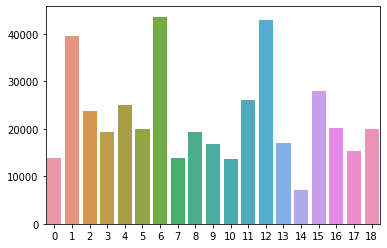

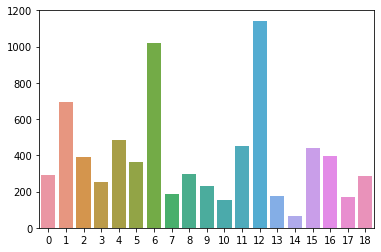

In [81]:
sub = pd.read_csv(data_path+'提交结果示例.csv')

sub['behavior_id'] = labels
# sub['behavior_id'] = [13 for x in range(len(sub))]

vc = data_train['behavior_id'].value_counts().sort_index()
sns.barplot(vc.index, vc.values)
plt.show()
vc = sub['behavior_id'].value_counts().sort_index()
sns.barplot(vc.index, vc.values)
plt.show()

In [82]:
sub.head()

,fragment_id,behavior_id
0,0,13
1,1,3
2,2,6
3,3,6
4,4,13


In [48]:
sub.to_csv('sub/lgb_%.5f.csv' % score, index=False)